In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
# MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
MODEL_PATH = os.path.join(PROJECT_PATH, 'baseline')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

Matplotlib is building the font cache; this may take a moment.


In [2]:
def Simplebaseline(backbone, input_shape=(256, 256, 3), num_heatmap=16):
    def _make_deconv_layer(num_deconv_layers):
        seq_model = Sequential()
        for i in range(num_deconv_layers):
            seq_model.add(Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
            seq_model.add(BatchNormalization())
            seq_model.add(ReLU())
        return seq_model
    
    upconv = _make_deconv_layer(3)
    final_layer = Conv2D(num_heatmap, kernel_size=(1,1), padding='same')

    inputs = tf.keras.Input(shape=input_shape)

    x = backbone(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [5]:
def chunkify(l, n):
    # 전체 데이터 l을 n그룹으로 나눔
    # -> n개의 TFRecord 파일을 만듦 (n개로 shard 함)
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [6]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [7]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [8]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-03-18 05:41:04,145	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.70gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=855) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=855) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=856) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=856) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=854) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=854) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=855) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=855) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=854) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=854) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=856) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=856) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=855) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=855) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=856) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=856) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

In [8]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

In [9]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

In [10]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

In [11]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

In [23]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = tf.constant(0.0, dtype=tf.float32)
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-3-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [13]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [25]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, model_path=None):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)
        
        resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
        model = Simplebaseline(resnet, input_shape=IMAGE_SHAPE, num_heatmap=num_heatmap)
        
        if model_path is not None:
            print('load model from : ', model_path)
            model.load_weights(model_path)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [17]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 10.6045589 epoch total loss 10.6045589
Trained batch 2 batch loss 10.4427938 epoch total loss 10.5236759
Trained batch 3 batch loss 9.51724339 epoch total loss 10.1881981
Trained batch 4 batch loss 7.47253466 epoch total loss 9.50928211
Trained batch 5 batch loss 7.81265736 epoch total loss 9.16995716
Trained batch 6 batch loss 8.23191452 epoch total loss 9.01361656
Trained batch 7 batch loss 7.95235395 epoch total loss 8.86200809
Trained batch 8 batch loss 7.46917105 epoch total loss 8.6879034
Trained batch 9 batch loss 7.22129917 epoch total loss 8.52494717
Trained batch 10 batch loss 6.56526566 epoch total loss 8.32897949
Trained batch 11 batch loss 7.12289095 epoch total loss 8.21933556
Trained batch 12 batch loss 6.75339937 epoch total loss 8.09717464
Trained batch 13 batch loss 6.79571676 epoch total loss 7.99706221
Trained batch 14 batch loss 6.82092857 epoch total loss 7.91305256
Trained batch 15 batch loss 6.90954733 ep

Trained batch 124 batch loss 6.90372229 epoch total loss 6.67093849
Trained batch 125 batch loss 6.83264 epoch total loss 6.67223215
Trained batch 126 batch loss 6.585217 epoch total loss 6.67154121
Trained batch 127 batch loss 6.8259244 epoch total loss 6.67275667
Trained batch 128 batch loss 6.38685131 epoch total loss 6.67052317
Trained batch 129 batch loss 6.45120239 epoch total loss 6.66882324
Trained batch 130 batch loss 6.17140579 epoch total loss 6.66499662
Trained batch 131 batch loss 5.88940573 epoch total loss 6.65907621
Trained batch 132 batch loss 6.26243687 epoch total loss 6.65607166
Trained batch 133 batch loss 6.71424484 epoch total loss 6.65650892
Trained batch 134 batch loss 6.93071 epoch total loss 6.65855503
Trained batch 135 batch loss 6.40004587 epoch total loss 6.65664
Trained batch 136 batch loss 6.65373755 epoch total loss 6.65661907
Trained batch 137 batch loss 6.505723 epoch total loss 6.65551758
Trained batch 138 batch loss 6.53410673 epoch total loss 6.654

Trained batch 246 batch loss 6.55845928 epoch total loss 6.58564806
Trained batch 247 batch loss 6.21559954 epoch total loss 6.58415
Trained batch 248 batch loss 5.78163767 epoch total loss 6.58091402
Trained batch 249 batch loss 5.69636631 epoch total loss 6.57736158
Trained batch 250 batch loss 5.64286566 epoch total loss 6.57362366
Trained batch 251 batch loss 5.64143 epoch total loss 6.56991
Trained batch 252 batch loss 5.5892 epoch total loss 6.5660181
Trained batch 253 batch loss 5.21302509 epoch total loss 6.56067038
Trained batch 254 batch loss 5.11217 epoch total loss 6.55496788
Trained batch 255 batch loss 5.6975379 epoch total loss 6.55160522
Trained batch 256 batch loss 6.85089684 epoch total loss 6.55277443
Trained batch 257 batch loss 6.56579113 epoch total loss 6.55282497
Trained batch 258 batch loss 6.24002218 epoch total loss 6.55161238
Trained batch 259 batch loss 6.56754 epoch total loss 6.55167389
Trained batch 260 batch loss 6.36819553 epoch total loss 6.55096817
T

Trained batch 368 batch loss 6.62548971 epoch total loss 6.49124622
Trained batch 369 batch loss 6.51687241 epoch total loss 6.49131536
Trained batch 370 batch loss 6.44059944 epoch total loss 6.49117851
Trained batch 371 batch loss 6.44278336 epoch total loss 6.49104834
Trained batch 372 batch loss 6.47146749 epoch total loss 6.49099588
Trained batch 373 batch loss 6.54074097 epoch total loss 6.49112892
Trained batch 374 batch loss 6.9121027 epoch total loss 6.49225473
Trained batch 375 batch loss 6.42221308 epoch total loss 6.49206781
Trained batch 376 batch loss 6.01057 epoch total loss 6.49078703
Trained batch 377 batch loss 6.77340746 epoch total loss 6.49153662
Trained batch 378 batch loss 6.80860853 epoch total loss 6.49237537
Trained batch 379 batch loss 6.61706257 epoch total loss 6.49270391
Trained batch 380 batch loss 6.22666311 epoch total loss 6.49200392
Trained batch 381 batch loss 6.21235466 epoch total loss 6.49127
Trained batch 382 batch loss 6.24784851 epoch total los

Trained batch 490 batch loss 6.24504614 epoch total loss 6.47390652
Trained batch 491 batch loss 6.51634026 epoch total loss 6.47399282
Trained batch 492 batch loss 6.47837305 epoch total loss 6.47400141
Trained batch 493 batch loss 6.29615545 epoch total loss 6.47364092
Trained batch 494 batch loss 6.46297503 epoch total loss 6.47361898
Trained batch 495 batch loss 6.75590563 epoch total loss 6.47418928
Trained batch 496 batch loss 6.6594677 epoch total loss 6.47456264
Trained batch 497 batch loss 6.49418163 epoch total loss 6.47460222
Trained batch 498 batch loss 6.44991112 epoch total loss 6.47455263
Trained batch 499 batch loss 6.48716927 epoch total loss 6.47457743
Trained batch 500 batch loss 6.44690084 epoch total loss 6.47452259
Trained batch 501 batch loss 6.39394331 epoch total loss 6.4743619
Trained batch 502 batch loss 6.21939421 epoch total loss 6.47385406
Trained batch 503 batch loss 6.57751751 epoch total loss 6.47406054
Trained batch 504 batch loss 6.72420025 epoch tota

Trained batch 612 batch loss 6.49388742 epoch total loss 6.46388054
Trained batch 613 batch loss 6.33495283 epoch total loss 6.46367025
Trained batch 614 batch loss 6.51775503 epoch total loss 6.46375847
Trained batch 615 batch loss 6.16893959 epoch total loss 6.46327877
Trained batch 616 batch loss 6.50173759 epoch total loss 6.46334124
Trained batch 617 batch loss 6.46105766 epoch total loss 6.46333742
Trained batch 618 batch loss 6.52445316 epoch total loss 6.46343613
Trained batch 619 batch loss 5.95277405 epoch total loss 6.4626112
Trained batch 620 batch loss 6.20189619 epoch total loss 6.4621911
Trained batch 621 batch loss 6.17858315 epoch total loss 6.46173382
Trained batch 622 batch loss 6.211411 epoch total loss 6.46133137
Trained batch 623 batch loss 6.72384405 epoch total loss 6.46175289
Trained batch 624 batch loss 6.82159567 epoch total loss 6.46232939
Trained batch 625 batch loss 6.71217 epoch total loss 6.46272945
Trained batch 626 batch loss 6.21108627 epoch total los

Trained batch 734 batch loss 6.17159939 epoch total loss 6.4513793
Trained batch 735 batch loss 6.06780291 epoch total loss 6.45085764
Trained batch 736 batch loss 6.14162683 epoch total loss 6.45043755
Trained batch 737 batch loss 6.23843098 epoch total loss 6.45014954
Trained batch 738 batch loss 6.25545597 epoch total loss 6.44988585
Trained batch 739 batch loss 5.95038271 epoch total loss 6.44920969
Trained batch 740 batch loss 6.22800875 epoch total loss 6.44891071
Trained batch 741 batch loss 6.34666395 epoch total loss 6.44877243
Trained batch 742 batch loss 5.86567688 epoch total loss 6.44798708
Trained batch 743 batch loss 6.44792 epoch total loss 6.4479866
Trained batch 744 batch loss 5.68838358 epoch total loss 6.44696569
Trained batch 745 batch loss 6.34325647 epoch total loss 6.44682646
Trained batch 746 batch loss 6.54132748 epoch total loss 6.4469533
Trained batch 747 batch loss 6.24694681 epoch total loss 6.44668579
Trained batch 748 batch loss 6.72927856 epoch total lo

Trained batch 856 batch loss 6.82185221 epoch total loss 6.44522142
Trained batch 857 batch loss 6.64519596 epoch total loss 6.4454546
Trained batch 858 batch loss 6.44101572 epoch total loss 6.44544888
Trained batch 859 batch loss 6.63784695 epoch total loss 6.44567299
Trained batch 860 batch loss 6.33392286 epoch total loss 6.44554281
Trained batch 861 batch loss 6.56009817 epoch total loss 6.44567585
Trained batch 862 batch loss 6.70364237 epoch total loss 6.4459753
Trained batch 863 batch loss 6.44196701 epoch total loss 6.44597054
Trained batch 864 batch loss 6.6694088 epoch total loss 6.44622898
Trained batch 865 batch loss 6.16599464 epoch total loss 6.44590521
Trained batch 866 batch loss 6.6191411 epoch total loss 6.44610548
Trained batch 867 batch loss 7.0149622 epoch total loss 6.44676161
Trained batch 868 batch loss 6.50871468 epoch total loss 6.44683313
Trained batch 869 batch loss 6.46440411 epoch total loss 6.44685316
Trained batch 870 batch loss 5.84476471 epoch total l

Trained batch 978 batch loss 6.57119656 epoch total loss 6.42153311
Trained batch 979 batch loss 6.68625546 epoch total loss 6.421803
Trained batch 980 batch loss 6.65470123 epoch total loss 6.42204094
Trained batch 981 batch loss 6.5949192 epoch total loss 6.42221689
Trained batch 982 batch loss 6.9404583 epoch total loss 6.42274475
Trained batch 983 batch loss 6.70773888 epoch total loss 6.42303419
Trained batch 984 batch loss 6.47973633 epoch total loss 6.42309189
Trained batch 985 batch loss 6.6685605 epoch total loss 6.4233408
Trained batch 986 batch loss 6.72978 epoch total loss 6.4236517
Trained batch 987 batch loss 6.80570936 epoch total loss 6.42403889
Trained batch 988 batch loss 6.63055849 epoch total loss 6.42424774
Trained batch 989 batch loss 6.65703344 epoch total loss 6.4244833
Trained batch 990 batch loss 6.68211412 epoch total loss 6.42474365
Trained batch 991 batch loss 6.39611292 epoch total loss 6.42471457
Trained batch 992 batch loss 6.71760321 epoch total loss 6.

Trained batch 1098 batch loss 5.66870165 epoch total loss 6.41724634
Trained batch 1099 batch loss 6.26847935 epoch total loss 6.41711092
Trained batch 1100 batch loss 6.16724205 epoch total loss 6.41688395
Trained batch 1101 batch loss 6.54252195 epoch total loss 6.41699791
Trained batch 1102 batch loss 6.15431738 epoch total loss 6.41675949
Trained batch 1103 batch loss 6.22294188 epoch total loss 6.41658401
Trained batch 1104 batch loss 5.75274134 epoch total loss 6.41598272
Trained batch 1105 batch loss 6.318223 epoch total loss 6.41589451
Trained batch 1106 batch loss 6.68547773 epoch total loss 6.41613817
Trained batch 1107 batch loss 6.72888 epoch total loss 6.41642094
Trained batch 1108 batch loss 6.7566824 epoch total loss 6.41672802
Trained batch 1109 batch loss 7.28740406 epoch total loss 6.41751337
Trained batch 1110 batch loss 6.96491718 epoch total loss 6.41800642
Trained batch 1111 batch loss 7.10523653 epoch total loss 6.41862535
Trained batch 1112 batch loss 6.68696928

Trained batch 1218 batch loss 6.17189646 epoch total loss 6.42092085
Trained batch 1219 batch loss 6.17638159 epoch total loss 6.42072
Trained batch 1220 batch loss 6.33416224 epoch total loss 6.42064905
Trained batch 1221 batch loss 6.2757206 epoch total loss 6.42053032
Trained batch 1222 batch loss 6.14962482 epoch total loss 6.42030859
Trained batch 1223 batch loss 6.04633522 epoch total loss 6.42000294
Trained batch 1224 batch loss 6.3799243 epoch total loss 6.41997
Trained batch 1225 batch loss 6.2400713 epoch total loss 6.41982365
Trained batch 1226 batch loss 6.4376812 epoch total loss 6.41983795
Trained batch 1227 batch loss 6.65534639 epoch total loss 6.42002964
Trained batch 1228 batch loss 6.3949604 epoch total loss 6.42000914
Trained batch 1229 batch loss 6.50333595 epoch total loss 6.42007732
Trained batch 1230 batch loss 6.84386063 epoch total loss 6.4204216
Trained batch 1231 batch loss 6.67420435 epoch total loss 6.42062807
Trained batch 1232 batch loss 6.51728535 epoch

Trained batch 1338 batch loss 6.28132772 epoch total loss 6.41125774
Trained batch 1339 batch loss 5.93063641 epoch total loss 6.41089869
Trained batch 1340 batch loss 6.41588116 epoch total loss 6.4109025
Trained batch 1341 batch loss 6.24648905 epoch total loss 6.41077948
Trained batch 1342 batch loss 6.17241 epoch total loss 6.41060209
Trained batch 1343 batch loss 6.34078407 epoch total loss 6.41055059
Trained batch 1344 batch loss 6.24392605 epoch total loss 6.41042662
Trained batch 1345 batch loss 6.62185431 epoch total loss 6.41058397
Trained batch 1346 batch loss 7.03471231 epoch total loss 6.41104794
Trained batch 1347 batch loss 6.58304453 epoch total loss 6.41117573
Trained batch 1348 batch loss 6.70241833 epoch total loss 6.41139126
Trained batch 1349 batch loss 6.64302158 epoch total loss 6.41156292
Trained batch 1350 batch loss 5.96029902 epoch total loss 6.41122818
Trained batch 1351 batch loss 6.39838743 epoch total loss 6.41121864
Trained batch 1352 batch loss 6.559820

Validated batch 116 batch loss 6.46455669
Validated batch 117 batch loss 6.8375144
Validated batch 118 batch loss 6.32286
Validated batch 119 batch loss 5.72789526
Validated batch 120 batch loss 6.38749409
Validated batch 121 batch loss 6.21451473
Validated batch 122 batch loss 5.97813034
Validated batch 123 batch loss 6.04856682
Validated batch 124 batch loss 5.91411495
Validated batch 125 batch loss 6.56204367
Validated batch 126 batch loss 6.07321739
Validated batch 127 batch loss 6.17407417
Validated batch 128 batch loss 5.89470434
Validated batch 129 batch loss 6.54362345
Validated batch 130 batch loss 6.07885361
Validated batch 131 batch loss 6.36198759
Validated batch 132 batch loss 6.25776482
Validated batch 133 batch loss 6.5573082
Validated batch 134 batch loss 6.1863451
Validated batch 135 batch loss 6.44635916
Validated batch 136 batch loss 6.52802086
Validated batch 137 batch loss 5.59770727
Validated batch 138 batch loss 6.40220737
Validated batch 139 batch loss 6.3772473

Trained batch 78 batch loss 5.95104742 epoch total loss 6.44752502
Trained batch 79 batch loss 6.0826025 epoch total loss 6.4429059
Trained batch 80 batch loss 5.9149394 epoch total loss 6.436306
Trained batch 81 batch loss 6.37840128 epoch total loss 6.43559122
Trained batch 82 batch loss 6.62464809 epoch total loss 6.43789673
Trained batch 83 batch loss 5.99688148 epoch total loss 6.43258333
Trained batch 84 batch loss 6.47678518 epoch total loss 6.43310976
Trained batch 85 batch loss 6.87056494 epoch total loss 6.43825626
Trained batch 86 batch loss 7.58173227 epoch total loss 6.45155239
Trained batch 87 batch loss 6.21367264 epoch total loss 6.44881821
Trained batch 88 batch loss 6.26647854 epoch total loss 6.44674635
Trained batch 89 batch loss 6.12609291 epoch total loss 6.44314337
Trained batch 90 batch loss 6.77766562 epoch total loss 6.44686031
Trained batch 91 batch loss 6.68855286 epoch total loss 6.44951582
Trained batch 92 batch loss 6.67543459 epoch total loss 6.45197153


Trained batch 200 batch loss 6.71393061 epoch total loss 6.46162224
Trained batch 201 batch loss 6.65898085 epoch total loss 6.46260405
Trained batch 202 batch loss 6.26344442 epoch total loss 6.46161795
Trained batch 203 batch loss 6.25606489 epoch total loss 6.46060562
Trained batch 204 batch loss 6.76052141 epoch total loss 6.46207571
Trained batch 205 batch loss 6.40159702 epoch total loss 6.46178055
Trained batch 206 batch loss 6.18336964 epoch total loss 6.46042919
Trained batch 207 batch loss 6.01098633 epoch total loss 6.45825768
Trained batch 208 batch loss 6.35264635 epoch total loss 6.45775032
Trained batch 209 batch loss 6.45837402 epoch total loss 6.45775318
Trained batch 210 batch loss 6.24354696 epoch total loss 6.45673323
Trained batch 211 batch loss 6.36312628 epoch total loss 6.45629
Trained batch 212 batch loss 6.40008593 epoch total loss 6.45602465
Trained batch 213 batch loss 6.07516623 epoch total loss 6.45423698
Trained batch 214 batch loss 6.65176296 epoch total

Trained batch 322 batch loss 6.20361662 epoch total loss 6.388834
Trained batch 323 batch loss 6.3014679 epoch total loss 6.38856363
Trained batch 324 batch loss 6.35047817 epoch total loss 6.38844681
Trained batch 325 batch loss 6.31783 epoch total loss 6.38822937
Trained batch 326 batch loss 6.34180689 epoch total loss 6.3880868
Trained batch 327 batch loss 6.42375135 epoch total loss 6.38819647
Trained batch 328 batch loss 5.41266 epoch total loss 6.38522196
Trained batch 329 batch loss 5.79308319 epoch total loss 6.3834219
Trained batch 330 batch loss 5.98223209 epoch total loss 6.38220596
Trained batch 331 batch loss 5.77241 epoch total loss 6.38036394
Trained batch 332 batch loss 6.3079834 epoch total loss 6.38014603
Trained batch 333 batch loss 6.18987322 epoch total loss 6.37957478
Trained batch 334 batch loss 6.52993298 epoch total loss 6.38002539
Trained batch 335 batch loss 6.28805876 epoch total loss 6.37975073
Trained batch 336 batch loss 6.02292776 epoch total loss 6.3786

Trained batch 444 batch loss 6.64865398 epoch total loss 6.37802315
Trained batch 445 batch loss 6.37361 epoch total loss 6.37801313
Trained batch 446 batch loss 6.50013447 epoch total loss 6.37828732
Trained batch 447 batch loss 6.20619106 epoch total loss 6.37790251
Trained batch 448 batch loss 6.39221716 epoch total loss 6.37793446
Trained batch 449 batch loss 6.27584887 epoch total loss 6.37770748
Trained batch 450 batch loss 7.05610466 epoch total loss 6.37921476
Trained batch 451 batch loss 6.62589598 epoch total loss 6.37976217
Trained batch 452 batch loss 5.88777542 epoch total loss 6.37867355
Trained batch 453 batch loss 6.15663433 epoch total loss 6.37818336
Trained batch 454 batch loss 6.1696763 epoch total loss 6.37772417
Trained batch 455 batch loss 6.32364273 epoch total loss 6.37760544
Trained batch 456 batch loss 5.34154844 epoch total loss 6.37533379
Trained batch 457 batch loss 5.41401196 epoch total loss 6.37323
Trained batch 458 batch loss 6.10739946 epoch total los

Trained batch 566 batch loss 6.7079215 epoch total loss 6.36332512
Trained batch 567 batch loss 6.90364313 epoch total loss 6.36427784
Trained batch 568 batch loss 6.61183643 epoch total loss 6.36471367
Trained batch 569 batch loss 6.79195 epoch total loss 6.36546469
Trained batch 570 batch loss 6.46282482 epoch total loss 6.36563587
Trained batch 571 batch loss 6.6556015 epoch total loss 6.36614323
Trained batch 572 batch loss 6.5161643 epoch total loss 6.36640549
Trained batch 573 batch loss 6.54195786 epoch total loss 6.36671209
Trained batch 574 batch loss 6.82087612 epoch total loss 6.36750317
Trained batch 575 batch loss 6.78348875 epoch total loss 6.36822653
Trained batch 576 batch loss 6.48022127 epoch total loss 6.36842108
Trained batch 577 batch loss 6.53489494 epoch total loss 6.36870956
Trained batch 578 batch loss 6.78993 epoch total loss 6.36943817
Trained batch 579 batch loss 6.49549913 epoch total loss 6.36965609
Trained batch 580 batch loss 6.40133858 epoch total loss 

Trained batch 688 batch loss 5.8743124 epoch total loss 6.3718338
Trained batch 689 batch loss 5.7220006 epoch total loss 6.37089109
Trained batch 690 batch loss 5.99892282 epoch total loss 6.37035227
Trained batch 691 batch loss 6.26629305 epoch total loss 6.37020111
Trained batch 692 batch loss 6.44728947 epoch total loss 6.37031269
Trained batch 693 batch loss 6.94036627 epoch total loss 6.37113523
Trained batch 694 batch loss 6.51848698 epoch total loss 6.3713479
Trained batch 695 batch loss 6.36429787 epoch total loss 6.37133741
Trained batch 696 batch loss 6.48373 epoch total loss 6.37149906
Trained batch 697 batch loss 6.04631186 epoch total loss 6.37103271
Trained batch 698 batch loss 5.82977772 epoch total loss 6.3702569
Trained batch 699 batch loss 5.61612606 epoch total loss 6.3691783
Trained batch 700 batch loss 5.7242465 epoch total loss 6.36825705
Trained batch 701 batch loss 5.69678545 epoch total loss 6.36729908
Trained batch 702 batch loss 6.43500805 epoch total loss 6

Trained batch 810 batch loss 6.44434643 epoch total loss 6.37356901
Trained batch 811 batch loss 5.74176168 epoch total loss 6.37279
Trained batch 812 batch loss 6.38201141 epoch total loss 6.37280083
Trained batch 813 batch loss 6.35277176 epoch total loss 6.37277603
Trained batch 814 batch loss 6.17781591 epoch total loss 6.37253618
Trained batch 815 batch loss 6.48374271 epoch total loss 6.37267303
Trained batch 816 batch loss 6.56340647 epoch total loss 6.37290668
Trained batch 817 batch loss 6.43807697 epoch total loss 6.37298632
Trained batch 818 batch loss 6.42082 epoch total loss 6.37304497
Trained batch 819 batch loss 6.39812279 epoch total loss 6.37307549
Trained batch 820 batch loss 6.39641333 epoch total loss 6.3731041
Trained batch 821 batch loss 6.43387842 epoch total loss 6.37317848
Trained batch 822 batch loss 6.3740592 epoch total loss 6.37317944
Trained batch 823 batch loss 6.36130047 epoch total loss 6.37316513
Trained batch 824 batch loss 6.36935616 epoch total loss

Trained batch 932 batch loss 5.93245745 epoch total loss 6.36752
Trained batch 933 batch loss 6.47311258 epoch total loss 6.36763287
Trained batch 934 batch loss 6.11671591 epoch total loss 6.36736441
Trained batch 935 batch loss 6.22592068 epoch total loss 6.36721325
Trained batch 936 batch loss 6.3772645 epoch total loss 6.36722422
Trained batch 937 batch loss 6.24095726 epoch total loss 6.36708879
Trained batch 938 batch loss 6.38337946 epoch total loss 6.36710644
Trained batch 939 batch loss 6.36419868 epoch total loss 6.3671031
Trained batch 940 batch loss 6.25551 epoch total loss 6.36698437
Trained batch 941 batch loss 6.28275728 epoch total loss 6.36689472
Trained batch 942 batch loss 6.44454241 epoch total loss 6.36697721
Trained batch 943 batch loss 6.53256321 epoch total loss 6.36715269
Trained batch 944 batch loss 6.42331076 epoch total loss 6.3672123
Trained batch 945 batch loss 6.27434492 epoch total loss 6.36711407
Trained batch 946 batch loss 6.60501719 epoch total loss 

Trained batch 1053 batch loss 5.72657204 epoch total loss 6.36757183
Trained batch 1054 batch loss 5.51388025 epoch total loss 6.36676168
Trained batch 1055 batch loss 5.19739342 epoch total loss 6.36565304
Trained batch 1056 batch loss 5.08550692 epoch total loss 6.36444092
Trained batch 1057 batch loss 5.13950491 epoch total loss 6.3632822
Trained batch 1058 batch loss 6.27454662 epoch total loss 6.36319828
Trained batch 1059 batch loss 6.29615879 epoch total loss 6.36313486
Trained batch 1060 batch loss 6.44159126 epoch total loss 6.36320877
Trained batch 1061 batch loss 6.48810959 epoch total loss 6.36332703
Trained batch 1062 batch loss 6.3069129 epoch total loss 6.3632741
Trained batch 1063 batch loss 6.12710667 epoch total loss 6.36305141
Trained batch 1064 batch loss 6.0100317 epoch total loss 6.36272
Trained batch 1065 batch loss 6.30895519 epoch total loss 6.36266947
Trained batch 1066 batch loss 6.50090742 epoch total loss 6.36279917
Trained batch 1067 batch loss 6.73873806 

Trained batch 1173 batch loss 6.88363409 epoch total loss 6.35841751
Trained batch 1174 batch loss 7.1297431 epoch total loss 6.35907459
Trained batch 1175 batch loss 7.03112602 epoch total loss 6.3596468
Trained batch 1176 batch loss 6.85623264 epoch total loss 6.36006927
Trained batch 1177 batch loss 7.24093294 epoch total loss 6.36081743
Trained batch 1178 batch loss 6.97181702 epoch total loss 6.36133623
Trained batch 1179 batch loss 6.52130651 epoch total loss 6.36147165
Trained batch 1180 batch loss 6.30200052 epoch total loss 6.36142111
Trained batch 1181 batch loss 6.7795949 epoch total loss 6.3617754
Trained batch 1182 batch loss 6.09686184 epoch total loss 6.36155128
Trained batch 1183 batch loss 6.4193759 epoch total loss 6.3616
Trained batch 1184 batch loss 6.45729494 epoch total loss 6.36168098
Trained batch 1185 batch loss 6.69449043 epoch total loss 6.36196184
Trained batch 1186 batch loss 6.22037077 epoch total loss 6.36184216
Trained batch 1187 batch loss 5.94848537 ep

Trained batch 1293 batch loss 6.78978157 epoch total loss 6.36762238
Trained batch 1294 batch loss 6.53642845 epoch total loss 6.36775255
Trained batch 1295 batch loss 6.46515465 epoch total loss 6.36782789
Trained batch 1296 batch loss 6.45644045 epoch total loss 6.3678956
Trained batch 1297 batch loss 6.31531763 epoch total loss 6.36785555
Trained batch 1298 batch loss 6.33156776 epoch total loss 6.36782789
Trained batch 1299 batch loss 6.58108234 epoch total loss 6.36799192
Trained batch 1300 batch loss 6.37939215 epoch total loss 6.36800051
Trained batch 1301 batch loss 6.34032631 epoch total loss 6.36797857
Trained batch 1302 batch loss 6.20626402 epoch total loss 6.36785412
Trained batch 1303 batch loss 6.52097464 epoch total loss 6.36797142
Trained batch 1304 batch loss 6.53725338 epoch total loss 6.36810112
Trained batch 1305 batch loss 6.40648317 epoch total loss 6.36813
Trained batch 1306 batch loss 6.47064781 epoch total loss 6.36820889
Trained batch 1307 batch loss 6.756527

Validated batch 40 batch loss 6.30870533
Validated batch 41 batch loss 6.49154663
Validated batch 42 batch loss 6.2964344
Validated batch 43 batch loss 6.14604712
Validated batch 44 batch loss 6.5928154
Validated batch 45 batch loss 5.47696209
Validated batch 46 batch loss 6.74935293
Validated batch 47 batch loss 6.25173903
Validated batch 48 batch loss 5.98247099
Validated batch 49 batch loss 6.2883091
Validated batch 50 batch loss 6.24245167
Validated batch 51 batch loss 6.215415
Validated batch 52 batch loss 6.56051588
Validated batch 53 batch loss 6.41203403
Validated batch 54 batch loss 6.4383812
Validated batch 55 batch loss 6.38599348
Validated batch 56 batch loss 6.45629072
Validated batch 57 batch loss 6.1393404
Validated batch 58 batch loss 6.36304092
Validated batch 59 batch loss 6.21967268
Validated batch 60 batch loss 6.60146093
Validated batch 61 batch loss 6.50455
Validated batch 62 batch loss 6.23896408
Validated batch 63 batch loss 6.50118
Validated batch 64 batch loss

Trained batch 32 batch loss 6.5657897 epoch total loss 6.18721
Trained batch 33 batch loss 6.37679911 epoch total loss 6.19295502
Trained batch 34 batch loss 6.30558443 epoch total loss 6.19626808
Trained batch 35 batch loss 6.33096361 epoch total loss 6.20011663
Trained batch 36 batch loss 5.99856 epoch total loss 6.19451761
Trained batch 37 batch loss 5.63507318 epoch total loss 6.17939758
Trained batch 38 batch loss 6.39360952 epoch total loss 6.18503475
Trained batch 39 batch loss 6.34193182 epoch total loss 6.18905783
Trained batch 40 batch loss 6.59857607 epoch total loss 6.199296
Trained batch 41 batch loss 6.58140182 epoch total loss 6.20861578
Trained batch 42 batch loss 6.42789412 epoch total loss 6.21383667
Trained batch 43 batch loss 6.20271111 epoch total loss 6.21357775
Trained batch 44 batch loss 5.31515646 epoch total loss 6.1931591
Trained batch 45 batch loss 5.00188446 epoch total loss 6.16668653
Trained batch 46 batch loss 5.64588499 epoch total loss 6.15536451
Train

Trained batch 155 batch loss 6.85035706 epoch total loss 6.35645819
Trained batch 156 batch loss 6.49957418 epoch total loss 6.35737562
Trained batch 157 batch loss 6.60750246 epoch total loss 6.35896873
Trained batch 158 batch loss 6.53139305 epoch total loss 6.36005974
Trained batch 159 batch loss 6.58783102 epoch total loss 6.36149263
Trained batch 160 batch loss 6.51794052 epoch total loss 6.36247
Trained batch 161 batch loss 6.39562273 epoch total loss 6.36267614
Trained batch 162 batch loss 6.52441311 epoch total loss 6.36367464
Trained batch 163 batch loss 6.47434378 epoch total loss 6.36435366
Trained batch 164 batch loss 5.73991 epoch total loss 6.36054564
Trained batch 165 batch loss 6.56158 epoch total loss 6.36176395
Trained batch 166 batch loss 6.62353516 epoch total loss 6.36334085
Trained batch 167 batch loss 6.40776491 epoch total loss 6.36360645
Trained batch 168 batch loss 6.36963511 epoch total loss 6.36364222
Trained batch 169 batch loss 6.60406256 epoch total loss 

Trained batch 277 batch loss 6.57464123 epoch total loss 6.39198542
Trained batch 278 batch loss 6.17387676 epoch total loss 6.39120054
Trained batch 279 batch loss 6.17414761 epoch total loss 6.39042282
Trained batch 280 batch loss 6.03035 epoch total loss 6.38913727
Trained batch 281 batch loss 6.61940241 epoch total loss 6.38995647
Trained batch 282 batch loss 6.47194481 epoch total loss 6.39024687
Trained batch 283 batch loss 6.35739851 epoch total loss 6.390131
Trained batch 284 batch loss 6.51892519 epoch total loss 6.39058447
Trained batch 285 batch loss 6.07262802 epoch total loss 6.38946915
Trained batch 286 batch loss 6.4473381 epoch total loss 6.38967133
Trained batch 287 batch loss 6.34237814 epoch total loss 6.38950682
Trained batch 288 batch loss 6.67790604 epoch total loss 6.39050817
Trained batch 289 batch loss 6.03568268 epoch total loss 6.38928032
Trained batch 290 batch loss 5.64233732 epoch total loss 6.38670444
Trained batch 291 batch loss 5.21492481 epoch total lo

Trained batch 399 batch loss 6.12142611 epoch total loss 6.37959719
Trained batch 400 batch loss 6.56261492 epoch total loss 6.38005447
Trained batch 401 batch loss 6.50305 epoch total loss 6.3803606
Trained batch 402 batch loss 6.71075153 epoch total loss 6.38118267
Trained batch 403 batch loss 6.49227 epoch total loss 6.38145781
Trained batch 404 batch loss 6.32392788 epoch total loss 6.38131571
Trained batch 405 batch loss 6.19992 epoch total loss 6.38086796
Trained batch 406 batch loss 6.54444933 epoch total loss 6.38127089
Trained batch 407 batch loss 6.3637886 epoch total loss 6.38122749
Trained batch 408 batch loss 6.66998672 epoch total loss 6.38193512
Trained batch 409 batch loss 6.2194 epoch total loss 6.38153791
Trained batch 410 batch loss 6.37427378 epoch total loss 6.38152027
Trained batch 411 batch loss 6.03775549 epoch total loss 6.38068438
Trained batch 412 batch loss 6.23173285 epoch total loss 6.38032246
Trained batch 413 batch loss 6.55973101 epoch total loss 6.3807

Trained batch 521 batch loss 6.6230092 epoch total loss 6.34953547
Trained batch 522 batch loss 7.2305007 epoch total loss 6.35122299
Trained batch 523 batch loss 6.43289566 epoch total loss 6.35137892
Trained batch 524 batch loss 6.74216509 epoch total loss 6.35212469
Trained batch 525 batch loss 6.61765575 epoch total loss 6.35263062
Trained batch 526 batch loss 6.4091773 epoch total loss 6.35273838
Trained batch 527 batch loss 6.42636395 epoch total loss 6.35287762
Trained batch 528 batch loss 6.67637396 epoch total loss 6.35349035
Trained batch 529 batch loss 6.45463181 epoch total loss 6.35368109
Trained batch 530 batch loss 6.28714085 epoch total loss 6.35355568
Trained batch 531 batch loss 6.25563622 epoch total loss 6.35337114
Trained batch 532 batch loss 6.39414358 epoch total loss 6.35344791
Trained batch 533 batch loss 6.39304113 epoch total loss 6.35352182
Trained batch 534 batch loss 6.45764637 epoch total loss 6.35371733
Trained batch 535 batch loss 6.57554197 epoch total

Trained batch 643 batch loss 5.05804873 epoch total loss 6.35680151
Trained batch 644 batch loss 5.25173903 epoch total loss 6.35508537
Trained batch 645 batch loss 5.64669752 epoch total loss 6.35398722
Trained batch 646 batch loss 6.16575527 epoch total loss 6.35369539
Trained batch 647 batch loss 6.43076801 epoch total loss 6.3538146
Trained batch 648 batch loss 6.70665836 epoch total loss 6.35435867
Trained batch 649 batch loss 6.91476345 epoch total loss 6.35522175
Trained batch 650 batch loss 6.68437 epoch total loss 6.35572863
Trained batch 651 batch loss 6.01634216 epoch total loss 6.35520697
Trained batch 652 batch loss 5.90816212 epoch total loss 6.35452127
Trained batch 653 batch loss 5.91462135 epoch total loss 6.3538475
Trained batch 654 batch loss 6.81439543 epoch total loss 6.35455179
Trained batch 655 batch loss 6.52809381 epoch total loss 6.35481739
Trained batch 656 batch loss 6.44351768 epoch total loss 6.35495234
Trained batch 657 batch loss 6.4251833 epoch total lo

Trained batch 765 batch loss 6.57206869 epoch total loss 6.35337925
Trained batch 766 batch loss 6.51257324 epoch total loss 6.35358715
Trained batch 767 batch loss 6.24006939 epoch total loss 6.35343933
Trained batch 768 batch loss 6.47583389 epoch total loss 6.35359907
Trained batch 769 batch loss 6.24927664 epoch total loss 6.35346365
Trained batch 770 batch loss 6.41802073 epoch total loss 6.3535471
Trained batch 771 batch loss 6.15948963 epoch total loss 6.3532958
Trained batch 772 batch loss 6.13061905 epoch total loss 6.35300779
Trained batch 773 batch loss 6.15565968 epoch total loss 6.35275269
Trained batch 774 batch loss 6.39709711 epoch total loss 6.35281
Trained batch 775 batch loss 6.70683336 epoch total loss 6.35326672
Trained batch 776 batch loss 6.53263855 epoch total loss 6.35349798
Trained batch 777 batch loss 6.84242868 epoch total loss 6.35412693
Trained batch 778 batch loss 6.15005589 epoch total loss 6.35386467
Trained batch 779 batch loss 6.2713623 epoch total lo

Trained batch 887 batch loss 6.40799189 epoch total loss 6.3500371
Trained batch 888 batch loss 6.25753736 epoch total loss 6.34993267
Trained batch 889 batch loss 6.16465712 epoch total loss 6.34972429
Trained batch 890 batch loss 6.04368067 epoch total loss 6.34938
Trained batch 891 batch loss 6.0191226 epoch total loss 6.34900951
Trained batch 892 batch loss 6.41370344 epoch total loss 6.34908152
Trained batch 893 batch loss 6.23344374 epoch total loss 6.34895229
Trained batch 894 batch loss 6.41537 epoch total loss 6.34902668
Trained batch 895 batch loss 6.35547781 epoch total loss 6.34903383
Trained batch 896 batch loss 6.24991226 epoch total loss 6.34892321
Trained batch 897 batch loss 6.30811453 epoch total loss 6.34887791
Trained batch 898 batch loss 6.98107576 epoch total loss 6.34958172
Trained batch 899 batch loss 6.66915798 epoch total loss 6.34993696
Trained batch 900 batch loss 6.67024469 epoch total loss 6.35029316
Trained batch 901 batch loss 6.28612089 epoch total loss

Trained batch 1009 batch loss 6.62259674 epoch total loss 6.36772585
Trained batch 1010 batch loss 6.70403194 epoch total loss 6.36805868
Trained batch 1011 batch loss 6.56197357 epoch total loss 6.36825037
Trained batch 1012 batch loss 6.56418562 epoch total loss 6.36844397
Trained batch 1013 batch loss 6.48665619 epoch total loss 6.36856079
Trained batch 1014 batch loss 6.42610884 epoch total loss 6.36861753
Trained batch 1015 batch loss 6.50509596 epoch total loss 6.368752
Trained batch 1016 batch loss 6.5846982 epoch total loss 6.3689642
Trained batch 1017 batch loss 6.1777339 epoch total loss 6.36877632
Trained batch 1018 batch loss 5.89326191 epoch total loss 6.36830902
Trained batch 1019 batch loss 5.58375359 epoch total loss 6.36753941
Trained batch 1020 batch loss 6.07763052 epoch total loss 6.36725521
Trained batch 1021 batch loss 6.54343128 epoch total loss 6.36742735
Trained batch 1022 batch loss 6.49327 epoch total loss 6.36755037
Trained batch 1023 batch loss 6.28276253 e

Trained batch 1129 batch loss 6.63333702 epoch total loss 6.36470413
Trained batch 1130 batch loss 6.18597174 epoch total loss 6.36454582
Trained batch 1131 batch loss 6.46288776 epoch total loss 6.36463308
Trained batch 1132 batch loss 6.29254436 epoch total loss 6.36456919
Trained batch 1133 batch loss 6.68614197 epoch total loss 6.36485291
Trained batch 1134 batch loss 6.65562439 epoch total loss 6.36510944
Trained batch 1135 batch loss 6.32622862 epoch total loss 6.36507511
Trained batch 1136 batch loss 6.4312973 epoch total loss 6.36513329
Trained batch 1137 batch loss 5.9484911 epoch total loss 6.36476707
Trained batch 1138 batch loss 6.39105368 epoch total loss 6.36479044
Trained batch 1139 batch loss 6.26471329 epoch total loss 6.36470222
Trained batch 1140 batch loss 6.31591511 epoch total loss 6.36466
Trained batch 1141 batch loss 6.29318762 epoch total loss 6.36459684
Trained batch 1142 batch loss 6.66063786 epoch total loss 6.36485577
Trained batch 1143 batch loss 6.243505 

Trained batch 1249 batch loss 5.76050854 epoch total loss 6.3605566
Trained batch 1250 batch loss 6.03439283 epoch total loss 6.3602953
Trained batch 1251 batch loss 6.06937313 epoch total loss 6.3600626
Trained batch 1252 batch loss 5.81010723 epoch total loss 6.35962343
Trained batch 1253 batch loss 5.72178555 epoch total loss 6.35911417
Trained batch 1254 batch loss 6.02722836 epoch total loss 6.35884953
Trained batch 1255 batch loss 6.31868172 epoch total loss 6.35881805
Trained batch 1256 batch loss 6.53085804 epoch total loss 6.35895491
Trained batch 1257 batch loss 6.77766275 epoch total loss 6.35928822
Trained batch 1258 batch loss 6.65628052 epoch total loss 6.35952425
Trained batch 1259 batch loss 6.48829126 epoch total loss 6.35962629
Trained batch 1260 batch loss 6.56299686 epoch total loss 6.35978794
Trained batch 1261 batch loss 6.43771315 epoch total loss 6.35984945
Trained batch 1262 batch loss 6.53513527 epoch total loss 6.35998821
Trained batch 1263 batch loss 6.89087

Trained batch 1369 batch loss 6.99445963 epoch total loss 6.35474968
Trained batch 1370 batch loss 6.86171055 epoch total loss 6.35511971
Trained batch 1371 batch loss 6.82149315 epoch total loss 6.35545969
Trained batch 1372 batch loss 7.21556616 epoch total loss 6.35608673
Trained batch 1373 batch loss 6.87596846 epoch total loss 6.35646534
Trained batch 1374 batch loss 6.51701832 epoch total loss 6.35658169
Trained batch 1375 batch loss 6.44307327 epoch total loss 6.35664511
Trained batch 1376 batch loss 6.67826748 epoch total loss 6.35687876
Trained batch 1377 batch loss 6.48579311 epoch total loss 6.35697222
Trained batch 1378 batch loss 6.07508278 epoch total loss 6.35676765
Trained batch 1379 batch loss 6.53660536 epoch total loss 6.35689783
Trained batch 1380 batch loss 6.61991024 epoch total loss 6.35708857
Trained batch 1381 batch loss 6.04623032 epoch total loss 6.35686302
Trained batch 1382 batch loss 6.41730785 epoch total loss 6.35690689
Trained batch 1383 batch loss 6.39

Validated batch 166 batch loss 6.01446676
Validated batch 167 batch loss 6.62462
Validated batch 168 batch loss 6.42038059
Validated batch 169 batch loss 6.25516462
Validated batch 170 batch loss 6.46122742
Validated batch 171 batch loss 6.5482316
Validated batch 172 batch loss 6.24034786
Validated batch 173 batch loss 6.25293589
Validated batch 174 batch loss 6.2610774
Validated batch 175 batch loss 6.48210382
Validated batch 176 batch loss 6.61972666
Validated batch 177 batch loss 6.43072271
Validated batch 178 batch loss 6.17898273
Validated batch 179 batch loss 6.12435341
Validated batch 180 batch loss 6.28757
Validated batch 181 batch loss 6.41538811
Validated batch 182 batch loss 6.52419424
Validated batch 183 batch loss 6.38111973
Validated batch 184 batch loss 6.28258371
Validated batch 185 batch loss 3.15265608
Epoch 3 val loss 6.325591087341309
Start epoch 4 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 6.02798605 epoch total loss 6.02798

Trained batch 110 batch loss 5.61023521 epoch total loss 6.25016975
Trained batch 111 batch loss 6.23664379 epoch total loss 6.25004768
Trained batch 112 batch loss 6.63946295 epoch total loss 6.25352478
Trained batch 113 batch loss 6.47188282 epoch total loss 6.25545692
Trained batch 114 batch loss 6.49794102 epoch total loss 6.2575841
Trained batch 115 batch loss 5.98871279 epoch total loss 6.25524569
Trained batch 116 batch loss 5.94631815 epoch total loss 6.25258255
Trained batch 117 batch loss 6.09753656 epoch total loss 6.25125742
Trained batch 118 batch loss 6.45908785 epoch total loss 6.25301886
Trained batch 119 batch loss 6.5330081 epoch total loss 6.25537157
Trained batch 120 batch loss 6.43518305 epoch total loss 6.25687
Trained batch 121 batch loss 6.03698 epoch total loss 6.25505257
Trained batch 122 batch loss 6.22422409 epoch total loss 6.25480032
Trained batch 123 batch loss 6.31974936 epoch total loss 6.25532866
Trained batch 124 batch loss 6.87311697 epoch total loss

Trained batch 232 batch loss 6.72988558 epoch total loss 6.30362511
Trained batch 233 batch loss 6.59866047 epoch total loss 6.30489111
Trained batch 234 batch loss 6.62769747 epoch total loss 6.3062706
Trained batch 235 batch loss 6.47706079 epoch total loss 6.3069973
Trained batch 236 batch loss 6.22576046 epoch total loss 6.30665302
Trained batch 237 batch loss 5.84455 epoch total loss 6.30470324
Trained batch 238 batch loss 6.28679657 epoch total loss 6.3046279
Trained batch 239 batch loss 6.59461594 epoch total loss 6.30584145
Trained batch 240 batch loss 6.25851536 epoch total loss 6.30564404
Trained batch 241 batch loss 6.3971591 epoch total loss 6.30602407
Trained batch 242 batch loss 6.50249 epoch total loss 6.30683565
Trained batch 243 batch loss 6.48253441 epoch total loss 6.30755901
Trained batch 244 batch loss 6.74841452 epoch total loss 6.30936575
Trained batch 245 batch loss 6.25819874 epoch total loss 6.30915689
Trained batch 246 batch loss 6.45101261 epoch total loss 6

Trained batch 354 batch loss 6.41121387 epoch total loss 6.35912
Trained batch 355 batch loss 6.44827509 epoch total loss 6.35937071
Trained batch 356 batch loss 5.49492931 epoch total loss 6.35694265
Trained batch 357 batch loss 5.67817831 epoch total loss 6.3550415
Trained batch 358 batch loss 5.7868762 epoch total loss 6.35345411
Trained batch 359 batch loss 6.10127783 epoch total loss 6.35275173
Trained batch 360 batch loss 5.26230764 epoch total loss 6.34972286
Trained batch 361 batch loss 4.93895245 epoch total loss 6.3458147
Trained batch 362 batch loss 5.26827097 epoch total loss 6.34283829
Trained batch 363 batch loss 5.78023148 epoch total loss 6.34128857
Trained batch 364 batch loss 5.957304 epoch total loss 6.34023333
Trained batch 365 batch loss 6.28336287 epoch total loss 6.34007788
Trained batch 366 batch loss 6.6738553 epoch total loss 6.34098959
Trained batch 367 batch loss 6.89628649 epoch total loss 6.34250259
Trained batch 368 batch loss 6.69896317 epoch total loss 

Trained batch 476 batch loss 6.33830118 epoch total loss 6.34420061
Trained batch 477 batch loss 6.15296507 epoch total loss 6.3438
Trained batch 478 batch loss 6.31157732 epoch total loss 6.34373283
Trained batch 479 batch loss 6.48275232 epoch total loss 6.34402275
Trained batch 480 batch loss 6.20928764 epoch total loss 6.34374189
Trained batch 481 batch loss 6.48403215 epoch total loss 6.34403372
Trained batch 482 batch loss 6.23931265 epoch total loss 6.34381628
Trained batch 483 batch loss 6.31276131 epoch total loss 6.34375191
Trained batch 484 batch loss 6.31877613 epoch total loss 6.34370041
Trained batch 485 batch loss 6.50133848 epoch total loss 6.34402514
Trained batch 486 batch loss 6.25840473 epoch total loss 6.34384918
Trained batch 487 batch loss 6.40463734 epoch total loss 6.34397364
Trained batch 488 batch loss 6.3274107 epoch total loss 6.34394
Trained batch 489 batch loss 6.33698845 epoch total loss 6.34392548
Trained batch 490 batch loss 6.2921958 epoch total loss 

Trained batch 598 batch loss 5.90023518 epoch total loss 6.32492113
Trained batch 599 batch loss 6.3930788 epoch total loss 6.32503462
Trained batch 600 batch loss 5.86137486 epoch total loss 6.32426167
Trained batch 601 batch loss 6.15797853 epoch total loss 6.3239851
Trained batch 602 batch loss 5.72532701 epoch total loss 6.32299089
Trained batch 603 batch loss 5.93191195 epoch total loss 6.32234192
Trained batch 604 batch loss 6.16979122 epoch total loss 6.3220892
Trained batch 605 batch loss 6.4000082 epoch total loss 6.32221794
Trained batch 606 batch loss 6.61435795 epoch total loss 6.3227
Trained batch 607 batch loss 6.85219955 epoch total loss 6.32357264
Trained batch 608 batch loss 6.7299633 epoch total loss 6.32424068
Trained batch 609 batch loss 6.29836226 epoch total loss 6.32419825
Trained batch 610 batch loss 6.0300293 epoch total loss 6.32371616
Trained batch 611 batch loss 6.51586342 epoch total loss 6.3240304
Trained batch 612 batch loss 6.1475172 epoch total loss 6.3

Trained batch 720 batch loss 6.47127104 epoch total loss 6.33264589
Trained batch 721 batch loss 6.41195583 epoch total loss 6.33275604
Trained batch 722 batch loss 6.47819424 epoch total loss 6.33295727
Trained batch 723 batch loss 6.12706852 epoch total loss 6.33267212
Trained batch 724 batch loss 5.59358788 epoch total loss 6.33165169
Trained batch 725 batch loss 5.93345547 epoch total loss 6.33110237
Trained batch 726 batch loss 6.33548784 epoch total loss 6.33110857
Trained batch 727 batch loss 6.0759306 epoch total loss 6.33075762
Trained batch 728 batch loss 6.33439684 epoch total loss 6.33076286
Trained batch 729 batch loss 6.52646208 epoch total loss 6.33103132
Trained batch 730 batch loss 6.37114716 epoch total loss 6.33108616
Trained batch 731 batch loss 6.53819 epoch total loss 6.3313694
Trained batch 732 batch loss 6.25660133 epoch total loss 6.33126736
Trained batch 733 batch loss 6.34374666 epoch total loss 6.33128452
Trained batch 734 batch loss 6.47523737 epoch total l

Trained batch 842 batch loss 6.18900061 epoch total loss 6.33302069
Trained batch 843 batch loss 6.50731754 epoch total loss 6.33322716
Trained batch 844 batch loss 7.2191143 epoch total loss 6.33427715
Trained batch 845 batch loss 6.72838545 epoch total loss 6.3347435
Trained batch 846 batch loss 7.02268934 epoch total loss 6.33555651
Trained batch 847 batch loss 6.2973094 epoch total loss 6.33551168
Trained batch 848 batch loss 6.1375289 epoch total loss 6.33527803
Trained batch 849 batch loss 6.19429684 epoch total loss 6.33511209
Trained batch 850 batch loss 6.07713413 epoch total loss 6.33480883
Trained batch 851 batch loss 6.49460316 epoch total loss 6.3349967
Trained batch 852 batch loss 6.01356602 epoch total loss 6.33461952
Trained batch 853 batch loss 6.56482 epoch total loss 6.33488941
Trained batch 854 batch loss 6.40296412 epoch total loss 6.33496904
Trained batch 855 batch loss 6.46998882 epoch total loss 6.33512735
Trained batch 856 batch loss 6.06446934 epoch total loss

Trained batch 964 batch loss 6.81293058 epoch total loss 6.33781052
Trained batch 965 batch loss 6.70766306 epoch total loss 6.33819389
Trained batch 966 batch loss 6.33086586 epoch total loss 6.33818626
Trained batch 967 batch loss 6.43862343 epoch total loss 6.33829
Trained batch 968 batch loss 6.62574482 epoch total loss 6.33858728
Trained batch 969 batch loss 6.52819967 epoch total loss 6.33878326
Trained batch 970 batch loss 6.87492 epoch total loss 6.33933592
Trained batch 971 batch loss 7.02031279 epoch total loss 6.34003735
Trained batch 972 batch loss 6.87684488 epoch total loss 6.34058952
Trained batch 973 batch loss 6.63344622 epoch total loss 6.34089041
Trained batch 974 batch loss 6.23908567 epoch total loss 6.34078646
Trained batch 975 batch loss 6.98647404 epoch total loss 6.34144831
Trained batch 976 batch loss 6.75315523 epoch total loss 6.34187
Trained batch 977 batch loss 6.41130447 epoch total loss 6.34194088
Trained batch 978 batch loss 6.56296301 epoch total loss 

Trained batch 1084 batch loss 5.98903322 epoch total loss 6.34813356
Trained batch 1085 batch loss 6.50689363 epoch total loss 6.34828
Trained batch 1086 batch loss 6.19192362 epoch total loss 6.34813595
Trained batch 1087 batch loss 6.78693819 epoch total loss 6.34854
Trained batch 1088 batch loss 6.38383245 epoch total loss 6.34857225
Trained batch 1089 batch loss 6.98620415 epoch total loss 6.34915781
Trained batch 1090 batch loss 6.89185429 epoch total loss 6.34965611
Trained batch 1091 batch loss 6.62014914 epoch total loss 6.34990406
Trained batch 1092 batch loss 6.23215055 epoch total loss 6.34979582
Trained batch 1093 batch loss 6.61299 epoch total loss 6.35003662
Trained batch 1094 batch loss 6.77794075 epoch total loss 6.35042763
Trained batch 1095 batch loss 6.79009247 epoch total loss 6.35082912
Trained batch 1096 batch loss 6.65553093 epoch total loss 6.35110712
Trained batch 1097 batch loss 6.54486561 epoch total loss 6.35128403
Trained batch 1098 batch loss 6.79066038 ep

Trained batch 1204 batch loss 6.41912937 epoch total loss 6.35118198
Trained batch 1205 batch loss 6.48033953 epoch total loss 6.35128927
Trained batch 1206 batch loss 6.20515823 epoch total loss 6.35116816
Trained batch 1207 batch loss 6.29267406 epoch total loss 6.35111952
Trained batch 1208 batch loss 6.47185564 epoch total loss 6.35121918
Trained batch 1209 batch loss 7.02272892 epoch total loss 6.35177517
Trained batch 1210 batch loss 6.59119749 epoch total loss 6.35197306
Trained batch 1211 batch loss 6.13720942 epoch total loss 6.35179567
Trained batch 1212 batch loss 5.89025593 epoch total loss 6.35141468
Trained batch 1213 batch loss 5.97040319 epoch total loss 6.35110044
Trained batch 1214 batch loss 6.40444469 epoch total loss 6.35114431
Trained batch 1215 batch loss 6.5985465 epoch total loss 6.35134792
Trained batch 1216 batch loss 5.88427 epoch total loss 6.35096359
Trained batch 1217 batch loss 6.1379652 epoch total loss 6.35078907
Trained batch 1218 batch loss 6.3125677

Trained batch 1324 batch loss 5.89885 epoch total loss 6.34902382
Trained batch 1325 batch loss 5.7422142 epoch total loss 6.34856558
Trained batch 1326 batch loss 6.33253193 epoch total loss 6.34855413
Trained batch 1327 batch loss 6.50078249 epoch total loss 6.34866905
Trained batch 1328 batch loss 6.34001875 epoch total loss 6.34866238
Trained batch 1329 batch loss 6.29785252 epoch total loss 6.34862423
Trained batch 1330 batch loss 6.50474501 epoch total loss 6.34874153
Trained batch 1331 batch loss 6.32197 epoch total loss 6.3487215
Trained batch 1332 batch loss 6.57785511 epoch total loss 6.34889364
Trained batch 1333 batch loss 6.50704193 epoch total loss 6.34901237
Trained batch 1334 batch loss 6.39535189 epoch total loss 6.34904718
Trained batch 1335 batch loss 6.25381947 epoch total loss 6.34897566
Trained batch 1336 batch loss 6.25596952 epoch total loss 6.34890604
Trained batch 1337 batch loss 6.82111216 epoch total loss 6.34925938
Trained batch 1338 batch loss 6.41798925 e

Validated batch 93 batch loss 6.14186
Validated batch 94 batch loss 6.40462589
Validated batch 95 batch loss 6.16065693
Validated batch 96 batch loss 5.62623501
Validated batch 97 batch loss 6.05720282
Validated batch 98 batch loss 6.69788837
Validated batch 99 batch loss 6.07538223
Validated batch 100 batch loss 6.36433506
Validated batch 101 batch loss 6.40197086
Validated batch 102 batch loss 6.44081116
Validated batch 103 batch loss 6.574512
Validated batch 104 batch loss 6.33800507
Validated batch 105 batch loss 6.38118696
Validated batch 106 batch loss 6.23811102
Validated batch 107 batch loss 6.44892406
Validated batch 108 batch loss 6.80720758
Validated batch 109 batch loss 6.12778282
Validated batch 110 batch loss 6.57529926
Validated batch 111 batch loss 6.46640778
Validated batch 112 batch loss 6.0101223
Validated batch 113 batch loss 6.28642893
Validated batch 114 batch loss 6.31488228
Validated batch 115 batch loss 6.65569782
Validated batch 116 batch loss 6.41844797
Valid

Trained batch 65 batch loss 6.54321241 epoch total loss 6.36698484
Trained batch 66 batch loss 6.66211033 epoch total loss 6.37145615
Trained batch 67 batch loss 6.75170422 epoch total loss 6.37713146
Trained batch 68 batch loss 6.41909027 epoch total loss 6.37774897
Trained batch 69 batch loss 6.64469 epoch total loss 6.38161755
Trained batch 70 batch loss 7.07624531 epoch total loss 6.39154053
Trained batch 71 batch loss 6.80739069 epoch total loss 6.39739752
Trained batch 72 batch loss 6.30163193 epoch total loss 6.39606762
Trained batch 73 batch loss 6.13260126 epoch total loss 6.39245844
Trained batch 74 batch loss 5.81227255 epoch total loss 6.38461828
Trained batch 75 batch loss 5.31903553 epoch total loss 6.37041044
Trained batch 76 batch loss 5.98439789 epoch total loss 6.36533165
Trained batch 77 batch loss 5.66926861 epoch total loss 6.35629177
Trained batch 78 batch loss 5.26732683 epoch total loss 6.34233093
Trained batch 79 batch loss 5.24427128 epoch total loss 6.3284311

Trained batch 187 batch loss 6.03286934 epoch total loss 6.36672354
Trained batch 188 batch loss 6.31544733 epoch total loss 6.36645031
Trained batch 189 batch loss 7.02189112 epoch total loss 6.36991835
Trained batch 190 batch loss 6.77635288 epoch total loss 6.37205744
Trained batch 191 batch loss 6.5690856 epoch total loss 6.37308884
Trained batch 192 batch loss 6.35541344 epoch total loss 6.37299728
Trained batch 193 batch loss 6.38952637 epoch total loss 6.37308311
Trained batch 194 batch loss 6.17583513 epoch total loss 6.37206602
Trained batch 195 batch loss 6.31578255 epoch total loss 6.37177753
Trained batch 196 batch loss 6.3085351 epoch total loss 6.37145519
Trained batch 197 batch loss 6.35673428 epoch total loss 6.37138
Trained batch 198 batch loss 6.18989229 epoch total loss 6.37046385
Trained batch 199 batch loss 6.26481247 epoch total loss 6.36993265
Trained batch 200 batch loss 6.1705575 epoch total loss 6.36893559
Trained batch 201 batch loss 6.26308393 epoch total lo

Trained batch 309 batch loss 6.45251083 epoch total loss 6.40704966
Trained batch 310 batch loss 6.02060175 epoch total loss 6.4058032
Trained batch 311 batch loss 6.45830345 epoch total loss 6.40597153
Trained batch 312 batch loss 6.2171607 epoch total loss 6.40536642
Trained batch 313 batch loss 6.41673851 epoch total loss 6.40540314
Trained batch 314 batch loss 6.10913849 epoch total loss 6.40445948
Trained batch 315 batch loss 6.35098696 epoch total loss 6.40428972
Trained batch 316 batch loss 6.58492756 epoch total loss 6.40486145
Trained batch 317 batch loss 6.94124269 epoch total loss 6.40655327
Trained batch 318 batch loss 6.72390032 epoch total loss 6.40755129
Trained batch 319 batch loss 7.08007097 epoch total loss 6.40965939
Trained batch 320 batch loss 6.85089731 epoch total loss 6.4110384
Trained batch 321 batch loss 6.02620459 epoch total loss 6.40983915
Trained batch 322 batch loss 5.73570156 epoch total loss 6.40774536
Trained batch 323 batch loss 5.44357061 epoch total

Trained batch 431 batch loss 6.39073467 epoch total loss 6.37111139
Trained batch 432 batch loss 5.8378129 epoch total loss 6.36987686
Trained batch 433 batch loss 5.84622622 epoch total loss 6.3686676
Trained batch 434 batch loss 6.04615498 epoch total loss 6.36792421
Trained batch 435 batch loss 6.5741086 epoch total loss 6.36839867
Trained batch 436 batch loss 5.94204521 epoch total loss 6.36742115
Trained batch 437 batch loss 6.11426592 epoch total loss 6.36684179
Trained batch 438 batch loss 6.31403828 epoch total loss 6.36672115
Trained batch 439 batch loss 6.33334 epoch total loss 6.36664486
Trained batch 440 batch loss 6.49897385 epoch total loss 6.36694574
Trained batch 441 batch loss 6.49443483 epoch total loss 6.36723471
Trained batch 442 batch loss 5.82534361 epoch total loss 6.36600876
Trained batch 443 batch loss 5.91738272 epoch total loss 6.36499643
Trained batch 444 batch loss 6.27326822 epoch total loss 6.36478949
Trained batch 445 batch loss 6.46967602 epoch total lo

Trained batch 553 batch loss 6.25813484 epoch total loss 6.34439421
Trained batch 554 batch loss 6.26318789 epoch total loss 6.34424734
Trained batch 555 batch loss 6.40232086 epoch total loss 6.34435225
Trained batch 556 batch loss 6.45379162 epoch total loss 6.34454918
Trained batch 557 batch loss 6.69587851 epoch total loss 6.34517956
Trained batch 558 batch loss 6.33824873 epoch total loss 6.34516716
Trained batch 559 batch loss 6.23080111 epoch total loss 6.3449626
Trained batch 560 batch loss 6.42100525 epoch total loss 6.34509802
Trained batch 561 batch loss 6.28082037 epoch total loss 6.3449831
Trained batch 562 batch loss 5.86917686 epoch total loss 6.34413671
Trained batch 563 batch loss 6.09357071 epoch total loss 6.34369135
Trained batch 564 batch loss 5.59017467 epoch total loss 6.34235525
Trained batch 565 batch loss 5.73931456 epoch total loss 6.34128809
Trained batch 566 batch loss 6.07195425 epoch total loss 6.34081221
Trained batch 567 batch loss 6.19019222 epoch tota

Trained batch 675 batch loss 6.35805845 epoch total loss 6.32877541
Trained batch 676 batch loss 6.25555229 epoch total loss 6.32866669
Trained batch 677 batch loss 5.95894432 epoch total loss 6.32812071
Trained batch 678 batch loss 5.83563805 epoch total loss 6.32739401
Trained batch 679 batch loss 6.42558765 epoch total loss 6.32753897
Trained batch 680 batch loss 5.91503906 epoch total loss 6.32693243
Trained batch 681 batch loss 6.06146622 epoch total loss 6.32654238
Trained batch 682 batch loss 5.784266 epoch total loss 6.32574749
Trained batch 683 batch loss 5.72270346 epoch total loss 6.32486439
Trained batch 684 batch loss 5.71028519 epoch total loss 6.32396603
Trained batch 685 batch loss 5.65938663 epoch total loss 6.32299566
Trained batch 686 batch loss 6.25906038 epoch total loss 6.32290268
Trained batch 687 batch loss 6.21693182 epoch total loss 6.32274818
Trained batch 688 batch loss 6.2813797 epoch total loss 6.3226881
Trained batch 689 batch loss 6.33487082 epoch total 

Trained batch 797 batch loss 6.52969027 epoch total loss 6.33153486
Trained batch 798 batch loss 6.47989082 epoch total loss 6.33172083
Trained batch 799 batch loss 6.19780064 epoch total loss 6.33155346
Trained batch 800 batch loss 6.41793489 epoch total loss 6.33166122
Trained batch 801 batch loss 6.34877539 epoch total loss 6.33168268
Trained batch 802 batch loss 5.81531811 epoch total loss 6.33103895
Trained batch 803 batch loss 6.45704937 epoch total loss 6.33119583
Trained batch 804 batch loss 6.36885452 epoch total loss 6.33124256
Trained batch 805 batch loss 6.32655525 epoch total loss 6.33123684
Trained batch 806 batch loss 6.38469267 epoch total loss 6.33130312
Trained batch 807 batch loss 6.47435141 epoch total loss 6.33148
Trained batch 808 batch loss 6.40723085 epoch total loss 6.33157396
Trained batch 809 batch loss 6.483078 epoch total loss 6.33176088
Trained batch 810 batch loss 6.4351449 epoch total loss 6.3318882
Trained batch 811 batch loss 6.18357706 epoch total los

Trained batch 919 batch loss 6.29615545 epoch total loss 6.33600187
Trained batch 920 batch loss 6.14290571 epoch total loss 6.33579206
Trained batch 921 batch loss 5.95161819 epoch total loss 6.33537483
Trained batch 922 batch loss 6.58052349 epoch total loss 6.33564091
Trained batch 923 batch loss 6.4668541 epoch total loss 6.335783
Trained batch 924 batch loss 6.5245142 epoch total loss 6.33598709
Trained batch 925 batch loss 6.54033947 epoch total loss 6.33620834
Trained batch 926 batch loss 6.59358168 epoch total loss 6.33648634
Trained batch 927 batch loss 6.62514305 epoch total loss 6.33679771
Trained batch 928 batch loss 6.72952747 epoch total loss 6.33722067
Trained batch 929 batch loss 6.31781149 epoch total loss 6.3372
Trained batch 930 batch loss 6.42709112 epoch total loss 6.33729696
Trained batch 931 batch loss 5.97791433 epoch total loss 6.33691072
Trained batch 932 batch loss 6.21691513 epoch total loss 6.33678198
Trained batch 933 batch loss 6.51607037 epoch total loss

Trained batch 1040 batch loss 6.12147808 epoch total loss 6.32427263
Trained batch 1041 batch loss 6.80021381 epoch total loss 6.32473
Trained batch 1042 batch loss 6.37297821 epoch total loss 6.32477617
Trained batch 1043 batch loss 6.45710564 epoch total loss 6.32490301
Trained batch 1044 batch loss 6.59522963 epoch total loss 6.32516193
Trained batch 1045 batch loss 6.50589132 epoch total loss 6.32533503
Trained batch 1046 batch loss 6.48186445 epoch total loss 6.32548475
Trained batch 1047 batch loss 6.23189688 epoch total loss 6.32539558
Trained batch 1048 batch loss 6.43165779 epoch total loss 6.32549667
Trained batch 1049 batch loss 6.4566083 epoch total loss 6.3256216
Trained batch 1050 batch loss 6.33264446 epoch total loss 6.32562828
Trained batch 1051 batch loss 6.59700203 epoch total loss 6.32588673
Trained batch 1052 batch loss 6.768116 epoch total loss 6.32630682
Trained batch 1053 batch loss 6.84026623 epoch total loss 6.3267951
Trained batch 1054 batch loss 6.96752071 e

Trained batch 1160 batch loss 6.60863304 epoch total loss 6.33878946
Trained batch 1161 batch loss 6.47440434 epoch total loss 6.33890629
Trained batch 1162 batch loss 6.20341873 epoch total loss 6.33879
Trained batch 1163 batch loss 6.53647137 epoch total loss 6.33896
Trained batch 1164 batch loss 6.37105608 epoch total loss 6.33898735
Trained batch 1165 batch loss 6.56177044 epoch total loss 6.33917904
Trained batch 1166 batch loss 6.59217787 epoch total loss 6.339396
Trained batch 1167 batch loss 6.87794542 epoch total loss 6.33985758
Trained batch 1168 batch loss 6.46653 epoch total loss 6.33996582
Trained batch 1169 batch loss 6.12905884 epoch total loss 6.3397851
Trained batch 1170 batch loss 6.26319885 epoch total loss 6.33972
Trained batch 1171 batch loss 6.12722683 epoch total loss 6.33953857
Trained batch 1172 batch loss 6.55354357 epoch total loss 6.3397212
Trained batch 1173 batch loss 6.83590031 epoch total loss 6.34014416
Trained batch 1174 batch loss 6.56744671 epoch tot

Trained batch 1280 batch loss 6.56092262 epoch total loss 6.33738232
Trained batch 1281 batch loss 6.39956 epoch total loss 6.33743095
Trained batch 1282 batch loss 5.87901211 epoch total loss 6.33707333
Trained batch 1283 batch loss 6.24104548 epoch total loss 6.33699846
Trained batch 1284 batch loss 6.39016914 epoch total loss 6.33704
Trained batch 1285 batch loss 6.29485893 epoch total loss 6.33700705
Trained batch 1286 batch loss 6.38464594 epoch total loss 6.33704424
Trained batch 1287 batch loss 6.32893753 epoch total loss 6.33703804
Trained batch 1288 batch loss 6.58114243 epoch total loss 6.33722734
Trained batch 1289 batch loss 6.64765453 epoch total loss 6.33746815
Trained batch 1290 batch loss 7.18396235 epoch total loss 6.33812475
Trained batch 1291 batch loss 6.43225384 epoch total loss 6.33819723
Trained batch 1292 batch loss 6.34736633 epoch total loss 6.33820438
Trained batch 1293 batch loss 6.24345779 epoch total loss 6.33813095
Trained batch 1294 batch loss 5.9465909 

Validated batch 19 batch loss 7.05476379
Validated batch 20 batch loss 7.17670536
Validated batch 21 batch loss 6.71550798
Validated batch 22 batch loss 6.31491852
Validated batch 23 batch loss 5.91646
Validated batch 24 batch loss 6.14903688
Validated batch 25 batch loss 5.79804564
Validated batch 26 batch loss 6.29228735
Validated batch 27 batch loss 6.25340652
Validated batch 28 batch loss 6.24928617
Validated batch 29 batch loss 6.56339312
Validated batch 30 batch loss 6.35068941
Validated batch 31 batch loss 6.56212282
Validated batch 32 batch loss 6.37208366
Validated batch 33 batch loss 6.41401672
Validated batch 34 batch loss 6.14941645
Validated batch 35 batch loss 6.30796528
Validated batch 36 batch loss 6.29703331
Validated batch 37 batch loss 6.64628553
Validated batch 38 batch loss 6.46671391
Validated batch 39 batch loss 6.26032829
Validated batch 40 batch loss 6.50520325
Validated batch 41 batch loss 5.83529282
Validated batch 42 batch loss 6.27088118
Validated batch 43 

```
Epoch 1 val loss 6.331005096435547
Epoch 2 val loss 6.31815767288208
Epoch 3 val loss 6.325591087341309
Epoch 4 val loss 6.32017707824707
Epoch 5 val loss 6.306486129760742
```

In [ ]:
# upconv1 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
# bn1 = tf.keras.layers.BatchNormalization()
# relu1 = tf.keras.layers.ReLU()
# upconv2 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
# bn2 = tf.keras.layers.BatchNormalization()
# relu2 = tf.keras.layers.ReLU()
# upconv3 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
# bn3 = tf.keras.layers.BatchNormalization()
# relu3 = tf.keras.layers.ReLU()

In [19]:
# 미리 학습된 모델 사용
# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'baseline', 'model-epoch-5-loss-6.3065.h5')

resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
model = Simplebaseline(resnet, input_shape=IMAGE_SHAPE)
model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# model.load_weights(best_model_file)

In [17]:
# keypoint 변수 정의
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [18]:
# 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap
# heatmap으로부터 좌표를 추출
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [19]:
# 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생하기 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구함
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [20]:
# 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [21]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

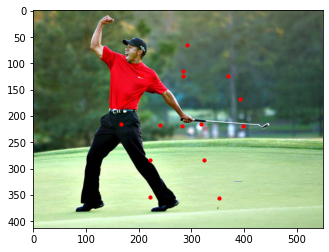

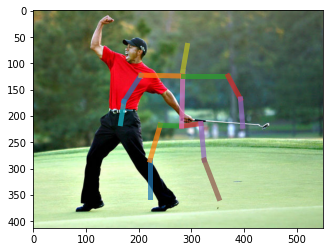

In [25]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

In [15]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.001

WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'baseline', 'model-epoch-5-loss-6.3065.h5')

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, WEIGHTS_PATH)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 6.20331717 epoch total loss 6.20331717
Trained batch 2 batch loss 5.63565397 epoch total loss 5.91948557
Trained batch 3 batch loss 5.05461645 epoch total loss 5.63119555
Trained batch 4 batch loss 5.1790452 epoch total loss 5.51815796
Trained batch 5 batch loss 5.55324697 epoch total loss 5.52517605
Trained batch 6 batch loss 6.21708488 epoch total loss 5.64049387
Trained batch 7 batch loss 6.02250433 epoch total loss 5.69506693
Trained batch 8 batch loss 6.99317789 epoch total loss 5.8573308
Trained batch 9 batch loss 6.94605 epoch total loss 5.97829962
Trained batch 10 batch loss 6.32419682 epoch total loss 6.01288891
Trained batch 11 batch loss 6.95875168 epoch total loss 6.09887695
Trained batch 12 batch loss 6.9863863 epoch total loss 6.1728363
Trained batch 13 batch loss 6.65086937 epoch total loss 6.20960808
Trained batch 14 batch loss 6.5891037 epoch total loss 6.23671484
Trained batch 15 batch loss 6.51960611 epoch tot

Trained batch 124 batch loss 6.13716555 epoch total loss 6.25297976
Trained batch 125 batch loss 6.18152094 epoch total loss 6.25240803
Trained batch 126 batch loss 6.39281273 epoch total loss 6.2535224
Trained batch 127 batch loss 6.25304794 epoch total loss 6.25351906
Trained batch 128 batch loss 6.41192389 epoch total loss 6.25475645
Trained batch 129 batch loss 6.39089155 epoch total loss 6.25581169
Trained batch 130 batch loss 6.25272751 epoch total loss 6.25578785
Trained batch 131 batch loss 6.38482189 epoch total loss 6.25677299
Trained batch 132 batch loss 6.71259594 epoch total loss 6.26022625
Trained batch 133 batch loss 7.03850079 epoch total loss 6.266078
Trained batch 134 batch loss 7.1881175 epoch total loss 6.27295876
Trained batch 135 batch loss 6.92761374 epoch total loss 6.27780819
Trained batch 136 batch loss 6.73114872 epoch total loss 6.28114128
Trained batch 137 batch loss 6.45450687 epoch total loss 6.28240681
Trained batch 138 batch loss 6.12112188 epoch total 

Trained batch 246 batch loss 6.36318874 epoch total loss 6.33167505
Trained batch 247 batch loss 6.57760715 epoch total loss 6.33267069
Trained batch 248 batch loss 6.5214653 epoch total loss 6.3334322
Trained batch 249 batch loss 6.7870822 epoch total loss 6.33525419
Trained batch 250 batch loss 6.67301369 epoch total loss 6.33660507
Trained batch 251 batch loss 6.66129208 epoch total loss 6.33789825
Trained batch 252 batch loss 6.77661228 epoch total loss 6.33963919
Trained batch 253 batch loss 6.79620838 epoch total loss 6.34144402
Trained batch 254 batch loss 6.61330223 epoch total loss 6.34251451
Trained batch 255 batch loss 6.40443563 epoch total loss 6.34275723
Trained batch 256 batch loss 6.85933495 epoch total loss 6.3447752
Trained batch 257 batch loss 6.91261101 epoch total loss 6.34698486
Trained batch 258 batch loss 6.86434555 epoch total loss 6.34899
Trained batch 259 batch loss 6.41113949 epoch total loss 6.34923
Trained batch 260 batch loss 6.35155773 epoch total loss 6

Trained batch 368 batch loss 5.96401596 epoch total loss 6.30440903
Trained batch 369 batch loss 5.96100235 epoch total loss 6.30347824
Trained batch 370 batch loss 6.06789446 epoch total loss 6.30284119
Trained batch 371 batch loss 6.16551161 epoch total loss 6.30247116
Trained batch 372 batch loss 6.41901 epoch total loss 6.30278444
Trained batch 373 batch loss 6.33689642 epoch total loss 6.30287552
Trained batch 374 batch loss 5.92474461 epoch total loss 6.3018651
Trained batch 375 batch loss 6.14893579 epoch total loss 6.30145693
Trained batch 376 batch loss 6.14068699 epoch total loss 6.30102921
Trained batch 377 batch loss 6.37523603 epoch total loss 6.30122614
Trained batch 378 batch loss 6.24079943 epoch total loss 6.30106592
Trained batch 379 batch loss 6.39462709 epoch total loss 6.30131292
Trained batch 380 batch loss 6.2648921 epoch total loss 6.30121708
Trained batch 381 batch loss 6.27779484 epoch total loss 6.30115557
Trained batch 382 batch loss 6.19753313 epoch total l

Trained batch 489 batch loss 6.8780365 epoch total loss 6.3109436
Trained batch 490 batch loss 6.3469348 epoch total loss 6.31101704
Trained batch 491 batch loss 6.12943697 epoch total loss 6.31064749
Trained batch 492 batch loss 5.60615587 epoch total loss 6.30921555
Trained batch 493 batch loss 5.88757563 epoch total loss 6.30836058
Trained batch 494 batch loss 6.77115488 epoch total loss 6.30929756
Trained batch 495 batch loss 6.30429363 epoch total loss 6.30928707
Trained batch 496 batch loss 6.23316574 epoch total loss 6.30913353
Trained batch 497 batch loss 6.50675058 epoch total loss 6.30953169
Trained batch 498 batch loss 6.22045 epoch total loss 6.30935287
Trained batch 499 batch loss 6.14275169 epoch total loss 6.30901909
Trained batch 500 batch loss 6.22963238 epoch total loss 6.3088603
Trained batch 501 batch loss 6.17170715 epoch total loss 6.3085866
Trained batch 502 batch loss 5.97154951 epoch total loss 6.30791473
Trained batch 503 batch loss 6.23877048 epoch total loss

Trained batch 611 batch loss 6.68469524 epoch total loss 6.31588697
Trained batch 612 batch loss 6.5799017 epoch total loss 6.31631851
Trained batch 613 batch loss 6.59730434 epoch total loss 6.31677723
Trained batch 614 batch loss 6.30130816 epoch total loss 6.31675196
Trained batch 615 batch loss 6.42280436 epoch total loss 6.3169241
Trained batch 616 batch loss 6.08495283 epoch total loss 6.31654787
Trained batch 617 batch loss 6.01471615 epoch total loss 6.31605864
Trained batch 618 batch loss 6.22451878 epoch total loss 6.31591034
Trained batch 619 batch loss 6.5054121 epoch total loss 6.31621647
Trained batch 620 batch loss 6.21195459 epoch total loss 6.31604815
Trained batch 621 batch loss 6.51807928 epoch total loss 6.31637383
Trained batch 622 batch loss 6.4433794 epoch total loss 6.31657791
Trained batch 623 batch loss 6.6809659 epoch total loss 6.31716251
Trained batch 624 batch loss 6.39278698 epoch total loss 6.31728363
Trained batch 625 batch loss 5.68881893 epoch total l

Trained batch 733 batch loss 6.69325972 epoch total loss 6.32073736
Trained batch 734 batch loss 6.40875721 epoch total loss 6.32085752
Trained batch 735 batch loss 6.35243082 epoch total loss 6.32090044
Trained batch 736 batch loss 6.6450758 epoch total loss 6.32134104
Trained batch 737 batch loss 6.68510771 epoch total loss 6.32183409
Trained batch 738 batch loss 7.22172117 epoch total loss 6.32305384
Trained batch 739 batch loss 6.6854248 epoch total loss 6.32354403
Trained batch 740 batch loss 6.62789774 epoch total loss 6.32395554
Trained batch 741 batch loss 6.55863333 epoch total loss 6.32427216
Trained batch 742 batch loss 6.58779812 epoch total loss 6.3246274
Trained batch 743 batch loss 6.79209042 epoch total loss 6.32525635
Trained batch 744 batch loss 6.15190172 epoch total loss 6.32502317
Trained batch 745 batch loss 6.43720055 epoch total loss 6.32517385
Trained batch 746 batch loss 6.44100094 epoch total loss 6.32532883
Trained batch 747 batch loss 5.9472456 epoch total 

Trained batch 855 batch loss 6.24319553 epoch total loss 6.31869
Trained batch 856 batch loss 6.12611771 epoch total loss 6.31846476
Trained batch 857 batch loss 6.39731836 epoch total loss 6.31855726
Trained batch 858 batch loss 6.31111813 epoch total loss 6.3185482
Trained batch 859 batch loss 6.54043961 epoch total loss 6.31880665
Trained batch 860 batch loss 6.73963213 epoch total loss 6.31929636
Trained batch 861 batch loss 6.7494297 epoch total loss 6.31979609
Trained batch 862 batch loss 6.81957 epoch total loss 6.32037544
Trained batch 863 batch loss 6.65087891 epoch total loss 6.32075834
Trained batch 864 batch loss 6.62153578 epoch total loss 6.32110643
Trained batch 865 batch loss 6.33054495 epoch total loss 6.3211174
Trained batch 866 batch loss 6.56596375 epoch total loss 6.3214
Trained batch 867 batch loss 6.41532898 epoch total loss 6.32150888
Trained batch 868 batch loss 5.83758116 epoch total loss 6.32095098
Trained batch 869 batch loss 6.44042587 epoch total loss 6.32

Trained batch 977 batch loss 5.95663166 epoch total loss 6.3307972
Trained batch 978 batch loss 6.71792889 epoch total loss 6.33119297
Trained batch 979 batch loss 6.30547714 epoch total loss 6.33116674
Trained batch 980 batch loss 6.52781391 epoch total loss 6.33136749
Trained batch 981 batch loss 6.44918346 epoch total loss 6.33148766
Trained batch 982 batch loss 6.30888748 epoch total loss 6.33146477
Trained batch 983 batch loss 6.69414234 epoch total loss 6.33183384
Trained batch 984 batch loss 6.17071199 epoch total loss 6.33167028
Trained batch 985 batch loss 6.25212765 epoch total loss 6.3315897
Trained batch 986 batch loss 6.16830349 epoch total loss 6.33142424
Trained batch 987 batch loss 5.69243336 epoch total loss 6.33077669
Trained batch 988 batch loss 6.63844347 epoch total loss 6.33108807
Trained batch 989 batch loss 6.21968174 epoch total loss 6.33097553
Trained batch 990 batch loss 6.22181749 epoch total loss 6.33086538
Trained batch 991 batch loss 6.73027897 epoch tota

Trained batch 1097 batch loss 6.57833242 epoch total loss 6.33238
Trained batch 1098 batch loss 6.15323257 epoch total loss 6.33221674
Trained batch 1099 batch loss 6.3437295 epoch total loss 6.33222723
Trained batch 1100 batch loss 6.41695547 epoch total loss 6.33230448
Trained batch 1101 batch loss 6.60808182 epoch total loss 6.33255434
Trained batch 1102 batch loss 6.36550951 epoch total loss 6.33258486
Trained batch 1103 batch loss 6.30391788 epoch total loss 6.33255863
Trained batch 1104 batch loss 6.111866 epoch total loss 6.33235836
Trained batch 1105 batch loss 6.27506065 epoch total loss 6.33230639
Trained batch 1106 batch loss 6.02607727 epoch total loss 6.33202934
Trained batch 1107 batch loss 5.6722765 epoch total loss 6.33143377
Trained batch 1108 batch loss 6.07277584 epoch total loss 6.3312
Trained batch 1109 batch loss 6.49679 epoch total loss 6.33134937
Trained batch 1110 batch loss 6.27425623 epoch total loss 6.33129787
Trained batch 1111 batch loss 6.39429045 epoch t

Trained batch 1217 batch loss 6.39868355 epoch total loss 6.34087706
Trained batch 1218 batch loss 6.34518433 epoch total loss 6.34088087
Trained batch 1219 batch loss 6.28401661 epoch total loss 6.34083414
Trained batch 1220 batch loss 6.59751272 epoch total loss 6.3410449
Trained batch 1221 batch loss 6.5544672 epoch total loss 6.34122
Trained batch 1222 batch loss 6.10199499 epoch total loss 6.34102392
Trained batch 1223 batch loss 5.93895674 epoch total loss 6.34069538
Trained batch 1224 batch loss 5.46186972 epoch total loss 6.33997726
Trained batch 1225 batch loss 6.38591719 epoch total loss 6.34001493
Trained batch 1226 batch loss 6.25606585 epoch total loss 6.33994627
Trained batch 1227 batch loss 6.37590122 epoch total loss 6.33997536
Trained batch 1228 batch loss 6.52777624 epoch total loss 6.34012842
Trained batch 1229 batch loss 6.4761405 epoch total loss 6.34023905
Trained batch 1230 batch loss 6.36263037 epoch total loss 6.34025717
Trained batch 1231 batch loss 6.2749157 

Trained batch 1337 batch loss 6.40639734 epoch total loss 6.34327078
Trained batch 1338 batch loss 6.67146969 epoch total loss 6.34351635
Trained batch 1339 batch loss 5.96586752 epoch total loss 6.34323454
Trained batch 1340 batch loss 6.20371437 epoch total loss 6.34313059
Trained batch 1341 batch loss 6.55314827 epoch total loss 6.34328699
Trained batch 1342 batch loss 6.52312374 epoch total loss 6.34342098
Trained batch 1343 batch loss 6.55256462 epoch total loss 6.34357691
Trained batch 1344 batch loss 7.0598135 epoch total loss 6.34410954
Trained batch 1345 batch loss 6.7742753 epoch total loss 6.34442949
Trained batch 1346 batch loss 6.50919294 epoch total loss 6.34455156
Trained batch 1347 batch loss 5.92512035 epoch total loss 6.34424
Trained batch 1348 batch loss 5.69774628 epoch total loss 6.34376
Trained batch 1349 batch loss 5.70379925 epoch total loss 6.34328604
Trained batch 1350 batch loss 6.01257229 epoch total loss 6.34304094
Trained batch 1351 batch loss 6.4798522 ep

Validated batch 114 batch loss 5.49505234
Validated batch 115 batch loss 6.53619242
Validated batch 116 batch loss 6.27714109
Validated batch 117 batch loss 5.94017696
Validated batch 118 batch loss 6.33169031
Validated batch 119 batch loss 6.22513103
Validated batch 120 batch loss 6.03853083
Validated batch 121 batch loss 6.69790459
Validated batch 122 batch loss 6.37824106
Validated batch 123 batch loss 6.23698044
Validated batch 124 batch loss 6.46568489
Validated batch 125 batch loss 6.53263474
Validated batch 126 batch loss 6.2525568
Validated batch 127 batch loss 6.3621664
Validated batch 128 batch loss 6.07325554
Validated batch 129 batch loss 6.63271904
Validated batch 130 batch loss 6.6611557
Validated batch 131 batch loss 6.32195616
Validated batch 132 batch loss 6.20768166
Validated batch 133 batch loss 5.9404397
Validated batch 134 batch loss 6.26637745
Validated batch 135 batch loss 6.2621088
Validated batch 136 batch loss 6.34793
Validated batch 137 batch loss 6.39548874


Trained batch 77 batch loss 6.25647211 epoch total loss 6.37431097
Trained batch 78 batch loss 6.20537186 epoch total loss 6.37214518
Trained batch 79 batch loss 6.32106447 epoch total loss 6.37149858
Trained batch 80 batch loss 6.23941422 epoch total loss 6.3698473
Trained batch 81 batch loss 6.19494963 epoch total loss 6.36768866
Trained batch 82 batch loss 6.22357559 epoch total loss 6.36593103
Trained batch 83 batch loss 6.30525351 epoch total loss 6.3652
Trained batch 84 batch loss 6.32904625 epoch total loss 6.36476946
Trained batch 85 batch loss 6.17477751 epoch total loss 6.36253452
Trained batch 86 batch loss 6.16313934 epoch total loss 6.36021614
Trained batch 87 batch loss 6.88912535 epoch total loss 6.36629534
Trained batch 88 batch loss 7.17057371 epoch total loss 6.37543488
Trained batch 89 batch loss 6.98446941 epoch total loss 6.38227844
Trained batch 90 batch loss 6.2014246 epoch total loss 6.38026857
Trained batch 91 batch loss 6.53427219 epoch total loss 6.38196135
T

Trained batch 199 batch loss 6.42008209 epoch total loss 6.36979389
Trained batch 200 batch loss 6.63390446 epoch total loss 6.37111473
Trained batch 201 batch loss 6.45813227 epoch total loss 6.37154722
Trained batch 202 batch loss 6.20373631 epoch total loss 6.37071657
Trained batch 203 batch loss 6.33723354 epoch total loss 6.37055206
Trained batch 204 batch loss 5.84364748 epoch total loss 6.36796904
Trained batch 205 batch loss 6.0526371 epoch total loss 6.36643076
Trained batch 206 batch loss 6.58205652 epoch total loss 6.36747742
Trained batch 207 batch loss 6.44225168 epoch total loss 6.36783838
Trained batch 208 batch loss 6.63658571 epoch total loss 6.36913061
Trained batch 209 batch loss 6.92917776 epoch total loss 6.37181044
Trained batch 210 batch loss 7.02457714 epoch total loss 6.37491846
Trained batch 211 batch loss 6.83318901 epoch total loss 6.37709045
Trained batch 212 batch loss 6.88758659 epoch total loss 6.379498
Trained batch 213 batch loss 5.90995789 epoch total

Trained batch 321 batch loss 6.89275074 epoch total loss 6.36202955
Trained batch 322 batch loss 6.73120785 epoch total loss 6.36317587
Trained batch 323 batch loss 6.6231575 epoch total loss 6.36398029
Trained batch 324 batch loss 6.65525627 epoch total loss 6.36487961
Trained batch 325 batch loss 6.69022655 epoch total loss 6.36588049
Trained batch 326 batch loss 6.48432255 epoch total loss 6.36624384
Trained batch 327 batch loss 6.46200228 epoch total loss 6.36653662
Trained batch 328 batch loss 6.3990407 epoch total loss 6.36663532
Trained batch 329 batch loss 6.16294813 epoch total loss 6.36601591
Trained batch 330 batch loss 6.15259647 epoch total loss 6.36536884
Trained batch 331 batch loss 6.44242239 epoch total loss 6.36560154
Trained batch 332 batch loss 5.97115326 epoch total loss 6.36441374
Trained batch 333 batch loss 6.04057789 epoch total loss 6.36344099
Trained batch 334 batch loss 6.72764063 epoch total loss 6.36453104
Trained batch 335 batch loss 6.37968683 epoch tota

Trained batch 443 batch loss 6.73144579 epoch total loss 6.3280673
Trained batch 444 batch loss 7.05327225 epoch total loss 6.32970047
Trained batch 445 batch loss 6.71564102 epoch total loss 6.33056736
Trained batch 446 batch loss 6.37673 epoch total loss 6.33067083
Trained batch 447 batch loss 6.5128355 epoch total loss 6.33107853
Trained batch 448 batch loss 6.58348656 epoch total loss 6.33164215
Trained batch 449 batch loss 6.44131899 epoch total loss 6.33188677
Trained batch 450 batch loss 6.53868961 epoch total loss 6.33234596
Trained batch 451 batch loss 6.68284893 epoch total loss 6.33312321
Trained batch 452 batch loss 6.29747391 epoch total loss 6.33304405
Trained batch 453 batch loss 6.50570393 epoch total loss 6.33342505
Trained batch 454 batch loss 6.58949184 epoch total loss 6.33398914
Trained batch 455 batch loss 6.39131165 epoch total loss 6.33411551
Trained batch 456 batch loss 6.36783 epoch total loss 6.33418941
Trained batch 457 batch loss 6.38355827 epoch total loss

Trained batch 565 batch loss 6.58211517 epoch total loss 6.35850525
Trained batch 566 batch loss 6.32364082 epoch total loss 6.35844374
Trained batch 567 batch loss 6.05878687 epoch total loss 6.3579154
Trained batch 568 batch loss 6.23373556 epoch total loss 6.35769653
Trained batch 569 batch loss 6.07178974 epoch total loss 6.35719395
Trained batch 570 batch loss 5.67102623 epoch total loss 6.35599041
Trained batch 571 batch loss 6.20749617 epoch total loss 6.35573053
Trained batch 572 batch loss 6.37005854 epoch total loss 6.35575581
Trained batch 573 batch loss 6.44024849 epoch total loss 6.35590315
Trained batch 574 batch loss 6.23262739 epoch total loss 6.3556881
Trained batch 575 batch loss 6.22681522 epoch total loss 6.35546398
Trained batch 576 batch loss 6.23108578 epoch total loss 6.35524845
Trained batch 577 batch loss 6.21328402 epoch total loss 6.3550024
Trained batch 578 batch loss 6.01550579 epoch total loss 6.35441542
Trained batch 579 batch loss 6.26697683 epoch total

Trained batch 687 batch loss 6.2549 epoch total loss 6.34457397
Trained batch 688 batch loss 6.27792311 epoch total loss 6.3444767
Trained batch 689 batch loss 6.58253193 epoch total loss 6.34482241
Trained batch 690 batch loss 7.0676446 epoch total loss 6.34587
Trained batch 691 batch loss 7.18940639 epoch total loss 6.34709072
Trained batch 692 batch loss 6.98283768 epoch total loss 6.34800959
Trained batch 693 batch loss 6.58110571 epoch total loss 6.34834623
Trained batch 694 batch loss 6.19878674 epoch total loss 6.34813
Trained batch 695 batch loss 6.62753 epoch total loss 6.3485322
Trained batch 696 batch loss 6.51236486 epoch total loss 6.34876728
Trained batch 697 batch loss 6.47772646 epoch total loss 6.34895229
Trained batch 698 batch loss 6.59419584 epoch total loss 6.34930372
Trained batch 699 batch loss 7.0940814 epoch total loss 6.35036945
Trained batch 700 batch loss 6.84505415 epoch total loss 6.35107613
Trained batch 701 batch loss 6.08587599 epoch total loss 6.350697

Trained batch 809 batch loss 6.07755 epoch total loss 6.34532547
Trained batch 810 batch loss 6.64191771 epoch total loss 6.34569168
Trained batch 811 batch loss 6.19339514 epoch total loss 6.34550381
Trained batch 812 batch loss 6.31571865 epoch total loss 6.34546757
Trained batch 813 batch loss 6.16748905 epoch total loss 6.3452487
Trained batch 814 batch loss 6.47554588 epoch total loss 6.34540844
Trained batch 815 batch loss 6.15110397 epoch total loss 6.34517
Trained batch 816 batch loss 5.74493551 epoch total loss 6.34443474
Trained batch 817 batch loss 6.26040554 epoch total loss 6.34433174
Trained batch 818 batch loss 6.38092422 epoch total loss 6.34437609
Trained batch 819 batch loss 6.28815937 epoch total loss 6.34430742
Trained batch 820 batch loss 6.2540369 epoch total loss 6.34419727
Trained batch 821 batch loss 6.59261703 epoch total loss 6.3445
Trained batch 822 batch loss 6.14392471 epoch total loss 6.34425592
Trained batch 823 batch loss 6.31089592 epoch total loss 6.3

Trained batch 931 batch loss 5.95520306 epoch total loss 6.33937597
Trained batch 932 batch loss 6.06980801 epoch total loss 6.33908653
Trained batch 933 batch loss 6.47753239 epoch total loss 6.33923531
Trained batch 934 batch loss 6.57298517 epoch total loss 6.33948517
Trained batch 935 batch loss 6.65732431 epoch total loss 6.33982515
Trained batch 936 batch loss 6.50310659 epoch total loss 6.3399992
Trained batch 937 batch loss 6.52469063 epoch total loss 6.34019661
Trained batch 938 batch loss 6.53491259 epoch total loss 6.34040451
Trained batch 939 batch loss 6.59783554 epoch total loss 6.34067822
Trained batch 940 batch loss 6.49145222 epoch total loss 6.34083843
Trained batch 941 batch loss 6.75101185 epoch total loss 6.34127426
Trained batch 942 batch loss 6.42952871 epoch total loss 6.3413682
Trained batch 943 batch loss 6.33763885 epoch total loss 6.34136391
Trained batch 944 batch loss 6.56179857 epoch total loss 6.34159756
Trained batch 945 batch loss 6.37139511 epoch tota

Trained batch 1052 batch loss 6.63562679 epoch total loss 6.33880615
Trained batch 1053 batch loss 6.83628893 epoch total loss 6.33927917
Trained batch 1054 batch loss 6.92340183 epoch total loss 6.33983326
Trained batch 1055 batch loss 6.66509151 epoch total loss 6.3401413
Trained batch 1056 batch loss 6.28975821 epoch total loss 6.34009361
Trained batch 1057 batch loss 6.65419102 epoch total loss 6.34039068
Trained batch 1058 batch loss 6.84899187 epoch total loss 6.34087133
Trained batch 1059 batch loss 6.37327576 epoch total loss 6.34090185
Trained batch 1060 batch loss 6.53106689 epoch total loss 6.34108162
Trained batch 1061 batch loss 5.97434807 epoch total loss 6.34073544
Trained batch 1062 batch loss 5.70017433 epoch total loss 6.34013271
Trained batch 1063 batch loss 6.04028225 epoch total loss 6.33985
Trained batch 1064 batch loss 6.0840621 epoch total loss 6.33960962
Trained batch 1065 batch loss 6.30632 epoch total loss 6.33957815
Trained batch 1066 batch loss 6.05320406 e

Trained batch 1172 batch loss 5.49056864 epoch total loss 6.33468437
Trained batch 1173 batch loss 5.79454231 epoch total loss 6.33422375
Trained batch 1174 batch loss 6.3741641 epoch total loss 6.3342576
Trained batch 1175 batch loss 6.49806547 epoch total loss 6.33439684
Trained batch 1176 batch loss 6.31528807 epoch total loss 6.3343811
Trained batch 1177 batch loss 6.35213566 epoch total loss 6.33439589
Trained batch 1178 batch loss 6.13387918 epoch total loss 6.33422565
Trained batch 1179 batch loss 5.85453796 epoch total loss 6.33381891
Trained batch 1180 batch loss 6.30416536 epoch total loss 6.33379364
Trained batch 1181 batch loss 6.45031214 epoch total loss 6.33389235
Trained batch 1182 batch loss 6.40162897 epoch total loss 6.33394957
Trained batch 1183 batch loss 6.2708025 epoch total loss 6.33389664
Trained batch 1184 batch loss 6.31298256 epoch total loss 6.33387899
Trained batch 1185 batch loss 6.22364426 epoch total loss 6.33378553
Trained batch 1186 batch loss 6.151226

Trained batch 1292 batch loss 5.88875437 epoch total loss 6.3344264
Trained batch 1293 batch loss 5.32998371 epoch total loss 6.33364964
Trained batch 1294 batch loss 6.29984522 epoch total loss 6.33362341
Trained batch 1295 batch loss 6.16142702 epoch total loss 6.33349037
Trained batch 1296 batch loss 6.24322796 epoch total loss 6.33342075
Trained batch 1297 batch loss 6.44703341 epoch total loss 6.33350849
Trained batch 1298 batch loss 6.47266 epoch total loss 6.33361578
Trained batch 1299 batch loss 6.18288326 epoch total loss 6.33349943
Trained batch 1300 batch loss 6.04000425 epoch total loss 6.33327389
Trained batch 1301 batch loss 6.72702026 epoch total loss 6.3335762
Trained batch 1302 batch loss 6.63365507 epoch total loss 6.33380651
Trained batch 1303 batch loss 6.82669735 epoch total loss 6.33418512
Trained batch 1304 batch loss 6.89432716 epoch total loss 6.33461475
Trained batch 1305 batch loss 6.86269093 epoch total loss 6.33501911
Trained batch 1306 batch loss 6.2625012

Validated batch 39 batch loss 6.29822254
Validated batch 40 batch loss 6.33738136
Validated batch 41 batch loss 6.36584377
Validated batch 42 batch loss 6.13487911
Validated batch 43 batch loss 6.41773462
Validated batch 44 batch loss 5.97510338
Validated batch 45 batch loss 6.57856512
Validated batch 46 batch loss 6.60533381
Validated batch 47 batch loss 6.53175116
Validated batch 48 batch loss 6.25398207
Validated batch 49 batch loss 6.10631847
Validated batch 50 batch loss 6.03136921
Validated batch 51 batch loss 6.09956789
Validated batch 52 batch loss 6.32905054
Validated batch 53 batch loss 6.12806511
Validated batch 54 batch loss 6.32467079
Validated batch 55 batch loss 6.44334888
Validated batch 56 batch loss 6.28068304
Validated batch 57 batch loss 6.1364069
Validated batch 58 batch loss 5.77839899
Validated batch 59 batch loss 6.63824511
Validated batch 60 batch loss 6.20916
Validated batch 61 batch loss 6.29604959
Validated batch 62 batch loss 6.20710373
Validated batch 63 b

Trained batch 31 batch loss 6.22100878 epoch total loss 6.19775057
Trained batch 32 batch loss 6.72512674 epoch total loss 6.21423101
Trained batch 33 batch loss 6.51177454 epoch total loss 6.22324753
Trained batch 34 batch loss 6.36806393 epoch total loss 6.22750664
Trained batch 35 batch loss 6.51255751 epoch total loss 6.23565102
Trained batch 36 batch loss 6.37916279 epoch total loss 6.23963737
Trained batch 37 batch loss 5.51153421 epoch total loss 6.21995926
Trained batch 38 batch loss 6.12379789 epoch total loss 6.21742868
Trained batch 39 batch loss 6.29112434 epoch total loss 6.21931791
Trained batch 40 batch loss 6.41682863 epoch total loss 6.22425556
Trained batch 41 batch loss 6.47630358 epoch total loss 6.23040342
Trained batch 42 batch loss 6.0925 epoch total loss 6.22712
Trained batch 43 batch loss 5.98201942 epoch total loss 6.22142
Trained batch 44 batch loss 6.1154685 epoch total loss 6.21901226
Trained batch 45 batch loss 6.24076462 epoch total loss 6.2194953
Trained

Trained batch 154 batch loss 4.84293699 epoch total loss 6.24578381
Trained batch 155 batch loss 5.95880604 epoch total loss 6.24393225
Trained batch 156 batch loss 6.54119635 epoch total loss 6.24583769
Trained batch 157 batch loss 7.15327787 epoch total loss 6.25161743
Trained batch 158 batch loss 6.46029186 epoch total loss 6.25293827
Trained batch 159 batch loss 5.9171 epoch total loss 6.25082588
Trained batch 160 batch loss 6.27464914 epoch total loss 6.25097513
Trained batch 161 batch loss 6.43965435 epoch total loss 6.25214672
Trained batch 162 batch loss 6.44780111 epoch total loss 6.25335455
Trained batch 163 batch loss 6.47173452 epoch total loss 6.25469446
Trained batch 164 batch loss 6.36817789 epoch total loss 6.25538683
Trained batch 165 batch loss 6.47939253 epoch total loss 6.25674438
Trained batch 166 batch loss 6.5772624 epoch total loss 6.2586751
Trained batch 167 batch loss 6.40802288 epoch total loss 6.25956964
Trained batch 168 batch loss 6.64439821 epoch total lo

Trained batch 276 batch loss 6.57111835 epoch total loss 6.28220224
Trained batch 277 batch loss 6.46379185 epoch total loss 6.28285742
Trained batch 278 batch loss 6.51482105 epoch total loss 6.28369188
Trained batch 279 batch loss 6.49700212 epoch total loss 6.28445625
Trained batch 280 batch loss 6.39632511 epoch total loss 6.28485584
Trained batch 281 batch loss 6.30790615 epoch total loss 6.28493786
Trained batch 282 batch loss 6.09058475 epoch total loss 6.28424835
Trained batch 283 batch loss 5.89243698 epoch total loss 6.28286409
Trained batch 284 batch loss 6.27608395 epoch total loss 6.28284025
Trained batch 285 batch loss 6.28936768 epoch total loss 6.28286314
Trained batch 286 batch loss 6.1130476 epoch total loss 6.28226948
Trained batch 287 batch loss 6.31820822 epoch total loss 6.28239441
Trained batch 288 batch loss 6.21415806 epoch total loss 6.28215742
Trained batch 289 batch loss 6.30765 epoch total loss 6.28224564
Trained batch 290 batch loss 6.45667219 epoch total 

Trained batch 398 batch loss 6.23039341 epoch total loss 6.2879343
Trained batch 399 batch loss 6.11421776 epoch total loss 6.28749895
Trained batch 400 batch loss 6.02527 epoch total loss 6.28684378
Trained batch 401 batch loss 6.06936884 epoch total loss 6.28630161
Trained batch 402 batch loss 6.08769512 epoch total loss 6.28580713
Trained batch 403 batch loss 6.19791937 epoch total loss 6.28558922
Trained batch 404 batch loss 6.09877253 epoch total loss 6.28512716
Trained batch 405 batch loss 6.05756426 epoch total loss 6.28456545
Trained batch 406 batch loss 5.92335606 epoch total loss 6.28367567
Trained batch 407 batch loss 6.25457764 epoch total loss 6.28360462
Trained batch 408 batch loss 6.02479219 epoch total loss 6.28297043
Trained batch 409 batch loss 6.26552343 epoch total loss 6.28292799
Trained batch 410 batch loss 5.81693459 epoch total loss 6.28179121
Trained batch 411 batch loss 6.55080748 epoch total loss 6.28244591
Trained batch 412 batch loss 6.3969717 epoch total l

Trained batch 520 batch loss 6.7924695 epoch total loss 6.30378485
Trained batch 521 batch loss 6.68333292 epoch total loss 6.30451298
Trained batch 522 batch loss 6.40553331 epoch total loss 6.30470657
Trained batch 523 batch loss 6.59696102 epoch total loss 6.30526543
Trained batch 524 batch loss 6.48870564 epoch total loss 6.30561543
Trained batch 525 batch loss 6.68767929 epoch total loss 6.30634356
Trained batch 526 batch loss 6.53996801 epoch total loss 6.30678797
Trained batch 527 batch loss 6.47091675 epoch total loss 6.30709934
Trained batch 528 batch loss 6.57825375 epoch total loss 6.3076129
Trained batch 529 batch loss 6.73975801 epoch total loss 6.30842972
Trained batch 530 batch loss 6.46103716 epoch total loss 6.30871773
Trained batch 531 batch loss 6.32898474 epoch total loss 6.30875587
Trained batch 532 batch loss 6.59856033 epoch total loss 6.3093009
Trained batch 533 batch loss 6.40317822 epoch total loss 6.30947685
Trained batch 534 batch loss 6.40627956 epoch total

Trained batch 642 batch loss 6.31996822 epoch total loss 6.3092494
Trained batch 643 batch loss 6.28000546 epoch total loss 6.3092041
Trained batch 644 batch loss 6.69378614 epoch total loss 6.3098011
Trained batch 645 batch loss 6.3223033 epoch total loss 6.30982065
Trained batch 646 batch loss 6.4451561 epoch total loss 6.31003
Trained batch 647 batch loss 6.58775759 epoch total loss 6.31045914
Trained batch 648 batch loss 6.25559902 epoch total loss 6.31037426
Trained batch 649 batch loss 5.9431181 epoch total loss 6.30980825
Trained batch 650 batch loss 6.50119495 epoch total loss 6.31010294
Trained batch 651 batch loss 5.52850103 epoch total loss 6.30890179
Trained batch 652 batch loss 5.69071579 epoch total loss 6.30795431
Trained batch 653 batch loss 5.91766739 epoch total loss 6.30735636
Trained batch 654 batch loss 6.65140247 epoch total loss 6.30788231
Trained batch 655 batch loss 6.20544291 epoch total loss 6.30772591
Trained batch 656 batch loss 6.70425177 epoch total loss 

Trained batch 764 batch loss 6.03950071 epoch total loss 6.32057285
Trained batch 765 batch loss 6.26723385 epoch total loss 6.32050276
Trained batch 766 batch loss 6.2636981 epoch total loss 6.32042837
Trained batch 767 batch loss 6.5361619 epoch total loss 6.32070971
Trained batch 768 batch loss 6.07727432 epoch total loss 6.32039261
Trained batch 769 batch loss 5.34527826 epoch total loss 6.3191247
Trained batch 770 batch loss 5.61644888 epoch total loss 6.31821156
Trained batch 771 batch loss 6.06578112 epoch total loss 6.31788445
Trained batch 772 batch loss 6.05271578 epoch total loss 6.31754112
Trained batch 773 batch loss 5.78953886 epoch total loss 6.31685781
Trained batch 774 batch loss 6.31914043 epoch total loss 6.31686115
Trained batch 775 batch loss 6.15957642 epoch total loss 6.3166585
Trained batch 776 batch loss 5.96371555 epoch total loss 6.31620359
Trained batch 777 batch loss 6.50018024 epoch total loss 6.31644
Trained batch 778 batch loss 6.27050161 epoch total los

Trained batch 886 batch loss 5.89903784 epoch total loss 6.32440186
Trained batch 887 batch loss 6.39938593 epoch total loss 6.32448626
Trained batch 888 batch loss 6.1262393 epoch total loss 6.3242631
Trained batch 889 batch loss 6.19361 epoch total loss 6.32411671
Trained batch 890 batch loss 6.43964052 epoch total loss 6.32424641
Trained batch 891 batch loss 6.38181591 epoch total loss 6.32431078
Trained batch 892 batch loss 5.74802876 epoch total loss 6.32366467
Trained batch 893 batch loss 5.16952085 epoch total loss 6.32237244
Trained batch 894 batch loss 5.84952831 epoch total loss 6.32184362
Trained batch 895 batch loss 5.67315388 epoch total loss 6.32111883
Trained batch 896 batch loss 6.00195169 epoch total loss 6.32076263
Trained batch 897 batch loss 6.39067459 epoch total loss 6.32084036
Trained batch 898 batch loss 6.10948 epoch total loss 6.3206048
Trained batch 899 batch loss 6.22144938 epoch total loss 6.32049513
Trained batch 900 batch loss 6.29383564 epoch total loss 

Trained batch 1008 batch loss 6.48114586 epoch total loss 6.31613255
Trained batch 1009 batch loss 6.19977808 epoch total loss 6.31601715
Trained batch 1010 batch loss 6.32956696 epoch total loss 6.3160305
Trained batch 1011 batch loss 5.87735653 epoch total loss 6.31559658
Trained batch 1012 batch loss 6.08260918 epoch total loss 6.31536627
Trained batch 1013 batch loss 6.35434914 epoch total loss 6.31540489
Trained batch 1014 batch loss 6.34800959 epoch total loss 6.31543732
Trained batch 1015 batch loss 6.89276791 epoch total loss 6.31600618
Trained batch 1016 batch loss 7.01986217 epoch total loss 6.31669903
Trained batch 1017 batch loss 7.0467968 epoch total loss 6.31741667
Trained batch 1018 batch loss 6.50772953 epoch total loss 6.31760406
Trained batch 1019 batch loss 6.48154354 epoch total loss 6.31776476
Trained batch 1020 batch loss 6.56425095 epoch total loss 6.31800652
Trained batch 1021 batch loss 6.80816936 epoch total loss 6.31848669
Trained batch 1022 batch loss 6.6395

Trained batch 1128 batch loss 6.47063684 epoch total loss 6.31417036
Trained batch 1129 batch loss 6.32234049 epoch total loss 6.31417751
Trained batch 1130 batch loss 6.36216784 epoch total loss 6.31422043
Trained batch 1131 batch loss 5.54839802 epoch total loss 6.31354284
Trained batch 1132 batch loss 5.80283356 epoch total loss 6.31309175
Trained batch 1133 batch loss 5.66614294 epoch total loss 6.3125205
Trained batch 1134 batch loss 5.82504034 epoch total loss 6.31209087
Trained batch 1135 batch loss 6.08094406 epoch total loss 6.31188726
Trained batch 1136 batch loss 6.35727072 epoch total loss 6.31192732
Trained batch 1137 batch loss 6.49802685 epoch total loss 6.31209135
Trained batch 1138 batch loss 6.40125418 epoch total loss 6.31216955
Trained batch 1139 batch loss 6.46702433 epoch total loss 6.31230545
Trained batch 1140 batch loss 6.73075056 epoch total loss 6.31267262
Trained batch 1141 batch loss 6.58141708 epoch total loss 6.31290817
Trained batch 1142 batch loss 6.160

Trained batch 1248 batch loss 6.44403362 epoch total loss 6.32406139
Trained batch 1249 batch loss 6.47973156 epoch total loss 6.32418585
Trained batch 1250 batch loss 6.47732449 epoch total loss 6.3243084
Trained batch 1251 batch loss 6.30029774 epoch total loss 6.32428932
Trained batch 1252 batch loss 6.13513279 epoch total loss 6.32413864
Trained batch 1253 batch loss 6.56492 epoch total loss 6.32433081
Trained batch 1254 batch loss 6.22816038 epoch total loss 6.32425356
Trained batch 1255 batch loss 6.55467176 epoch total loss 6.32443762
Trained batch 1256 batch loss 6.5338397 epoch total loss 6.32460403
Trained batch 1257 batch loss 6.6421423 epoch total loss 6.32485676
Trained batch 1258 batch loss 6.74862623 epoch total loss 6.32519341
Trained batch 1259 batch loss 6.44274664 epoch total loss 6.32528687
Trained batch 1260 batch loss 6.31319427 epoch total loss 6.32527685
Trained batch 1261 batch loss 6.32564783 epoch total loss 6.32527733
Trained batch 1262 batch loss 6.227 epoc

Trained batch 1368 batch loss 5.99888945 epoch total loss 6.32533789
Trained batch 1369 batch loss 6.33061123 epoch total loss 6.32534218
Trained batch 1370 batch loss 6.29343176 epoch total loss 6.32531881
Trained batch 1371 batch loss 6.45015621 epoch total loss 6.32541
Trained batch 1372 batch loss 6.69092751 epoch total loss 6.32567644
Trained batch 1373 batch loss 6.47104 epoch total loss 6.3257823
Trained batch 1374 batch loss 5.9243474 epoch total loss 6.32549047
Trained batch 1375 batch loss 6.34691572 epoch total loss 6.32550573
Trained batch 1376 batch loss 6.05304575 epoch total loss 6.32530737
Trained batch 1377 batch loss 6.06564236 epoch total loss 6.32511854
Trained batch 1378 batch loss 6.32646751 epoch total loss 6.3251195
Trained batch 1379 batch loss 6.60619402 epoch total loss 6.32532358
Trained batch 1380 batch loss 6.50780678 epoch total loss 6.32545567
Trained batch 1381 batch loss 6.63886833 epoch total loss 6.32568264
Trained batch 1382 batch loss 6.84936762 ep

Validated batch 165 batch loss 6.33793736
Validated batch 166 batch loss 6.71676
Validated batch 167 batch loss 6.40883827
Validated batch 168 batch loss 6.50753164
Validated batch 169 batch loss 6.32195377
Validated batch 170 batch loss 6.54456234
Validated batch 171 batch loss 6.41642952
Validated batch 172 batch loss 6.65952
Validated batch 173 batch loss 6.8176
Validated batch 174 batch loss 5.99079323
Validated batch 175 batch loss 6.52152
Validated batch 176 batch loss 6.39187098
Validated batch 177 batch loss 6.34656334
Validated batch 178 batch loss 6.4096117
Validated batch 179 batch loss 6.00911283
Validated batch 180 batch loss 6.01176071
Validated batch 181 batch loss 6.46126
Validated batch 182 batch loss 6.29629278
Validated batch 183 batch loss 6.70216227
Validated batch 184 batch loss 6.24603796
Validated batch 185 batch loss 3.20247078
Epoch 3 val loss 6.288505554199219
Model /aiffel/aiffel/mpii/baseline/model-epoch-3-loss-6.2885.h5 saved.
Start epoch 4 with learning r

Trained batch 109 batch loss 6.60528851 epoch total loss 6.35558367
Trained batch 110 batch loss 6.9448452 epoch total loss 6.36094046
Trained batch 111 batch loss 6.83773899 epoch total loss 6.36523581
Trained batch 112 batch loss 6.95409107 epoch total loss 6.37049389
Trained batch 113 batch loss 6.63711596 epoch total loss 6.37285328
Trained batch 114 batch loss 6.54404879 epoch total loss 6.37435532
Trained batch 115 batch loss 6.24129725 epoch total loss 6.37319803
Trained batch 116 batch loss 6.56268311 epoch total loss 6.37483168
Trained batch 117 batch loss 6.31114674 epoch total loss 6.37428761
Trained batch 118 batch loss 6.01394081 epoch total loss 6.37123346
Trained batch 119 batch loss 6.17157269 epoch total loss 6.36955547
Trained batch 120 batch loss 6.46120548 epoch total loss 6.37031889
Trained batch 121 batch loss 6.11210537 epoch total loss 6.36818504
Trained batch 122 batch loss 6.22278547 epoch total loss 6.36699343
Trained batch 123 batch loss 6.09506369 epoch tot

Trained batch 231 batch loss 5.69886923 epoch total loss 6.3526454
Trained batch 232 batch loss 6.44862795 epoch total loss 6.35305882
Trained batch 233 batch loss 6.15525293 epoch total loss 6.35221
Trained batch 234 batch loss 6.69948 epoch total loss 6.35369396
Trained batch 235 batch loss 6.40448809 epoch total loss 6.35391045
Trained batch 236 batch loss 6.20888233 epoch total loss 6.3532958
Trained batch 237 batch loss 5.74972534 epoch total loss 6.35074902
Trained batch 238 batch loss 6.32548189 epoch total loss 6.35064268
Trained batch 239 batch loss 6.56132317 epoch total loss 6.35152435
Trained batch 240 batch loss 6.21581936 epoch total loss 6.35095882
Trained batch 241 batch loss 6.46862125 epoch total loss 6.35144711
Trained batch 242 batch loss 6.07743 epoch total loss 6.35031462
Trained batch 243 batch loss 5.8973875 epoch total loss 6.34845066
Trained batch 244 batch loss 5.6014657 epoch total loss 6.34538889
Trained batch 245 batch loss 5.85055876 epoch total loss 6.34

Trained batch 353 batch loss 6.23530293 epoch total loss 6.32293653
Trained batch 354 batch loss 6.39779758 epoch total loss 6.32314777
Trained batch 355 batch loss 6.4286437 epoch total loss 6.32344484
Trained batch 356 batch loss 6.56557941 epoch total loss 6.32412529
Trained batch 357 batch loss 6.28289795 epoch total loss 6.32401037
Trained batch 358 batch loss 6.23792839 epoch total loss 6.32377
Trained batch 359 batch loss 6.41838503 epoch total loss 6.32403374
Trained batch 360 batch loss 6.36779785 epoch total loss 6.32415485
Trained batch 361 batch loss 6.50587845 epoch total loss 6.32465839
Trained batch 362 batch loss 6.45283031 epoch total loss 6.32501268
Trained batch 363 batch loss 6.50766039 epoch total loss 6.32551527
Trained batch 364 batch loss 6.46701336 epoch total loss 6.32590437
Trained batch 365 batch loss 6.20177269 epoch total loss 6.32556391
Trained batch 366 batch loss 6.1559782 epoch total loss 6.32510042
Trained batch 367 batch loss 5.72435141 epoch total l

Trained batch 475 batch loss 6.30552769 epoch total loss 6.3222065
Trained batch 476 batch loss 6.00077057 epoch total loss 6.3215313
Trained batch 477 batch loss 5.92434645 epoch total loss 6.32069826
Trained batch 478 batch loss 6.20872974 epoch total loss 6.32046413
Trained batch 479 batch loss 6.42324352 epoch total loss 6.32067919
Trained batch 480 batch loss 6.28305912 epoch total loss 6.32060051
Trained batch 481 batch loss 6.23620319 epoch total loss 6.32042456
Trained batch 482 batch loss 6.50179768 epoch total loss 6.32080078
Trained batch 483 batch loss 6.75043583 epoch total loss 6.32169056
Trained batch 484 batch loss 6.13958073 epoch total loss 6.32131433
Trained batch 485 batch loss 6.43026209 epoch total loss 6.32153893
Trained batch 486 batch loss 6.37129116 epoch total loss 6.32164145
Trained batch 487 batch loss 6.6827631 epoch total loss 6.32238293
Trained batch 488 batch loss 6.13712597 epoch total loss 6.32200336
Trained batch 489 batch loss 6.00054455 epoch total

Trained batch 597 batch loss 6.90792847 epoch total loss 6.31003428
Trained batch 598 batch loss 6.6729784 epoch total loss 6.31064129
Trained batch 599 batch loss 6.61266232 epoch total loss 6.31114531
Trained batch 600 batch loss 6.38314199 epoch total loss 6.31126499
Trained batch 601 batch loss 6.36557341 epoch total loss 6.31135511
Trained batch 602 batch loss 6.66350365 epoch total loss 6.31194
Trained batch 603 batch loss 6.2204957 epoch total loss 6.31178856
Trained batch 604 batch loss 6.69706297 epoch total loss 6.31242657
Trained batch 605 batch loss 6.48576689 epoch total loss 6.31271315
Trained batch 606 batch loss 6.34568548 epoch total loss 6.31276751
Trained batch 607 batch loss 6.30143929 epoch total loss 6.31274891
Trained batch 608 batch loss 6.34496689 epoch total loss 6.31280184
Trained batch 609 batch loss 6.18686914 epoch total loss 6.31259489
Trained batch 610 batch loss 6.35655403 epoch total loss 6.31266689
Trained batch 611 batch loss 6.3828907 epoch total lo

Trained batch 719 batch loss 6.42403078 epoch total loss 6.30500078
Trained batch 720 batch loss 6.23276424 epoch total loss 6.30490065
Trained batch 721 batch loss 6.22637463 epoch total loss 6.30479193
Trained batch 722 batch loss 6.44128084 epoch total loss 6.30498123
Trained batch 723 batch loss 6.57469654 epoch total loss 6.30535412
Trained batch 724 batch loss 6.36417341 epoch total loss 6.30543566
Trained batch 725 batch loss 6.4811573 epoch total loss 6.30567741
Trained batch 726 batch loss 6.47918653 epoch total loss 6.30591631
Trained batch 727 batch loss 5.94372272 epoch total loss 6.30541801
Trained batch 728 batch loss 5.65083 epoch total loss 6.30451918
Trained batch 729 batch loss 5.6318655 epoch total loss 6.3035965
Trained batch 730 batch loss 5.92856598 epoch total loss 6.30308294
Trained batch 731 batch loss 5.9507122 epoch total loss 6.30260086
Trained batch 732 batch loss 5.93384027 epoch total loss 6.30209732
Trained batch 733 batch loss 6.05582857 epoch total los

Trained batch 841 batch loss 6.56764269 epoch total loss 6.30668163
Trained batch 842 batch loss 6.29964495 epoch total loss 6.30667353
Trained batch 843 batch loss 5.7852478 epoch total loss 6.30605507
Trained batch 844 batch loss 6.18793869 epoch total loss 6.30591536
Trained batch 845 batch loss 6.22922373 epoch total loss 6.30582428
Trained batch 846 batch loss 6.47741222 epoch total loss 6.30602694
Trained batch 847 batch loss 6.30692434 epoch total loss 6.30602837
Trained batch 848 batch loss 6.25908899 epoch total loss 6.30597305
Trained batch 849 batch loss 5.99869919 epoch total loss 6.30561113
Trained batch 850 batch loss 6.22574949 epoch total loss 6.3055172
Trained batch 851 batch loss 6.46605349 epoch total loss 6.30570555
Trained batch 852 batch loss 6.11827803 epoch total loss 6.30548525
Trained batch 853 batch loss 6.40859079 epoch total loss 6.30560637
Trained batch 854 batch loss 6.36490822 epoch total loss 6.30567551
Trained batch 855 batch loss 6.53004646 epoch tota

Trained batch 963 batch loss 5.97323084 epoch total loss 6.29291821
Trained batch 964 batch loss 6.15886116 epoch total loss 6.29277897
Trained batch 965 batch loss 6.13531494 epoch total loss 6.29261541
Trained batch 966 batch loss 6.01652479 epoch total loss 6.29233
Trained batch 967 batch loss 5.64117765 epoch total loss 6.29165649
Trained batch 968 batch loss 5.84681845 epoch total loss 6.29119682
Trained batch 969 batch loss 5.93242311 epoch total loss 6.2908268
Trained batch 970 batch loss 6.20457315 epoch total loss 6.29073763
Trained batch 971 batch loss 6.05153131 epoch total loss 6.29049158
Trained batch 972 batch loss 6.40600681 epoch total loss 6.29061079
Trained batch 973 batch loss 6.77525949 epoch total loss 6.29110909
Trained batch 974 batch loss 6.47388 epoch total loss 6.29129696
Trained batch 975 batch loss 6.24782276 epoch total loss 6.29125261
Trained batch 976 batch loss 6.25030851 epoch total loss 6.29121065
Trained batch 977 batch loss 6.19623947 epoch total los

Trained batch 1084 batch loss 6.47236586 epoch total loss 6.30319309
Trained batch 1085 batch loss 6.20198059 epoch total loss 6.30309963
Trained batch 1086 batch loss 6.22374296 epoch total loss 6.30302668
Trained batch 1087 batch loss 6.69077873 epoch total loss 6.30338335
Trained batch 1088 batch loss 7.12152195 epoch total loss 6.30413532
Trained batch 1089 batch loss 7.37477732 epoch total loss 6.30511904
Trained batch 1090 batch loss 7.23122025 epoch total loss 6.30596876
Trained batch 1091 batch loss 6.44122505 epoch total loss 6.30609274
Trained batch 1092 batch loss 7.07552528 epoch total loss 6.3067975
Trained batch 1093 batch loss 6.16696358 epoch total loss 6.30666971
Trained batch 1094 batch loss 5.81404448 epoch total loss 6.3062191
Trained batch 1095 batch loss 6.36014795 epoch total loss 6.30626869
Trained batch 1096 batch loss 6.50800276 epoch total loss 6.30645275
Trained batch 1097 batch loss 6.89474 epoch total loss 6.30698872
Trained batch 1098 batch loss 6.0981850

Trained batch 1204 batch loss 6.72971296 epoch total loss 6.31055164
Trained batch 1205 batch loss 6.35885572 epoch total loss 6.3105917
Trained batch 1206 batch loss 6.52085543 epoch total loss 6.31076622
Trained batch 1207 batch loss 6.47458649 epoch total loss 6.31090212
Trained batch 1208 batch loss 6.48539972 epoch total loss 6.3110466
Trained batch 1209 batch loss 6.96904 epoch total loss 6.31159067
Trained batch 1210 batch loss 7.10605383 epoch total loss 6.31224728
Trained batch 1211 batch loss 6.96462 epoch total loss 6.3127861
Trained batch 1212 batch loss 6.38099957 epoch total loss 6.31284237
Trained batch 1213 batch loss 6.5583725 epoch total loss 6.31304502
Trained batch 1214 batch loss 6.97338963 epoch total loss 6.3135891
Trained batch 1215 batch loss 6.77099752 epoch total loss 6.3139658
Trained batch 1216 batch loss 6.22033405 epoch total loss 6.31388855
Trained batch 1217 batch loss 6.15717936 epoch total loss 6.31376
Trained batch 1218 batch loss 6.25190163 epoch to

Trained batch 1324 batch loss 6.33580923 epoch total loss 6.32136059
Trained batch 1325 batch loss 6.02926445 epoch total loss 6.32114029
Trained batch 1326 batch loss 6.68522596 epoch total loss 6.32141495
Trained batch 1327 batch loss 6.3850584 epoch total loss 6.32146263
Trained batch 1328 batch loss 6.57399845 epoch total loss 6.32165289
Trained batch 1329 batch loss 6.46614 epoch total loss 6.32176161
Trained batch 1330 batch loss 6.30498 epoch total loss 6.32174873
Trained batch 1331 batch loss 6.30077839 epoch total loss 6.321733
Trained batch 1332 batch loss 6.15237761 epoch total loss 6.32160568
Trained batch 1333 batch loss 6.13885832 epoch total loss 6.32146835
Trained batch 1334 batch loss 6.29617691 epoch total loss 6.32144928
Trained batch 1335 batch loss 6.20997381 epoch total loss 6.32136583
Trained batch 1336 batch loss 6.4082675 epoch total loss 6.32143068
Trained batch 1337 batch loss 6.50771379 epoch total loss 6.3215704
Trained batch 1338 batch loss 6.29968262 epoc

Validated batch 92 batch loss 6.53792429
Validated batch 93 batch loss 5.9638
Validated batch 94 batch loss 6.65912056
Validated batch 95 batch loss 6.35267305
Validated batch 96 batch loss 6.55509281
Validated batch 97 batch loss 6.40691423
Validated batch 98 batch loss 6.6671319
Validated batch 99 batch loss 6.15107632
Validated batch 100 batch loss 6.71238279
Validated batch 101 batch loss 6.06187344
Validated batch 102 batch loss 6.44103527
Validated batch 103 batch loss 6.49695158
Validated batch 104 batch loss 5.90345764
Validated batch 105 batch loss 5.62725449
Validated batch 106 batch loss 6.51176643
Validated batch 107 batch loss 6.49492598
Validated batch 108 batch loss 6.2823391
Validated batch 109 batch loss 6.31938553
Validated batch 110 batch loss 6.52031183
Validated batch 111 batch loss 6.47498417
Validated batch 112 batch loss 6.55941105
Validated batch 113 batch loss 6.43953371
Validated batch 114 batch loss 6.38268709
Validated batch 115 batch loss 5.9343276
Validat

Trained batch 64 batch loss 5.85416842 epoch total loss 6.25885916
Trained batch 65 batch loss 6.06309319 epoch total loss 6.25584698
Trained batch 66 batch loss 6.0406065 epoch total loss 6.25258636
Trained batch 67 batch loss 6.04333782 epoch total loss 6.24946308
Trained batch 68 batch loss 6.14967871 epoch total loss 6.24799585
Trained batch 69 batch loss 6.50505733 epoch total loss 6.25172138
Trained batch 70 batch loss 5.52070808 epoch total loss 6.24127865
Trained batch 71 batch loss 6.18430519 epoch total loss 6.24047613
Trained batch 72 batch loss 6.06536198 epoch total loss 6.23804379
Trained batch 73 batch loss 6.477283 epoch total loss 6.24132109
Trained batch 74 batch loss 6.40304804 epoch total loss 6.24350691
Trained batch 75 batch loss 6.35840273 epoch total loss 6.24503851
Trained batch 76 batch loss 6.04343081 epoch total loss 6.24238586
Trained batch 77 batch loss 6.17222548 epoch total loss 6.24147463
Trained batch 78 batch loss 6.00969124 epoch total loss 6.2385029

Trained batch 186 batch loss 6.36370087 epoch total loss 6.36443758
Trained batch 187 batch loss 6.37169743 epoch total loss 6.36447668
Trained batch 188 batch loss 6.96676397 epoch total loss 6.36768055
Trained batch 189 batch loss 5.98290634 epoch total loss 6.36564445
Trained batch 190 batch loss 6.42447567 epoch total loss 6.36595392
Trained batch 191 batch loss 6.02396584 epoch total loss 6.3641634
Trained batch 192 batch loss 6.62109184 epoch total loss 6.3655014
Trained batch 193 batch loss 6.47652102 epoch total loss 6.36607695
Trained batch 194 batch loss 6.73826265 epoch total loss 6.36799526
Trained batch 195 batch loss 6.60865068 epoch total loss 6.36922932
Trained batch 196 batch loss 6.56163263 epoch total loss 6.37021112
Trained batch 197 batch loss 6.44956541 epoch total loss 6.37061405
Trained batch 198 batch loss 6.13391685 epoch total loss 6.36941862
Trained batch 199 batch loss 6.30601263 epoch total loss 6.3691
Trained batch 200 batch loss 6.72232628 epoch total lo

Trained batch 308 batch loss 6.02555609 epoch total loss 6.3515439
Trained batch 309 batch loss 6.1460371 epoch total loss 6.35087872
Trained batch 310 batch loss 6.16067314 epoch total loss 6.35026503
Trained batch 311 batch loss 5.68900108 epoch total loss 6.34813881
Trained batch 312 batch loss 5.23207569 epoch total loss 6.34456158
Trained batch 313 batch loss 5.37900972 epoch total loss 6.34147692
Trained batch 314 batch loss 5.62940073 epoch total loss 6.33920908
Trained batch 315 batch loss 5.82016325 epoch total loss 6.33756113
Trained batch 316 batch loss 5.70184708 epoch total loss 6.33555
Trained batch 317 batch loss 6.11063194 epoch total loss 6.33484
Trained batch 318 batch loss 6.03061771 epoch total loss 6.33388329
Trained batch 319 batch loss 5.97337 epoch total loss 6.33275318
Trained batch 320 batch loss 5.93018293 epoch total loss 6.33149529
Trained batch 321 batch loss 5.69783401 epoch total loss 6.32952118
Trained batch 322 batch loss 6.34145594 epoch total loss 6.

Trained batch 430 batch loss 6.49117661 epoch total loss 6.32132244
Trained batch 431 batch loss 6.46507502 epoch total loss 6.32165623
Trained batch 432 batch loss 6.25304461 epoch total loss 6.32149696
Trained batch 433 batch loss 6.29287529 epoch total loss 6.32143116
Trained batch 434 batch loss 6.22940969 epoch total loss 6.32121944
Trained batch 435 batch loss 6.55724 epoch total loss 6.32176161
Trained batch 436 batch loss 6.18064404 epoch total loss 6.32143784
Trained batch 437 batch loss 6.28922367 epoch total loss 6.3213644
Trained batch 438 batch loss 6.43029499 epoch total loss 6.32161283
Trained batch 439 batch loss 6.39715958 epoch total loss 6.32178497
Trained batch 440 batch loss 6.34461689 epoch total loss 6.32183743
Trained batch 441 batch loss 6.13132191 epoch total loss 6.32140541
Trained batch 442 batch loss 6.22391129 epoch total loss 6.32118464
Trained batch 443 batch loss 5.94180489 epoch total loss 6.32032871
Trained batch 444 batch loss 6.34312296 epoch total 

Trained batch 552 batch loss 6.63177347 epoch total loss 6.32006836
Trained batch 553 batch loss 6.57350159 epoch total loss 6.3205266
Trained batch 554 batch loss 6.09106207 epoch total loss 6.32011223
Trained batch 555 batch loss 6.09756851 epoch total loss 6.31971169
Trained batch 556 batch loss 6.41595602 epoch total loss 6.31988478
Trained batch 557 batch loss 6.57958603 epoch total loss 6.32035112
Trained batch 558 batch loss 6.2463603 epoch total loss 6.32021856
Trained batch 559 batch loss 6.64160252 epoch total loss 6.32079315
Trained batch 560 batch loss 6.33293247 epoch total loss 6.32081509
Trained batch 561 batch loss 6.68894196 epoch total loss 6.32147121
Trained batch 562 batch loss 6.57851791 epoch total loss 6.32192898
Trained batch 563 batch loss 6.51127386 epoch total loss 6.32226515
Trained batch 564 batch loss 6.44373035 epoch total loss 6.32248068
Trained batch 565 batch loss 6.34033632 epoch total loss 6.32251215
Trained batch 566 batch loss 6.415236 epoch total 

Trained batch 674 batch loss 6.33045197 epoch total loss 6.33665085
Trained batch 675 batch loss 6.543015 epoch total loss 6.33695698
Trained batch 676 batch loss 6.55905199 epoch total loss 6.33728552
Trained batch 677 batch loss 6.49407053 epoch total loss 6.33751678
Trained batch 678 batch loss 6.53304338 epoch total loss 6.33780575
Trained batch 679 batch loss 6.48631191 epoch total loss 6.33802462
Trained batch 680 batch loss 6.08168602 epoch total loss 6.33764744
Trained batch 681 batch loss 6.14978075 epoch total loss 6.33737135
Trained batch 682 batch loss 6.1827054 epoch total loss 6.33714437
Trained batch 683 batch loss 6.25594234 epoch total loss 6.33702564
Trained batch 684 batch loss 6.48320818 epoch total loss 6.33723974
Trained batch 685 batch loss 6.83786154 epoch total loss 6.33797026
Trained batch 686 batch loss 6.76110458 epoch total loss 6.33858728
Trained batch 687 batch loss 6.89104414 epoch total loss 6.33939171
Trained batch 688 batch loss 6.99463 epoch total lo

Trained batch 796 batch loss 6.62599754 epoch total loss 6.35014439
Trained batch 797 batch loss 6.07507181 epoch total loss 6.34979916
Trained batch 798 batch loss 6.26008463 epoch total loss 6.3496871
Trained batch 799 batch loss 6.51735592 epoch total loss 6.34989738
Trained batch 800 batch loss 6.17159748 epoch total loss 6.34967422
Trained batch 801 batch loss 5.93483448 epoch total loss 6.34915638
Trained batch 802 batch loss 5.58830118 epoch total loss 6.34820795
Trained batch 803 batch loss 5.97208643 epoch total loss 6.3477397
Trained batch 804 batch loss 6.03192329 epoch total loss 6.34734631
Trained batch 805 batch loss 6.14154911 epoch total loss 6.34709072
Trained batch 806 batch loss 6.15870905 epoch total loss 6.34685707
Trained batch 807 batch loss 5.90294361 epoch total loss 6.3463068
Trained batch 808 batch loss 6.72519875 epoch total loss 6.34677601
Trained batch 809 batch loss 6.35391283 epoch total loss 6.34678459
Trained batch 810 batch loss 6.24028349 epoch total

Trained batch 918 batch loss 6.50544405 epoch total loss 6.33886814
Trained batch 919 batch loss 6.30163145 epoch total loss 6.33882809
Trained batch 920 batch loss 6.34374905 epoch total loss 6.33883333
Trained batch 921 batch loss 6.60881662 epoch total loss 6.33912659
Trained batch 922 batch loss 6.42606115 epoch total loss 6.339221
Trained batch 923 batch loss 6.260252 epoch total loss 6.33913517
Trained batch 924 batch loss 6.1779623 epoch total loss 6.33896065
Trained batch 925 batch loss 6.23484421 epoch total loss 6.33884811
Trained batch 926 batch loss 5.61747122 epoch total loss 6.33806944
Trained batch 927 batch loss 5.35758305 epoch total loss 6.33701134
Trained batch 928 batch loss 5.81513548 epoch total loss 6.33644915
Trained batch 929 batch loss 6.06834364 epoch total loss 6.33616
Trained batch 930 batch loss 6.55991125 epoch total loss 6.33640099
Trained batch 931 batch loss 6.81274605 epoch total loss 6.33691311
Trained batch 932 batch loss 6.91710424 epoch total loss

Trained batch 1039 batch loss 6.51583242 epoch total loss 6.32781267
Trained batch 1040 batch loss 6.27646637 epoch total loss 6.32776308
Trained batch 1041 batch loss 6.62255859 epoch total loss 6.32804632
Trained batch 1042 batch loss 6.45823812 epoch total loss 6.32817078
Trained batch 1043 batch loss 6.31037474 epoch total loss 6.32815409
Trained batch 1044 batch loss 6.44811869 epoch total loss 6.328269
Trained batch 1045 batch loss 6.60877848 epoch total loss 6.32853746
Trained batch 1046 batch loss 6.46451187 epoch total loss 6.32866764
Trained batch 1047 batch loss 6.33237314 epoch total loss 6.32867098
Trained batch 1048 batch loss 6.4560318 epoch total loss 6.32879257
Trained batch 1049 batch loss 6.4845705 epoch total loss 6.32894087
Trained batch 1050 batch loss 6.28006744 epoch total loss 6.32889462
Trained batch 1051 batch loss 6.62984467 epoch total loss 6.32918119
Trained batch 1052 batch loss 6.76267529 epoch total loss 6.32959318
Trained batch 1053 batch loss 6.903966

Trained batch 1159 batch loss 5.51025486 epoch total loss 6.32228422
Trained batch 1160 batch loss 5.33388567 epoch total loss 6.32143211
Trained batch 1161 batch loss 5.56376219 epoch total loss 6.32078
Trained batch 1162 batch loss 6.06292772 epoch total loss 6.32055807
Trained batch 1163 batch loss 5.81236792 epoch total loss 6.32012129
Trained batch 1164 batch loss 6.12372446 epoch total loss 6.31995201
Trained batch 1165 batch loss 6.41179514 epoch total loss 6.32003069
Trained batch 1166 batch loss 5.81707048 epoch total loss 6.31959915
Trained batch 1167 batch loss 6.43179131 epoch total loss 6.31969547
Trained batch 1168 batch loss 6.42682791 epoch total loss 6.31978703
Trained batch 1169 batch loss 6.61919117 epoch total loss 6.32004309
Trained batch 1170 batch loss 7.12141705 epoch total loss 6.3207283
Trained batch 1171 batch loss 6.71097 epoch total loss 6.32106161
Trained batch 1172 batch loss 5.53962898 epoch total loss 6.32039452
Trained batch 1173 batch loss 5.24723 epo

Trained batch 1279 batch loss 6.07036066 epoch total loss 6.31544256
Trained batch 1280 batch loss 6.25312471 epoch total loss 6.31539392
Trained batch 1281 batch loss 6.31117058 epoch total loss 6.31539059
Trained batch 1282 batch loss 6.06094742 epoch total loss 6.31519222
Trained batch 1283 batch loss 5.51438618 epoch total loss 6.31456757
Trained batch 1284 batch loss 5.95329905 epoch total loss 6.31428623
Trained batch 1285 batch loss 5.70395422 epoch total loss 6.3138113
Trained batch 1286 batch loss 5.89542055 epoch total loss 6.3134861
Trained batch 1287 batch loss 6.04931879 epoch total loss 6.31328058
Trained batch 1288 batch loss 6.08055878 epoch total loss 6.31310034
Trained batch 1289 batch loss 5.93527889 epoch total loss 6.31280661
Trained batch 1290 batch loss 6.4160862 epoch total loss 6.31288671
Trained batch 1291 batch loss 6.31656551 epoch total loss 6.31288958
Trained batch 1292 batch loss 6.15145731 epoch total loss 6.31276464
Trained batch 1293 batch loss 6.56208

Validated batch 17 batch loss 6.463727
Validated batch 18 batch loss 5.89476252
Validated batch 19 batch loss 6.28710747
Validated batch 20 batch loss 6.40263224
Validated batch 21 batch loss 6.34376717
Validated batch 22 batch loss 6.53161955
Validated batch 23 batch loss 6.12208414
Validated batch 24 batch loss 6.88366795
Validated batch 25 batch loss 6.53861809
Validated batch 26 batch loss 6.37923479
Validated batch 27 batch loss 6.28078508
Validated batch 28 batch loss 6.34082079
Validated batch 29 batch loss 6.42435932
Validated batch 30 batch loss 6.47979164
Validated batch 31 batch loss 5.98041344
Validated batch 32 batch loss 6.23488665
Validated batch 33 batch loss 6.20196438
Validated batch 34 batch loss 6.34373379
Validated batch 35 batch loss 6.10523033
Validated batch 36 batch loss 6.22183943
Validated batch 37 batch loss 6.03563118
Validated batch 38 batch loss 6.26994133
Validated batch 39 batch loss 6.28817129
Validated batch 40 batch loss 6.52754974
Validated batch 41

```
Epoch 1 val loss 6.298056602478027
Epoch 2 val loss 6.289473533630371
Epoch 3 val loss 6.288505554199219
Epoch 4 val loss 6.3023481369018555
Epoch 5 val loss 6.3205742835998535
```

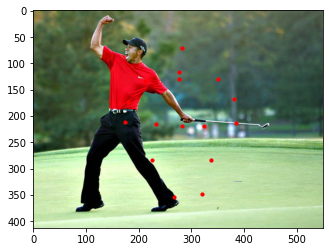

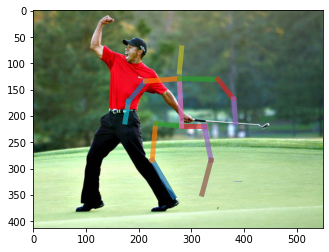

In [22]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'baseline', 'model-epoch-3-loss-6.2885.h5')

resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
model = Simplebaseline(resnet, input_shape=IMAGE_SHAPE)
model.load_weights(WEIGHTS_PATH)

test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

In [ ]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 30
batch_size = 16
num_heatmap = 16
learning_rate = 0.005

WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'baseline', 'model-epoch-3-loss-6.2885.h5')

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, WEIGHTS_PATH)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
load model from :  /aiffel/aiffel/mpii/baseline/model-epoch-3-loss-6.2885.h5
Start training...
Start epoch 1 with learning rate 0.005
Start distributed traininng...
Trained batch 1 batch loss 6.46558475 epoch total loss 6.46558475
Trained batch 2 batch loss 5.90472651 epoch total loss 6.18515587
Trained batch 3 batch loss 6.60835266 epoch total loss 6.32622147
Trained batch 4 batch loss 6.12399292 epoch total loss 6.27566433
Trained batch 5 batch loss 5.87865305 epoch total loss 6.19626188
Trained batch 6 batch loss 6.17491531 epoch total loss 6.19270468
Trained batch 7 batch loss 6.07842207 epoch total loss 6.17637873
Trained batch 8 batch loss 6.0749383 epoch total loss 6.16369867
Trained batch 9 batch loss 6.00335 epoch total loss 6.14588213
Trained batch 10 batch loss 5.73340511 epoch total loss 6.10463428
Trained batch 11 batch loss 5.72630405 epoch total loss 6.07024097
Trained b

Trained batch 121 batch loss 6.40711451 epoch total loss 6.42000771
Trained batch 122 batch loss 6.67540407 epoch total loss 6.42210102
Trained batch 123 batch loss 6.66461754 epoch total loss 6.42407274
Trained batch 124 batch loss 6.70123148 epoch total loss 6.42630816
Trained batch 125 batch loss 6.33466434 epoch total loss 6.42557478
Trained batch 126 batch loss 6.58469534 epoch total loss 6.42683792
Trained batch 127 batch loss 6.63618 epoch total loss 6.42848587
Trained batch 128 batch loss 6.11392784 epoch total loss 6.42602873
Trained batch 129 batch loss 5.68090725 epoch total loss 6.4202528
Trained batch 130 batch loss 6.0333519 epoch total loss 6.41727638
Trained batch 131 batch loss 6.2590723 epoch total loss 6.41606855
Trained batch 132 batch loss 6.26655865 epoch total loss 6.41493607
Trained batch 133 batch loss 6.26363516 epoch total loss 6.41379833
Trained batch 134 batch loss 6.43749332 epoch total loss 6.41397524
Trained batch 135 batch loss 6.59001446 epoch total lo

Trained batch 243 batch loss 6.11596394 epoch total loss 6.44455719
Trained batch 244 batch loss 6.39071751 epoch total loss 6.44433641
Trained batch 245 batch loss 6.54384089 epoch total loss 6.44474268
Trained batch 246 batch loss 5.96258783 epoch total loss 6.44278288
Trained batch 247 batch loss 5.46502924 epoch total loss 6.43882465
Trained batch 248 batch loss 5.41468716 epoch total loss 6.43469477
Trained batch 249 batch loss 5.53646755 epoch total loss 6.43108749
Trained batch 250 batch loss 6.27414131 epoch total loss 6.43046
Trained batch 251 batch loss 6.6887989 epoch total loss 6.43148947
Trained batch 252 batch loss 6.39782095 epoch total loss 6.43135595
Trained batch 253 batch loss 5.88232422 epoch total loss 6.42918587
Trained batch 254 batch loss 6.44153881 epoch total loss 6.4292345
Trained batch 255 batch loss 6.505548 epoch total loss 6.42953348
Trained batch 256 batch loss 5.80060482 epoch total loss 6.42707682
Trained batch 257 batch loss 5.84170341 epoch total los

Trained batch 365 batch loss 6.48090458 epoch total loss 6.38207531
Trained batch 366 batch loss 6.27826166 epoch total loss 6.38179207
Trained batch 367 batch loss 6.27754354 epoch total loss 6.38150787
Trained batch 368 batch loss 6.26188 epoch total loss 6.38118315
Trained batch 369 batch loss 6.3842783 epoch total loss 6.38119173
Trained batch 370 batch loss 6.54300308 epoch total loss 6.38162851
Trained batch 371 batch loss 6.57914543 epoch total loss 6.38216114
Trained batch 372 batch loss 5.99667 epoch total loss 6.3811245
Trained batch 373 batch loss 6.47030258 epoch total loss 6.38136339
Trained batch 374 batch loss 6.64928579 epoch total loss 6.3820796
Trained batch 375 batch loss 6.45512819 epoch total loss 6.38227415
Trained batch 376 batch loss 6.19754601 epoch total loss 6.38178253
Trained batch 377 batch loss 6.09532166 epoch total loss 6.38102245
Trained batch 378 batch loss 6.39125109 epoch total loss 6.38105
Trained batch 379 batch loss 6.93189144 epoch total loss 6.3

Trained batch 487 batch loss 6.56551266 epoch total loss 6.39644814
Trained batch 488 batch loss 6.82932663 epoch total loss 6.39733553
Trained batch 489 batch loss 6.80064106 epoch total loss 6.39816
Trained batch 490 batch loss 6.90850258 epoch total loss 6.39920139
Trained batch 491 batch loss 6.76989555 epoch total loss 6.39995623
Trained batch 492 batch loss 6.88548851 epoch total loss 6.4009428
Trained batch 493 batch loss 6.70615339 epoch total loss 6.40156174
Trained batch 494 batch loss 6.67649746 epoch total loss 6.40211821
Trained batch 495 batch loss 6.56411409 epoch total loss 6.40244579
Trained batch 496 batch loss 6.69763899 epoch total loss 6.40304136
Trained batch 497 batch loss 6.55248642 epoch total loss 6.40334177
Trained batch 498 batch loss 6.40290308 epoch total loss 6.40334082
Trained batch 499 batch loss 6.37360144 epoch total loss 6.40328121
Trained batch 500 batch loss 6.08835745 epoch total loss 6.40265131
Trained batch 501 batch loss 6.46764231 epoch total 

Trained batch 609 batch loss 6.7743659 epoch total loss 6.38665056
Trained batch 610 batch loss 6.77344513 epoch total loss 6.38728476
Trained batch 611 batch loss 6.67195272 epoch total loss 6.38775063
Trained batch 612 batch loss 6.57082415 epoch total loss 6.3880496
Trained batch 613 batch loss 6.1839447 epoch total loss 6.38771629
Trained batch 614 batch loss 6.59273 epoch total loss 6.38805056
Trained batch 615 batch loss 6.56793594 epoch total loss 6.38834286
Trained batch 616 batch loss 7.05434 epoch total loss 6.38942432
Trained batch 617 batch loss 6.84810352 epoch total loss 6.39016771
Trained batch 618 batch loss 6.73102808 epoch total loss 6.39071894
Trained batch 619 batch loss 6.56997252 epoch total loss 6.39100885
Trained batch 620 batch loss 6.75102234 epoch total loss 6.39158916
Trained batch 621 batch loss 6.40319109 epoch total loss 6.39160776
Trained batch 622 batch loss 6.43135166 epoch total loss 6.39167166
Trained batch 623 batch loss 6.48030424 epoch total loss 

Trained batch 959 batch loss 6.51173306 epoch total loss 6.39577818
Trained batch 960 batch loss 5.94444656 epoch total loss 6.39530802
Trained batch 961 batch loss 6.18366432 epoch total loss 6.39508772
Trained batch 962 batch loss 5.93217707 epoch total loss 6.39460659
Trained batch 963 batch loss 6.33751345 epoch total loss 6.39454699
Trained batch 964 batch loss 6.15589714 epoch total loss 6.39429903
Trained batch 965 batch loss 6.3482542 epoch total loss 6.39425135
Trained batch 966 batch loss 6.41975212 epoch total loss 6.39427805
Trained batch 967 batch loss 6.48903418 epoch total loss 6.39437628
Trained batch 968 batch loss 6.60891438 epoch total loss 6.39459801
Trained batch 969 batch loss 5.75178576 epoch total loss 6.39393473
Trained batch 970 batch loss 4.85364771 epoch total loss 6.39234638
Trained batch 971 batch loss 5.65279102 epoch total loss 6.39158487
Trained batch 972 batch loss 5.99533844 epoch total loss 6.39117718
Trained batch 973 batch loss 6.75087786 epoch tot

Trained batch 1080 batch loss 6.4761796 epoch total loss 6.37983
Trained batch 1081 batch loss 6.63048077 epoch total loss 6.38006163
Trained batch 1082 batch loss 6.5294528 epoch total loss 6.38019943
Trained batch 1083 batch loss 6.12631416 epoch total loss 6.37996531
Trained batch 1084 batch loss 6.54457951 epoch total loss 6.38011694
Trained batch 1085 batch loss 6.48164654 epoch total loss 6.3802104
Trained batch 1086 batch loss 6.39827967 epoch total loss 6.38022709
Trained batch 1087 batch loss 6.1659174 epoch total loss 6.38003
Trained batch 1088 batch loss 5.82258034 epoch total loss 6.37951803
Trained batch 1089 batch loss 5.64548397 epoch total loss 6.37884378
Trained batch 1090 batch loss 6.14084053 epoch total loss 6.37862539
Trained batch 1091 batch loss 5.59947491 epoch total loss 6.37791157
Trained batch 1092 batch loss 6.53943777 epoch total loss 6.37805939
Trained batch 1093 batch loss 6.4505682 epoch total loss 6.37812567
Trained batch 1094 batch loss 6.68682528 epoc

Trained batch 1200 batch loss 5.74273252 epoch total loss 6.38173723
Trained batch 1201 batch loss 5.99833918 epoch total loss 6.38141823
Trained batch 1202 batch loss 6.38698244 epoch total loss 6.381423
Trained batch 1203 batch loss 6.62926388 epoch total loss 6.38162899
Trained batch 1204 batch loss 6.46847916 epoch total loss 6.38170099
Trained batch 1205 batch loss 6.18153477 epoch total loss 6.38153505
Trained batch 1206 batch loss 6.39075613 epoch total loss 6.38154221
Trained batch 1207 batch loss 6.4294157 epoch total loss 6.38158178
Trained batch 1208 batch loss 6.37691 epoch total loss 6.38157797
Trained batch 1209 batch loss 6.77682829 epoch total loss 6.38190508
Trained batch 1210 batch loss 6.63803768 epoch total loss 6.38211679
Trained batch 1211 batch loss 6.35281801 epoch total loss 6.38209295
Trained batch 1212 batch loss 6.3689394 epoch total loss 6.38208199
Trained batch 1213 batch loss 6.27719784 epoch total loss 6.38199568
Trained batch 1214 batch loss 6.36272669 

Trained batch 1320 batch loss 6.38971615 epoch total loss 6.37571621
Trained batch 1321 batch loss 6.55035496 epoch total loss 6.37584877
Trained batch 1322 batch loss 6.83302069 epoch total loss 6.37619448
Trained batch 1323 batch loss 6.5015521 epoch total loss 6.37628937
Trained batch 1324 batch loss 6.43280172 epoch total loss 6.37633228
Trained batch 1325 batch loss 6.29735231 epoch total loss 6.3762722
Trained batch 1326 batch loss 6.44710541 epoch total loss 6.37632561
Trained batch 1327 batch loss 6.43678045 epoch total loss 6.37637091
Trained batch 1328 batch loss 6.42636108 epoch total loss 6.37640905
Trained batch 1329 batch loss 5.96676111 epoch total loss 6.37610054
Trained batch 1330 batch loss 6.56266403 epoch total loss 6.37624073
Trained batch 1331 batch loss 6.45814323 epoch total loss 6.37630224
Trained batch 1332 batch loss 6.65620184 epoch total loss 6.37651253
Trained batch 1333 batch loss 6.59365463 epoch total loss 6.37667561
Trained batch 1334 batch loss 6.4443

Validated batch 86 batch loss 6.25695658
Validated batch 87 batch loss 6.67694855
Validated batch 88 batch loss 6.54253292
Validated batch 89 batch loss 6.13535643
Validated batch 90 batch loss 6.29616404
Validated batch 91 batch loss 6.4837842
Validated batch 92 batch loss 6.65723133
Validated batch 93 batch loss 6.50717402
Validated batch 94 batch loss 6.33344316
Validated batch 95 batch loss 6.17892122
Validated batch 96 batch loss 6.04722166
Validated batch 97 batch loss 6.49650335
Validated batch 98 batch loss 6.36576843
Validated batch 99 batch loss 6.41848898
Validated batch 100 batch loss 6.41987658
Validated batch 101 batch loss 6.15347433
Validated batch 102 batch loss 6.52854967
Validated batch 103 batch loss 6.80864525
Validated batch 104 batch loss 6.44914436
Validated batch 105 batch loss 6.43580484
Validated batch 106 batch loss 6.28523827
Validated batch 107 batch loss 6.52535963
Validated batch 108 batch loss 6.24748278
Validated batch 109 batch loss 6.68160343
Validat

Trained batch 60 batch loss 4.840446 epoch total loss 6.2087121
Trained batch 61 batch loss 6.52956724 epoch total loss 6.21397209
Trained batch 62 batch loss 6.62807465 epoch total loss 6.22065163
Trained batch 63 batch loss 7.1342144 epoch total loss 6.23515224
Trained batch 64 batch loss 7.09106255 epoch total loss 6.2485261
Trained batch 65 batch loss 6.71729279 epoch total loss 6.25573778
Trained batch 66 batch loss 5.73628235 epoch total loss 6.24786758
Trained batch 67 batch loss 6.32311583 epoch total loss 6.24899054
Trained batch 68 batch loss 6.30915165 epoch total loss 6.24987507
Trained batch 69 batch loss 6.4006567 epoch total loss 6.25206041
Trained batch 70 batch loss 6.63348722 epoch total loss 6.25750971
Trained batch 71 batch loss 6.41562605 epoch total loss 6.25973654
Trained batch 72 batch loss 6.44329357 epoch total loss 6.26228571
Trained batch 73 batch loss 6.30867386 epoch total loss 6.26292133
Trained batch 74 batch loss 6.44588757 epoch total loss 6.26539421
T

Trained batch 182 batch loss 6.32220364 epoch total loss 6.34492302
Trained batch 183 batch loss 6.40138721 epoch total loss 6.34523153
Trained batch 184 batch loss 6.72927046 epoch total loss 6.34731865
Trained batch 185 batch loss 6.27619648 epoch total loss 6.34693432
Trained batch 186 batch loss 6.4571085 epoch total loss 6.34752703
Trained batch 187 batch loss 6.37034607 epoch total loss 6.3476491
Trained batch 188 batch loss 6.33741951 epoch total loss 6.34759474
Trained batch 189 batch loss 5.61107683 epoch total loss 6.34369755
Trained batch 190 batch loss 6.28881073 epoch total loss 6.34340906
Trained batch 191 batch loss 6.2560668 epoch total loss 6.34295177
Trained batch 192 batch loss 6.54147196 epoch total loss 6.34398603
Trained batch 193 batch loss 6.44179249 epoch total loss 6.34449244
Trained batch 194 batch loss 6.17470598 epoch total loss 6.34361744
Trained batch 195 batch loss 6.04796839 epoch total loss 6.3421011
Trained batch 196 batch loss 6.53406143 epoch total 

Trained batch 304 batch loss 6.22198725 epoch total loss 6.3696475
Trained batch 305 batch loss 6.37147808 epoch total loss 6.36965322
Trained batch 306 batch loss 5.79427242 epoch total loss 6.36777306
Trained batch 307 batch loss 5.88859463 epoch total loss 6.36621237
Trained batch 308 batch loss 5.53201866 epoch total loss 6.36350346
Trained batch 309 batch loss 6.38059 epoch total loss 6.36355877
Trained batch 310 batch loss 7.23116159 epoch total loss 6.3663578
Trained batch 311 batch loss 6.92110777 epoch total loss 6.36814165
Trained batch 312 batch loss 6.67645168 epoch total loss 6.36912966
Trained batch 313 batch loss 6.82421732 epoch total loss 6.37058353
Trained batch 314 batch loss 6.53092957 epoch total loss 6.37109423
Trained batch 315 batch loss 6.93171 epoch total loss 6.37287426
Trained batch 316 batch loss 6.6067524 epoch total loss 6.37361431
Trained batch 317 batch loss 6.38796329 epoch total loss 6.37365961
Trained batch 318 batch loss 6.81653595 epoch total loss 

Trained batch 426 batch loss 6.70633173 epoch total loss 6.38553
Trained batch 427 batch loss 7.02714729 epoch total loss 6.38703251
Trained batch 428 batch loss 6.76912403 epoch total loss 6.38792515
Trained batch 429 batch loss 6.72218657 epoch total loss 6.3887043
Trained batch 430 batch loss 5.7079525 epoch total loss 6.3871212
Trained batch 431 batch loss 5.50614119 epoch total loss 6.385077
Trained batch 432 batch loss 5.37395477 epoch total loss 6.38273668
Trained batch 433 batch loss 5.56348705 epoch total loss 6.38084459
Trained batch 434 batch loss 5.92550325 epoch total loss 6.37979555
Trained batch 435 batch loss 6.07378101 epoch total loss 6.37909222
Trained batch 436 batch loss 6.46527672 epoch total loss 6.37928963
Trained batch 437 batch loss 6.21065474 epoch total loss 6.37890387
Trained batch 438 batch loss 6.68385601 epoch total loss 6.3796
Trained batch 439 batch loss 6.7879 epoch total loss 6.38053036
Trained batch 440 batch loss 6.35943747 epoch total loss 6.38048

Trained batch 548 batch loss 6.41903305 epoch total loss 6.37022877
Trained batch 549 batch loss 6.40415859 epoch total loss 6.37029028
Trained batch 550 batch loss 6.40769434 epoch total loss 6.37035799
Trained batch 551 batch loss 6.20830679 epoch total loss 6.37006378
Trained batch 552 batch loss 6.49155951 epoch total loss 6.37028408
Trained batch 553 batch loss 6.44449139 epoch total loss 6.37041807
Trained batch 554 batch loss 6.36550379 epoch total loss 6.37040949
Trained batch 555 batch loss 5.90077448 epoch total loss 6.36956358
Trained batch 556 batch loss 6.3739953 epoch total loss 6.36957121
Trained batch 557 batch loss 6.02341938 epoch total loss 6.36895
Trained batch 558 batch loss 6.16070795 epoch total loss 6.36857653
Trained batch 559 batch loss 6.30277824 epoch total loss 6.36845875
Trained batch 560 batch loss 6.54209137 epoch total loss 6.36876869
Trained batch 561 batch loss 6.25457382 epoch total loss 6.36856508
Trained batch 562 batch loss 6.36187458 epoch total 

Trained batch 670 batch loss 6.45554972 epoch total loss 6.37554359
Trained batch 671 batch loss 6.64517069 epoch total loss 6.37594509
Trained batch 672 batch loss 6.43475199 epoch total loss 6.37603235
Trained batch 673 batch loss 6.05945778 epoch total loss 6.37556219
Trained batch 674 batch loss 6.04495049 epoch total loss 6.37507153
Trained batch 675 batch loss 6.21810579 epoch total loss 6.37483931
Trained batch 676 batch loss 6.57703114 epoch total loss 6.37513876
Trained batch 677 batch loss 5.94087267 epoch total loss 6.37449741
Trained batch 678 batch loss 6.34029961 epoch total loss 6.37444687
Trained batch 679 batch loss 6.00267267 epoch total loss 6.37389898
Trained batch 680 batch loss 6.29853106 epoch total loss 6.37378788
Trained batch 681 batch loss 6.41405487 epoch total loss 6.37384701
Trained batch 682 batch loss 5.73443937 epoch total loss 6.37290955
Trained batch 683 batch loss 5.47165585 epoch total loss 6.37158966
Trained batch 684 batch loss 5.3794179 epoch tot

Trained batch 792 batch loss 6.74920464 epoch total loss 6.38839245
Trained batch 793 batch loss 6.48760319 epoch total loss 6.38851786
Trained batch 794 batch loss 6.62904882 epoch total loss 6.38882065
Trained batch 795 batch loss 6.57303572 epoch total loss 6.38905287
Trained batch 796 batch loss 6.7753787 epoch total loss 6.38953781
Trained batch 797 batch loss 7.02312231 epoch total loss 6.3903327
Trained batch 798 batch loss 6.66733694 epoch total loss 6.39068
Trained batch 799 batch loss 6.89086199 epoch total loss 6.39130592
Trained batch 800 batch loss 6.61577559 epoch total loss 6.3915863
Trained batch 801 batch loss 6.54648972 epoch total loss 6.39177942
Trained batch 802 batch loss 6.71634483 epoch total loss 6.39218426
Trained batch 803 batch loss 6.84013128 epoch total loss 6.39274216
Trained batch 804 batch loss 6.48846483 epoch total loss 6.39286137
Trained batch 805 batch loss 5.91417933 epoch total loss 6.39226627
Trained batch 806 batch loss 6.26192856 epoch total lo

Trained batch 914 batch loss 6.18599749 epoch total loss 6.38169384
Trained batch 915 batch loss 5.79528141 epoch total loss 6.38105297
Trained batch 916 batch loss 5.67544699 epoch total loss 6.3802824
Trained batch 917 batch loss 5.693645 epoch total loss 6.37953424
Trained batch 918 batch loss 5.97157288 epoch total loss 6.37909
Trained batch 919 batch loss 6.28050756 epoch total loss 6.37898207
Trained batch 920 batch loss 6.21529865 epoch total loss 6.37880421
Trained batch 921 batch loss 6.51450109 epoch total loss 6.37895203
Trained batch 922 batch loss 6.53359604 epoch total loss 6.37912
Trained batch 923 batch loss 6.2525897 epoch total loss 6.37898254
Trained batch 924 batch loss 6.23573589 epoch total loss 6.37882757
Trained batch 925 batch loss 6.15280437 epoch total loss 6.37858295
Trained batch 926 batch loss 5.73537636 epoch total loss 6.37788868
Trained batch 927 batch loss 6.0657506 epoch total loss 6.37755203
Trained batch 928 batch loss 6.4328866 epoch total loss 6.3

Trained batch 1035 batch loss 6.673841 epoch total loss 6.36374855
Trained batch 1036 batch loss 6.3881011 epoch total loss 6.36377239
Trained batch 1037 batch loss 5.79598904 epoch total loss 6.36322498
Trained batch 1038 batch loss 6.41124344 epoch total loss 6.36327076
Trained batch 1039 batch loss 6.44422722 epoch total loss 6.36334896
Trained batch 1040 batch loss 6.62266302 epoch total loss 6.36359835
Trained batch 1041 batch loss 6.03162098 epoch total loss 6.36327934
Trained batch 1042 batch loss 5.3874321 epoch total loss 6.36234283
Trained batch 1043 batch loss 6.0757761 epoch total loss 6.3620677
Trained batch 1044 batch loss 6.39760685 epoch total loss 6.36210155
Trained batch 1045 batch loss 6.35858965 epoch total loss 6.36209822
Trained batch 1046 batch loss 6.47634888 epoch total loss 6.36220741
Trained batch 1047 batch loss 6.5716114 epoch total loss 6.36240768
Trained batch 1048 batch loss 6.93698 epoch total loss 6.36295605
Trained batch 1049 batch loss 6.7207427 epoc

Trained batch 1155 batch loss 6.32886 epoch total loss 6.36362171
Trained batch 1156 batch loss 6.46448755 epoch total loss 6.3637085
Trained batch 1157 batch loss 5.67528105 epoch total loss 6.36311388
Trained batch 1158 batch loss 6.13405466 epoch total loss 6.36291599
Trained batch 1159 batch loss 6.57205296 epoch total loss 6.36309671
Trained batch 1160 batch loss 6.61407566 epoch total loss 6.3633132
Trained batch 1161 batch loss 6.21186447 epoch total loss 6.36318302
Trained batch 1162 batch loss 6.2167449 epoch total loss 6.36305666
Trained batch 1163 batch loss 6.41100883 epoch total loss 6.36309814
Trained batch 1164 batch loss 5.94684792 epoch total loss 6.36274052
Trained batch 1165 batch loss 6.97509623 epoch total loss 6.36326599
Trained batch 1166 batch loss 6.80442715 epoch total loss 6.36364412
Trained batch 1167 batch loss 6.35621738 epoch total loss 6.36363792
Trained batch 1168 batch loss 6.2375555 epoch total loss 6.36353064
Trained batch 1169 batch loss 6.45912 epo

Trained batch 1275 batch loss 6.26862621 epoch total loss 6.36097288
Trained batch 1276 batch loss 6.48641539 epoch total loss 6.36107111
Trained batch 1277 batch loss 6.05106831 epoch total loss 6.3608284
Trained batch 1278 batch loss 6.28327227 epoch total loss 6.36076784
Trained batch 1279 batch loss 6.41560078 epoch total loss 6.36081028
Trained batch 1280 batch loss 6.23358679 epoch total loss 6.3607111
Trained batch 1281 batch loss 6.54864693 epoch total loss 6.36085796
Trained batch 1282 batch loss 6.41058779 epoch total loss 6.36089659
Trained batch 1283 batch loss 6.15734911 epoch total loss 6.3607378
Trained batch 1284 batch loss 6.30090094 epoch total loss 6.36069107
Trained batch 1285 batch loss 6.41032505 epoch total loss 6.36072969
Trained batch 1286 batch loss 6.68441725 epoch total loss 6.36098146
Trained batch 1287 batch loss 6.71073198 epoch total loss 6.36125326
Trained batch 1288 batch loss 6.556427 epoch total loss 6.3614049
Trained batch 1289 batch loss 6.45139837

Validated batch 10 batch loss 6.7695365
Validated batch 11 batch loss 6.50675
Validated batch 12 batch loss 6.36142063
Validated batch 13 batch loss 6.42929077
Validated batch 14 batch loss 6.25474739
Validated batch 15 batch loss 6.42890739
Validated batch 16 batch loss 6.31480694
Validated batch 17 batch loss 6.44271183
Validated batch 18 batch loss 6.29229355
Validated batch 19 batch loss 6.16776323
Validated batch 20 batch loss 6.35072613
Validated batch 21 batch loss 6.0821
Validated batch 22 batch loss 6.58282185
Validated batch 23 batch loss 6.69598961
Validated batch 24 batch loss 6.53888798
Validated batch 25 batch loss 6.37582922
Validated batch 26 batch loss 6.11854506
Validated batch 27 batch loss 6.05870867
Validated batch 28 batch loss 6.15551472
Validated batch 29 batch loss 6.31393957
Validated batch 30 batch loss 6.1774559
Validated batch 31 batch loss 6.36356974
Validated batch 32 batch loss 6.44372749
Validated batch 33 batch loss 6.26024485
Validated batch 34 batch 

Trained batch 13 batch loss 6.57103443 epoch total loss 6.34547758
Trained batch 14 batch loss 6.41783381 epoch total loss 6.35064602
Trained batch 15 batch loss 6.77424335 epoch total loss 6.37888575
Trained batch 16 batch loss 6.59179497 epoch total loss 6.39219284
Trained batch 17 batch loss 6.6307354 epoch total loss 6.40622473
Trained batch 18 batch loss 6.31798649 epoch total loss 6.40132284
Trained batch 19 batch loss 6.37238359 epoch total loss 6.39979935
Trained batch 20 batch loss 6.27500105 epoch total loss 6.39355946
Trained batch 21 batch loss 5.86008406 epoch total loss 6.36815596
Trained batch 22 batch loss 6.13119841 epoch total loss 6.35738516
Trained batch 23 batch loss 6.3773489 epoch total loss 6.358253
Trained batch 24 batch loss 6.50570965 epoch total loss 6.36439705
Trained batch 25 batch loss 6.68692636 epoch total loss 6.37729788
Trained batch 26 batch loss 6.63108921 epoch total loss 6.38705921
Trained batch 27 batch loss 6.3464036 epoch total loss 6.38555336


Trained batch 136 batch loss 6.52847815 epoch total loss 6.38737869
Trained batch 137 batch loss 6.02541447 epoch total loss 6.38473606
Trained batch 138 batch loss 5.89959192 epoch total loss 6.38122082
Trained batch 139 batch loss 6.02547312 epoch total loss 6.37866116
Trained batch 140 batch loss 6.55877686 epoch total loss 6.37994766
Trained batch 141 batch loss 6.5051403 epoch total loss 6.38083553
Trained batch 142 batch loss 6.37702274 epoch total loss 6.38080883
Trained batch 143 batch loss 6.04159069 epoch total loss 6.37843609
Trained batch 144 batch loss 6.61523438 epoch total loss 6.3800807
Trained batch 145 batch loss 6.38744926 epoch total loss 6.38013172
Trained batch 146 batch loss 6.69914198 epoch total loss 6.38231659
Trained batch 147 batch loss 6.63348532 epoch total loss 6.3840251
Trained batch 148 batch loss 6.53198814 epoch total loss 6.38502502
Trained batch 149 batch loss 6.24642467 epoch total loss 6.38409472
Trained batch 150 batch loss 6.33953619 epoch total

Trained batch 258 batch loss 6.33714 epoch total loss 6.39653921
Trained batch 259 batch loss 6.04850769 epoch total loss 6.39519548
Trained batch 260 batch loss 6.48243332 epoch total loss 6.3955307
Trained batch 261 batch loss 6.78402472 epoch total loss 6.39701939
Trained batch 262 batch loss 6.34316063 epoch total loss 6.39681387
Trained batch 263 batch loss 6.35487747 epoch total loss 6.39665413
Trained batch 264 batch loss 6.45022488 epoch total loss 6.39685726
Trained batch 265 batch loss 6.54791784 epoch total loss 6.39742708
Trained batch 266 batch loss 6.39470196 epoch total loss 6.39741707
Trained batch 267 batch loss 6.44291687 epoch total loss 6.3975873
Trained batch 268 batch loss 6.38719368 epoch total loss 6.3975482
Trained batch 269 batch loss 5.93171072 epoch total loss 6.3958168
Trained batch 270 batch loss 5.86244583 epoch total loss 6.39384127
Trained batch 271 batch loss 5.3406353 epoch total loss 6.38995457
Trained batch 272 batch loss 5.74361 epoch total loss 6.

Trained batch 380 batch loss 6.4249959 epoch total loss 6.36172247
Trained batch 381 batch loss 6.61794 epoch total loss 6.36239481
Trained batch 382 batch loss 6.4619379 epoch total loss 6.36265564
Trained batch 383 batch loss 6.27641058 epoch total loss 6.36243
Trained batch 384 batch loss 6.60990334 epoch total loss 6.36307478
Trained batch 385 batch loss 6.79881239 epoch total loss 6.36420631
Trained batch 386 batch loss 6.82989311 epoch total loss 6.36541271
Trained batch 387 batch loss 6.3804512 epoch total loss 6.36545134
Trained batch 388 batch loss 6.08943844 epoch total loss 6.36474
Trained batch 389 batch loss 6.36646509 epoch total loss 6.36474419
Trained batch 390 batch loss 6.21427679 epoch total loss 6.36435843
Trained batch 391 batch loss 6.12826395 epoch total loss 6.36375475
Trained batch 392 batch loss 6.16027689 epoch total loss 6.363235
Trained batch 393 batch loss 6.48446941 epoch total loss 6.36354351
Trained batch 394 batch loss 6.32391596 epoch total loss 6.363

Trained batch 502 batch loss 6.29034233 epoch total loss 6.35052443
Trained batch 503 batch loss 5.76987076 epoch total loss 6.34937
Trained batch 504 batch loss 5.82495499 epoch total loss 6.34832954
Trained batch 505 batch loss 5.61403799 epoch total loss 6.34687567
Trained batch 506 batch loss 5.75775814 epoch total loss 6.34571123
Trained batch 507 batch loss 6.25943327 epoch total loss 6.34554148
Trained batch 508 batch loss 6.53025675 epoch total loss 6.34590483
Trained batch 509 batch loss 6.45791 epoch total loss 6.34612513
Trained batch 510 batch loss 6.46722794 epoch total loss 6.34636259
Trained batch 511 batch loss 6.26123333 epoch total loss 6.34619617
Trained batch 512 batch loss 6.2245059 epoch total loss 6.34595871
Trained batch 513 batch loss 6.26166725 epoch total loss 6.34579468
Trained batch 514 batch loss 5.48820972 epoch total loss 6.34412622
Trained batch 515 batch loss 6.21721697 epoch total loss 6.3438797
Trained batch 516 batch loss 6.60232782 epoch total loss

Trained batch 624 batch loss 6.25706339 epoch total loss 6.32631397
Trained batch 625 batch loss 6.32562733 epoch total loss 6.32631302
Trained batch 626 batch loss 6.44155359 epoch total loss 6.32649708
Trained batch 627 batch loss 6.23367 epoch total loss 6.32634926
Trained batch 628 batch loss 6.25552607 epoch total loss 6.32623625
Trained batch 629 batch loss 6.1666069 epoch total loss 6.32598257
Trained batch 630 batch loss 6.19408 epoch total loss 6.32577324
Trained batch 631 batch loss 6.68523 epoch total loss 6.32634306
Trained batch 632 batch loss 6.61269283 epoch total loss 6.32679605
Trained batch 633 batch loss 6.53398848 epoch total loss 6.32712317
Trained batch 634 batch loss 6.55016661 epoch total loss 6.32747507
Trained batch 635 batch loss 6.4445734 epoch total loss 6.32765961
Trained batch 636 batch loss 6.32623434 epoch total loss 6.32765722
Trained batch 637 batch loss 6.27577877 epoch total loss 6.32757568
Trained batch 638 batch loss 5.99773645 epoch total loss 6.

Trained batch 746 batch loss 6.59517574 epoch total loss 6.33779573
Trained batch 747 batch loss 6.33904314 epoch total loss 6.33779716
Trained batch 748 batch loss 6.56823778 epoch total loss 6.3381052
Trained batch 749 batch loss 6.40288782 epoch total loss 6.33819199
Trained batch 750 batch loss 6.43344831 epoch total loss 6.33831882
Trained batch 751 batch loss 6.35132885 epoch total loss 6.33833647
Trained batch 752 batch loss 6.28638077 epoch total loss 6.3382678
Trained batch 753 batch loss 6.41622925 epoch total loss 6.33837128
Trained batch 754 batch loss 6.2332449 epoch total loss 6.33823204
Trained batch 755 batch loss 6.38557386 epoch total loss 6.33829498
Trained batch 756 batch loss 6.38114595 epoch total loss 6.33835173
Trained batch 757 batch loss 6.19782829 epoch total loss 6.33816624
Trained batch 758 batch loss 6.29522943 epoch total loss 6.33810949
Trained batch 759 batch loss 6.73749781 epoch total loss 6.33863544
Trained batch 760 batch loss 6.96882439 epoch total

Trained batch 868 batch loss 6.63550854 epoch total loss 6.35899258
Trained batch 869 batch loss 6.58964586 epoch total loss 6.35925817
Trained batch 870 batch loss 5.75183535 epoch total loss 6.35856
Trained batch 871 batch loss 5.39730787 epoch total loss 6.35745668
Trained batch 872 batch loss 5.99404764 epoch total loss 6.35704
Trained batch 873 batch loss 6.2501 epoch total loss 6.35691738
Trained batch 874 batch loss 6.62800646 epoch total loss 6.35722733
Trained batch 875 batch loss 6.23806 epoch total loss 6.35709143
Trained batch 876 batch loss 6.32175493 epoch total loss 6.35705137
Trained batch 877 batch loss 6.42748451 epoch total loss 6.35713148
Trained batch 878 batch loss 6.47457314 epoch total loss 6.357265
Trained batch 879 batch loss 6.43063259 epoch total loss 6.35734844
Trained batch 880 batch loss 5.64001369 epoch total loss 6.35653353
Trained batch 881 batch loss 6.53675127 epoch total loss 6.35673809
Trained batch 882 batch loss 6.363801 epoch total loss 6.356745

Trained batch 990 batch loss 5.80695868 epoch total loss 6.35375595
Trained batch 991 batch loss 5.71303272 epoch total loss 6.35310936
Trained batch 992 batch loss 5.46604919 epoch total loss 6.35221481
Trained batch 993 batch loss 5.59128094 epoch total loss 6.35144854
Trained batch 994 batch loss 6.34228945 epoch total loss 6.351439
Trained batch 995 batch loss 6.54020309 epoch total loss 6.35162878
Trained batch 996 batch loss 6.73062372 epoch total loss 6.3520093
Trained batch 997 batch loss 6.84356833 epoch total loss 6.35250235
Trained batch 998 batch loss 6.8826685 epoch total loss 6.35303354
Trained batch 999 batch loss 6.29262686 epoch total loss 6.35297298
Trained batch 1000 batch loss 6.18033886 epoch total loss 6.35280037
Trained batch 1001 batch loss 5.99702358 epoch total loss 6.35244513
Trained batch 1002 batch loss 6.02533722 epoch total loss 6.35211849
Trained batch 1003 batch loss 6.29895115 epoch total loss 6.35206556
Trained batch 1004 batch loss 6.53549147 epoch t

Trained batch 1110 batch loss 6.72104836 epoch total loss 6.3376317
Trained batch 1111 batch loss 7.04411316 epoch total loss 6.33826733
Trained batch 1112 batch loss 6.79041338 epoch total loss 6.33867407
Trained batch 1113 batch loss 5.93879509 epoch total loss 6.33831501
Trained batch 1114 batch loss 6.18152332 epoch total loss 6.33817434
Trained batch 1115 batch loss 6.37040424 epoch total loss 6.33820343
Trained batch 1116 batch loss 6.51954031 epoch total loss 6.33836555
Trained batch 1117 batch loss 6.51345778 epoch total loss 6.33852291
Trained batch 1118 batch loss 6.4422183 epoch total loss 6.33861542
Trained batch 1119 batch loss 6.61011 epoch total loss 6.3388586
Trained batch 1120 batch loss 6.59239531 epoch total loss 6.33908463
Trained batch 1121 batch loss 6.47477245 epoch total loss 6.33920574
Trained batch 1122 batch loss 6.59372854 epoch total loss 6.33943272
Trained batch 1123 batch loss 6.3506484 epoch total loss 6.33944225
Trained batch 1124 batch loss 6.41688538 

Trained batch 1230 batch loss 6.79175806 epoch total loss 6.3414259
Trained batch 1231 batch loss 6.8816433 epoch total loss 6.34186506
Trained batch 1232 batch loss 6.82536077 epoch total loss 6.3422575
Trained batch 1233 batch loss 6.56867266 epoch total loss 6.34244108
Trained batch 1234 batch loss 6.36474657 epoch total loss 6.3424592
Trained batch 1235 batch loss 6.62383938 epoch total loss 6.34268713
Trained batch 1236 batch loss 6.34228611 epoch total loss 6.34268713
Trained batch 1237 batch loss 6.68573141 epoch total loss 6.34296417
Trained batch 1238 batch loss 6.81319666 epoch total loss 6.34334373
Trained batch 1239 batch loss 6.67429352 epoch total loss 6.34361076
Trained batch 1240 batch loss 6.53204775 epoch total loss 6.34376287
Trained batch 1241 batch loss 6.40056562 epoch total loss 6.34380865
Trained batch 1242 batch loss 6.23023224 epoch total loss 6.34371758
Trained batch 1243 batch loss 6.57928228 epoch total loss 6.34390688
Trained batch 1244 batch loss 6.613781

Trained batch 1350 batch loss 6.21996737 epoch total loss 6.3477807
Trained batch 1351 batch loss 6.35792589 epoch total loss 6.34778833
Trained batch 1352 batch loss 6.51254559 epoch total loss 6.3479104
Trained batch 1353 batch loss 6.54820156 epoch total loss 6.34805822
Trained batch 1354 batch loss 6.50122118 epoch total loss 6.34817123
Trained batch 1355 batch loss 6.56979275 epoch total loss 6.34833431
Trained batch 1356 batch loss 6.25025272 epoch total loss 6.34826183
Trained batch 1357 batch loss 6.36876917 epoch total loss 6.34827709
Trained batch 1358 batch loss 6.30639 epoch total loss 6.34824657
Trained batch 1359 batch loss 6.75638437 epoch total loss 6.34854746
Trained batch 1360 batch loss 6.40431404 epoch total loss 6.34858847
Trained batch 1361 batch loss 6.5787921 epoch total loss 6.34875774
Trained batch 1362 batch loss 6.32488298 epoch total loss 6.34874058
Trained batch 1363 batch loss 6.22134972 epoch total loss 6.34864712
Trained batch 1364 batch loss 6.30815887

Validated batch 136 batch loss 6.1902113
Validated batch 137 batch loss 6.79717684
Validated batch 138 batch loss 6.19772577
Validated batch 139 batch loss 6.45707846
Validated batch 140 batch loss 6.81144571
Validated batch 141 batch loss 6.32150793
Validated batch 142 batch loss 5.83238697
Validated batch 143 batch loss 6.27931213
Validated batch 144 batch loss 6.26014471
Validated batch 145 batch loss 5.91921425
Validated batch 146 batch loss 6.07881594
Validated batch 147 batch loss 5.83984232
Validated batch 148 batch loss 6.55534458
Validated batch 149 batch loss 6.07993174
Validated batch 150 batch loss 6.11161566
Validated batch 151 batch loss 5.84085798
Validated batch 152 batch loss 6.64492512
Validated batch 153 batch loss 5.91922951
Validated batch 154 batch loss 6.26386833
Validated batch 155 batch loss 6.28839111
Validated batch 156 batch loss 6.4919219
Validated batch 157 batch loss 6.19798183
Validated batch 158 batch loss 6.42735243
Validated batch 159 batch loss 6.500

Trained batch 91 batch loss 6.45905638 epoch total loss 6.45414972
Trained batch 92 batch loss 6.78692293 epoch total loss 6.45776701
Trained batch 93 batch loss 6.25552464 epoch total loss 6.45559263
Trained batch 94 batch loss 6.40202665 epoch total loss 6.45502281
Trained batch 95 batch loss 6.47907448 epoch total loss 6.45527601
Trained batch 96 batch loss 6.32470179 epoch total loss 6.45391607
Trained batch 97 batch loss 6.31723738 epoch total loss 6.45250702
Trained batch 98 batch loss 6.35807 epoch total loss 6.45154381
Trained batch 99 batch loss 6.47976303 epoch total loss 6.45182848
Trained batch 100 batch loss 6.69150257 epoch total loss 6.45422554
Trained batch 101 batch loss 6.51698828 epoch total loss 6.45484686
Trained batch 102 batch loss 6.65953493 epoch total loss 6.45685339
Trained batch 103 batch loss 6.46681547 epoch total loss 6.45695
Trained batch 104 batch loss 6.58663845 epoch total loss 6.45819664
Trained batch 105 batch loss 6.24622059 epoch total loss 6.4561

Trained batch 213 batch loss 5.91916752 epoch total loss 6.35439968
Trained batch 214 batch loss 7.2311492 epoch total loss 6.35849714
Trained batch 215 batch loss 7.15566254 epoch total loss 6.36220455
Trained batch 216 batch loss 6.83925724 epoch total loss 6.36441326
Trained batch 217 batch loss 6.22373962 epoch total loss 6.36376524
Trained batch 218 batch loss 6.85479784 epoch total loss 6.36601782
Trained batch 219 batch loss 5.95522261 epoch total loss 6.36414194
Trained batch 220 batch loss 6.1993866 epoch total loss 6.36339283
Trained batch 221 batch loss 6.40816498 epoch total loss 6.36359549
Trained batch 222 batch loss 5.85346746 epoch total loss 6.36129808
Trained batch 223 batch loss 6.06003141 epoch total loss 6.3599472
Trained batch 224 batch loss 6.34717035 epoch total loss 6.35989
Trained batch 225 batch loss 6.35938311 epoch total loss 6.3598876
Trained batch 226 batch loss 6.4406271 epoch total loss 6.36024523
Trained batch 227 batch loss 6.07420969 epoch total loss

Trained batch 335 batch loss 6.20777225 epoch total loss 6.35659838
Trained batch 336 batch loss 6.37981892 epoch total loss 6.35666752
Trained batch 337 batch loss 6.31500578 epoch total loss 6.35654402
Trained batch 338 batch loss 6.82230043 epoch total loss 6.3579216
Trained batch 339 batch loss 6.61647 epoch total loss 6.35868454
Trained batch 340 batch loss 6.30589533 epoch total loss 6.35852909
Trained batch 341 batch loss 6.46331453 epoch total loss 6.35883665
Trained batch 342 batch loss 6.15011787 epoch total loss 6.3582263
Trained batch 343 batch loss 6.30483341 epoch total loss 6.35807085
Trained batch 344 batch loss 6.27682495 epoch total loss 6.35783482
Trained batch 345 batch loss 5.96118402 epoch total loss 6.35668516
Trained batch 346 batch loss 6.38695431 epoch total loss 6.3567729
Trained batch 347 batch loss 6.34843159 epoch total loss 6.35674858
Trained batch 348 batch loss 6.4199481 epoch total loss 6.35693026
Trained batch 349 batch loss 6.06136656 epoch total los

Trained batch 457 batch loss 6.39874172 epoch total loss 6.35082436
Trained batch 458 batch loss 6.54357243 epoch total loss 6.35124493
Trained batch 459 batch loss 6.79327774 epoch total loss 6.35220766
Trained batch 460 batch loss 6.32023335 epoch total loss 6.35213852
Trained batch 461 batch loss 6.57779169 epoch total loss 6.35262823
Trained batch 462 batch loss 6.4188261 epoch total loss 6.35277176
Trained batch 463 batch loss 6.64590931 epoch total loss 6.353405
Trained batch 464 batch loss 6.3171382 epoch total loss 6.3533268
Trained batch 465 batch loss 6.8071785 epoch total loss 6.35430288
Trained batch 466 batch loss 6.65668774 epoch total loss 6.35495186
Trained batch 467 batch loss 6.11761951 epoch total loss 6.35444355
Trained batch 468 batch loss 6.15497208 epoch total loss 6.35401726
Trained batch 469 batch loss 6.20418262 epoch total loss 6.35369778
Trained batch 470 batch loss 6.68758678 epoch total loss 6.35440826
Trained batch 471 batch loss 6.40533113 epoch total lo

Trained batch 579 batch loss 6.27077723 epoch total loss 6.35548306
Trained batch 580 batch loss 6.11362171 epoch total loss 6.35506582
Trained batch 581 batch loss 6.17521048 epoch total loss 6.35475636
Trained batch 582 batch loss 6.2042408 epoch total loss 6.35449791
Trained batch 583 batch loss 6.02425241 epoch total loss 6.35393143
Trained batch 584 batch loss 5.72731495 epoch total loss 6.35285854
Trained batch 585 batch loss 5.96482086 epoch total loss 6.35219526
Trained batch 586 batch loss 6.25775 epoch total loss 6.35203409
Trained batch 587 batch loss 6.28199291 epoch total loss 6.35191488
Trained batch 588 batch loss 6.35225821 epoch total loss 6.35191536
Trained batch 589 batch loss 6.42097187 epoch total loss 6.35203266
Trained batch 590 batch loss 6.41052961 epoch total loss 6.35213184
Trained batch 591 batch loss 6.23593521 epoch total loss 6.35193491
Trained batch 592 batch loss 6.43520355 epoch total loss 6.35207605
Trained batch 593 batch loss 6.18031406 epoch total 

Trained batch 701 batch loss 6.31312752 epoch total loss 6.34996033
Trained batch 702 batch loss 6.49717331 epoch total loss 6.35017
Trained batch 703 batch loss 6.60380793 epoch total loss 6.3505311
Trained batch 704 batch loss 6.76875782 epoch total loss 6.35112476
Trained batch 705 batch loss 6.82669449 epoch total loss 6.35179949
Trained batch 706 batch loss 6.65467501 epoch total loss 6.35222864
Trained batch 707 batch loss 6.59977579 epoch total loss 6.35257864
Trained batch 708 batch loss 6.64442635 epoch total loss 6.35299063
Trained batch 709 batch loss 6.36697626 epoch total loss 6.35301065
Trained batch 710 batch loss 6.44385767 epoch total loss 6.35313892
Trained batch 711 batch loss 6.5979147 epoch total loss 6.3534832
Trained batch 712 batch loss 6.40899706 epoch total loss 6.3535614
Trained batch 713 batch loss 6.7746892 epoch total loss 6.35415268
Trained batch 714 batch loss 6.3190484 epoch total loss 6.35410309
Trained batch 715 batch loss 6.08988905 epoch total loss 

Trained batch 823 batch loss 6.52841377 epoch total loss 6.3498745
Trained batch 824 batch loss 6.54082632 epoch total loss 6.35010672
Trained batch 825 batch loss 6.52325773 epoch total loss 6.35031652
Trained batch 826 batch loss 6.84712172 epoch total loss 6.35091829
Trained batch 827 batch loss 6.41241693 epoch total loss 6.35099268
Trained batch 828 batch loss 6.50750923 epoch total loss 6.35118151
Trained batch 829 batch loss 7.09034872 epoch total loss 6.35207319
Trained batch 830 batch loss 6.62447548 epoch total loss 6.35240126
Trained batch 831 batch loss 6.22470331 epoch total loss 6.35224771
Trained batch 832 batch loss 6.18008757 epoch total loss 6.35204077
Trained batch 833 batch loss 5.65886354 epoch total loss 6.35120869
Trained batch 834 batch loss 5.46727562 epoch total loss 6.35014868
Trained batch 835 batch loss 6.22718191 epoch total loss 6.35000134
Trained batch 836 batch loss 5.92001343 epoch total loss 6.34948683
Trained batch 837 batch loss 5.28326273 epoch tot

Trained batch 945 batch loss 6.09941101 epoch total loss 6.35389805
Trained batch 946 batch loss 6.4608922 epoch total loss 6.35401106
Trained batch 947 batch loss 6.64415932 epoch total loss 6.35431719
Trained batch 948 batch loss 6.45381165 epoch total loss 6.35442209
Trained batch 949 batch loss 6.35614777 epoch total loss 6.35442352
Trained batch 950 batch loss 5.91135454 epoch total loss 6.35395718
Trained batch 951 batch loss 6.40362835 epoch total loss 6.35400963
Trained batch 952 batch loss 6.17613363 epoch total loss 6.35382271
Trained batch 953 batch loss 6.50939226 epoch total loss 6.35398579
Trained batch 954 batch loss 6.39890671 epoch total loss 6.35403299
Trained batch 955 batch loss 6.44328928 epoch total loss 6.35412645
Trained batch 956 batch loss 6.11591339 epoch total loss 6.35387707
Trained batch 957 batch loss 6.19564772 epoch total loss 6.35371208
Trained batch 958 batch loss 5.80600691 epoch total loss 6.35314035
Trained batch 959 batch loss 6.44126081 epoch tot

Trained batch 1066 batch loss 6.31938553 epoch total loss 6.35779428
Trained batch 1067 batch loss 6.17536402 epoch total loss 6.3576231
Trained batch 1068 batch loss 6.22555065 epoch total loss 6.3574996
Trained batch 1069 batch loss 6.37132692 epoch total loss 6.35751247
Trained batch 1070 batch loss 6.38212156 epoch total loss 6.35753536
Trained batch 1071 batch loss 6.74125099 epoch total loss 6.35789394
Trained batch 1072 batch loss 6.68206739 epoch total loss 6.35819626
Trained batch 1073 batch loss 6.53350687 epoch total loss 6.35836
Trained batch 1074 batch loss 6.43098402 epoch total loss 6.35842752
Trained batch 1075 batch loss 6.40389061 epoch total loss 6.35847
Trained batch 1076 batch loss 6.32029247 epoch total loss 6.3584342
Trained batch 1077 batch loss 6.29906178 epoch total loss 6.35837889
Trained batch 1078 batch loss 6.73977137 epoch total loss 6.3587327
Trained batch 1079 batch loss 6.53927612 epoch total loss 6.3589
Trained batch 1080 batch loss 6.77285147 epoch t

Trained batch 1186 batch loss 5.78107786 epoch total loss 6.34658337
Trained batch 1187 batch loss 6.17740631 epoch total loss 6.34644079
Trained batch 1188 batch loss 6.06802034 epoch total loss 6.34620619
Trained batch 1189 batch loss 6.66380167 epoch total loss 6.34647322
Trained batch 1190 batch loss 6.29033899 epoch total loss 6.34642601
Trained batch 1191 batch loss 6.38796282 epoch total loss 6.3464613
Trained batch 1192 batch loss 6.25114632 epoch total loss 6.34638119
Trained batch 1193 batch loss 6.18156099 epoch total loss 6.3462429
Trained batch 1194 batch loss 6.33561468 epoch total loss 6.34623384
Trained batch 1195 batch loss 5.92767143 epoch total loss 6.34588385
Trained batch 1196 batch loss 5.10403395 epoch total loss 6.34484529
Trained batch 1197 batch loss 5.24352837 epoch total loss 6.34392548
Trained batch 1198 batch loss 5.35549164 epoch total loss 6.34310055
Trained batch 1199 batch loss 6.1305995 epoch total loss 6.34292269
Trained batch 1200 batch loss 6.29632

Trained batch 1306 batch loss 6.45834541 epoch total loss 6.34377909
Trained batch 1307 batch loss 6.21240377 epoch total loss 6.34367895
Trained batch 1308 batch loss 6.15481424 epoch total loss 6.34353495
Trained batch 1309 batch loss 6.02381706 epoch total loss 6.34329033
Trained batch 1310 batch loss 6.06008291 epoch total loss 6.3430748
Trained batch 1311 batch loss 6.04753351 epoch total loss 6.34284925
Trained batch 1312 batch loss 6.21916294 epoch total loss 6.34275484
Trained batch 1313 batch loss 5.76409292 epoch total loss 6.34231377
Trained batch 1314 batch loss 5.98540783 epoch total loss 6.34204197
Trained batch 1315 batch loss 5.5726366 epoch total loss 6.34145689
Trained batch 1316 batch loss 6.14428234 epoch total loss 6.34130716
Trained batch 1317 batch loss 6.10484838 epoch total loss 6.3411274
Trained batch 1318 batch loss 6.38594437 epoch total loss 6.34116125
Trained batch 1319 batch loss 6.4046731 epoch total loss 6.34120893
Trained batch 1320 batch loss 6.681437

Validated batch 62 batch loss 6.63907146
Validated batch 63 batch loss 6.16617584
Validated batch 64 batch loss 6.70603132
Validated batch 65 batch loss 6.13080215
Validated batch 66 batch loss 6.09414291
Validated batch 67 batch loss 6.24589729
Validated batch 68 batch loss 6.35649252
Validated batch 69 batch loss 6.61415195
Validated batch 70 batch loss 6.61466885
Validated batch 71 batch loss 6.26190233
Validated batch 72 batch loss 6.15528393
Validated batch 73 batch loss 5.9862895
Validated batch 74 batch loss 6.11506224
Validated batch 75 batch loss 6.38934231
Validated batch 76 batch loss 6.1458993
Validated batch 77 batch loss 6.34519196
Validated batch 78 batch loss 6.39777756
Validated batch 79 batch loss 6.33365774
Validated batch 80 batch loss 6.12953186
Validated batch 81 batch loss 5.84884548
Validated batch 82 batch loss 6.58183193
Validated batch 83 batch loss 6.43810654
Validated batch 84 batch loss 6.22504187
Validated batch 85 batch loss 6.26863194
Validated batch 86

Trained batch 45 batch loss 6.0935297 epoch total loss 6.33297873
Trained batch 46 batch loss 5.21966887 epoch total loss 6.30877638
Trained batch 47 batch loss 5.48258448 epoch total loss 6.2911973
Trained batch 48 batch loss 5.23465824 epoch total loss 6.26918602
Trained batch 49 batch loss 5.77910757 epoch total loss 6.25918436
Trained batch 50 batch loss 5.49954844 epoch total loss 6.24399185
Trained batch 51 batch loss 7.09255505 epoch total loss 6.26063
Trained batch 52 batch loss 6.95906878 epoch total loss 6.27406216
Trained batch 53 batch loss 6.86816359 epoch total loss 6.28527164
Trained batch 54 batch loss 6.69166088 epoch total loss 6.29279709
Trained batch 55 batch loss 6.79941607 epoch total loss 6.30200815
Trained batch 56 batch loss 6.81486559 epoch total loss 6.31116629
Trained batch 57 batch loss 6.53485441 epoch total loss 6.31509066
Trained batch 58 batch loss 6.70877934 epoch total loss 6.32187843
Trained batch 59 batch loss 6.55190039 epoch total loss 6.32577705


Trained batch 168 batch loss 6.61369848 epoch total loss 6.36673975
Trained batch 169 batch loss 6.77599144 epoch total loss 6.36916161
Trained batch 170 batch loss 6.78037596 epoch total loss 6.3715806
Trained batch 171 batch loss 6.29273081 epoch total loss 6.3711195
Trained batch 172 batch loss 6.4313736 epoch total loss 6.37147
Trained batch 173 batch loss 6.4216733 epoch total loss 6.37176
Trained batch 174 batch loss 6.06198025 epoch total loss 6.36998
Trained batch 175 batch loss 6.47749758 epoch total loss 6.3705945
Trained batch 176 batch loss 6.25616026 epoch total loss 6.36994362
Trained batch 177 batch loss 6.42193556 epoch total loss 6.37023735
Trained batch 178 batch loss 6.48392582 epoch total loss 6.37087584
Trained batch 179 batch loss 6.4830246 epoch total loss 6.3715024
Trained batch 180 batch loss 6.48033285 epoch total loss 6.37210703
Trained batch 181 batch loss 5.92647457 epoch total loss 6.36964512
Trained batch 182 batch loss 5.46838284 epoch total loss 6.36469

Trained batch 290 batch loss 6.22546339 epoch total loss 6.32104254
Trained batch 291 batch loss 5.87282753 epoch total loss 6.31950188
Trained batch 292 batch loss 5.94837046 epoch total loss 6.31823111
Trained batch 293 batch loss 6.2923336 epoch total loss 6.31814289
Trained batch 294 batch loss 5.84870052 epoch total loss 6.31654596
Trained batch 295 batch loss 5.98735523 epoch total loss 6.31543
Trained batch 296 batch loss 5.77453518 epoch total loss 6.31360292
Trained batch 297 batch loss 5.89041853 epoch total loss 6.31217766
Trained batch 298 batch loss 6.25976753 epoch total loss 6.31200171
Trained batch 299 batch loss 6.41762161 epoch total loss 6.31235504
Trained batch 300 batch loss 6.28033161 epoch total loss 6.31224823
Trained batch 301 batch loss 6.5397563 epoch total loss 6.31300402
Trained batch 302 batch loss 6.46250534 epoch total loss 6.31349897
Trained batch 303 batch loss 6.23631716 epoch total loss 6.31324434
Trained batch 304 batch loss 5.98453617 epoch total l

Trained batch 412 batch loss 6.59614182 epoch total loss 6.34743834
Trained batch 413 batch loss 6.09070253 epoch total loss 6.34681702
Trained batch 414 batch loss 6.33746767 epoch total loss 6.34679413
Trained batch 415 batch loss 6.44847345 epoch total loss 6.34703922
Trained batch 416 batch loss 6.47710228 epoch total loss 6.34735155
Trained batch 417 batch loss 6.69778919 epoch total loss 6.34819174
Trained batch 418 batch loss 6.5643878 epoch total loss 6.34870911
Trained batch 419 batch loss 6.44247484 epoch total loss 6.34893274
Trained batch 420 batch loss 6.38601065 epoch total loss 6.34902096
Trained batch 421 batch loss 6.4957 epoch total loss 6.34936953
Trained batch 422 batch loss 6.47917414 epoch total loss 6.34967709
Trained batch 423 batch loss 6.35911179 epoch total loss 6.3496995
Trained batch 424 batch loss 5.95381546 epoch total loss 6.34876585
Trained batch 425 batch loss 5.78987217 epoch total loss 6.34745073
Trained batch 426 batch loss 5.85793638 epoch total lo

Trained batch 534 batch loss 6.63053083 epoch total loss 6.33953953
Trained batch 535 batch loss 6.36565 epoch total loss 6.33958864
Trained batch 536 batch loss 6.13889265 epoch total loss 6.33921432
Trained batch 537 batch loss 6.33596611 epoch total loss 6.33920813
Trained batch 538 batch loss 6.04775286 epoch total loss 6.33866644
Trained batch 539 batch loss 6.24996948 epoch total loss 6.33850193
Trained batch 540 batch loss 6.35974 epoch total loss 6.33854103
Trained batch 541 batch loss 5.97728825 epoch total loss 6.33787346
Trained batch 542 batch loss 6.62414122 epoch total loss 6.33840132
Trained batch 543 batch loss 6.32766199 epoch total loss 6.33838177
Trained batch 544 batch loss 5.71244 epoch total loss 6.33723068
Trained batch 545 batch loss 5.95766 epoch total loss 6.3365345
Trained batch 546 batch loss 5.78481197 epoch total loss 6.33552456
Trained batch 547 batch loss 5.74689388 epoch total loss 6.33444834
Trained batch 548 batch loss 6.660707 epoch total loss 6.3350

Trained batch 656 batch loss 6.29626942 epoch total loss 6.33487844
Trained batch 657 batch loss 6.23971558 epoch total loss 6.33473349
Trained batch 658 batch loss 6.42491055 epoch total loss 6.33487034
Trained batch 659 batch loss 6.44830656 epoch total loss 6.33504248
Trained batch 660 batch loss 5.68324 epoch total loss 6.33405447
Trained batch 661 batch loss 5.49945784 epoch total loss 6.33279228
Trained batch 662 batch loss 5.57200432 epoch total loss 6.33164263
Trained batch 663 batch loss 5.85826588 epoch total loss 6.3309288
Trained batch 664 batch loss 6.14085913 epoch total loss 6.33064222
Trained batch 665 batch loss 6.03500652 epoch total loss 6.33019781
Trained batch 666 batch loss 6.26069212 epoch total loss 6.33009338
Trained batch 667 batch loss 6.36010742 epoch total loss 6.33013821
Trained batch 668 batch loss 6.10784626 epoch total loss 6.32980537
Trained batch 669 batch loss 6.41113043 epoch total loss 6.32992697
Trained batch 670 batch loss 6.59954166 epoch total 

Trained batch 778 batch loss 6.47078085 epoch total loss 6.330966
Trained batch 779 batch loss 5.75725889 epoch total loss 6.33022976
Trained batch 780 batch loss 6.01172495 epoch total loss 6.32982159
Trained batch 781 batch loss 6.41158104 epoch total loss 6.32992601
Trained batch 782 batch loss 6.07073307 epoch total loss 6.32959461
Trained batch 783 batch loss 6.50643826 epoch total loss 6.32982063
Trained batch 784 batch loss 6.12201452 epoch total loss 6.32955551
Trained batch 785 batch loss 6.36667156 epoch total loss 6.32960272
Trained batch 786 batch loss 6.42521286 epoch total loss 6.32972479
Trained batch 787 batch loss 6.28340626 epoch total loss 6.32966566
Trained batch 788 batch loss 6.39353466 epoch total loss 6.32974672
Trained batch 789 batch loss 6.18432903 epoch total loss 6.32956266
Trained batch 790 batch loss 6.39338 epoch total loss 6.32964373
Trained batch 791 batch loss 6.13393307 epoch total loss 6.32939625
Trained batch 792 batch loss 6.04648304 epoch total l

Trained batch 900 batch loss 6.57250738 epoch total loss 6.33502102
Trained batch 901 batch loss 6.4526453 epoch total loss 6.33515167
Trained batch 902 batch loss 6.76731968 epoch total loss 6.33563042
Trained batch 903 batch loss 6.57409382 epoch total loss 6.33589458
Trained batch 904 batch loss 6.67090034 epoch total loss 6.33626556
Trained batch 905 batch loss 6.50707817 epoch total loss 6.33645391
Trained batch 906 batch loss 6.44516 epoch total loss 6.33657408
Trained batch 907 batch loss 6.37437725 epoch total loss 6.33661604
Trained batch 908 batch loss 5.96854 epoch total loss 6.33621073
Trained batch 909 batch loss 5.81540251 epoch total loss 6.33563757
Trained batch 910 batch loss 6.59440804 epoch total loss 6.33592176
Trained batch 911 batch loss 6.18864489 epoch total loss 6.33576
Trained batch 912 batch loss 6.58547735 epoch total loss 6.33603382
Trained batch 913 batch loss 6.35558033 epoch total loss 6.33605528
Trained batch 914 batch loss 6.10234165 epoch total loss 6

Trained batch 1022 batch loss 6.36254358 epoch total loss 6.32716894
Trained batch 1023 batch loss 6.28471375 epoch total loss 6.32712746
Trained batch 1024 batch loss 6.69903517 epoch total loss 6.32749081
Trained batch 1025 batch loss 6.45011616 epoch total loss 6.32761049
Trained batch 1026 batch loss 6.8229084 epoch total loss 6.32809305
Trained batch 1027 batch loss 6.73757935 epoch total loss 6.32849216
Trained batch 1028 batch loss 6.6769824 epoch total loss 6.32883072
Trained batch 1029 batch loss 6.73381 epoch total loss 6.32922459
Trained batch 1030 batch loss 6.98439455 epoch total loss 6.32986069
Trained batch 1031 batch loss 6.57450199 epoch total loss 6.33009815
Trained batch 1032 batch loss 6.38629341 epoch total loss 6.33015251
Trained batch 1033 batch loss 6.20815039 epoch total loss 6.33003426
Trained batch 1034 batch loss 5.60758877 epoch total loss 6.32933521
Trained batch 1035 batch loss 5.7449646 epoch total loss 6.32877064
Trained batch 1036 batch loss 6.34256458

Trained batch 1142 batch loss 6.21806908 epoch total loss 6.32324076
Trained batch 1143 batch loss 6.26689911 epoch total loss 6.32319164
Trained batch 1144 batch loss 6.42572498 epoch total loss 6.32328129
Trained batch 1145 batch loss 6.33274174 epoch total loss 6.32328939
Trained batch 1146 batch loss 6.43603468 epoch total loss 6.3233881
Trained batch 1147 batch loss 6.57186317 epoch total loss 6.32360458
Trained batch 1148 batch loss 6.64070654 epoch total loss 6.32388067
Trained batch 1149 batch loss 6.57462072 epoch total loss 6.32409906
Trained batch 1150 batch loss 6.45589256 epoch total loss 6.3242135
Trained batch 1151 batch loss 6.42765141 epoch total loss 6.32430363
Trained batch 1152 batch loss 6.47807169 epoch total loss 6.32443714
Trained batch 1153 batch loss 6.06543446 epoch total loss 6.32421255
Trained batch 1154 batch loss 6.02727938 epoch total loss 6.32395506
Trained batch 1155 batch loss 6.21668673 epoch total loss 6.32386255
Trained batch 1156 batch loss 6.2326

Trained batch 1262 batch loss 7.34291601 epoch total loss 6.32629204
Trained batch 1263 batch loss 7.3069644 epoch total loss 6.32706833
Trained batch 1264 batch loss 7.11229134 epoch total loss 6.32768965
Trained batch 1265 batch loss 6.97377396 epoch total loss 6.32820034
Trained batch 1266 batch loss 6.86731339 epoch total loss 6.32862616
Trained batch 1267 batch loss 5.5716238 epoch total loss 6.32802868
Trained batch 1268 batch loss 6.28359032 epoch total loss 6.32799387
Trained batch 1269 batch loss 6.35556889 epoch total loss 6.32801533
Trained batch 1270 batch loss 6.5988903 epoch total loss 6.32822895
Trained batch 1271 batch loss 6.42637062 epoch total loss 6.32830572
Trained batch 1272 batch loss 6.25731277 epoch total loss 6.32825
Trained batch 1273 batch loss 6.1842165 epoch total loss 6.32813692
Trained batch 1274 batch loss 6.21148825 epoch total loss 6.32804537
Trained batch 1275 batch loss 6.35880518 epoch total loss 6.32806969
Trained batch 1276 batch loss 6.05858231 

Trained batch 1382 batch loss 5.86427832 epoch total loss 6.33474493
Trained batch 1383 batch loss 6.38997078 epoch total loss 6.33478451
Trained batch 1384 batch loss 6.25556183 epoch total loss 6.33472729
Trained batch 1385 batch loss 6.44861698 epoch total loss 6.3348093
Trained batch 1386 batch loss 6.64574051 epoch total loss 6.33503342
Trained batch 1387 batch loss 6.71494246 epoch total loss 6.33530712
Trained batch 1388 batch loss 6.81870031 epoch total loss 6.33565521
Epoch 5 train loss 6.335655212402344
Validated batch 1 batch loss 6.20082
Validated batch 2 batch loss 5.77974653
Validated batch 3 batch loss 6.33587742
Validated batch 4 batch loss 6.30618191
Validated batch 5 batch loss 6.20506048
Validated batch 6 batch loss 6.5161624
Validated batch 7 batch loss 6.30168104
Validated batch 8 batch loss 6.50461483
Validated batch 9 batch loss 6.43518353
Validated batch 10 batch loss 6.37322664
Validated batch 11 batch loss 6.10667896
Validated batch 12 batch loss 6.25996
Valid

Trained batch 1 batch loss 6.63613415 epoch total loss 6.63613415
Trained batch 2 batch loss 6.60077 epoch total loss 6.61845207
Trained batch 3 batch loss 6.25198 epoch total loss 6.4962945
Trained batch 4 batch loss 6.22881317 epoch total loss 6.42942429
Trained batch 5 batch loss 6.24669933 epoch total loss 6.39287949
Trained batch 6 batch loss 6.18156862 epoch total loss 6.35766077
Trained batch 7 batch loss 6.15716553 epoch total loss 6.32901859
Trained batch 8 batch loss 6.11548424 epoch total loss 6.30232716
Trained batch 9 batch loss 6.4181962 epoch total loss 6.31520176
Trained batch 10 batch loss 6.13522768 epoch total loss 6.29720402
Trained batch 11 batch loss 6.39023972 epoch total loss 6.30566216
Trained batch 12 batch loss 6.52917624 epoch total loss 6.32428789
Trained batch 13 batch loss 6.53132296 epoch total loss 6.34021425
Trained batch 14 batch loss 6.56273842 epoch total loss 6.35610867
Trained batch 15 batch loss 6.756001 epoch total loss 6.38276815
Trained batch 

Trained batch 124 batch loss 6.54388618 epoch total loss 6.31606817
Trained batch 125 batch loss 5.93899536 epoch total loss 6.3130517
Trained batch 126 batch loss 5.90465641 epoch total loss 6.30981064
Trained batch 127 batch loss 5.77692509 epoch total loss 6.30561447
Trained batch 128 batch loss 6.15481138 epoch total loss 6.30443621
Trained batch 129 batch loss 5.54501104 epoch total loss 6.29854918
Trained batch 130 batch loss 6.26086187 epoch total loss 6.29825926
Trained batch 131 batch loss 5.12350321 epoch total loss 6.28929138
Trained batch 132 batch loss 5.89026 epoch total loss 6.28626823
Trained batch 133 batch loss 6.45837784 epoch total loss 6.28756237
Trained batch 134 batch loss 6.28279 epoch total loss 6.28752661
Trained batch 135 batch loss 6.49578905 epoch total loss 6.28906918
Trained batch 136 batch loss 6.50420284 epoch total loss 6.29065132
Trained batch 137 batch loss 6.9438 epoch total loss 6.29541874
Trained batch 138 batch loss 6.72795439 epoch total loss 6.

Trained batch 246 batch loss 6.70294952 epoch total loss 6.31446552
Trained batch 247 batch loss 6.27605486 epoch total loss 6.3143096
Trained batch 248 batch loss 6.48971605 epoch total loss 6.31501722
Trained batch 249 batch loss 6.18288326 epoch total loss 6.3144865
Trained batch 250 batch loss 6.30911 epoch total loss 6.31446505
Trained batch 251 batch loss 6.38584948 epoch total loss 6.31474924
Trained batch 252 batch loss 6.54535627 epoch total loss 6.31566477
Trained batch 253 batch loss 6.55578327 epoch total loss 6.31661367
Trained batch 254 batch loss 6.78877401 epoch total loss 6.31847286
Trained batch 255 batch loss 6.49264526 epoch total loss 6.31915617
Trained batch 256 batch loss 6.18793821 epoch total loss 6.31864357
Trained batch 257 batch loss 6.3156786 epoch total loss 6.31863213
Trained batch 258 batch loss 6.2575655 epoch total loss 6.31839514
Trained batch 259 batch loss 6.34873962 epoch total loss 6.31851244
Trained batch 260 batch loss 6.78153372 epoch total los

Trained batch 368 batch loss 6.66237402 epoch total loss 6.34788036
Trained batch 369 batch loss 6.77096319 epoch total loss 6.34902716
Trained batch 370 batch loss 6.18494129 epoch total loss 6.34858418
Trained batch 371 batch loss 6.44555044 epoch total loss 6.34884548
Trained batch 372 batch loss 6.54327 epoch total loss 6.3493681
Trained batch 373 batch loss 5.99223137 epoch total loss 6.34841
Trained batch 374 batch loss 6.04689789 epoch total loss 6.3476038
Trained batch 375 batch loss 6.25637 epoch total loss 6.34736061
Trained batch 376 batch loss 6.57446527 epoch total loss 6.34796476
Trained batch 377 batch loss 6.40045881 epoch total loss 6.34810352
Trained batch 378 batch loss 6.31325483 epoch total loss 6.34801149
Trained batch 379 batch loss 6.56154871 epoch total loss 6.34857464
Trained batch 380 batch loss 5.70798159 epoch total loss 6.34688902
Trained batch 381 batch loss 6.52874708 epoch total loss 6.34736681
Trained batch 382 batch loss 6.14427853 epoch total loss 6.

Trained batch 490 batch loss 5.65500498 epoch total loss 6.32624817
Trained batch 491 batch loss 5.49406433 epoch total loss 6.32455349
Trained batch 492 batch loss 6.19408464 epoch total loss 6.32428837
Trained batch 493 batch loss 6.06510878 epoch total loss 6.32376289
Trained batch 494 batch loss 6.73200035 epoch total loss 6.32458878
Trained batch 495 batch loss 6.46659231 epoch total loss 6.32487583
Trained batch 496 batch loss 6.27163363 epoch total loss 6.32476854
Trained batch 497 batch loss 6.06011724 epoch total loss 6.32423592
Trained batch 498 batch loss 5.85443687 epoch total loss 6.32329273
Trained batch 499 batch loss 6.33069372 epoch total loss 6.32330751
Trained batch 500 batch loss 5.94551563 epoch total loss 6.3225522
Trained batch 501 batch loss 6.41256618 epoch total loss 6.32273197
Trained batch 502 batch loss 6.4147377 epoch total loss 6.32291555
Trained batch 503 batch loss 6.2148056 epoch total loss 6.3227005
Trained batch 504 batch loss 6.32892132 epoch total 

Trained batch 612 batch loss 6.14267254 epoch total loss 6.30743933
Trained batch 613 batch loss 6.53322315 epoch total loss 6.30780745
Trained batch 614 batch loss 6.32114649 epoch total loss 6.3078289
Trained batch 615 batch loss 6.31688404 epoch total loss 6.30784369
Trained batch 616 batch loss 6.38302565 epoch total loss 6.30796576
Trained batch 617 batch loss 6.42546511 epoch total loss 6.30815649
Trained batch 618 batch loss 6.17991066 epoch total loss 6.30794907
Trained batch 619 batch loss 6.34228849 epoch total loss 6.30800438
Trained batch 620 batch loss 5.81491661 epoch total loss 6.30720901
Trained batch 621 batch loss 6.01658678 epoch total loss 6.30674124
Trained batch 622 batch loss 6.44697 epoch total loss 6.30696678
Trained batch 623 batch loss 6.49277735 epoch total loss 6.3072648
Trained batch 624 batch loss 6.56748581 epoch total loss 6.30768156
Trained batch 625 batch loss 7.00130606 epoch total loss 6.30879164
Trained batch 626 batch loss 6.21362972 epoch total l

Trained batch 734 batch loss 6.19207239 epoch total loss 6.30786848
Trained batch 735 batch loss 6.27039 epoch total loss 6.30781794
Trained batch 736 batch loss 6.60580587 epoch total loss 6.30822277
Trained batch 737 batch loss 5.95518827 epoch total loss 6.30774355
Trained batch 738 batch loss 6.01541853 epoch total loss 6.30734777
Trained batch 739 batch loss 6.31442118 epoch total loss 6.30735731
Trained batch 740 batch loss 6.42340899 epoch total loss 6.30751419
Trained batch 741 batch loss 6.31672525 epoch total loss 6.30752707
Trained batch 742 batch loss 6.26468277 epoch total loss 6.30746889
Trained batch 743 batch loss 6.42078161 epoch total loss 6.30762196
Trained batch 744 batch loss 6.48227692 epoch total loss 6.30785656
Trained batch 745 batch loss 6.4156456 epoch total loss 6.30800104
Trained batch 746 batch loss 6.22903872 epoch total loss 6.30789518
Trained batch 747 batch loss 6.48190498 epoch total loss 6.30812836
Trained batch 748 batch loss 6.62005043 epoch total 

Trained batch 856 batch loss 6.29009962 epoch total loss 6.31609917
Trained batch 857 batch loss 6.46578932 epoch total loss 6.31627417
Trained batch 858 batch loss 6.42013884 epoch total loss 6.31639481
Trained batch 859 batch loss 6.7396574 epoch total loss 6.31688786
Trained batch 860 batch loss 7.00606871 epoch total loss 6.31768894
Trained batch 861 batch loss 6.78461 epoch total loss 6.31823111
Trained batch 862 batch loss 6.80351305 epoch total loss 6.31879425
Trained batch 863 batch loss 6.63168764 epoch total loss 6.31915712
Trained batch 864 batch loss 5.53432 epoch total loss 6.31824875
Trained batch 865 batch loss 5.55390072 epoch total loss 6.31736469
Trained batch 866 batch loss 5.33478928 epoch total loss 6.3162303
Trained batch 867 batch loss 5.46182203 epoch total loss 6.31524515
Trained batch 868 batch loss 5.77568817 epoch total loss 6.31462336
Trained batch 869 batch loss 5.8271184 epoch total loss 6.3140626
Trained batch 870 batch loss 6.16980648 epoch total loss 6

Trained batch 978 batch loss 6.30960703 epoch total loss 6.31251383
Trained batch 979 batch loss 6.2271657 epoch total loss 6.31242657
Trained batch 980 batch loss 6.04815102 epoch total loss 6.31215715
Trained batch 981 batch loss 6.20007229 epoch total loss 6.31204319
Trained batch 982 batch loss 6.72200727 epoch total loss 6.3124609
Trained batch 983 batch loss 6.77841711 epoch total loss 6.3129344
Trained batch 984 batch loss 6.24717045 epoch total loss 6.31286764
Trained batch 985 batch loss 6.76088285 epoch total loss 6.31332254
Trained batch 986 batch loss 6.58966589 epoch total loss 6.31360292
Trained batch 987 batch loss 6.78333855 epoch total loss 6.31407881
Trained batch 988 batch loss 6.16448927 epoch total loss 6.31392717
Trained batch 989 batch loss 6.86596107 epoch total loss 6.31448507
Trained batch 990 batch loss 6.33826208 epoch total loss 6.31450939
Trained batch 991 batch loss 6.30264378 epoch total loss 6.31449747
Trained batch 992 batch loss 6.63144875 epoch total

Trained batch 1098 batch loss 5.31867361 epoch total loss 6.32254314
Trained batch 1099 batch loss 4.9947176 epoch total loss 6.32133484
Trained batch 1100 batch loss 5.03724766 epoch total loss 6.32016754
Trained batch 1101 batch loss 5.91877174 epoch total loss 6.31980276
Trained batch 1102 batch loss 6.25220585 epoch total loss 6.31974173
Trained batch 1103 batch loss 6.42121315 epoch total loss 6.31983376
Trained batch 1104 batch loss 6.45705891 epoch total loss 6.31995821
Trained batch 1105 batch loss 6.08431435 epoch total loss 6.31974506
Trained batch 1106 batch loss 6.35844803 epoch total loss 6.31978
Trained batch 1107 batch loss 6.49961519 epoch total loss 6.31994247
Trained batch 1108 batch loss 6.48249054 epoch total loss 6.32008886
Trained batch 1109 batch loss 6.5539 epoch total loss 6.32029963
Trained batch 1110 batch loss 6.31110048 epoch total loss 6.32029152
Trained batch 1111 batch loss 5.48428297 epoch total loss 6.31953907
Trained batch 1112 batch loss 6.10030699 e

Trained batch 1218 batch loss 6.46958 epoch total loss 6.32411957
Trained batch 1219 batch loss 6.84329844 epoch total loss 6.32454538
Trained batch 1220 batch loss 6.84641886 epoch total loss 6.32497311
Trained batch 1221 batch loss 7.07107 epoch total loss 6.32558441
Trained batch 1222 batch loss 6.36449528 epoch total loss 6.32561588
Trained batch 1223 batch loss 6.50608206 epoch total loss 6.32576323
Trained batch 1224 batch loss 6.43394947 epoch total loss 6.32585192
Trained batch 1225 batch loss 6.59232807 epoch total loss 6.32606936
Trained batch 1226 batch loss 6.29985142 epoch total loss 6.3260479
Trained batch 1227 batch loss 6.20247698 epoch total loss 6.32594728
Trained batch 1228 batch loss 6.7252636 epoch total loss 6.32627249
Trained batch 1229 batch loss 6.07312107 epoch total loss 6.32606649
Trained batch 1230 batch loss 6.43370104 epoch total loss 6.32615423
Trained batch 1231 batch loss 6.45026493 epoch total loss 6.32625484
Trained batch 1232 batch loss 6.62720537 e

Trained batch 1338 batch loss 6.13411522 epoch total loss 6.32702637
Trained batch 1339 batch loss 6.55393887 epoch total loss 6.32719564
Trained batch 1340 batch loss 6.37651634 epoch total loss 6.32723284
Trained batch 1341 batch loss 6.35762691 epoch total loss 6.32725573
Trained batch 1342 batch loss 6.20218182 epoch total loss 6.32716227
Trained batch 1343 batch loss 6.13615847 epoch total loss 6.32701969
Trained batch 1344 batch loss 5.95345259 epoch total loss 6.3267417
Trained batch 1345 batch loss 6.46038675 epoch total loss 6.3268404
Trained batch 1346 batch loss 6.56567097 epoch total loss 6.32701778
Trained batch 1347 batch loss 6.65942192 epoch total loss 6.32726431
Trained batch 1348 batch loss 7.07137442 epoch total loss 6.32781649
Trained batch 1349 batch loss 7.30318689 epoch total loss 6.32853889
Trained batch 1350 batch loss 6.97340059 epoch total loss 6.32901716
Trained batch 1351 batch loss 6.15390348 epoch total loss 6.32888746
Trained batch 1352 batch loss 6.1919

Validated batch 116 batch loss 6.16981316
Validated batch 117 batch loss 6.61535597
Validated batch 118 batch loss 6.32639599
Validated batch 119 batch loss 6.49936295
Validated batch 120 batch loss 6.39199209
Validated batch 121 batch loss 6.64242077
Validated batch 122 batch loss 6.13234806
Validated batch 123 batch loss 6.71409225
Validated batch 124 batch loss 6.14519119
Validated batch 125 batch loss 6.40145636
Validated batch 126 batch loss 6.47233963
Validated batch 127 batch loss 6.00343037
Validated batch 128 batch loss 5.50933409
Validated batch 129 batch loss 6.53584
Validated batch 130 batch loss 6.43045139
Validated batch 131 batch loss 6.31427288
Validated batch 132 batch loss 6.31253433
Validated batch 133 batch loss 6.52107954
Validated batch 134 batch loss 6.45871305
Validated batch 135 batch loss 6.51160622
Validated batch 136 batch loss 6.36805105
Validated batch 137 batch loss 6.42128372
Validated batch 138 batch loss 5.87642145
Validated batch 139 batch loss 6.3242

Trained batch 78 batch loss 6.10265207 epoch total loss 6.30236626
Trained batch 79 batch loss 5.74842358 epoch total loss 6.29535437
Trained batch 80 batch loss 6.21340179 epoch total loss 6.29432964
Trained batch 81 batch loss 6.19393206 epoch total loss 6.29309034
Trained batch 82 batch loss 6.64451361 epoch total loss 6.29737616
Trained batch 83 batch loss 6.52934504 epoch total loss 6.3001709
Trained batch 84 batch loss 6.66424942 epoch total loss 6.30450535
Trained batch 85 batch loss 6.26793289 epoch total loss 6.30407476
Trained batch 86 batch loss 6.00005913 epoch total loss 6.30054
Trained batch 87 batch loss 5.84306717 epoch total loss 6.29528189
Trained batch 88 batch loss 5.37588072 epoch total loss 6.28483391
Trained batch 89 batch loss 5.91076279 epoch total loss 6.28063059
Trained batch 90 batch loss 6.47864199 epoch total loss 6.28283072
Trained batch 91 batch loss 6.07545805 epoch total loss 6.28055191
Trained batch 92 batch loss 6.30603456 epoch total loss 6.28082895

Trained batch 200 batch loss 6.16049385 epoch total loss 6.2903676
Trained batch 201 batch loss 6.39498425 epoch total loss 6.29088831
Trained batch 202 batch loss 6.60900831 epoch total loss 6.29246283
Trained batch 203 batch loss 6.22794056 epoch total loss 6.29214478
Trained batch 204 batch loss 6.07329655 epoch total loss 6.29107189
Trained batch 205 batch loss 6.1461153 epoch total loss 6.29036474
Trained batch 206 batch loss 6.4603653 epoch total loss 6.29118967
Trained batch 207 batch loss 6.23908806 epoch total loss 6.29093838
Trained batch 208 batch loss 6.15296698 epoch total loss 6.2902751
Trained batch 209 batch loss 6.08407688 epoch total loss 6.28928852
Trained batch 210 batch loss 6.32700205 epoch total loss 6.28946829
Trained batch 211 batch loss 6.07620239 epoch total loss 6.28845739
Trained batch 212 batch loss 6.39330387 epoch total loss 6.28895187
Trained batch 213 batch loss 6.30765629 epoch total loss 6.28903961
Trained batch 214 batch loss 6.3288579 epoch total l

Trained batch 322 batch loss 6.46843147 epoch total loss 6.33391666
Trained batch 323 batch loss 6.5717411 epoch total loss 6.33465338
Trained batch 324 batch loss 6.80138254 epoch total loss 6.33609343
Trained batch 325 batch loss 6.43067694 epoch total loss 6.3363843
Trained batch 326 batch loss 5.76086712 epoch total loss 6.33461952
Trained batch 327 batch loss 5.61224651 epoch total loss 6.33241034
Trained batch 328 batch loss 6.15845442 epoch total loss 6.33188
Trained batch 329 batch loss 6.65610886 epoch total loss 6.33286524
Trained batch 330 batch loss 6.46531534 epoch total loss 6.33326674
Trained batch 331 batch loss 6.43470764 epoch total loss 6.33357334
Trained batch 332 batch loss 6.86634111 epoch total loss 6.33517838
Trained batch 333 batch loss 6.76797962 epoch total loss 6.33647871
Trained batch 334 batch loss 6.64949703 epoch total loss 6.3374157
Trained batch 335 batch loss 6.85977125 epoch total loss 6.33897495
Trained batch 336 batch loss 6.86666059 epoch total lo

Trained batch 444 batch loss 6.4865675 epoch total loss 6.35340929
Trained batch 445 batch loss 6.39898539 epoch total loss 6.35351181
Trained batch 446 batch loss 6.1556735 epoch total loss 6.35306835
Trained batch 447 batch loss 6.31515074 epoch total loss 6.35298347
Trained batch 448 batch loss 6.05286312 epoch total loss 6.352314
Trained batch 449 batch loss 5.71951866 epoch total loss 6.35090446
Trained batch 450 batch loss 6.26540089 epoch total loss 6.35071468
Trained batch 451 batch loss 6.3915205 epoch total loss 6.35080528
Trained batch 452 batch loss 6.55967474 epoch total loss 6.35126686
Trained batch 453 batch loss 6.48165464 epoch total loss 6.35155487
Trained batch 454 batch loss 6.2546196 epoch total loss 6.35134125
Trained batch 455 batch loss 6.22746611 epoch total loss 6.35106945
Trained batch 456 batch loss 5.9452467 epoch total loss 6.35017967
Trained batch 457 batch loss 6.13512516 epoch total loss 6.34970856
Trained batch 458 batch loss 6.76475763 epoch total los

Trained batch 566 batch loss 6.03125191 epoch total loss 6.34666491
Trained batch 567 batch loss 5.41209221 epoch total loss 6.34501696
Trained batch 568 batch loss 5.51807356 epoch total loss 6.3435607
Trained batch 569 batch loss 6.16061544 epoch total loss 6.34323931
Trained batch 570 batch loss 6.16891956 epoch total loss 6.34293365
Trained batch 571 batch loss 6.18489122 epoch total loss 6.34265661
Trained batch 572 batch loss 6.48309755 epoch total loss 6.34290218
Trained batch 573 batch loss 6.36587524 epoch total loss 6.34294271
Trained batch 574 batch loss 6.33400869 epoch total loss 6.34292698
Trained batch 575 batch loss 6.63735151 epoch total loss 6.3434391
Trained batch 576 batch loss 6.40417051 epoch total loss 6.34354448
Trained batch 577 batch loss 5.90657234 epoch total loss 6.34278679
Trained batch 578 batch loss 6.15224648 epoch total loss 6.34245729
Trained batch 579 batch loss 6.15311 epoch total loss 6.34213
Trained batch 580 batch loss 6.21049356 epoch total loss

Trained batch 688 batch loss 6.66172266 epoch total loss 6.33637524
Trained batch 689 batch loss 6.81600142 epoch total loss 6.33707142
Trained batch 690 batch loss 6.56367 epoch total loss 6.33739948
Trained batch 691 batch loss 6.41416216 epoch total loss 6.33751059
Trained batch 692 batch loss 6.14716 epoch total loss 6.33723497
Trained batch 693 batch loss 6.00901651 epoch total loss 6.336761
Trained batch 694 batch loss 5.72812843 epoch total loss 6.33588409
Trained batch 695 batch loss 6.15090895 epoch total loss 6.33561802
Trained batch 696 batch loss 6.40081024 epoch total loss 6.33571148
Trained batch 697 batch loss 6.26448345 epoch total loss 6.33560944
Trained batch 698 batch loss 6.03896141 epoch total loss 6.33518457
Trained batch 699 batch loss 5.92218399 epoch total loss 6.33459425
Trained batch 700 batch loss 6.41964 epoch total loss 6.33471537
Trained batch 701 batch loss 6.01904202 epoch total loss 6.33426523
Trained batch 702 batch loss 6.2165885 epoch total loss 6.3

Trained batch 810 batch loss 5.81468344 epoch total loss 6.33463955
Trained batch 811 batch loss 6.20966196 epoch total loss 6.33448553
Trained batch 812 batch loss 6.57396793 epoch total loss 6.33477974
Trained batch 813 batch loss 6.5478 epoch total loss 6.335042
Trained batch 814 batch loss 6.24397564 epoch total loss 6.33493042
Trained batch 815 batch loss 6.10521078 epoch total loss 6.33464813
Trained batch 816 batch loss 6.41271544 epoch total loss 6.3347435
Trained batch 817 batch loss 6.48948526 epoch total loss 6.3349328
Trained batch 818 batch loss 6.72527933 epoch total loss 6.33540964
Trained batch 819 batch loss 6.63548422 epoch total loss 6.33577585
Trained batch 820 batch loss 6.53159332 epoch total loss 6.33601475
Trained batch 821 batch loss 6.08167171 epoch total loss 6.3357048
Trained batch 822 batch loss 6.36022568 epoch total loss 6.33573484
Trained batch 823 batch loss 6.27069569 epoch total loss 6.33565569
Trained batch 824 batch loss 6.29624557 epoch total loss 

Trained batch 932 batch loss 6.35987616 epoch total loss 6.32609081
Trained batch 933 batch loss 6.12953711 epoch total loss 6.32588
Trained batch 934 batch loss 6.43075657 epoch total loss 6.32599211
Trained batch 935 batch loss 6.30569267 epoch total loss 6.32597
Trained batch 936 batch loss 6.46429873 epoch total loss 6.32611799
Trained batch 937 batch loss 5.91889572 epoch total loss 6.32568359
Trained batch 938 batch loss 6.03583622 epoch total loss 6.3253746
Trained batch 939 batch loss 6.04098701 epoch total loss 6.32507133
Trained batch 940 batch loss 5.75249624 epoch total loss 6.32446241
Trained batch 941 batch loss 6.32695103 epoch total loss 6.32446527
Trained batch 942 batch loss 5.95956039 epoch total loss 6.32407761
Trained batch 943 batch loss 5.72378063 epoch total loss 6.32344103
Trained batch 944 batch loss 5.9178853 epoch total loss 6.3230114
Trained batch 945 batch loss 5.33223391 epoch total loss 6.32196283
Trained batch 946 batch loss 5.86152077 epoch total loss 

Trained batch 1053 batch loss 6.2065177 epoch total loss 6.32188368
Trained batch 1054 batch loss 6.5065012 epoch total loss 6.32205868
Trained batch 1055 batch loss 6.58355379 epoch total loss 6.32230616
Trained batch 1056 batch loss 6.6081419 epoch total loss 6.322577
Trained batch 1057 batch loss 6.97657585 epoch total loss 6.32319546
Trained batch 1058 batch loss 6.80235577 epoch total loss 6.32364845
Trained batch 1059 batch loss 6.60479736 epoch total loss 6.32391405
Trained batch 1060 batch loss 6.52004194 epoch total loss 6.32409906
Trained batch 1061 batch loss 6.27490234 epoch total loss 6.32405281
Trained batch 1062 batch loss 6.39417744 epoch total loss 6.32411861
Trained batch 1063 batch loss 6.63094044 epoch total loss 6.3244071
Trained batch 1064 batch loss 6.79545593 epoch total loss 6.32484961
Trained batch 1065 batch loss 6.77116251 epoch total loss 6.32526875
Trained batch 1066 batch loss 6.67067385 epoch total loss 6.32559299
Trained batch 1067 batch loss 6.29799223

Trained batch 1173 batch loss 6.29567719 epoch total loss 6.32348
Trained batch 1174 batch loss 6.31582165 epoch total loss 6.32347393
Trained batch 1175 batch loss 6.51108932 epoch total loss 6.32363367
Trained batch 1176 batch loss 6.58442354 epoch total loss 6.3238554
Trained batch 1177 batch loss 6.51173735 epoch total loss 6.32401514
Trained batch 1178 batch loss 6.47905922 epoch total loss 6.32414675
Trained batch 1179 batch loss 6.21291494 epoch total loss 6.32405233
Trained batch 1180 batch loss 6.20931721 epoch total loss 6.32395506
Trained batch 1181 batch loss 6.33369827 epoch total loss 6.32396317
Trained batch 1182 batch loss 6.50257969 epoch total loss 6.32411432
Trained batch 1183 batch loss 6.40173 epoch total loss 6.32418
Trained batch 1184 batch loss 6.95309114 epoch total loss 6.32471132
Trained batch 1185 batch loss 6.92323303 epoch total loss 6.32521629
Trained batch 1186 batch loss 6.57112646 epoch total loss 6.32542372
Trained batch 1187 batch loss 6.88761806 epo

Trained batch 1293 batch loss 6.06456089 epoch total loss 6.32589674
Trained batch 1294 batch loss 5.99415779 epoch total loss 6.32564068
Trained batch 1295 batch loss 6.29648256 epoch total loss 6.32561779
Trained batch 1296 batch loss 6.19665384 epoch total loss 6.32551861
Trained batch 1297 batch loss 6.21484137 epoch total loss 6.32543325
Trained batch 1298 batch loss 6.10727692 epoch total loss 6.32526541
Trained batch 1299 batch loss 6.24790907 epoch total loss 6.3252058
Trained batch 1300 batch loss 6.09129238 epoch total loss 6.32502556
Trained batch 1301 batch loss 6.16855383 epoch total loss 6.3249054
Trained batch 1302 batch loss 6.204319 epoch total loss 6.32481289
Trained batch 1303 batch loss 6.46640968 epoch total loss 6.32492161
Trained batch 1304 batch loss 6.79995346 epoch total loss 6.32528591
Trained batch 1305 batch loss 6.74324417 epoch total loss 6.32560635
Trained batch 1306 batch loss 6.40904284 epoch total loss 6.32567024
Trained batch 1307 batch loss 6.972918

Validated batch 40 batch loss 6.2636652
Validated batch 41 batch loss 6.47907782
Validated batch 42 batch loss 6.27437449
Validated batch 43 batch loss 6.11002636
Validated batch 44 batch loss 6.58628
Validated batch 45 batch loss 5.39088392
Validated batch 46 batch loss 6.73060083
Validated batch 47 batch loss 6.2703352
Validated batch 48 batch loss 6.37457609
Validated batch 49 batch loss 6.00450039
Validated batch 50 batch loss 5.7883234
Validated batch 51 batch loss 6.06373
Validated batch 52 batch loss 6.45362282
Validated batch 53 batch loss 6.22981358
Validated batch 54 batch loss 6.2886095
Validated batch 55 batch loss 6.42380381
Validated batch 56 batch loss 6.51433659
Validated batch 57 batch loss 6.43176842
Validated batch 58 batch loss 6.18703699
Validated batch 59 batch loss 6.46551609
Validated batch 60 batch loss 6.24954748
Validated batch 61 batch loss 6.57549477
Validated batch 62 batch loss 6.65351248
Validated batch 63 batch loss 6.14937925
Validated batch 64 batch l

Trained batch 33 batch loss 6.56725216 epoch total loss 6.46274
Trained batch 34 batch loss 6.30272865 epoch total loss 6.45803404
Trained batch 35 batch loss 6.40263939 epoch total loss 6.45645094
Trained batch 36 batch loss 6.3117094 epoch total loss 6.45243025
Trained batch 37 batch loss 6.50167274 epoch total loss 6.4537611
Trained batch 38 batch loss 6.08672667 epoch total loss 6.44410276
Trained batch 39 batch loss 6.34935141 epoch total loss 6.44167328
Trained batch 40 batch loss 6.46493053 epoch total loss 6.44225454
Trained batch 41 batch loss 6.51814413 epoch total loss 6.4441061
Trained batch 42 batch loss 6.16520596 epoch total loss 6.43746519
Trained batch 43 batch loss 6.18814611 epoch total loss 6.43166685
Trained batch 44 batch loss 5.67001343 epoch total loss 6.41435671
Trained batch 45 batch loss 5.52723408 epoch total loss 6.39464235
Trained batch 46 batch loss 6.13742352 epoch total loss 6.38905048
Trained batch 47 batch loss 6.43302393 epoch total loss 6.38998604
T

Trained batch 156 batch loss 6.4756794 epoch total loss 6.41290379
Trained batch 157 batch loss 6.6601038 epoch total loss 6.4144783
Trained batch 158 batch loss 6.40028286 epoch total loss 6.41438818
Trained batch 159 batch loss 6.31274462 epoch total loss 6.41374874
Trained batch 160 batch loss 6.43533278 epoch total loss 6.41388416
Trained batch 161 batch loss 6.57051849 epoch total loss 6.41485691
Trained batch 162 batch loss 6.18299723 epoch total loss 6.41342592
Trained batch 163 batch loss 6.11865807 epoch total loss 6.41161728
Trained batch 164 batch loss 5.78956366 epoch total loss 6.40782404
Trained batch 165 batch loss 5.52566624 epoch total loss 6.40247774
Trained batch 166 batch loss 5.70251942 epoch total loss 6.39826107
Trained batch 167 batch loss 6.43424368 epoch total loss 6.39847612
Trained batch 168 batch loss 6.32102394 epoch total loss 6.3980155
Trained batch 169 batch loss 6.74494505 epoch total loss 6.40006828
Trained batch 170 batch loss 6.30594206 epoch total 

Trained batch 278 batch loss 6.3226366 epoch total loss 6.36623287
Trained batch 279 batch loss 6.36367607 epoch total loss 6.36622381
Trained batch 280 batch loss 6.23821974 epoch total loss 6.36576605
Trained batch 281 batch loss 6.69908 epoch total loss 6.36695242
Trained batch 282 batch loss 6.36521721 epoch total loss 6.36694622
Trained batch 283 batch loss 6.27273846 epoch total loss 6.36661339
Trained batch 284 batch loss 6.42543602 epoch total loss 6.36682034
Trained batch 285 batch loss 6.41674042 epoch total loss 6.36699581
Trained batch 286 batch loss 6.5342145 epoch total loss 6.36758
Trained batch 287 batch loss 6.64372 epoch total loss 6.36854219
Trained batch 288 batch loss 6.55823517 epoch total loss 6.36920071
Trained batch 289 batch loss 6.39619112 epoch total loss 6.36929417
Trained batch 290 batch loss 6.1380229 epoch total loss 6.36849689
Trained batch 291 batch loss 6.22704315 epoch total loss 6.368011
Trained batch 292 batch loss 6.05208921 epoch total loss 6.366

Trained batch 400 batch loss 6.95014334 epoch total loss 6.36502028
Trained batch 401 batch loss 6.76348543 epoch total loss 6.36601353
Trained batch 402 batch loss 6.66034746 epoch total loss 6.36674595
Trained batch 403 batch loss 6.4911561 epoch total loss 6.36705494
Trained batch 404 batch loss 6.48112202 epoch total loss 6.36733723
Trained batch 405 batch loss 6.30870867 epoch total loss 6.36719227
Trained batch 406 batch loss 6.39088535 epoch total loss 6.36725044
Trained batch 407 batch loss 6.60992384 epoch total loss 6.36784697
Trained batch 408 batch loss 6.45669699 epoch total loss 6.36806488
Trained batch 409 batch loss 6.47070789 epoch total loss 6.3683157
Trained batch 410 batch loss 6.56196785 epoch total loss 6.36878824
Trained batch 411 batch loss 6.23041058 epoch total loss 6.3684516
Trained batch 412 batch loss 6.53770351 epoch total loss 6.36886215
Trained batch 413 batch loss 6.51309156 epoch total loss 6.36921167
Trained batch 414 batch loss 6.48550797 epoch total

Trained batch 522 batch loss 6.61892796 epoch total loss 6.36525869
Trained batch 523 batch loss 6.15151644 epoch total loss 6.36485
Trained batch 524 batch loss 6.50120449 epoch total loss 6.3651104
Trained batch 525 batch loss 5.71382618 epoch total loss 6.36387
Trained batch 526 batch loss 6.16687775 epoch total loss 6.36349583
Trained batch 527 batch loss 6.32207489 epoch total loss 6.36341715
Trained batch 528 batch loss 6.61736 epoch total loss 6.36389828
Trained batch 529 batch loss 6.49609041 epoch total loss 6.36414814
Trained batch 530 batch loss 6.20783424 epoch total loss 6.36385298
Trained batch 531 batch loss 6.43257523 epoch total loss 6.3639822
Trained batch 532 batch loss 6.12548399 epoch total loss 6.36353397
Trained batch 533 batch loss 6.38920116 epoch total loss 6.36358213
Trained batch 534 batch loss 6.05055618 epoch total loss 6.3629961
Trained batch 535 batch loss 6.20414209 epoch total loss 6.36269903
Trained batch 536 batch loss 6.31985664 epoch total loss 6.3

Trained batch 644 batch loss 6.25206614 epoch total loss 6.36562109
Trained batch 645 batch loss 6.84254217 epoch total loss 6.36636066
Trained batch 646 batch loss 6.77364779 epoch total loss 6.36699104
Trained batch 647 batch loss 5.81794548 epoch total loss 6.36614227
Trained batch 648 batch loss 6.10835934 epoch total loss 6.36574459
Trained batch 649 batch loss 6.19738913 epoch total loss 6.36548471
Trained batch 650 batch loss 6.23110533 epoch total loss 6.36527777
Trained batch 651 batch loss 6.73287296 epoch total loss 6.36584282
Trained batch 652 batch loss 6.32120371 epoch total loss 6.36577415
Trained batch 653 batch loss 6.26442957 epoch total loss 6.36561966
Trained batch 654 batch loss 6.14054346 epoch total loss 6.36527538
Trained batch 655 batch loss 5.62724113 epoch total loss 6.36414909
Trained batch 656 batch loss 6.22700167 epoch total loss 6.36394
Trained batch 657 batch loss 6.18402815 epoch total loss 6.36366606
Trained batch 658 batch loss 5.50379324 epoch total

Trained batch 766 batch loss 6.47429276 epoch total loss 6.34304762
Trained batch 767 batch loss 6.33001 epoch total loss 6.34303045
Trained batch 768 batch loss 6.00174236 epoch total loss 6.34258652
Trained batch 769 batch loss 5.60009432 epoch total loss 6.34162092
Trained batch 770 batch loss 5.56908846 epoch total loss 6.34061718
Trained batch 771 batch loss 5.59501886 epoch total loss 6.33965063
Trained batch 772 batch loss 5.36176682 epoch total loss 6.33838415
Trained batch 773 batch loss 5.08558035 epoch total loss 6.33676291
Trained batch 774 batch loss 4.93546343 epoch total loss 6.33495283
Trained batch 775 batch loss 4.94511557 epoch total loss 6.33315945
Trained batch 776 batch loss 6.14729261 epoch total loss 6.33292055
Trained batch 777 batch loss 6.50593042 epoch total loss 6.33314276
Trained batch 778 batch loss 6.28798771 epoch total loss 6.33308506
Trained batch 779 batch loss 6.33306599 epoch total loss 6.33308506
Trained batch 780 batch loss 6.51174 epoch total lo

Trained batch 888 batch loss 6.82885408 epoch total loss 6.33740282
Trained batch 889 batch loss 6.31217718 epoch total loss 6.33737421
Trained batch 890 batch loss 6.28612041 epoch total loss 6.33731699
Trained batch 891 batch loss 6.32889652 epoch total loss 6.33730745
Trained batch 892 batch loss 6.27594 epoch total loss 6.33723879
Trained batch 893 batch loss 6.30904484 epoch total loss 6.33720732
Trained batch 894 batch loss 6.52730703 epoch total loss 6.33742
Trained batch 895 batch loss 6.62938356 epoch total loss 6.33774614
Trained batch 896 batch loss 6.23051357 epoch total loss 6.33762646
Trained batch 897 batch loss 6.41345787 epoch total loss 6.33771086
Trained batch 898 batch loss 6.4007225 epoch total loss 6.33778143
Trained batch 899 batch loss 6.56697559 epoch total loss 6.33803606
Trained batch 900 batch loss 6.27489758 epoch total loss 6.33796597
Trained batch 901 batch loss 5.95168829 epoch total loss 6.33753729
Trained batch 902 batch loss 6.46957159 epoch total los

Trained batch 1010 batch loss 6.28568602 epoch total loss 6.32582188
Trained batch 1011 batch loss 6.29411459 epoch total loss 6.32579041
Trained batch 1012 batch loss 5.97921848 epoch total loss 6.32544756
Trained batch 1013 batch loss 6.05263519 epoch total loss 6.32517862
Trained batch 1014 batch loss 6.1922369 epoch total loss 6.32504749
Trained batch 1015 batch loss 5.95682144 epoch total loss 6.3246851
Trained batch 1016 batch loss 6.22522354 epoch total loss 6.32458687
Trained batch 1017 batch loss 6.38130569 epoch total loss 6.32464266
Trained batch 1018 batch loss 6.04779768 epoch total loss 6.32437086
Trained batch 1019 batch loss 6.44949055 epoch total loss 6.32449389
Trained batch 1020 batch loss 6.67825413 epoch total loss 6.32484055
Trained batch 1021 batch loss 6.46298122 epoch total loss 6.32497597
Trained batch 1022 batch loss 6.96159363 epoch total loss 6.32559872
Trained batch 1023 batch loss 6.94811058 epoch total loss 6.32620716
Trained batch 1024 batch loss 7.3055

Trained batch 1130 batch loss 6.45022345 epoch total loss 6.3243494
Trained batch 1131 batch loss 5.81550074 epoch total loss 6.32389927
Trained batch 1132 batch loss 6.24728107 epoch total loss 6.32383156
Trained batch 1133 batch loss 6.44498444 epoch total loss 6.32393837
Trained batch 1134 batch loss 6.37847137 epoch total loss 6.32398605
Trained batch 1135 batch loss 6.6253829 epoch total loss 6.32425165
Trained batch 1136 batch loss 6.39313793 epoch total loss 6.32431269
Trained batch 1137 batch loss 6.19054 epoch total loss 6.32419491
Trained batch 1138 batch loss 5.88017511 epoch total loss 6.32380486
Trained batch 1139 batch loss 6.31523275 epoch total loss 6.32379723
Trained batch 1140 batch loss 6.29670334 epoch total loss 6.32377386
Trained batch 1141 batch loss 6.3033886 epoch total loss 6.32375574
Trained batch 1142 batch loss 6.13937044 epoch total loss 6.32359409
Trained batch 1143 batch loss 6.22421598 epoch total loss 6.32350683
Trained batch 1144 batch loss 6.37037468

Trained batch 1250 batch loss 6.31187105 epoch total loss 6.3256731
Trained batch 1251 batch loss 5.63441372 epoch total loss 6.32512045
Trained batch 1252 batch loss 5.93870306 epoch total loss 6.32481146
Trained batch 1253 batch loss 6.59028912 epoch total loss 6.32502365
Trained batch 1254 batch loss 6.25634241 epoch total loss 6.32496881
Trained batch 1255 batch loss 6.26355362 epoch total loss 6.3249197
Trained batch 1256 batch loss 6.42381048 epoch total loss 6.32499838
Trained batch 1257 batch loss 6.2759738 epoch total loss 6.32495975
Trained batch 1258 batch loss 6.00734329 epoch total loss 6.32470703
Trained batch 1259 batch loss 6.0437088 epoch total loss 6.32448387
Trained batch 1260 batch loss 5.38965034 epoch total loss 6.32374191
Trained batch 1261 batch loss 5.40241098 epoch total loss 6.3230114
Trained batch 1262 batch loss 4.98825455 epoch total loss 6.32195377
Trained batch 1263 batch loss 5.50039482 epoch total loss 6.32130337
Trained batch 1264 batch loss 6.1229596

Trained batch 1370 batch loss 6.21747112 epoch total loss 6.32007647
Trained batch 1371 batch loss 6.82152843 epoch total loss 6.3204422
Trained batch 1372 batch loss 6.18792295 epoch total loss 6.3203454
Trained batch 1373 batch loss 6.49241114 epoch total loss 6.32047033
Trained batch 1374 batch loss 6.0612731 epoch total loss 6.32028198
Trained batch 1375 batch loss 5.85740566 epoch total loss 6.31994534
Trained batch 1376 batch loss 6.91799641 epoch total loss 6.32037973
Trained batch 1377 batch loss 6.65228415 epoch total loss 6.32062101
Trained batch 1378 batch loss 6.69411755 epoch total loss 6.32089233
Trained batch 1379 batch loss 6.5211134 epoch total loss 6.32103777
Trained batch 1380 batch loss 6.66803789 epoch total loss 6.32128906
Trained batch 1381 batch loss 6.62727547 epoch total loss 6.32151031
Trained batch 1382 batch loss 6.75068951 epoch total loss 6.32182121
Trained batch 1383 batch loss 6.12561321 epoch total loss 6.32167959
Trained batch 1384 batch loss 6.942161

Validated batch 169 batch loss 6.21705151
Validated batch 170 batch loss 6.33533621
Validated batch 171 batch loss 6.45941734
Validated batch 172 batch loss 6.11339331
Validated batch 173 batch loss 6.14986
Validated batch 174 batch loss 5.99853134
Validated batch 175 batch loss 6.70650101
Validated batch 176 batch loss 6.20969582
Validated batch 177 batch loss 6.24898338
Validated batch 178 batch loss 6.34979486
Validated batch 179 batch loss 5.91063881
Validated batch 180 batch loss 5.77335072
Validated batch 181 batch loss 6.20865536
Validated batch 182 batch loss 6.25040531
Validated batch 183 batch loss 5.81683302
Validated batch 184 batch loss 6.51557732
Validated batch 185 batch loss 3.2704339
Epoch 8 val loss 6.295597076416016
Start epoch 9 with learning rate 0.005
Start distributed traininng...
Trained batch 1 batch loss 6.48177099 epoch total loss 6.48177099
Trained batch 2 batch loss 6.67736721 epoch total loss 6.57956886
Trained batch 3 batch loss 7.27718592 epoch total los

Trained batch 112 batch loss 5.58615828 epoch total loss 6.37947702
Trained batch 113 batch loss 5.56249905 epoch total loss 6.37224674
Trained batch 114 batch loss 6.35767841 epoch total loss 6.37211895
Trained batch 115 batch loss 7.23147345 epoch total loss 6.37959146
Trained batch 116 batch loss 6.64590502 epoch total loss 6.38188744
Trained batch 117 batch loss 6.71339035 epoch total loss 6.3847208
Trained batch 118 batch loss 6.81464052 epoch total loss 6.38836432
Trained batch 119 batch loss 7.14033842 epoch total loss 6.39468288
Trained batch 120 batch loss 6.57025433 epoch total loss 6.3961463
Trained batch 121 batch loss 6.52090216 epoch total loss 6.39717674
Trained batch 122 batch loss 6.46957541 epoch total loss 6.3977704
Trained batch 123 batch loss 6.38295889 epoch total loss 6.39765
Trained batch 124 batch loss 6.32427788 epoch total loss 6.39705849
Trained batch 125 batch loss 6.61289549 epoch total loss 6.39878511
Trained batch 126 batch loss 6.37103748 epoch total lo

Trained batch 234 batch loss 6.45878553 epoch total loss 6.36639
Trained batch 235 batch loss 6.91955137 epoch total loss 6.36874437
Trained batch 236 batch loss 6.8717 epoch total loss 6.37087536
Trained batch 237 batch loss 6.63816738 epoch total loss 6.37200356
Trained batch 238 batch loss 6.56229496 epoch total loss 6.37280273
Trained batch 239 batch loss 6.57602072 epoch total loss 6.37365294
Trained batch 240 batch loss 6.81985188 epoch total loss 6.37551212
Trained batch 241 batch loss 6.76262856 epoch total loss 6.37711811
Trained batch 242 batch loss 6.53008413 epoch total loss 6.37775
Trained batch 243 batch loss 6.15341091 epoch total loss 6.37682724
Trained batch 244 batch loss 6.24465609 epoch total loss 6.37628508
Trained batch 245 batch loss 6.35040188 epoch total loss 6.37617922
Trained batch 246 batch loss 6.59466124 epoch total loss 6.37706709
Trained batch 247 batch loss 6.55035925 epoch total loss 6.37776899
Trained batch 248 batch loss 6.45870924 epoch total loss 6

Trained batch 356 batch loss 6.30772209 epoch total loss 6.35892916
Trained batch 357 batch loss 6.02263069 epoch total loss 6.3579874
Trained batch 358 batch loss 6.3869 epoch total loss 6.35806847
Trained batch 359 batch loss 6.43686104 epoch total loss 6.35828781
Trained batch 360 batch loss 6.41237259 epoch total loss 6.35843754
Trained batch 361 batch loss 6.63710213 epoch total loss 6.35921
Trained batch 362 batch loss 6.72374487 epoch total loss 6.36021662
Trained batch 363 batch loss 6.71303654 epoch total loss 6.36118889
Trained batch 364 batch loss 6.77668476 epoch total loss 6.36233
Trained batch 365 batch loss 6.41075277 epoch total loss 6.36246252
Trained batch 366 batch loss 6.24505949 epoch total loss 6.36214209
Trained batch 367 batch loss 6.61480045 epoch total loss 6.36283
Trained batch 368 batch loss 6.47615719 epoch total loss 6.36313772
Trained batch 369 batch loss 6.40936518 epoch total loss 6.36326361
Trained batch 370 batch loss 6.43545532 epoch total loss 6.363

Trained batch 478 batch loss 6.33859 epoch total loss 6.33378458
Trained batch 479 batch loss 6.33370972 epoch total loss 6.33378458
Trained batch 480 batch loss 6.3874464 epoch total loss 6.33389616
Trained batch 481 batch loss 6.48733759 epoch total loss 6.33421516
Trained batch 482 batch loss 6.15843868 epoch total loss 6.33385086
Trained batch 483 batch loss 6.36823034 epoch total loss 6.33392191
Trained batch 484 batch loss 6.60467529 epoch total loss 6.33448124
Trained batch 485 batch loss 6.51803637 epoch total loss 6.33486
Trained batch 486 batch loss 6.46693325 epoch total loss 6.33513165
Trained batch 487 batch loss 6.43523073 epoch total loss 6.33533764
Trained batch 488 batch loss 6.20373869 epoch total loss 6.33506823
Trained batch 489 batch loss 5.83122873 epoch total loss 6.33403778
Trained batch 490 batch loss 5.51664257 epoch total loss 6.33236933
Trained batch 491 batch loss 5.62193966 epoch total loss 6.3309226
Trained batch 492 batch loss 5.77998972 epoch total loss

Trained batch 600 batch loss 6.49416065 epoch total loss 6.30875731
Trained batch 601 batch loss 6.38764572 epoch total loss 6.30888844
Trained batch 602 batch loss 6.94899559 epoch total loss 6.30995178
Trained batch 603 batch loss 6.58884907 epoch total loss 6.31041431
Trained batch 604 batch loss 6.37777 epoch total loss 6.31052589
Trained batch 605 batch loss 6.21249962 epoch total loss 6.31036377
Trained batch 606 batch loss 5.70911121 epoch total loss 6.30937147
Trained batch 607 batch loss 6.19581413 epoch total loss 6.30918455
Trained batch 608 batch loss 6.0610652 epoch total loss 6.30877638
Trained batch 609 batch loss 6.41010904 epoch total loss 6.30894279
Trained batch 610 batch loss 6.68376064 epoch total loss 6.30955744
Trained batch 611 batch loss 7.14025259 epoch total loss 6.3109169
Trained batch 612 batch loss 7.47476101 epoch total loss 6.31281853
Trained batch 613 batch loss 6.82122231 epoch total loss 6.31364822
Trained batch 614 batch loss 6.65291 epoch total loss

Trained batch 722 batch loss 6.33107376 epoch total loss 6.30204535
Trained batch 723 batch loss 6.45406866 epoch total loss 6.30225563
Trained batch 724 batch loss 6.7512207 epoch total loss 6.302876
Trained batch 725 batch loss 7.20102453 epoch total loss 6.30411482
Trained batch 726 batch loss 6.66465 epoch total loss 6.30461168
Trained batch 727 batch loss 6.71360731 epoch total loss 6.30517387
Trained batch 728 batch loss 6.46689272 epoch total loss 6.3053956
Trained batch 729 batch loss 6.60565853 epoch total loss 6.30580759
Trained batch 730 batch loss 6.38618565 epoch total loss 6.30591774
Trained batch 731 batch loss 6.26933718 epoch total loss 6.30586767
Trained batch 732 batch loss 6.61351681 epoch total loss 6.30628777
Trained batch 733 batch loss 6.51354408 epoch total loss 6.30657053
Trained batch 734 batch loss 6.40942621 epoch total loss 6.3067112
Trained batch 735 batch loss 6.31935692 epoch total loss 6.30672836
Trained batch 736 batch loss 6.39198542 epoch total loss

Trained batch 844 batch loss 6.13596249 epoch total loss 6.30471563
Trained batch 845 batch loss 5.82997799 epoch total loss 6.30415392
Trained batch 846 batch loss 5.7802639 epoch total loss 6.30353498
Trained batch 847 batch loss 5.39001513 epoch total loss 6.30245638
Trained batch 848 batch loss 5.7297883 epoch total loss 6.30178165
Trained batch 849 batch loss 6.6739912 epoch total loss 6.30222
Trained batch 850 batch loss 6.4058547 epoch total loss 6.30234146
Trained batch 851 batch loss 6.54378 epoch total loss 6.30262518
Trained batch 852 batch loss 6.56967449 epoch total loss 6.30293894
Trained batch 853 batch loss 6.82252836 epoch total loss 6.30354834
Trained batch 854 batch loss 6.84013605 epoch total loss 6.30417681
Trained batch 855 batch loss 6.78891563 epoch total loss 6.30474424
Trained batch 856 batch loss 6.80325937 epoch total loss 6.30532646
Trained batch 857 batch loss 6.90341425 epoch total loss 6.30602407
Trained batch 858 batch loss 6.48407555 epoch total loss 6

Trained batch 966 batch loss 5.86260223 epoch total loss 6.31017065
Trained batch 967 batch loss 5.9544611 epoch total loss 6.30980301
Trained batch 968 batch loss 6.50517511 epoch total loss 6.31000519
Trained batch 969 batch loss 6.37493324 epoch total loss 6.31007242
Trained batch 970 batch loss 5.97606 epoch total loss 6.30972767
Trained batch 971 batch loss 6.80309629 epoch total loss 6.31023598
Trained batch 972 batch loss 6.77802753 epoch total loss 6.31071711
Trained batch 973 batch loss 6.41375446 epoch total loss 6.31082296
Trained batch 974 batch loss 5.84983635 epoch total loss 6.31034946
Trained batch 975 batch loss 5.87985945 epoch total loss 6.30990791
Trained batch 976 batch loss 5.8351984 epoch total loss 6.30942106
Trained batch 977 batch loss 6.49980068 epoch total loss 6.30961609
Trained batch 978 batch loss 5.71547794 epoch total loss 6.3090086
Trained batch 979 batch loss 5.05367661 epoch total loss 6.30772638
Trained batch 980 batch loss 5.11582804 epoch total lo

Trained batch 1087 batch loss 6.21539116 epoch total loss 6.30860901
Trained batch 1088 batch loss 6.50155354 epoch total loss 6.30878639
Trained batch 1089 batch loss 6.65072441 epoch total loss 6.30910063
Trained batch 1090 batch loss 6.88744116 epoch total loss 6.30963087
Trained batch 1091 batch loss 6.96176624 epoch total loss 6.31022882
Trained batch 1092 batch loss 6.33812284 epoch total loss 6.3102541
Trained batch 1093 batch loss 6.06314039 epoch total loss 6.3100276
Trained batch 1094 batch loss 6.11733723 epoch total loss 6.30985165
Trained batch 1095 batch loss 6.34609175 epoch total loss 6.30988455
Trained batch 1096 batch loss 6.08968115 epoch total loss 6.3096838
Trained batch 1097 batch loss 6.27778196 epoch total loss 6.30965471
Trained batch 1098 batch loss 6.40673447 epoch total loss 6.3097434
Trained batch 1099 batch loss 6.12783718 epoch total loss 6.30957794
Trained batch 1100 batch loss 6.2599721 epoch total loss 6.30953264
Trained batch 1101 batch loss 6.1472907

Trained batch 1207 batch loss 6.18080616 epoch total loss 6.31311655
Trained batch 1208 batch loss 6.40116596 epoch total loss 6.31318951
Trained batch 1209 batch loss 6.13284063 epoch total loss 6.31304026
Trained batch 1210 batch loss 6.07838583 epoch total loss 6.31284666
Trained batch 1211 batch loss 6.16874123 epoch total loss 6.31272793
Trained batch 1212 batch loss 6.07698584 epoch total loss 6.31253338
Trained batch 1213 batch loss 6.53110504 epoch total loss 6.31271362
Trained batch 1214 batch loss 6.10501528 epoch total loss 6.31254244
Trained batch 1215 batch loss 6.13009501 epoch total loss 6.31239223
Trained batch 1216 batch loss 6.19517231 epoch total loss 6.31229591
Trained batch 1217 batch loss 6.07494497 epoch total loss 6.31210089
Trained batch 1218 batch loss 6.04240465 epoch total loss 6.31187963
Trained batch 1219 batch loss 6.32927322 epoch total loss 6.31189346
Trained batch 1220 batch loss 6.34741402 epoch total loss 6.31192303
Trained batch 1221 batch loss 5.94

Trained batch 1327 batch loss 6.35912418 epoch total loss 6.31264114
Trained batch 1328 batch loss 6.43176651 epoch total loss 6.31273079
Trained batch 1329 batch loss 6.53817081 epoch total loss 6.31290054
Trained batch 1330 batch loss 6.39773178 epoch total loss 6.31296396
Trained batch 1331 batch loss 6.44266653 epoch total loss 6.31306124
Trained batch 1332 batch loss 6.44335461 epoch total loss 6.31315899
Trained batch 1333 batch loss 6.54798365 epoch total loss 6.31333494
Trained batch 1334 batch loss 6.7751193 epoch total loss 6.3136816
Trained batch 1335 batch loss 7.04661226 epoch total loss 6.31423092
Trained batch 1336 batch loss 6.85803938 epoch total loss 6.31463814
Trained batch 1337 batch loss 6.75601 epoch total loss 6.31496811
Trained batch 1338 batch loss 6.87964487 epoch total loss 6.31539
Trained batch 1339 batch loss 6.85301876 epoch total loss 6.31579161
Trained batch 1340 batch loss 6.73147392 epoch total loss 6.31610155
Trained batch 1341 batch loss 6.56521225 e

Validated batch 98 batch loss 6.27404165
Validated batch 99 batch loss 6.34048939
Validated batch 100 batch loss 6.30855083
Validated batch 101 batch loss 6.08381462
Validated batch 102 batch loss 6.45128679
Validated batch 103 batch loss 6.76761246
Validated batch 104 batch loss 6.42399311
Validated batch 105 batch loss 6.34148169
Validated batch 106 batch loss 6.19762659
Validated batch 107 batch loss 6.42757
Validated batch 108 batch loss 6.17135859
Validated batch 109 batch loss 6.61942196
Validated batch 110 batch loss 6.07335281
Validated batch 111 batch loss 6.30679846
Validated batch 112 batch loss 6.28663063
Validated batch 113 batch loss 6.11377954
Validated batch 114 batch loss 6.49028349
Validated batch 115 batch loss 6.46276855
Validated batch 116 batch loss 6.50126
Validated batch 117 batch loss 6.89951897
Validated batch 118 batch loss 6.28084087
Validated batch 119 batch loss 5.69776583
Validated batch 120 batch loss 6.32497406
Validated batch 121 batch loss 6.15803051


Trained batch 67 batch loss 6.30004263 epoch total loss 6.09793425
Trained batch 68 batch loss 6.37601805 epoch total loss 6.1020236
Trained batch 69 batch loss 6.32497549 epoch total loss 6.10525465
Trained batch 70 batch loss 5.82758379 epoch total loss 6.10128784
Trained batch 71 batch loss 6.08693218 epoch total loss 6.10108566
Trained batch 72 batch loss 6.42392826 epoch total loss 6.10557
Trained batch 73 batch loss 6.48453856 epoch total loss 6.11076069
Trained batch 74 batch loss 6.3024931 epoch total loss 6.11335182
Trained batch 75 batch loss 6.09849644 epoch total loss 6.11315393
Trained batch 76 batch loss 6.20028877 epoch total loss 6.11430025
Trained batch 77 batch loss 6.14693451 epoch total loss 6.11472416
Trained batch 78 batch loss 6.13847446 epoch total loss 6.11502886
Trained batch 79 batch loss 6.32231283 epoch total loss 6.11765289
Trained batch 80 batch loss 6.22528696 epoch total loss 6.11899853
Trained batch 81 batch loss 6.42387295 epoch total loss 6.1227622
T

Trained batch 189 batch loss 6.49213934 epoch total loss 6.20808125
Trained batch 190 batch loss 6.7200613 epoch total loss 6.21077633
Trained batch 191 batch loss 6.65737438 epoch total loss 6.21311426
Trained batch 192 batch loss 6.06342936 epoch total loss 6.21233511
Trained batch 193 batch loss 6.07603407 epoch total loss 6.21162891
Trained batch 194 batch loss 6.01418543 epoch total loss 6.21061087
Trained batch 195 batch loss 6.56793356 epoch total loss 6.21244383
Trained batch 196 batch loss 6.35054398 epoch total loss 6.21314859
Trained batch 197 batch loss 6.42164135 epoch total loss 6.2142067
Trained batch 198 batch loss 6.64921665 epoch total loss 6.21640348
Trained batch 199 batch loss 6.48660851 epoch total loss 6.21776104
Trained batch 200 batch loss 6.65778494 epoch total loss 6.21996164
Trained batch 201 batch loss 6.72164106 epoch total loss 6.22245789
Trained batch 202 batch loss 6.60002089 epoch total loss 6.22432661
Trained batch 203 batch loss 6.4503808 epoch total

Trained batch 311 batch loss 6.56693172 epoch total loss 6.25122404
Trained batch 312 batch loss 6.24871588 epoch total loss 6.25121546
Trained batch 313 batch loss 5.98112392 epoch total loss 6.25035238
Trained batch 314 batch loss 6.24864244 epoch total loss 6.25034714
Trained batch 315 batch loss 6.23021221 epoch total loss 6.25028324
Trained batch 316 batch loss 6.17025471 epoch total loss 6.25003
Trained batch 317 batch loss 6.1138835 epoch total loss 6.24960089
Trained batch 318 batch loss 6.68625307 epoch total loss 6.2509737
Trained batch 319 batch loss 6.54907751 epoch total loss 6.2519083
Trained batch 320 batch loss 6.40093184 epoch total loss 6.2523737
Trained batch 321 batch loss 5.88277102 epoch total loss 6.25122261
Trained batch 322 batch loss 6.30024576 epoch total loss 6.2513752
Trained batch 323 batch loss 6.38371181 epoch total loss 6.2517848
Trained batch 324 batch loss 6.4262495 epoch total loss 6.25232315
Trained batch 325 batch loss 6.4006834 epoch total loss 6.

Trained batch 433 batch loss 6.26532364 epoch total loss 6.29636097
Trained batch 434 batch loss 6.42078495 epoch total loss 6.29664755
Trained batch 435 batch loss 6.27301121 epoch total loss 6.29659319
Trained batch 436 batch loss 6.29053211 epoch total loss 6.29657936
Trained batch 437 batch loss 6.28842163 epoch total loss 6.29656029
Trained batch 438 batch loss 6.64691353 epoch total loss 6.29736042
Trained batch 439 batch loss 6.71233416 epoch total loss 6.29830599
Trained batch 440 batch loss 6.98608065 epoch total loss 6.29986906
Trained batch 441 batch loss 6.49651432 epoch total loss 6.3003149
Trained batch 442 batch loss 5.71003294 epoch total loss 6.29897928
Trained batch 443 batch loss 6.25285625 epoch total loss 6.29887533
Trained batch 444 batch loss 6.54176521 epoch total loss 6.29942274
Trained batch 445 batch loss 6.43074608 epoch total loss 6.29971743
Trained batch 446 batch loss 6.17024326 epoch total loss 6.29942703
Trained batch 447 batch loss 6.36849976 epoch tot

Trained batch 555 batch loss 5.27566433 epoch total loss 6.31352901
Trained batch 556 batch loss 5.20932913 epoch total loss 6.31154299
Trained batch 557 batch loss 5.09090137 epoch total loss 6.30935097
Trained batch 558 batch loss 5.19710207 epoch total loss 6.30735779
Trained batch 559 batch loss 6.11414433 epoch total loss 6.30701208
Trained batch 560 batch loss 6.45688963 epoch total loss 6.30727959
Trained batch 561 batch loss 6.48378181 epoch total loss 6.30759478
Trained batch 562 batch loss 6.78012657 epoch total loss 6.30843496
Trained batch 563 batch loss 6.51525354 epoch total loss 6.30880213
Trained batch 564 batch loss 6.5639925 epoch total loss 6.30925465
Trained batch 565 batch loss 6.73962307 epoch total loss 6.31001616
Trained batch 566 batch loss 6.50787067 epoch total loss 6.31036568
Trained batch 567 batch loss 6.50063658 epoch total loss 6.31070137
Trained batch 568 batch loss 6.41421652 epoch total loss 6.310884
Trained batch 569 batch loss 6.57174635 epoch total

Trained batch 677 batch loss 6.47242641 epoch total loss 6.31913233
Trained batch 678 batch loss 6.45240831 epoch total loss 6.31932926
Trained batch 679 batch loss 6.54382086 epoch total loss 6.31966
Trained batch 680 batch loss 6.37802553 epoch total loss 6.31974602
Trained batch 681 batch loss 5.93818426 epoch total loss 6.31918526
Trained batch 682 batch loss 5.63011217 epoch total loss 6.31817484
Trained batch 683 batch loss 5.51181936 epoch total loss 6.31699371
Trained batch 684 batch loss 5.7543354 epoch total loss 6.31617117
Trained batch 685 batch loss 5.28152466 epoch total loss 6.3146615
Trained batch 686 batch loss 5.36545134 epoch total loss 6.31327724
Trained batch 687 batch loss 4.9768877 epoch total loss 6.31133223
Trained batch 688 batch loss 4.9008255 epoch total loss 6.3092823
Trained batch 689 batch loss 6.03588676 epoch total loss 6.3088851
Trained batch 690 batch loss 6.30277729 epoch total loss 6.30887604
Trained batch 691 batch loss 6.4052496 epoch total loss 6

Trained batch 799 batch loss 6.55221605 epoch total loss 6.31031322
Trained batch 800 batch loss 6.35390234 epoch total loss 6.31036806
Trained batch 801 batch loss 6.55923223 epoch total loss 6.31067848
Trained batch 802 batch loss 6.5409627 epoch total loss 6.31096554
Trained batch 803 batch loss 6.37569141 epoch total loss 6.31104612
Trained batch 804 batch loss 6.03237438 epoch total loss 6.31069946
Trained batch 805 batch loss 6.17602539 epoch total loss 6.31053209
Trained batch 806 batch loss 6.31410742 epoch total loss 6.31053638
Trained batch 807 batch loss 6.1522007 epoch total loss 6.3103404
Trained batch 808 batch loss 5.26280499 epoch total loss 6.30904388
Trained batch 809 batch loss 6.49114084 epoch total loss 6.30926895
Trained batch 810 batch loss 6.14982462 epoch total loss 6.30907249
Trained batch 811 batch loss 6.42008543 epoch total loss 6.30920887
Trained batch 812 batch loss 6.35417175 epoch total loss 6.30926418
Trained batch 813 batch loss 6.22414351 epoch total

Trained batch 921 batch loss 6.02841902 epoch total loss 6.31813383
Trained batch 922 batch loss 6.45817661 epoch total loss 6.31828594
Trained batch 923 batch loss 6.7897892 epoch total loss 6.31879616
Trained batch 924 batch loss 6.56428909 epoch total loss 6.31906223
Trained batch 925 batch loss 6.25549126 epoch total loss 6.31899357
Trained batch 926 batch loss 6.07354784 epoch total loss 6.31872845
Trained batch 927 batch loss 6.37014341 epoch total loss 6.31878376
Trained batch 928 batch loss 5.7585845 epoch total loss 6.31818056
Trained batch 929 batch loss 6.44321966 epoch total loss 6.31831503
Trained batch 930 batch loss 6.12062359 epoch total loss 6.31810284
Trained batch 931 batch loss 6.33269024 epoch total loss 6.3181181
Trained batch 932 batch loss 6.48151875 epoch total loss 6.31829357
Trained batch 933 batch loss 6.44089699 epoch total loss 6.3184247
Trained batch 934 batch loss 6.03454447 epoch total loss 6.31812096
Trained batch 935 batch loss 5.80587864 epoch total 

Trained batch 1042 batch loss 6.40752029 epoch total loss 6.31520128
Trained batch 1043 batch loss 6.31749439 epoch total loss 6.31520367
Trained batch 1044 batch loss 6.1683979 epoch total loss 6.315063
Trained batch 1045 batch loss 6.01691437 epoch total loss 6.31477785
Trained batch 1046 batch loss 6.10313082 epoch total loss 6.3145752
Trained batch 1047 batch loss 6.34437943 epoch total loss 6.31460381
Trained batch 1048 batch loss 6.89139271 epoch total loss 6.31515455
Trained batch 1049 batch loss 6.49713135 epoch total loss 6.31532764
Trained batch 1050 batch loss 6.67594433 epoch total loss 6.31567097
Trained batch 1051 batch loss 6.52118 epoch total loss 6.31586647
Trained batch 1052 batch loss 6.83591557 epoch total loss 6.31636095
Trained batch 1053 batch loss 6.39671946 epoch total loss 6.31643677
Trained batch 1054 batch loss 6.80348921 epoch total loss 6.3168993
Trained batch 1055 batch loss 6.25001049 epoch total loss 6.31683588
Trained batch 1056 batch loss 6.54652214 e

Trained batch 1162 batch loss 6.6159935 epoch total loss 6.31460047
Trained batch 1163 batch loss 6.65359116 epoch total loss 6.31489229
Trained batch 1164 batch loss 6.60697174 epoch total loss 6.31514311
Trained batch 1165 batch loss 6.22722149 epoch total loss 6.31506777
Trained batch 1166 batch loss 6.65987062 epoch total loss 6.31536293
Trained batch 1167 batch loss 6.45275784 epoch total loss 6.31548071
Trained batch 1168 batch loss 6.76154518 epoch total loss 6.31586266
Trained batch 1169 batch loss 6.35499382 epoch total loss 6.31589603
Trained batch 1170 batch loss 6.45468235 epoch total loss 6.31601477
Trained batch 1171 batch loss 6.26294565 epoch total loss 6.31596947
Trained batch 1172 batch loss 6.21504974 epoch total loss 6.31588316
Trained batch 1173 batch loss 5.97738123 epoch total loss 6.31559515
Trained batch 1174 batch loss 6.08872032 epoch total loss 6.31540203
Trained batch 1175 batch loss 6.33624649 epoch total loss 6.31541967
Trained batch 1176 batch loss 6.472

Trained batch 1282 batch loss 6.73406744 epoch total loss 6.31329727
Trained batch 1283 batch loss 6.75510836 epoch total loss 6.31364155
Trained batch 1284 batch loss 6.7288022 epoch total loss 6.31396484
Trained batch 1285 batch loss 6.47991753 epoch total loss 6.31409407
Trained batch 1286 batch loss 6.33228731 epoch total loss 6.31410837
Trained batch 1287 batch loss 6.40188503 epoch total loss 6.31417656
Trained batch 1288 batch loss 6.4847846 epoch total loss 6.31430912
Trained batch 1289 batch loss 5.8963418 epoch total loss 6.31398487
Trained batch 1290 batch loss 6.44480705 epoch total loss 6.31408644
Trained batch 1291 batch loss 6.46436 epoch total loss 6.31420279
Trained batch 1292 batch loss 6.20884228 epoch total loss 6.31412125
Trained batch 1293 batch loss 5.94268417 epoch total loss 6.31383419
Trained batch 1294 batch loss 6.25874 epoch total loss 6.31379175
Trained batch 1295 batch loss 6.36016178 epoch total loss 6.31382751
Trained batch 1296 batch loss 6.1193018 epo

Validated batch 22 batch loss 6.4986825
Validated batch 23 batch loss 6.08882666
Validated batch 24 batch loss 6.2539258
Validated batch 25 batch loss 6.36385441
Validated batch 26 batch loss 6.10221577
Validated batch 27 batch loss 6.86316681
Validated batch 28 batch loss 6.51253033
Validated batch 29 batch loss 6.46968889
Validated batch 30 batch loss 6.46882582
Validated batch 31 batch loss 6.37918711
Validated batch 32 batch loss 6.52350092
Validated batch 33 batch loss 6.58529282
Validated batch 34 batch loss 6.80589867
Validated batch 35 batch loss 6.4406
Validated batch 36 batch loss 6.19023228
Validated batch 37 batch loss 6.50186539
Validated batch 38 batch loss 6.30951452
Validated batch 39 batch loss 6.32528496
Validated batch 40 batch loss 6.63229704
Validated batch 41 batch loss 5.64795732
Validated batch 42 batch loss 6.29128408
Validated batch 43 batch loss 6.41109514
Validated batch 44 batch loss 6.29562235
Validated batch 45 batch loss 6.80257416
Validated batch 46 bat

Trained batch 22 batch loss 6.04431 epoch total loss 6.36244965
Trained batch 23 batch loss 6.26246595 epoch total loss 6.35810232
Trained batch 24 batch loss 6.43307877 epoch total loss 6.36122656
Trained batch 25 batch loss 6.24025297 epoch total loss 6.35638714
Trained batch 26 batch loss 6.24223518 epoch total loss 6.3519969
Trained batch 27 batch loss 6.10117197 epoch total loss 6.34270668
Trained batch 28 batch loss 5.93178463 epoch total loss 6.32803059
Trained batch 29 batch loss 6.10150576 epoch total loss 6.32021952
Trained batch 30 batch loss 6.40305233 epoch total loss 6.3229804
Trained batch 31 batch loss 6.15608025 epoch total loss 6.31759644
Trained batch 32 batch loss 6.09704113 epoch total loss 6.31070423
Trained batch 33 batch loss 6.65035534 epoch total loss 6.32099676
Trained batch 34 batch loss 6.53608036 epoch total loss 6.32732296
Trained batch 35 batch loss 6.57192802 epoch total loss 6.33431196
Trained batch 36 batch loss 6.74098492 epoch total loss 6.34560823


Trained batch 145 batch loss 6.1070323 epoch total loss 6.2985692
Trained batch 146 batch loss 6.57106781 epoch total loss 6.30043554
Trained batch 147 batch loss 6.44897127 epoch total loss 6.30144596
Trained batch 148 batch loss 6.21042204 epoch total loss 6.30083132
Trained batch 149 batch loss 6.25661945 epoch total loss 6.30053425
Trained batch 150 batch loss 6.35230064 epoch total loss 6.30087948
Trained batch 151 batch loss 6.59253263 epoch total loss 6.30281067
Trained batch 152 batch loss 6.5733366 epoch total loss 6.3045907
Trained batch 153 batch loss 6.22858286 epoch total loss 6.30409384
Trained batch 154 batch loss 6.42982244 epoch total loss 6.30491
Trained batch 155 batch loss 6.03850126 epoch total loss 6.30319166
Trained batch 156 batch loss 5.92725945 epoch total loss 6.30078173
Trained batch 157 batch loss 5.8938818 epoch total loss 6.29818964
Trained batch 158 batch loss 6.30010462 epoch total loss 6.29820204
Trained batch 159 batch loss 6.43323421 epoch total loss

Trained batch 267 batch loss 6.02172852 epoch total loss 6.35371113
Trained batch 268 batch loss 6.2930131 epoch total loss 6.35348463
Trained batch 269 batch loss 6.22369862 epoch total loss 6.35300255
Trained batch 270 batch loss 5.91634464 epoch total loss 6.35138512
Trained batch 271 batch loss 6.32008314 epoch total loss 6.35126972
Trained batch 272 batch loss 5.84787798 epoch total loss 6.34941912
Trained batch 273 batch loss 6.06442 epoch total loss 6.34837532
Trained batch 274 batch loss 5.7008934 epoch total loss 6.34601212
Trained batch 275 batch loss 5.95136595 epoch total loss 6.34457731
Trained batch 276 batch loss 6.09576893 epoch total loss 6.34367609
Trained batch 277 batch loss 6.49370241 epoch total loss 6.34421778
Trained batch 278 batch loss 5.96176624 epoch total loss 6.3428421
Trained batch 279 batch loss 6.57544136 epoch total loss 6.34367561
Trained batch 280 batch loss 6.64309311 epoch total loss 6.34474468
Trained batch 281 batch loss 6.36227655 epoch total lo

Trained batch 389 batch loss 6.05324268 epoch total loss 6.32553625
Trained batch 390 batch loss 6.38951778 epoch total loss 6.3257
Trained batch 391 batch loss 7.15855885 epoch total loss 6.32783
Trained batch 392 batch loss 6.95485115 epoch total loss 6.32942915
Trained batch 393 batch loss 6.16555452 epoch total loss 6.32901192
Trained batch 394 batch loss 6.60090065 epoch total loss 6.3297019
Trained batch 395 batch loss 6.47608662 epoch total loss 6.3300724
Trained batch 396 batch loss 6.31016 epoch total loss 6.33002186
Trained batch 397 batch loss 6.04173183 epoch total loss 6.32929611
Trained batch 398 batch loss 5.88559675 epoch total loss 6.32818079
Trained batch 399 batch loss 6.29824495 epoch total loss 6.32810593
Trained batch 400 batch loss 6.19245195 epoch total loss 6.3277669
Trained batch 401 batch loss 6.88056183 epoch total loss 6.32914543
Trained batch 402 batch loss 6.71762848 epoch total loss 6.3301115
Trained batch 403 batch loss 6.50683308 epoch total loss 6.330

Trained batch 511 batch loss 6.34028482 epoch total loss 6.31222677
Trained batch 512 batch loss 6.10461664 epoch total loss 6.31182146
Trained batch 513 batch loss 6.04750443 epoch total loss 6.31130648
Trained batch 514 batch loss 5.80214882 epoch total loss 6.31031609
Trained batch 515 batch loss 5.37015629 epoch total loss 6.30849028
Trained batch 516 batch loss 5.84774494 epoch total loss 6.30759716
Trained batch 517 batch loss 6.40944147 epoch total loss 6.30779409
Trained batch 518 batch loss 6.46999359 epoch total loss 6.30810738
Trained batch 519 batch loss 6.73664331 epoch total loss 6.30893278
Trained batch 520 batch loss 6.75578833 epoch total loss 6.30979252
Trained batch 521 batch loss 5.66587877 epoch total loss 6.30855608
Trained batch 522 batch loss 5.75404215 epoch total loss 6.30749416
Trained batch 523 batch loss 6.17457581 epoch total loss 6.30724
Trained batch 524 batch loss 6.69025946 epoch total loss 6.307971
Trained batch 525 batch loss 6.2661109 epoch total lo

Trained batch 633 batch loss 6.56397152 epoch total loss 6.31638908
Trained batch 634 batch loss 6.33618879 epoch total loss 6.31642056
Trained batch 635 batch loss 6.42580462 epoch total loss 6.31659269
Trained batch 636 batch loss 6.42773771 epoch total loss 6.31676769
Trained batch 637 batch loss 6.594244 epoch total loss 6.31720304
Trained batch 638 batch loss 6.53396654 epoch total loss 6.31754255
Trained batch 639 batch loss 6.63696432 epoch total loss 6.31804276
Trained batch 640 batch loss 6.174366 epoch total loss 6.31781816
Trained batch 641 batch loss 5.98718643 epoch total loss 6.31730223
Trained batch 642 batch loss 6.26124 epoch total loss 6.31721497
Trained batch 643 batch loss 6.54429865 epoch total loss 6.3175683
Trained batch 644 batch loss 6.41845798 epoch total loss 6.3177247
Trained batch 645 batch loss 6.24198341 epoch total loss 6.3176074
Trained batch 646 batch loss 6.60757399 epoch total loss 6.31805611
Trained batch 647 batch loss 6.57941437 epoch total loss 6

Trained batch 755 batch loss 6.39672136 epoch total loss 6.33907604
Trained batch 756 batch loss 6.27670956 epoch total loss 6.33899355
Trained batch 757 batch loss 6.17654085 epoch total loss 6.33877945
Trained batch 758 batch loss 6.60655499 epoch total loss 6.33913279
Trained batch 759 batch loss 6.55538273 epoch total loss 6.33941746
Trained batch 760 batch loss 6.38273478 epoch total loss 6.3394742
Trained batch 761 batch loss 6.42261553 epoch total loss 6.33958387
Trained batch 762 batch loss 6.20914507 epoch total loss 6.33941269
Trained batch 763 batch loss 6.31638336 epoch total loss 6.33938217
Trained batch 764 batch loss 6.53557 epoch total loss 6.33963919
Trained batch 765 batch loss 6.44693232 epoch total loss 6.33977938
Trained batch 766 batch loss 6.16377878 epoch total loss 6.33954906
Trained batch 767 batch loss 6.67183924 epoch total loss 6.33998251
Trained batch 768 batch loss 6.04010677 epoch total loss 6.33959198
Trained batch 769 batch loss 6.02986717 epoch total 

Trained batch 877 batch loss 5.89203501 epoch total loss 6.32564783
Trained batch 878 batch loss 4.95823383 epoch total loss 6.32409048
Trained batch 879 batch loss 5.7118454 epoch total loss 6.32339382
Trained batch 880 batch loss 5.29484367 epoch total loss 6.32222509
Trained batch 881 batch loss 6.27218246 epoch total loss 6.32216787
Trained batch 882 batch loss 6.20585966 epoch total loss 6.32203627
Trained batch 883 batch loss 6.05546 epoch total loss 6.32173491
Trained batch 884 batch loss 6.11940336 epoch total loss 6.32150602
Trained batch 885 batch loss 6.46550322 epoch total loss 6.32166862
Trained batch 886 batch loss 6.25985575 epoch total loss 6.32159901
Trained batch 887 batch loss 6.80219 epoch total loss 6.32214069
Trained batch 888 batch loss 7.07589865 epoch total loss 6.32298946
Trained batch 889 batch loss 7.24473333 epoch total loss 6.32402611
Trained batch 890 batch loss 7.16848326 epoch total loss 6.32497454
Trained batch 891 batch loss 6.45147324 epoch total los

Trained batch 999 batch loss 6.43144894 epoch total loss 6.31700659
Trained batch 1000 batch loss 5.92221069 epoch total loss 6.31661177
Trained batch 1001 batch loss 5.37599564 epoch total loss 6.31567192
Trained batch 1002 batch loss 5.92093801 epoch total loss 6.31527805
Trained batch 1003 batch loss 6.17333317 epoch total loss 6.31513643
Trained batch 1004 batch loss 5.64021063 epoch total loss 6.31446409
Trained batch 1005 batch loss 5.87964392 epoch total loss 6.31403208
Trained batch 1006 batch loss 6.30740213 epoch total loss 6.3140254
Trained batch 1007 batch loss 6.18283033 epoch total loss 6.31389523
Trained batch 1008 batch loss 6.19702768 epoch total loss 6.31377935
Trained batch 1009 batch loss 6.27270174 epoch total loss 6.31373835
Trained batch 1010 batch loss 6.38049221 epoch total loss 6.31380415
Trained batch 1011 batch loss 6.38215542 epoch total loss 6.31387234
Trained batch 1012 batch loss 6.20696783 epoch total loss 6.31376648
Trained batch 1013 batch loss 5.5532

Trained batch 1119 batch loss 6.54036856 epoch total loss 6.31604338
Trained batch 1120 batch loss 6.2014904 epoch total loss 6.31594086
Trained batch 1121 batch loss 6.48093367 epoch total loss 6.3160882
Trained batch 1122 batch loss 6.51432896 epoch total loss 6.31626463
Trained batch 1123 batch loss 6.4893713 epoch total loss 6.31641865
Trained batch 1124 batch loss 5.93869162 epoch total loss 6.31608248
Trained batch 1125 batch loss 6.14818525 epoch total loss 6.31593323
Trained batch 1126 batch loss 6.17364216 epoch total loss 6.31580687
Trained batch 1127 batch loss 6.27132511 epoch total loss 6.31576777
Trained batch 1128 batch loss 5.7781167 epoch total loss 6.3152914
Trained batch 1129 batch loss 6.47563457 epoch total loss 6.31543303
Trained batch 1130 batch loss 5.92896318 epoch total loss 6.31509113
Trained batch 1131 batch loss 5.49620819 epoch total loss 6.31436729
Trained batch 1132 batch loss 5.47625971 epoch total loss 6.31362677
Trained batch 1133 batch loss 6.1080689

Trained batch 1239 batch loss 6.56857204 epoch total loss 6.31255913
Trained batch 1240 batch loss 6.46763182 epoch total loss 6.31268406
Trained batch 1241 batch loss 6.57967949 epoch total loss 6.31289959
Trained batch 1242 batch loss 6.35981226 epoch total loss 6.31293726
Trained batch 1243 batch loss 6.44686937 epoch total loss 6.31304502
Trained batch 1244 batch loss 6.61036062 epoch total loss 6.31328392
Trained batch 1245 batch loss 6.3088522 epoch total loss 6.31328058
Trained batch 1246 batch loss 6.12653875 epoch total loss 6.31313038
Trained batch 1247 batch loss 6.45577526 epoch total loss 6.31324482
Trained batch 1248 batch loss 5.98382044 epoch total loss 6.31298065
Trained batch 1249 batch loss 5.99123621 epoch total loss 6.31272316
Trained batch 1250 batch loss 5.48080349 epoch total loss 6.31205797
Trained batch 1251 batch loss 6.33540726 epoch total loss 6.31207657
Trained batch 1252 batch loss 5.86654091 epoch total loss 6.31172085
Trained batch 1253 batch loss 6.479

Trained batch 1359 batch loss 5.94988441 epoch total loss 6.31266594
Trained batch 1360 batch loss 6.18519 epoch total loss 6.31257248
Trained batch 1361 batch loss 6.3478632 epoch total loss 6.31259823
Trained batch 1362 batch loss 6.6309185 epoch total loss 6.31283188
Trained batch 1363 batch loss 6.60310745 epoch total loss 6.31304502
Trained batch 1364 batch loss 6.62673807 epoch total loss 6.31327534
Trained batch 1365 batch loss 6.17438 epoch total loss 6.31317377
Trained batch 1366 batch loss 5.72938728 epoch total loss 6.31274652
Trained batch 1367 batch loss 4.95303059 epoch total loss 6.31175184
Trained batch 1368 batch loss 5.05187798 epoch total loss 6.31083107
Trained batch 1369 batch loss 6.34762812 epoch total loss 6.31085777
Trained batch 1370 batch loss 5.79499626 epoch total loss 6.31048107
Trained batch 1371 batch loss 6.00454235 epoch total loss 6.31025839
Trained batch 1372 batch loss 6.44885492 epoch total loss 6.31035948
Trained batch 1373 batch loss 6.29373026 e

Validated batch 150 batch loss 6.04382086
Validated batch 151 batch loss 6.12462521
Validated batch 152 batch loss 6.58805
Validated batch 153 batch loss 6.26070356
Validated batch 154 batch loss 6.2819891
Validated batch 155 batch loss 6.27211428
Validated batch 156 batch loss 5.94713974
Validated batch 157 batch loss 5.7281456
Validated batch 158 batch loss 6.27839947
Validated batch 159 batch loss 6.14919138
Validated batch 160 batch loss 5.96446085
Validated batch 161 batch loss 6.34241629
Validated batch 162 batch loss 6.46021128
Validated batch 163 batch loss 5.83868885
Validated batch 164 batch loss 6.35697412
Validated batch 165 batch loss 6.30126619
Validated batch 166 batch loss 5.97239733
Validated batch 167 batch loss 6.6519804
Validated batch 168 batch loss 6.43907833
Validated batch 169 batch loss 6.2309556
Validated batch 170 batch loss 6.48716497
Validated batch 171 batch loss 6.58518505
Validated batch 172 batch loss 6.21935511
Validated batch 173 batch loss 6.27834082

Trained batch 100 batch loss 6.63918781 epoch total loss 6.27188492
Trained batch 101 batch loss 6.51682472 epoch total loss 6.27431
Trained batch 102 batch loss 6.19949865 epoch total loss 6.27357674
Trained batch 103 batch loss 6.53794193 epoch total loss 6.27614355
Trained batch 104 batch loss 6.58474541 epoch total loss 6.27911091
Trained batch 105 batch loss 6.52924633 epoch total loss 6.28149319
Trained batch 106 batch loss 6.54440451 epoch total loss 6.28397369
Trained batch 107 batch loss 6.29873514 epoch total loss 6.28411102
Trained batch 108 batch loss 6.39326191 epoch total loss 6.28512192
Trained batch 109 batch loss 5.91696739 epoch total loss 6.28174448
Trained batch 110 batch loss 6.20817614 epoch total loss 6.28107595
Trained batch 111 batch loss 5.89034891 epoch total loss 6.27755547
Trained batch 112 batch loss 6.28790951 epoch total loss 6.27764797
Trained batch 113 batch loss 6.31138372 epoch total loss 6.27794647
Trained batch 114 batch loss 6.69957066 epoch total

Trained batch 222 batch loss 5.8531723 epoch total loss 6.27343512
Trained batch 223 batch loss 5.68449 epoch total loss 6.27079391
Trained batch 224 batch loss 6.12477064 epoch total loss 6.27014208
Trained batch 225 batch loss 6.33278084 epoch total loss 6.27042055
Trained batch 226 batch loss 6.34337234 epoch total loss 6.27074337
Trained batch 227 batch loss 6.10163879 epoch total loss 6.26999855
Trained batch 228 batch loss 6.24205923 epoch total loss 6.269876
Trained batch 229 batch loss 6.09492445 epoch total loss 6.26911211
Trained batch 230 batch loss 6.17311239 epoch total loss 6.26869488
Trained batch 231 batch loss 5.89723492 epoch total loss 6.26708651
Trained batch 232 batch loss 6.17721558 epoch total loss 6.26669931
Trained batch 233 batch loss 6.05890274 epoch total loss 6.26580763
Trained batch 234 batch loss 6.19432211 epoch total loss 6.26550245
Trained batch 235 batch loss 6.18657255 epoch total loss 6.26516628
Trained batch 236 batch loss 6.45487404 epoch total lo

Trained batch 344 batch loss 6.36932182 epoch total loss 6.30671501
Trained batch 345 batch loss 6.45871973 epoch total loss 6.30715561
Trained batch 346 batch loss 6.32014608 epoch total loss 6.30719328
Trained batch 347 batch loss 6.31368446 epoch total loss 6.30721188
Trained batch 348 batch loss 6.33695078 epoch total loss 6.30729723
Trained batch 349 batch loss 6.37098408 epoch total loss 6.30748
Trained batch 350 batch loss 6.33974934 epoch total loss 6.30757236
Trained batch 351 batch loss 6.42663622 epoch total loss 6.30791187
Trained batch 352 batch loss 6.27929306 epoch total loss 6.30783081
Trained batch 353 batch loss 6.34177589 epoch total loss 6.30792713
Trained batch 354 batch loss 6.4086504 epoch total loss 6.3082118
Trained batch 355 batch loss 5.76124811 epoch total loss 6.30667067
Trained batch 356 batch loss 5.91385937 epoch total loss 6.30556726
Trained batch 357 batch loss 5.96802187 epoch total loss 6.3046217
Trained batch 358 batch loss 6.37753153 epoch total lo

Trained batch 466 batch loss 6.37595272 epoch total loss 6.29211283
Trained batch 467 batch loss 6.15782881 epoch total loss 6.29182482
Trained batch 468 batch loss 6.14654875 epoch total loss 6.2915144
Trained batch 469 batch loss 5.95847273 epoch total loss 6.29080439
Trained batch 470 batch loss 6.43333101 epoch total loss 6.29110765
Trained batch 471 batch loss 6.10994387 epoch total loss 6.29072285
Trained batch 472 batch loss 6.24698973 epoch total loss 6.29063034
Trained batch 473 batch loss 6.41044903 epoch total loss 6.29088354
Trained batch 474 batch loss 6.36238 epoch total loss 6.29103422
Trained batch 475 batch loss 6.20407104 epoch total loss 6.29085112
Trained batch 476 batch loss 6.26405382 epoch total loss 6.29079485
Trained batch 477 batch loss 5.92538452 epoch total loss 6.29002905
Trained batch 478 batch loss 5.66893625 epoch total loss 6.28872967
Trained batch 479 batch loss 5.36609697 epoch total loss 6.28680372
Trained batch 480 batch loss 5.94099951 epoch total 

Trained batch 588 batch loss 6.30002832 epoch total loss 6.29320288
Trained batch 589 batch loss 6.39587831 epoch total loss 6.2933774
Trained batch 590 batch loss 6.55839109 epoch total loss 6.29382658
Trained batch 591 batch loss 6.13120556 epoch total loss 6.29355145
Trained batch 592 batch loss 6.031744 epoch total loss 6.29310894
Trained batch 593 batch loss 6.19634771 epoch total loss 6.29294586
Trained batch 594 batch loss 6.16282606 epoch total loss 6.29272652
Trained batch 595 batch loss 6.11799812 epoch total loss 6.29243279
Trained batch 596 batch loss 6.03611231 epoch total loss 6.29200268
Trained batch 597 batch loss 5.95235443 epoch total loss 6.29143381
Trained batch 598 batch loss 5.91999245 epoch total loss 6.29081249
Trained batch 599 batch loss 5.91808224 epoch total loss 6.29019
Trained batch 600 batch loss 5.92880344 epoch total loss 6.28958797
Trained batch 601 batch loss 6.19602 epoch total loss 6.28943205
Trained batch 602 batch loss 5.92000675 epoch total loss 

Trained batch 710 batch loss 6.0109005 epoch total loss 6.31236029
Trained batch 711 batch loss 6.12214088 epoch total loss 6.31209278
Trained batch 712 batch loss 6.18880558 epoch total loss 6.31191969
Trained batch 713 batch loss 6.05597782 epoch total loss 6.31156111
Trained batch 714 batch loss 5.87180328 epoch total loss 6.31094503
Trained batch 715 batch loss 5.79410744 epoch total loss 6.31022167
Trained batch 716 batch loss 6.10145473 epoch total loss 6.30993032
Trained batch 717 batch loss 6.15207195 epoch total loss 6.30971
Trained batch 718 batch loss 5.84518194 epoch total loss 6.30906296
Trained batch 719 batch loss 6.28423548 epoch total loss 6.30902815
Trained batch 720 batch loss 6.01007366 epoch total loss 6.3086133
Trained batch 721 batch loss 6.50796509 epoch total loss 6.30889
Trained batch 722 batch loss 5.94898701 epoch total loss 6.30839157
Trained batch 723 batch loss 6.17868614 epoch total loss 6.30821228
Trained batch 724 batch loss 6.18543863 epoch total loss

Trained batch 832 batch loss 6.88634729 epoch total loss 6.32354832
Trained batch 833 batch loss 5.83733654 epoch total loss 6.32296515
Trained batch 834 batch loss 6.08446074 epoch total loss 6.32267904
Trained batch 835 batch loss 6.31869602 epoch total loss 6.32267427
Trained batch 836 batch loss 6.70340109 epoch total loss 6.32313
Trained batch 837 batch loss 6.48467684 epoch total loss 6.32332325
Trained batch 838 batch loss 6.02696848 epoch total loss 6.32296944
Trained batch 839 batch loss 6.34337807 epoch total loss 6.32299376
Trained batch 840 batch loss 6.32573605 epoch total loss 6.32299709
Trained batch 841 batch loss 6.27282095 epoch total loss 6.32293749
Trained batch 842 batch loss 6.21105289 epoch total loss 6.32280445
Trained batch 843 batch loss 6.02773762 epoch total loss 6.32245445
Trained batch 844 batch loss 5.97863197 epoch total loss 6.32204676
Trained batch 845 batch loss 6.58656502 epoch total loss 6.32236
Trained batch 846 batch loss 5.81275463 epoch total lo

Trained batch 954 batch loss 7.09517431 epoch total loss 6.31125
Trained batch 955 batch loss 7.04157591 epoch total loss 6.31201458
Trained batch 956 batch loss 6.79011536 epoch total loss 6.31251478
Trained batch 957 batch loss 6.25231218 epoch total loss 6.31245184
Trained batch 958 batch loss 6.30208683 epoch total loss 6.31244135
Trained batch 959 batch loss 6.63046503 epoch total loss 6.31277275
Trained batch 960 batch loss 6.731668 epoch total loss 6.31320906
Trained batch 961 batch loss 6.30155468 epoch total loss 6.31319714
Trained batch 962 batch loss 6.21589851 epoch total loss 6.31309605
Trained batch 963 batch loss 6.01590633 epoch total loss 6.31278753
Trained batch 964 batch loss 6.63948822 epoch total loss 6.31312656
Trained batch 965 batch loss 6.43991852 epoch total loss 6.31325817
Trained batch 966 batch loss 6.54644346 epoch total loss 6.31349945
Trained batch 967 batch loss 6.48308563 epoch total loss 6.31367445
Trained batch 968 batch loss 6.66706705 epoch total l

Trained batch 1075 batch loss 6.4490943 epoch total loss 6.30681753
Trained batch 1076 batch loss 6.02898 epoch total loss 6.30655956
Trained batch 1077 batch loss 5.94625044 epoch total loss 6.30622482
Trained batch 1078 batch loss 5.52613401 epoch total loss 6.30550146
Trained batch 1079 batch loss 5.45183611 epoch total loss 6.30471
Trained batch 1080 batch loss 5.61867857 epoch total loss 6.30407476
Trained batch 1081 batch loss 6.63898802 epoch total loss 6.30438471
Trained batch 1082 batch loss 6.29383373 epoch total loss 6.30437517
Trained batch 1083 batch loss 7.15868568 epoch total loss 6.30516386
Trained batch 1084 batch loss 7.0686326 epoch total loss 6.30586863
Trained batch 1085 batch loss 6.55672073 epoch total loss 6.3061
Trained batch 1086 batch loss 6.33345318 epoch total loss 6.30612469
Trained batch 1087 batch loss 6.37461472 epoch total loss 6.30618763
Trained batch 1088 batch loss 6.51934671 epoch total loss 6.30638409
Trained batch 1089 batch loss 6.69915915 epoch

Trained batch 1195 batch loss 6.0651145 epoch total loss 6.30880642
Trained batch 1196 batch loss 5.92010784 epoch total loss 6.30848122
Trained batch 1197 batch loss 6.04678774 epoch total loss 6.30826235
Trained batch 1198 batch loss 5.80914 epoch total loss 6.30784607
Trained batch 1199 batch loss 6.35868168 epoch total loss 6.30788851
Trained batch 1200 batch loss 5.57160378 epoch total loss 6.30727482
Trained batch 1201 batch loss 5.28911829 epoch total loss 6.306427
Trained batch 1202 batch loss 5.51216221 epoch total loss 6.30576658
Trained batch 1203 batch loss 5.42635298 epoch total loss 6.30503511
Trained batch 1204 batch loss 5.52609682 epoch total loss 6.30438805
Trained batch 1205 batch loss 5.65147686 epoch total loss 6.30384636
Trained batch 1206 batch loss 6.10691452 epoch total loss 6.3036828
Trained batch 1207 batch loss 5.86289072 epoch total loss 6.30331755
Trained batch 1208 batch loss 6.04576778 epoch total loss 6.3031044
Trained batch 1209 batch loss 5.80286217 e

Trained batch 1315 batch loss 5.30536652 epoch total loss 6.30051184
Trained batch 1316 batch loss 6.01475096 epoch total loss 6.3002944
Trained batch 1317 batch loss 6.1511755 epoch total loss 6.30018139
Trained batch 1318 batch loss 6.78837061 epoch total loss 6.30055141
Trained batch 1319 batch loss 6.48565292 epoch total loss 6.3006916
Trained batch 1320 batch loss 6.302495 epoch total loss 6.30069304
Trained batch 1321 batch loss 5.58339691 epoch total loss 6.30015
Trained batch 1322 batch loss 6.24104452 epoch total loss 6.30010557
Trained batch 1323 batch loss 6.45407343 epoch total loss 6.30022192
Trained batch 1324 batch loss 6.53318691 epoch total loss 6.30039787
Trained batch 1325 batch loss 6.22794724 epoch total loss 6.30034256
Trained batch 1326 batch loss 6.53954315 epoch total loss 6.3005228
Trained batch 1327 batch loss 5.93167734 epoch total loss 6.30024481
Trained batch 1328 batch loss 5.97263813 epoch total loss 6.29999828
Trained batch 1329 batch loss 6.38891268 ep

Validated batch 77 batch loss 6.27867413
Validated batch 78 batch loss 6.40606308
Validated batch 79 batch loss 6.53005362
Validated batch 80 batch loss 6.41959715
Validated batch 81 batch loss 6.28718185
Validated batch 82 batch loss 6.3650074
Validated batch 83 batch loss 6.28092432
Validated batch 84 batch loss 6.55853462
Validated batch 85 batch loss 6.65721655
Validated batch 86 batch loss 6.16982126
Validated batch 87 batch loss 6.64870071
Validated batch 88 batch loss 6.40168667
Validated batch 89 batch loss 5.98580074
Validated batch 90 batch loss 6.2218585
Validated batch 91 batch loss 6.37944889
Validated batch 92 batch loss 6.65835714
Validated batch 93 batch loss 6.38310575
Validated batch 94 batch loss 6.88108349
Validated batch 95 batch loss 6.17558
Validated batch 96 batch loss 5.78518248
Validated batch 97 batch loss 6.39690256
Validated batch 98 batch loss 6.14895535
Validated batch 99 batch loss 5.7900672
Validated batch 100 batch loss 6.20018625
Validated batch 101 b

Trained batch 55 batch loss 5.96700144 epoch total loss 6.17253923
Trained batch 56 batch loss 5.56344461 epoch total loss 6.16166258
Trained batch 57 batch loss 5.93201733 epoch total loss 6.1576333
Trained batch 58 batch loss 5.6845274 epoch total loss 6.14947653
Trained batch 59 batch loss 6.3760705 epoch total loss 6.15331697
Trained batch 60 batch loss 6.36804247 epoch total loss 6.15689611
Trained batch 61 batch loss 6.27785444 epoch total loss 6.1588788
Trained batch 62 batch loss 6.69753122 epoch total loss 6.16756725
Trained batch 63 batch loss 6.3679018 epoch total loss 6.1707468
Trained batch 64 batch loss 6.31189346 epoch total loss 6.17295218
Trained batch 65 batch loss 5.92872238 epoch total loss 6.1691947
Trained batch 66 batch loss 5.93033648 epoch total loss 6.1655755
Trained batch 67 batch loss 6.7410903 epoch total loss 6.17416525
Trained batch 68 batch loss 6.42070484 epoch total loss 6.17779112
Trained batch 69 batch loss 5.93983459 epoch total loss 6.17434216
Trai

Trained batch 178 batch loss 6.1225214 epoch total loss 6.27499342
Trained batch 179 batch loss 6.16316605 epoch total loss 6.27436924
Trained batch 180 batch loss 6.05611897 epoch total loss 6.27315664
Trained batch 181 batch loss 6.17396736 epoch total loss 6.27260876
Trained batch 182 batch loss 6.52328682 epoch total loss 6.27398634
Trained batch 183 batch loss 6.16208696 epoch total loss 6.27337503
Trained batch 184 batch loss 6.47100115 epoch total loss 6.27444839
Trained batch 185 batch loss 6.65335941 epoch total loss 6.27649641
Trained batch 186 batch loss 6.47754335 epoch total loss 6.2775774
Trained batch 187 batch loss 6.56122541 epoch total loss 6.2790947
Trained batch 188 batch loss 6.66375828 epoch total loss 6.2811408
Trained batch 189 batch loss 6.83589315 epoch total loss 6.28407621
Trained batch 190 batch loss 5.87344456 epoch total loss 6.28191519
Trained batch 191 batch loss 5.40162086 epoch total loss 6.27730608
Trained batch 192 batch loss 5.99768 epoch total los

Trained batch 300 batch loss 6.55253792 epoch total loss 6.28322601
Trained batch 301 batch loss 6.32368803 epoch total loss 6.28336048
Trained batch 302 batch loss 5.80918837 epoch total loss 6.28179026
Trained batch 303 batch loss 5.86056471 epoch total loss 6.28040028
Trained batch 304 batch loss 6.16552973 epoch total loss 6.28002262
Trained batch 305 batch loss 6.67288446 epoch total loss 6.28131056
Trained batch 306 batch loss 6.86076736 epoch total loss 6.28320408
Trained batch 307 batch loss 6.76933479 epoch total loss 6.28478718
Trained batch 308 batch loss 7.12761641 epoch total loss 6.28752375
Trained batch 309 batch loss 6.68993664 epoch total loss 6.28882599
Trained batch 310 batch loss 6.42305183 epoch total loss 6.28925896
Trained batch 311 batch loss 6.08587265 epoch total loss 6.28860474
Trained batch 312 batch loss 6.51846886 epoch total loss 6.28934145
Trained batch 313 batch loss 6.82089281 epoch total loss 6.29104
Trained batch 314 batch loss 7.02175951 epoch total

Trained batch 422 batch loss 6.31101227 epoch total loss 6.30401754
Trained batch 423 batch loss 6.61554098 epoch total loss 6.30475378
Trained batch 424 batch loss 6.61206341 epoch total loss 6.30547857
Trained batch 425 batch loss 6.36458349 epoch total loss 6.30561733
Trained batch 426 batch loss 6.30037785 epoch total loss 6.30560493
Trained batch 427 batch loss 6.40877676 epoch total loss 6.30584669
Trained batch 428 batch loss 6.42704773 epoch total loss 6.30612946
Trained batch 429 batch loss 6.86348629 epoch total loss 6.30742884
Trained batch 430 batch loss 6.52176237 epoch total loss 6.30792713
Trained batch 431 batch loss 6.08533525 epoch total loss 6.30741119
Trained batch 432 batch loss 6.20540619 epoch total loss 6.30717468
Trained batch 433 batch loss 6.12240124 epoch total loss 6.30674791
Trained batch 434 batch loss 6.44794846 epoch total loss 6.30707312
Trained batch 435 batch loss 6.55275726 epoch total loss 6.30763817
Trained batch 436 batch loss 6.6734705 epoch tot

Trained batch 544 batch loss 5.42582941 epoch total loss 6.29066277
Trained batch 545 batch loss 6.28023195 epoch total loss 6.29064369
Trained batch 546 batch loss 6.35848379 epoch total loss 6.29076767
Trained batch 547 batch loss 6.62031651 epoch total loss 6.29137039
Trained batch 548 batch loss 6.37432384 epoch total loss 6.29152155
Trained batch 549 batch loss 6.67366934 epoch total loss 6.29221773
Trained batch 550 batch loss 6.90475225 epoch total loss 6.29333162
Trained batch 551 batch loss 6.67026758 epoch total loss 6.29401541
Trained batch 552 batch loss 6.6720705 epoch total loss 6.2947
Trained batch 553 batch loss 6.81512737 epoch total loss 6.29564142
Trained batch 554 batch loss 6.82174349 epoch total loss 6.29659128
Trained batch 555 batch loss 6.16670513 epoch total loss 6.29635715
Trained batch 556 batch loss 6.25496054 epoch total loss 6.29628277
Trained batch 557 batch loss 5.86277 epoch total loss 6.29550457
Trained batch 558 batch loss 5.81254673 epoch total loss

Trained batch 666 batch loss 6.23601532 epoch total loss 6.2936182
Trained batch 667 batch loss 6.35991192 epoch total loss 6.29371786
Trained batch 668 batch loss 6.202981 epoch total loss 6.29358196
Trained batch 669 batch loss 6.12814283 epoch total loss 6.29333448
Trained batch 670 batch loss 6.11596298 epoch total loss 6.29306936
Trained batch 671 batch loss 5.9595933 epoch total loss 6.29257202
Trained batch 672 batch loss 6.46073532 epoch total loss 6.29282284
Trained batch 673 batch loss 6.34763241 epoch total loss 6.29290438
Trained batch 674 batch loss 6.45524168 epoch total loss 6.2931447
Trained batch 675 batch loss 6.17699957 epoch total loss 6.29297256
Trained batch 676 batch loss 6.36116 epoch total loss 6.29307365
Trained batch 677 batch loss 6.25832 epoch total loss 6.29302216
Trained batch 678 batch loss 6.24304295 epoch total loss 6.29294872
Trained batch 679 batch loss 6.30200434 epoch total loss 6.29296207
Trained batch 680 batch loss 6.29759359 epoch total loss 6.

Trained batch 788 batch loss 6.88215876 epoch total loss 6.28107595
Trained batch 789 batch loss 6.47598124 epoch total loss 6.28132296
Trained batch 790 batch loss 5.87318468 epoch total loss 6.28080606
Trained batch 791 batch loss 6.38190365 epoch total loss 6.28093386
Trained batch 792 batch loss 6.20679855 epoch total loss 6.2808404
Trained batch 793 batch loss 6.81986904 epoch total loss 6.28152037
Trained batch 794 batch loss 6.19397593 epoch total loss 6.28140974
Trained batch 795 batch loss 6.42978954 epoch total loss 6.28159618
Trained batch 796 batch loss 6.13308859 epoch total loss 6.28141
Trained batch 797 batch loss 6.21891737 epoch total loss 6.28133154
Trained batch 798 batch loss 6.29222298 epoch total loss 6.28134489
Trained batch 799 batch loss 5.90622187 epoch total loss 6.28087521
Trained batch 800 batch loss 6.04997778 epoch total loss 6.28058672
Trained batch 801 batch loss 6.32060766 epoch total loss 6.28063679
Trained batch 802 batch loss 6.49796391 epoch total 

Trained batch 910 batch loss 6.44453287 epoch total loss 6.28899574
Trained batch 911 batch loss 6.30673838 epoch total loss 6.28901529
Trained batch 912 batch loss 6.54725885 epoch total loss 6.28929853
Trained batch 913 batch loss 6.41512 epoch total loss 6.28943634
Trained batch 914 batch loss 6.38018227 epoch total loss 6.289536
Trained batch 915 batch loss 6.44514513 epoch total loss 6.28970623
Trained batch 916 batch loss 6.39767504 epoch total loss 6.28982353
Trained batch 917 batch loss 6.35552 epoch total loss 6.28989506
Trained batch 918 batch loss 6.0513382 epoch total loss 6.28963518
Trained batch 919 batch loss 5.5728941 epoch total loss 6.28885508
Trained batch 920 batch loss 6.13198423 epoch total loss 6.28868484
Trained batch 921 batch loss 5.93590212 epoch total loss 6.28830194
Trained batch 922 batch loss 6.32782 epoch total loss 6.28834438
Trained batch 923 batch loss 6.15110159 epoch total loss 6.28819561
Trained batch 924 batch loss 6.46371698 epoch total loss 6.28

Trained batch 1032 batch loss 6.45074081 epoch total loss 6.304245
Trained batch 1033 batch loss 6.55825758 epoch total loss 6.30449104
Trained batch 1034 batch loss 6.32419777 epoch total loss 6.30451
Trained batch 1035 batch loss 5.96857357 epoch total loss 6.30418539
Trained batch 1036 batch loss 6.64504528 epoch total loss 6.30451441
Trained batch 1037 batch loss 6.68849468 epoch total loss 6.30488491
Trained batch 1038 batch loss 6.48359871 epoch total loss 6.30505657
Trained batch 1039 batch loss 6.33526754 epoch total loss 6.30508614
Trained batch 1040 batch loss 6.41248178 epoch total loss 6.30518961
Trained batch 1041 batch loss 6.38592958 epoch total loss 6.30526686
Trained batch 1042 batch loss 6.58060837 epoch total loss 6.30553102
Trained batch 1043 batch loss 6.4226 epoch total loss 6.30564308
Trained batch 1044 batch loss 6.53317451 epoch total loss 6.305861
Trained batch 1045 batch loss 6.65862751 epoch total loss 6.3061986
Trained batch 1046 batch loss 6.51015282 epoch

Trained batch 1152 batch loss 6.69059515 epoch total loss 6.30331421
Trained batch 1153 batch loss 6.75020409 epoch total loss 6.3037014
Trained batch 1154 batch loss 6.29350185 epoch total loss 6.30369282
Trained batch 1155 batch loss 6.36325645 epoch total loss 6.30374432
Trained batch 1156 batch loss 6.33945751 epoch total loss 6.30377531
Trained batch 1157 batch loss 6.45337868 epoch total loss 6.30390453
Trained batch 1158 batch loss 6.43951559 epoch total loss 6.30402184
Trained batch 1159 batch loss 6.42382574 epoch total loss 6.30412531
Trained batch 1160 batch loss 6.21497917 epoch total loss 6.30404806
Trained batch 1161 batch loss 6.28598118 epoch total loss 6.3040328
Trained batch 1162 batch loss 6.44430733 epoch total loss 6.30415344
Trained batch 1163 batch loss 6.44112921 epoch total loss 6.30427122
Trained batch 1164 batch loss 6.45047569 epoch total loss 6.30439663
Trained batch 1165 batch loss 6.39690304 epoch total loss 6.30447626
Trained batch 1166 batch loss 6.4569

Trained batch 1272 batch loss 5.74285126 epoch total loss 6.29938412
Trained batch 1273 batch loss 6.26685333 epoch total loss 6.29935837
Trained batch 1274 batch loss 6.13208771 epoch total loss 6.29922771
Trained batch 1275 batch loss 6.50701189 epoch total loss 6.29939032
Trained batch 1276 batch loss 6.28837156 epoch total loss 6.29938173
Trained batch 1277 batch loss 6.45071554 epoch total loss 6.29950047
Trained batch 1278 batch loss 7.07717466 epoch total loss 6.30010891
Trained batch 1279 batch loss 7.25313425 epoch total loss 6.30085373
Trained batch 1280 batch loss 5.78077364 epoch total loss 6.30044746
Trained batch 1281 batch loss 5.58790779 epoch total loss 6.299891
Trained batch 1282 batch loss 6.37740183 epoch total loss 6.29995155
Trained batch 1283 batch loss 6.34336281 epoch total loss 6.29998541
Trained batch 1284 batch loss 6.49239779 epoch total loss 6.30013514
Trained batch 1285 batch loss 6.49225187 epoch total loss 6.30028439
Trained batch 1286 batch loss 5.9583

Validated batch 5 batch loss 6.13818836
Validated batch 6 batch loss 6.28549862
Validated batch 7 batch loss 6.30770445
Validated batch 8 batch loss 6.28551817
Validated batch 9 batch loss 6.32629776
Validated batch 10 batch loss 6.52329206
Validated batch 11 batch loss 6.29680443
Validated batch 12 batch loss 6.3372016
Validated batch 13 batch loss 6.47679043
Validated batch 14 batch loss 6.18784857
Validated batch 15 batch loss 6.60631561
Validated batch 16 batch loss 6.57315731
Validated batch 17 batch loss 6.2720294
Validated batch 18 batch loss 6.62020302
Validated batch 19 batch loss 6.12628937
Validated batch 20 batch loss 6.07944536
Validated batch 21 batch loss 6.17008591
Validated batch 22 batch loss 6.46157026
Validated batch 23 batch loss 6.58521271
Validated batch 24 batch loss 6.08546782
Validated batch 25 batch loss 6.58039331
Validated batch 26 batch loss 6.33694744
Validated batch 27 batch loss 6.49401331
Validated batch 28 batch loss 6.43802786
Validated batch 29 batc

Trained batch 11 batch loss 6.41230106 epoch total loss 6.34649944
Trained batch 12 batch loss 6.0400877 epoch total loss 6.32096481
Trained batch 13 batch loss 6.44198895 epoch total loss 6.33027411
Trained batch 14 batch loss 6.62581205 epoch total loss 6.35138369
Trained batch 15 batch loss 6.48976374 epoch total loss 6.36060905
Trained batch 16 batch loss 6.9804368 epoch total loss 6.39934826
Trained batch 17 batch loss 6.51406288 epoch total loss 6.40609598
Trained batch 18 batch loss 6.27922583 epoch total loss 6.39904785
Trained batch 19 batch loss 6.56985521 epoch total loss 6.40803766
Trained batch 20 batch loss 6.58268261 epoch total loss 6.41677
Trained batch 21 batch loss 6.5580616 epoch total loss 6.42349815
Trained batch 22 batch loss 6.4950552 epoch total loss 6.42675066
Trained batch 23 batch loss 6.60282087 epoch total loss 6.4344058
Trained batch 24 batch loss 6.13107681 epoch total loss 6.42176676
Trained batch 25 batch loss 6.10349846 epoch total loss 6.40903616
Tra

Trained batch 134 batch loss 6.09659386 epoch total loss 6.27437
Trained batch 135 batch loss 5.79570627 epoch total loss 6.27082491
Trained batch 136 batch loss 6.03968334 epoch total loss 6.26912498
Trained batch 137 batch loss 6.12492895 epoch total loss 6.26807261
Trained batch 138 batch loss 6.10310364 epoch total loss 6.26687717
Trained batch 139 batch loss 6.17940903 epoch total loss 6.26624775
Trained batch 140 batch loss 5.63933229 epoch total loss 6.26177
Trained batch 141 batch loss 6.07772303 epoch total loss 6.26046419
Trained batch 142 batch loss 6.52103 epoch total loss 6.26229954
Trained batch 143 batch loss 6.48708725 epoch total loss 6.26387119
Trained batch 144 batch loss 6.47181749 epoch total loss 6.26531506
Trained batch 145 batch loss 6.53749514 epoch total loss 6.26719236
Trained batch 146 batch loss 5.76935673 epoch total loss 6.26378202
Trained batch 147 batch loss 6.21978045 epoch total loss 6.26348305
Trained batch 148 batch loss 6.312428 epoch total loss 6.

Trained batch 256 batch loss 6.4837985 epoch total loss 6.23934126
Trained batch 257 batch loss 6.43730354 epoch total loss 6.24011135
Trained batch 258 batch loss 6.061656 epoch total loss 6.23941946
Trained batch 259 batch loss 6.00532293 epoch total loss 6.23851585
Trained batch 260 batch loss 6.43277931 epoch total loss 6.23926306
Trained batch 261 batch loss 6.73535824 epoch total loss 6.24116373
Trained batch 262 batch loss 6.01196671 epoch total loss 6.24028873
Trained batch 263 batch loss 6.15286922 epoch total loss 6.23995638
Trained batch 264 batch loss 6.20711327 epoch total loss 6.23983192
Trained batch 265 batch loss 6.25586 epoch total loss 6.23989248
Trained batch 266 batch loss 6.29366541 epoch total loss 6.24009466
Trained batch 267 batch loss 6.38855553 epoch total loss 6.24065065
Trained batch 268 batch loss 6.02680635 epoch total loss 6.23985291
Trained batch 269 batch loss 6.29986286 epoch total loss 6.24007607
Trained batch 270 batch loss 6.01622963 epoch total lo

Trained batch 378 batch loss 5.48044634 epoch total loss 6.23170376
Trained batch 379 batch loss 6.20510244 epoch total loss 6.23163319
Trained batch 380 batch loss 6.64209604 epoch total loss 6.2327137
Trained batch 381 batch loss 6.89660311 epoch total loss 6.23445559
Trained batch 382 batch loss 6.5908618 epoch total loss 6.23538876
Trained batch 383 batch loss 5.7878623 epoch total loss 6.23422
Trained batch 384 batch loss 6.50721264 epoch total loss 6.23493147
Trained batch 385 batch loss 6.0481658 epoch total loss 6.23444605
Trained batch 386 batch loss 6.04147387 epoch total loss 6.23394632
Trained batch 387 batch loss 6.3284831 epoch total loss 6.23419
Trained batch 388 batch loss 6.17148876 epoch total loss 6.23402834
Trained batch 389 batch loss 6.25081 epoch total loss 6.23407125
Trained batch 390 batch loss 6.21289825 epoch total loss 6.2340169
Trained batch 391 batch loss 6.4909339 epoch total loss 6.23467398
Trained batch 392 batch loss 6.51123953 epoch total loss 6.23537

Trained batch 500 batch loss 6.16936588 epoch total loss 6.23947906
Trained batch 501 batch loss 6.14746666 epoch total loss 6.23929548
Trained batch 502 batch loss 6.46428061 epoch total loss 6.23974371
Trained batch 503 batch loss 6.53215265 epoch total loss 6.24032497
Trained batch 504 batch loss 6.49097967 epoch total loss 6.24082232
Trained batch 505 batch loss 6.53146696 epoch total loss 6.24139786
Trained batch 506 batch loss 6.34160948 epoch total loss 6.24159575
Trained batch 507 batch loss 6.00770426 epoch total loss 6.24113464
Trained batch 508 batch loss 6.52332306 epoch total loss 6.24169064
Trained batch 509 batch loss 6.21848631 epoch total loss 6.24164486
Trained batch 510 batch loss 6.40452528 epoch total loss 6.24196434
Trained batch 511 batch loss 6.64430952 epoch total loss 6.2427516
Trained batch 512 batch loss 6.75336838 epoch total loss 6.24374914
Trained batch 513 batch loss 6.60521793 epoch total loss 6.24445391
Trained batch 514 batch loss 6.93293524 epoch tot

Trained batch 622 batch loss 6.42705441 epoch total loss 6.27179146
Trained batch 623 batch loss 6.51243448 epoch total loss 6.2721777
Trained batch 624 batch loss 6.72943401 epoch total loss 6.27291059
Trained batch 625 batch loss 6.67339611 epoch total loss 6.27355099
Trained batch 626 batch loss 6.19738483 epoch total loss 6.27342939
Trained batch 627 batch loss 6.1019721 epoch total loss 6.27315617
Trained batch 628 batch loss 6.18994236 epoch total loss 6.27302361
Trained batch 629 batch loss 6.10053921 epoch total loss 6.27274942
Trained batch 630 batch loss 6.40876818 epoch total loss 6.27296495
Trained batch 631 batch loss 6.31933451 epoch total loss 6.27303839
Trained batch 632 batch loss 5.98729229 epoch total loss 6.27258635
Trained batch 633 batch loss 6.24653053 epoch total loss 6.27254534
Trained batch 634 batch loss 6.2084074 epoch total loss 6.27244425
Trained batch 635 batch loss 6.19816589 epoch total loss 6.27232742
Trained batch 636 batch loss 6.12204123 epoch total

Trained batch 744 batch loss 6.24535131 epoch total loss 6.26975584
Trained batch 745 batch loss 6.49416304 epoch total loss 6.27005672
Trained batch 746 batch loss 6.4302454 epoch total loss 6.2702713
Trained batch 747 batch loss 6.34103298 epoch total loss 6.27036619
Trained batch 748 batch loss 6.23415232 epoch total loss 6.27031803
Trained batch 749 batch loss 6.21875429 epoch total loss 6.27024889
Trained batch 750 batch loss 6.33090258 epoch total loss 6.27033
Trained batch 751 batch loss 6.35607862 epoch total loss 6.27044392
Trained batch 752 batch loss 5.8236289 epoch total loss 6.26985025
Trained batch 753 batch loss 6.28919935 epoch total loss 6.26987553
Trained batch 754 batch loss 6.24613333 epoch total loss 6.26984406
Trained batch 755 batch loss 6.00639629 epoch total loss 6.26949501
Trained batch 756 batch loss 6.16232061 epoch total loss 6.26935291
Trained batch 757 batch loss 5.93795586 epoch total loss 6.26891518
Trained batch 758 batch loss 5.87116623 epoch total lo

Trained batch 866 batch loss 5.97316694 epoch total loss 6.27181911
Trained batch 867 batch loss 5.5947547 epoch total loss 6.27103853
Trained batch 868 batch loss 6.24863148 epoch total loss 6.27101231
Trained batch 869 batch loss 6.31723166 epoch total loss 6.27106571
Trained batch 870 batch loss 5.88187218 epoch total loss 6.27061844
Trained batch 871 batch loss 6.28796 epoch total loss 6.27063847
Trained batch 872 batch loss 6.48635101 epoch total loss 6.27088594
Trained batch 873 batch loss 6.50686121 epoch total loss 6.27115583
Trained batch 874 batch loss 6.47411299 epoch total loss 6.27138805
Trained batch 875 batch loss 6.21604967 epoch total loss 6.27132463
Trained batch 876 batch loss 6.32395887 epoch total loss 6.27138472
Trained batch 877 batch loss 6.18362808 epoch total loss 6.27128458
Trained batch 878 batch loss 5.90449286 epoch total loss 6.27086639
Trained batch 879 batch loss 6.19145 epoch total loss 6.27077627
Trained batch 880 batch loss 6.28975344 epoch total los

Trained batch 988 batch loss 6.22791 epoch total loss 6.28487206
Trained batch 989 batch loss 6.50880146 epoch total loss 6.28509855
Trained batch 990 batch loss 6.61563635 epoch total loss 6.28543234
Trained batch 991 batch loss 6.63322973 epoch total loss 6.28578329
Trained batch 992 batch loss 7.00632477 epoch total loss 6.28651
Trained batch 993 batch loss 6.62739515 epoch total loss 6.28685331
Trained batch 994 batch loss 6.41873074 epoch total loss 6.28698587
Trained batch 995 batch loss 6.470222 epoch total loss 6.28717041
Trained batch 996 batch loss 6.44950485 epoch total loss 6.28733349
Trained batch 997 batch loss 6.17568922 epoch total loss 6.28722143
Trained batch 998 batch loss 6.49911594 epoch total loss 6.28743362
Trained batch 999 batch loss 6.50255251 epoch total loss 6.28764915
Trained batch 1000 batch loss 6.23414373 epoch total loss 6.28759575
Trained batch 1001 batch loss 6.11349 epoch total loss 6.2874217
Trained batch 1002 batch loss 6.04358959 epoch total loss 

Trained batch 1108 batch loss 6.16164303 epoch total loss 6.2912097
Trained batch 1109 batch loss 6.65279388 epoch total loss 6.29153538
Trained batch 1110 batch loss 6.46584845 epoch total loss 6.29169273
Trained batch 1111 batch loss 6.40515423 epoch total loss 6.29179478
Trained batch 1112 batch loss 6.43051815 epoch total loss 6.29191971
Trained batch 1113 batch loss 6.29706526 epoch total loss 6.291924
Trained batch 1114 batch loss 6.42123318 epoch total loss 6.29204035
Trained batch 1115 batch loss 6.49189138 epoch total loss 6.29221964
Trained batch 1116 batch loss 6.4983716 epoch total loss 6.29240417
Trained batch 1117 batch loss 6.80952692 epoch total loss 6.29286718
Trained batch 1118 batch loss 6.70392656 epoch total loss 6.2932353
Trained batch 1119 batch loss 6.79211807 epoch total loss 6.29368067
Trained batch 1120 batch loss 6.77841091 epoch total loss 6.29411364
Trained batch 1121 batch loss 6.82191133 epoch total loss 6.29458427
Trained batch 1122 batch loss 6.6751694

Trained batch 1228 batch loss 6.11329746 epoch total loss 6.29863501
Trained batch 1229 batch loss 6.15826368 epoch total loss 6.29852057
Trained batch 1230 batch loss 6.63366032 epoch total loss 6.29879332
Trained batch 1231 batch loss 6.56029749 epoch total loss 6.29900551
Trained batch 1232 batch loss 6.42900515 epoch total loss 6.29911089
Trained batch 1233 batch loss 6.45574903 epoch total loss 6.2992382
Trained batch 1234 batch loss 6.40363741 epoch total loss 6.29932261
Trained batch 1235 batch loss 6.08352852 epoch total loss 6.29914808
Trained batch 1236 batch loss 6.30341911 epoch total loss 6.29915142
Trained batch 1237 batch loss 6.91843224 epoch total loss 6.2996521
Trained batch 1238 batch loss 6.71274281 epoch total loss 6.29998589
Trained batch 1239 batch loss 6.39915514 epoch total loss 6.30006552
Trained batch 1240 batch loss 6.54632616 epoch total loss 6.30026436
Trained batch 1241 batch loss 6.52896 epoch total loss 6.30044842
Trained batch 1242 batch loss 6.1918783

Trained batch 1348 batch loss 6.34878731 epoch total loss 6.3020916
Trained batch 1349 batch loss 6.41181469 epoch total loss 6.30217314
Trained batch 1350 batch loss 6.05208683 epoch total loss 6.30198765
Trained batch 1351 batch loss 6.46142435 epoch total loss 6.30210543
Trained batch 1352 batch loss 6.49556971 epoch total loss 6.30224848
Trained batch 1353 batch loss 6.37103271 epoch total loss 6.30229902
Trained batch 1354 batch loss 6.41010046 epoch total loss 6.30237865
Trained batch 1355 batch loss 6.45037222 epoch total loss 6.30248785
Trained batch 1356 batch loss 6.07869816 epoch total loss 6.30232334
Trained batch 1357 batch loss 5.81827688 epoch total loss 6.30196667
Trained batch 1358 batch loss 5.37554169 epoch total loss 6.30128479
Trained batch 1359 batch loss 5.53750038 epoch total loss 6.30072212
Trained batch 1360 batch loss 6.18002176 epoch total loss 6.30063343
Trained batch 1361 batch loss 5.83895159 epoch total loss 6.30029392
Trained batch 1362 batch loss 6.011

Validated batch 132 batch loss 6.14897776
Validated batch 133 batch loss 6.55985117
Validated batch 134 batch loss 6.13507557
Validated batch 135 batch loss 6.38696814
Validated batch 136 batch loss 6.4839406
Validated batch 137 batch loss 5.45311928
Validated batch 138 batch loss 6.35056067
Validated batch 139 batch loss 6.29287577
Validated batch 140 batch loss 6.54435968
Validated batch 141 batch loss 6.33632183
Validated batch 142 batch loss 6.5124054
Validated batch 143 batch loss 6.48712254
Validated batch 144 batch loss 6.61322165
Validated batch 145 batch loss 6.1361208
Validated batch 146 batch loss 6.73395443
Validated batch 147 batch loss 6.10109854
Validated batch 148 batch loss 6.3425312
Validated batch 149 batch loss 6.49245453
Validated batch 150 batch loss 6.01775694
Validated batch 151 batch loss 5.36940479
Validated batch 152 batch loss 6.53478193
Validated batch 153 batch loss 6.50137281
Validated batch 154 batch loss 6.34010792
Validated batch 155 batch loss 6.29381

Trained batch 89 batch loss 6.27577114 epoch total loss 6.36640787
Trained batch 90 batch loss 6.35723877 epoch total loss 6.36630583
Trained batch 91 batch loss 6.41272545 epoch total loss 6.36681604
Trained batch 92 batch loss 6.37963533 epoch total loss 6.36695528
Trained batch 93 batch loss 6.23514271 epoch total loss 6.36553812
Trained batch 94 batch loss 5.76336098 epoch total loss 6.35913229
Trained batch 95 batch loss 5.7700696 epoch total loss 6.3529315
Trained batch 96 batch loss 6.43042564 epoch total loss 6.35373878
Trained batch 97 batch loss 6.48306 epoch total loss 6.35507154
Trained batch 98 batch loss 6.19282436 epoch total loss 6.35341597
Trained batch 99 batch loss 6.20777369 epoch total loss 6.35194492
Trained batch 100 batch loss 6.01417685 epoch total loss 6.34856701
Trained batch 101 batch loss 6.37782955 epoch total loss 6.34885645
Trained batch 102 batch loss 6.70712757 epoch total loss 6.35236931
Trained batch 103 batch loss 6.70565844 epoch total loss 6.35579

Trained batch 211 batch loss 6.35484552 epoch total loss 6.38141298
Trained batch 212 batch loss 6.31820154 epoch total loss 6.38111496
Trained batch 213 batch loss 6.43813133 epoch total loss 6.38138247
Trained batch 214 batch loss 6.01819611 epoch total loss 6.3796854
Trained batch 215 batch loss 6.01559782 epoch total loss 6.37799215
Trained batch 216 batch loss 5.78409672 epoch total loss 6.37524223
Trained batch 217 batch loss 5.38816881 epoch total loss 6.37069368
Trained batch 218 batch loss 6.05568218 epoch total loss 6.36924887
Trained batch 219 batch loss 6.44091797 epoch total loss 6.36957598
Trained batch 220 batch loss 5.97235489 epoch total loss 6.36777067
Trained batch 221 batch loss 6.57097054 epoch total loss 6.36869
Trained batch 222 batch loss 6.59425116 epoch total loss 6.36970568
Trained batch 223 batch loss 6.42994547 epoch total loss 6.36997604
Trained batch 224 batch loss 6.36469698 epoch total loss 6.36995268
Trained batch 225 batch loss 6.25325251 epoch total 

Trained batch 333 batch loss 5.94258404 epoch total loss 6.3362608
Trained batch 334 batch loss 6.28238344 epoch total loss 6.33609962
Trained batch 335 batch loss 6.56434345 epoch total loss 6.3367815
Trained batch 336 batch loss 6.27195787 epoch total loss 6.33658838
Trained batch 337 batch loss 6.0835638 epoch total loss 6.33583736
Trained batch 338 batch loss 6.17763901 epoch total loss 6.33536959
Trained batch 339 batch loss 6.08562 epoch total loss 6.33463335
Trained batch 340 batch loss 6.00742149 epoch total loss 6.33367062
Trained batch 341 batch loss 5.72505569 epoch total loss 6.33188581
Trained batch 342 batch loss 6.15509367 epoch total loss 6.33136892
Trained batch 343 batch loss 6.49635315 epoch total loss 6.33184958
Trained batch 344 batch loss 6.45597076 epoch total loss 6.33221102
Trained batch 345 batch loss 6.2831049 epoch total loss 6.33206892
Trained batch 346 batch loss 6.22420073 epoch total loss 6.33175659
Trained batch 347 batch loss 6.27846718 epoch total los

Trained batch 455 batch loss 6.24686146 epoch total loss 6.30755758
Trained batch 456 batch loss 6.33686972 epoch total loss 6.30762196
Trained batch 457 batch loss 6.23890066 epoch total loss 6.30747175
Trained batch 458 batch loss 6.19220114 epoch total loss 6.30722
Trained batch 459 batch loss 6.40184546 epoch total loss 6.30742645
Trained batch 460 batch loss 6.54732561 epoch total loss 6.30794764
Trained batch 461 batch loss 6.9073019 epoch total loss 6.30924797
Trained batch 462 batch loss 6.96178913 epoch total loss 6.31066
Trained batch 463 batch loss 6.20158768 epoch total loss 6.31042433
Trained batch 464 batch loss 5.81952667 epoch total loss 6.3093667
Trained batch 465 batch loss 6.18472 epoch total loss 6.30909872
Trained batch 466 batch loss 6.42561913 epoch total loss 6.30934858
Trained batch 467 batch loss 6.37479925 epoch total loss 6.30948877
Trained batch 468 batch loss 5.91432095 epoch total loss 6.30864429
Trained batch 469 batch loss 6.33525801 epoch total loss 6.

Trained batch 577 batch loss 6.16110134 epoch total loss 6.29736757
Trained batch 578 batch loss 6.19892502 epoch total loss 6.29719734
Trained batch 579 batch loss 5.9408083 epoch total loss 6.29658175
Trained batch 580 batch loss 6.23667288 epoch total loss 6.29647827
Trained batch 581 batch loss 6.0316782 epoch total loss 6.29602289
Trained batch 582 batch loss 5.89206839 epoch total loss 6.29532862
Trained batch 583 batch loss 5.93323755 epoch total loss 6.29470778
Trained batch 584 batch loss 6.400599 epoch total loss 6.29488945
Trained batch 585 batch loss 6.27943468 epoch total loss 6.29486322
Trained batch 586 batch loss 6.47520733 epoch total loss 6.29517078
Trained batch 587 batch loss 6.36439371 epoch total loss 6.29528856
Trained batch 588 batch loss 5.74235153 epoch total loss 6.29434824
Trained batch 589 batch loss 5.37031603 epoch total loss 6.29278
Trained batch 590 batch loss 5.9909668 epoch total loss 6.29226828
Trained batch 591 batch loss 5.76091194 epoch total loss

Trained batch 699 batch loss 6.37063169 epoch total loss 6.28762436
Trained batch 700 batch loss 6.302598 epoch total loss 6.28764582
Trained batch 701 batch loss 6.58724594 epoch total loss 6.28807354
Trained batch 702 batch loss 6.1388936 epoch total loss 6.28786039
Trained batch 703 batch loss 6.68782282 epoch total loss 6.28842974
Trained batch 704 batch loss 6.45348883 epoch total loss 6.28866434
Trained batch 705 batch loss 6.39753485 epoch total loss 6.28881884
Trained batch 706 batch loss 6.48952627 epoch total loss 6.28910351
Trained batch 707 batch loss 6.16946936 epoch total loss 6.28893423
Trained batch 708 batch loss 5.87977648 epoch total loss 6.2883563
Trained batch 709 batch loss 5.6867342 epoch total loss 6.28750753
Trained batch 710 batch loss 5.50885105 epoch total loss 6.28641081
Trained batch 711 batch loss 5.73453 epoch total loss 6.28563404
Trained batch 712 batch loss 5.99801 epoch total loss 6.28523
Trained batch 713 batch loss 6.46828604 epoch total loss 6.285

Trained batch 821 batch loss 5.89076281 epoch total loss 6.28993511
Trained batch 822 batch loss 6.26520729 epoch total loss 6.28990459
Trained batch 823 batch loss 6.26897764 epoch total loss 6.28987932
Trained batch 824 batch loss 6.01530504 epoch total loss 6.28954601
Trained batch 825 batch loss 6.3319 epoch total loss 6.28959751
Trained batch 826 batch loss 5.99237871 epoch total loss 6.2892375
Trained batch 827 batch loss 6.08956528 epoch total loss 6.28899574
Trained batch 828 batch loss 6.67670393 epoch total loss 6.289464
Trained batch 829 batch loss 6.12503672 epoch total loss 6.28926563
Trained batch 830 batch loss 5.94118881 epoch total loss 6.28884649
Trained batch 831 batch loss 6.02704287 epoch total loss 6.2885313
Trained batch 832 batch loss 6.11064386 epoch total loss 6.28831768
Trained batch 833 batch loss 6.30937481 epoch total loss 6.28834343
Trained batch 834 batch loss 6.37001896 epoch total loss 6.28844118
Trained batch 835 batch loss 6.09208632 epoch total loss

Trained batch 943 batch loss 6.90114689 epoch total loss 6.29730368
Trained batch 944 batch loss 6.64533329 epoch total loss 6.29767275
Trained batch 945 batch loss 6.44143152 epoch total loss 6.29782486
Trained batch 946 batch loss 6.493855 epoch total loss 6.29803181
Trained batch 947 batch loss 6.42273378 epoch total loss 6.29816341
Trained batch 948 batch loss 6.1719 epoch total loss 6.29803038
Trained batch 949 batch loss 6.37781477 epoch total loss 6.2981143
Trained batch 950 batch loss 6.60591 epoch total loss 6.29843855
Trained batch 951 batch loss 6.51944065 epoch total loss 6.29867125
Trained batch 952 batch loss 6.43319654 epoch total loss 6.29881239
Trained batch 953 batch loss 6.24216 epoch total loss 6.29875278
Trained batch 954 batch loss 6.47462 epoch total loss 6.29893732
Trained batch 955 batch loss 6.4988203 epoch total loss 6.29914665
Trained batch 956 batch loss 6.52331972 epoch total loss 6.29938126
Trained batch 957 batch loss 6.43364429 epoch total loss 6.299521

Trained batch 1064 batch loss 4.92403507 epoch total loss 6.30281353
Trained batch 1065 batch loss 6.12207937 epoch total loss 6.30264378
Trained batch 1066 batch loss 6.6283865 epoch total loss 6.30294943
Trained batch 1067 batch loss 6.50504 epoch total loss 6.30313826
Trained batch 1068 batch loss 6.47702646 epoch total loss 6.30330133
Trained batch 1069 batch loss 6.61784 epoch total loss 6.30359554
Trained batch 1070 batch loss 6.74031496 epoch total loss 6.30400324
Trained batch 1071 batch loss 6.77715588 epoch total loss 6.30444527
Trained batch 1072 batch loss 6.7067194 epoch total loss 6.30482054
Trained batch 1073 batch loss 6.92154551 epoch total loss 6.30539513
Trained batch 1074 batch loss 6.75860119 epoch total loss 6.30581713
Trained batch 1075 batch loss 6.44541836 epoch total loss 6.30594683
Trained batch 1076 batch loss 6.34973717 epoch total loss 6.30598783
Trained batch 1077 batch loss 5.71726322 epoch total loss 6.3054409
Trained batch 1078 batch loss 5.63938665 ep

Trained batch 1184 batch loss 6.63001251 epoch total loss 6.30511618
Trained batch 1185 batch loss 6.07475615 epoch total loss 6.30492163
Trained batch 1186 batch loss 6.11591816 epoch total loss 6.30476189
Trained batch 1187 batch loss 6.10026741 epoch total loss 6.30458975
Trained batch 1188 batch loss 6.36967373 epoch total loss 6.30464411
Trained batch 1189 batch loss 6.11779881 epoch total loss 6.30448723
Trained batch 1190 batch loss 5.79272 epoch total loss 6.30405664
Trained batch 1191 batch loss 6.11494923 epoch total loss 6.30389786
Trained batch 1192 batch loss 6.36217213 epoch total loss 6.30394697
Trained batch 1193 batch loss 6.55418873 epoch total loss 6.30415678
Trained batch 1194 batch loss 6.46071053 epoch total loss 6.30428791
Trained batch 1195 batch loss 6.2015276 epoch total loss 6.30420208
Trained batch 1196 batch loss 6.31493807 epoch total loss 6.30421114
Trained batch 1197 batch loss 5.36988783 epoch total loss 6.30343056
Trained batch 1198 batch loss 6.15376 

Trained batch 1304 batch loss 5.84164333 epoch total loss 6.30362415
Trained batch 1305 batch loss 5.69252968 epoch total loss 6.3031559
Trained batch 1306 batch loss 6.23993254 epoch total loss 6.30310774
Trained batch 1307 batch loss 6.43931532 epoch total loss 6.30321169
Trained batch 1308 batch loss 6.21432877 epoch total loss 6.3031435
Trained batch 1309 batch loss 6.24601936 epoch total loss 6.3031
Trained batch 1310 batch loss 6.41053867 epoch total loss 6.30318165
Trained batch 1311 batch loss 6.57420874 epoch total loss 6.3033886
Trained batch 1312 batch loss 6.47710371 epoch total loss 6.30352116
Trained batch 1313 batch loss 5.80264902 epoch total loss 6.30313969
Trained batch 1314 batch loss 5.95505524 epoch total loss 6.30287504
Trained batch 1315 batch loss 6.12784815 epoch total loss 6.302742
Trained batch 1316 batch loss 6.23663568 epoch total loss 6.30269146
Trained batch 1317 batch loss 6.33939171 epoch total loss 6.30271959
Trained batch 1318 batch loss 6.8804388 epo

Validated batch 59 batch loss 6.43975496
Validated batch 60 batch loss 6.23257732
Validated batch 61 batch loss 6.56880236
Validated batch 62 batch loss 6.65063572
Validated batch 63 batch loss 6.14042759
Validated batch 64 batch loss 6.75428581
Validated batch 65 batch loss 6.10674381
Validated batch 66 batch loss 6.109622
Validated batch 67 batch loss 6.20903635
Validated batch 68 batch loss 6.38639164
Validated batch 69 batch loss 6.67835522
Validated batch 70 batch loss 6.8376627
Validated batch 71 batch loss 6.41791105
Validated batch 72 batch loss 6.4363904
Validated batch 73 batch loss 6.28770828
Validated batch 74 batch loss 6.33803511
Validated batch 75 batch loss 6.57435131
Validated batch 76 batch loss 6.22854662
Validated batch 77 batch loss 6.01751423
Validated batch 78 batch loss 6.09379435
Validated batch 79 batch loss 6.2120924
Validated batch 80 batch loss 6.4402585
Validated batch 81 batch loss 6.17921448
Validated batch 82 batch loss 6.07817888
Validated batch 83 bat

Trained batch 44 batch loss 6.32621717 epoch total loss 6.27858162
Trained batch 45 batch loss 5.9724555 epoch total loss 6.27177858
Trained batch 46 batch loss 6.00573158 epoch total loss 6.26599503
Trained batch 47 batch loss 6.20110893 epoch total loss 6.26461458
Trained batch 48 batch loss 6.24551678 epoch total loss 6.2642169
Trained batch 49 batch loss 6.28865671 epoch total loss 6.26471567
Trained batch 50 batch loss 6.26452112 epoch total loss 6.26471186
Trained batch 51 batch loss 6.43478203 epoch total loss 6.26804686
Trained batch 52 batch loss 6.47737503 epoch total loss 6.27207232
Trained batch 53 batch loss 6.84565973 epoch total loss 6.28289509
Trained batch 54 batch loss 6.76442766 epoch total loss 6.29181242
Trained batch 55 batch loss 6.28407955 epoch total loss 6.29167223
Trained batch 56 batch loss 6.01058865 epoch total loss 6.28665257
Trained batch 57 batch loss 6.21363544 epoch total loss 6.2853713
Trained batch 58 batch loss 5.94940567 epoch total loss 6.2795786

Trained batch 167 batch loss 6.12745953 epoch total loss 6.3032732
Trained batch 168 batch loss 6.21133804 epoch total loss 6.30272579
Trained batch 169 batch loss 6.36989832 epoch total loss 6.303123
Trained batch 170 batch loss 6.29668665 epoch total loss 6.30308485
Trained batch 171 batch loss 6.12502718 epoch total loss 6.30204344
Trained batch 172 batch loss 6.47620821 epoch total loss 6.30305576
Trained batch 173 batch loss 6.61712837 epoch total loss 6.30487156
Trained batch 174 batch loss 7.39707041 epoch total loss 6.31114864
Trained batch 175 batch loss 7.1245532 epoch total loss 6.31579638
Trained batch 176 batch loss 6.26800776 epoch total loss 6.31552553
Trained batch 177 batch loss 6.43002939 epoch total loss 6.3161726
Trained batch 178 batch loss 6.50965738 epoch total loss 6.31725931
Trained batch 179 batch loss 6.55185127 epoch total loss 6.31857
Trained batch 180 batch loss 5.94718599 epoch total loss 6.31650639
Trained batch 181 batch loss 6.20111465 epoch total loss

Trained batch 289 batch loss 6.34017467 epoch total loss 6.28662
Trained batch 290 batch loss 6.47989035 epoch total loss 6.28728676
Trained batch 291 batch loss 5.76019382 epoch total loss 6.28547525
Trained batch 292 batch loss 5.30750084 epoch total loss 6.28212643
Trained batch 293 batch loss 5.34798956 epoch total loss 6.27893829
Trained batch 294 batch loss 5.72411728 epoch total loss 6.27705097
Trained batch 295 batch loss 6.13516617 epoch total loss 6.27657
Trained batch 296 batch loss 6.10951233 epoch total loss 6.27600574
Trained batch 297 batch loss 6.1348052 epoch total loss 6.27553
Trained batch 298 batch loss 6.26902533 epoch total loss 6.2755084
Trained batch 299 batch loss 6.14425611 epoch total loss 6.27506924
Trained batch 300 batch loss 6.49784565 epoch total loss 6.27581167
Trained batch 301 batch loss 6.37088 epoch total loss 6.27612734
Trained batch 302 batch loss 6.76024055 epoch total loss 6.27773046
Trained batch 303 batch loss 7.18684483 epoch total loss 6.280

Trained batch 411 batch loss 6.5416131 epoch total loss 6.27759743
Trained batch 412 batch loss 5.85011482 epoch total loss 6.27656
Trained batch 413 batch loss 6.07162142 epoch total loss 6.27606344
Trained batch 414 batch loss 6.46292782 epoch total loss 6.27651453
Trained batch 415 batch loss 6.2323308 epoch total loss 6.2764082
Trained batch 416 batch loss 6.28318691 epoch total loss 6.27642488
Trained batch 417 batch loss 6.18103743 epoch total loss 6.276196
Trained batch 418 batch loss 6.4885 epoch total loss 6.27670431
Trained batch 419 batch loss 6.10385799 epoch total loss 6.27629137
Trained batch 420 batch loss 5.48342228 epoch total loss 6.27440357
Trained batch 421 batch loss 5.69169903 epoch total loss 6.27301931
Trained batch 422 batch loss 4.66622877 epoch total loss 6.26921177
Trained batch 423 batch loss 5.92527199 epoch total loss 6.26839876
Trained batch 424 batch loss 6.52068758 epoch total loss 6.26899385
Trained batch 425 batch loss 6.24937439 epoch total loss 6.2

Trained batch 533 batch loss 5.70410109 epoch total loss 6.28075171
Trained batch 534 batch loss 6.39297533 epoch total loss 6.28096199
Trained batch 535 batch loss 6.42144918 epoch total loss 6.28122425
Trained batch 536 batch loss 6.58435249 epoch total loss 6.28179026
Trained batch 537 batch loss 6.33757448 epoch total loss 6.28189421
Trained batch 538 batch loss 6.34251547 epoch total loss 6.28200674
Trained batch 539 batch loss 6.01636791 epoch total loss 6.28151417
Trained batch 540 batch loss 6.15758085 epoch total loss 6.28128433
Trained batch 541 batch loss 6.01159334 epoch total loss 6.28078556
Trained batch 542 batch loss 5.89700794 epoch total loss 6.28007746
Trained batch 543 batch loss 6.33200312 epoch total loss 6.2801733
Trained batch 544 batch loss 6.63009214 epoch total loss 6.28081656
Trained batch 545 batch loss 6.39274216 epoch total loss 6.28102207
Trained batch 546 batch loss 6.40309906 epoch total loss 6.28124571
Trained batch 547 batch loss 6.26140881 epoch tot

Trained batch 655 batch loss 6.04277802 epoch total loss 6.30684805
Trained batch 656 batch loss 5.85871124 epoch total loss 6.30616522
Trained batch 657 batch loss 6.35857773 epoch total loss 6.30624437
Trained batch 658 batch loss 6.2023735 epoch total loss 6.30608606
Trained batch 659 batch loss 6.08694553 epoch total loss 6.30575371
Trained batch 660 batch loss 6.03523 epoch total loss 6.30534363
Trained batch 661 batch loss 5.73861 epoch total loss 6.30448675
Trained batch 662 batch loss 6.34933949 epoch total loss 6.30455399
Trained batch 663 batch loss 6.47459555 epoch total loss 6.30481052
Trained batch 664 batch loss 6.49490547 epoch total loss 6.3050971
Trained batch 665 batch loss 6.4222641 epoch total loss 6.30527353
Trained batch 666 batch loss 6.01124477 epoch total loss 6.30483198
Trained batch 667 batch loss 5.92194748 epoch total loss 6.30425787
Trained batch 668 batch loss 6.26491976 epoch total loss 6.30419922
Trained batch 669 batch loss 6.55519247 epoch total loss 

Trained batch 777 batch loss 6.01276159 epoch total loss 6.29676056
Trained batch 778 batch loss 6.22983599 epoch total loss 6.29667473
Trained batch 779 batch loss 5.78791046 epoch total loss 6.29602194
Trained batch 780 batch loss 5.6975913 epoch total loss 6.29525471
Trained batch 781 batch loss 5.8624506 epoch total loss 6.29470062
Trained batch 782 batch loss 5.96689558 epoch total loss 6.29428101
Trained batch 783 batch loss 6.29096556 epoch total loss 6.29427719
Trained batch 784 batch loss 6.48475599 epoch total loss 6.29452038
Trained batch 785 batch loss 6.27410412 epoch total loss 6.29449415
Trained batch 786 batch loss 6.47918367 epoch total loss 6.29472876
Trained batch 787 batch loss 6.27763462 epoch total loss 6.2947073
Trained batch 788 batch loss 6.4344697 epoch total loss 6.29488468
Trained batch 789 batch loss 6.19717169 epoch total loss 6.29476118
Trained batch 790 batch loss 5.8963275 epoch total loss 6.29425669
Trained batch 791 batch loss 6.34397078 epoch total l

Trained batch 899 batch loss 6.44363117 epoch total loss 6.28669691
Trained batch 900 batch loss 6.6378932 epoch total loss 6.28708696
Trained batch 901 batch loss 5.9953723 epoch total loss 6.28676367
Trained batch 902 batch loss 6.27281857 epoch total loss 6.28674841
Trained batch 903 batch loss 6.42570162 epoch total loss 6.28690243
Trained batch 904 batch loss 6.48147631 epoch total loss 6.28711748
Trained batch 905 batch loss 6.36001253 epoch total loss 6.28719807
Trained batch 906 batch loss 6.57072306 epoch total loss 6.28751087
Trained batch 907 batch loss 6.52078629 epoch total loss 6.28776836
Trained batch 908 batch loss 6.19139862 epoch total loss 6.28766203
Trained batch 909 batch loss 6.18687487 epoch total loss 6.2875514
Trained batch 910 batch loss 6.12124205 epoch total loss 6.28736877
Trained batch 911 batch loss 5.64214611 epoch total loss 6.28666
Trained batch 912 batch loss 5.18582678 epoch total loss 6.28545332
Trained batch 913 batch loss 6.08754158 epoch total lo

Trained batch 1021 batch loss 6.1338315 epoch total loss 6.29341269
Trained batch 1022 batch loss 6.39610291 epoch total loss 6.29351282
Trained batch 1023 batch loss 6.17713928 epoch total loss 6.29339933
Trained batch 1024 batch loss 6.27112579 epoch total loss 6.2933774
Trained batch 1025 batch loss 6.40405083 epoch total loss 6.29348516
Trained batch 1026 batch loss 6.46021128 epoch total loss 6.29364777
Trained batch 1027 batch loss 6.23842669 epoch total loss 6.29359388
Trained batch 1028 batch loss 6.06064939 epoch total loss 6.29336739
Trained batch 1029 batch loss 6.24467421 epoch total loss 6.2933197
Trained batch 1030 batch loss 6.0850749 epoch total loss 6.29311752
Trained batch 1031 batch loss 6.28619576 epoch total loss 6.29311085
Trained batch 1032 batch loss 6.21149969 epoch total loss 6.29303169
Trained batch 1033 batch loss 5.47919559 epoch total loss 6.29224348
Trained batch 1034 batch loss 6.10971403 epoch total loss 6.29206705
Trained batch 1035 batch loss 6.147408

Trained batch 1141 batch loss 6.56120872 epoch total loss 6.29085064
Trained batch 1142 batch loss 5.86932516 epoch total loss 6.29048157
Trained batch 1143 batch loss 6.0631361 epoch total loss 6.29028273
Trained batch 1144 batch loss 6.24025965 epoch total loss 6.29023886
Trained batch 1145 batch loss 6.15105152 epoch total loss 6.29011726
Trained batch 1146 batch loss 6.20411873 epoch total loss 6.29004192
Trained batch 1147 batch loss 6.33152294 epoch total loss 6.29007816
Trained batch 1148 batch loss 6.40859222 epoch total loss 6.29018164
Trained batch 1149 batch loss 6.17954206 epoch total loss 6.29008532
Trained batch 1150 batch loss 6.44250107 epoch total loss 6.29021788
Trained batch 1151 batch loss 6.27411222 epoch total loss 6.29020357
Trained batch 1152 batch loss 6.21930122 epoch total loss 6.29014206
Trained batch 1153 batch loss 6.3208 epoch total loss 6.29016876
Trained batch 1154 batch loss 6.60923195 epoch total loss 6.29044533
Trained batch 1155 batch loss 6.3433461

Trained batch 1261 batch loss 6.32357073 epoch total loss 6.28931141
Trained batch 1262 batch loss 6.29937124 epoch total loss 6.28931952
Trained batch 1263 batch loss 6.08626127 epoch total loss 6.28915882
Trained batch 1264 batch loss 5.9002223 epoch total loss 6.28885126
Trained batch 1265 batch loss 6.21628571 epoch total loss 6.28879404
Trained batch 1266 batch loss 6.11605072 epoch total loss 6.28865767
Trained batch 1267 batch loss 6.13759613 epoch total loss 6.28853846
Trained batch 1268 batch loss 6.42629051 epoch total loss 6.28864717
Trained batch 1269 batch loss 6.56023073 epoch total loss 6.2888608
Trained batch 1270 batch loss 6.09036303 epoch total loss 6.2887044
Trained batch 1271 batch loss 6.66800833 epoch total loss 6.2890029
Trained batch 1272 batch loss 6.70183706 epoch total loss 6.28932714
Trained batch 1273 batch loss 6.04018545 epoch total loss 6.28913164
Trained batch 1274 batch loss 6.06821728 epoch total loss 6.28895807
Trained batch 1275 batch loss 6.237059

Trained batch 1381 batch loss 6.52849293 epoch total loss 6.28899336
Trained batch 1382 batch loss 6.07648039 epoch total loss 6.28883934
Trained batch 1383 batch loss 6.55275726 epoch total loss 6.28903
Trained batch 1384 batch loss 6.54065609 epoch total loss 6.28921223
Trained batch 1385 batch loss 6.48393 epoch total loss 6.28935289
Trained batch 1386 batch loss 6.72562695 epoch total loss 6.28966761
Trained batch 1387 batch loss 6.40318203 epoch total loss 6.28974962
Trained batch 1388 batch loss 6.42031574 epoch total loss 6.28984356
Epoch 16 train loss 6.289843559265137
Validated batch 1 batch loss 5.97393847
Validated batch 2 batch loss 6.59190035
Validated batch 3 batch loss 6.36002874
Validated batch 4 batch loss 6.4513669
Validated batch 5 batch loss 6.44811583
Validated batch 6 batch loss 6.61257315
Validated batch 7 batch loss 6.27959967
Validated batch 8 batch loss 6.57114315
Validated batch 9 batch loss 6.1219883
Validated batch 10 batch loss 6.41581869
Validated batch 1

Epoch 16 val loss 6.287559986114502
Start epoch 17 with learning rate 0.005
Start distributed traininng...
Trained batch 1 batch loss 6.39490652 epoch total loss 6.39490652
Trained batch 2 batch loss 6.09377623 epoch total loss 6.24434137
Trained batch 3 batch loss 6.03703737 epoch total loss 6.17524
Trained batch 4 batch loss 5.98082876 epoch total loss 6.12663746
Trained batch 5 batch loss 6.05349207 epoch total loss 6.11200809
Trained batch 6 batch loss 6.47742081 epoch total loss 6.17291
Trained batch 7 batch loss 6.73016167 epoch total loss 6.2525177
Trained batch 8 batch loss 6.49684572 epoch total loss 6.28305864
Trained batch 9 batch loss 6.37124062 epoch total loss 6.29285669
Trained batch 10 batch loss 6.63735294 epoch total loss 6.32730627
Trained batch 11 batch loss 6.77712584 epoch total loss 6.36819887
Trained batch 12 batch loss 6.2668314 epoch total loss 6.35975122
Trained batch 13 batch loss 6.50936937 epoch total loss 6.37126064
Trained batch 14 batch loss 6.53540373 

Trained batch 123 batch loss 6.09109831 epoch total loss 6.2607584
Trained batch 124 batch loss 6.87126637 epoch total loss 6.26568222
Trained batch 125 batch loss 6.98049259 epoch total loss 6.27140045
Trained batch 126 batch loss 7.00090694 epoch total loss 6.27719
Trained batch 127 batch loss 6.53715038 epoch total loss 6.27923727
Trained batch 128 batch loss 6.30089283 epoch total loss 6.27940655
Trained batch 129 batch loss 6.88640499 epoch total loss 6.28411198
Trained batch 130 batch loss 6.68015337 epoch total loss 6.28715849
Trained batch 131 batch loss 6.5154 epoch total loss 6.28890085
Trained batch 132 batch loss 6.69099283 epoch total loss 6.29194689
Trained batch 133 batch loss 6.46824312 epoch total loss 6.2932725
Trained batch 134 batch loss 6.30401182 epoch total loss 6.2933526
Trained batch 135 batch loss 6.51209831 epoch total loss 6.2949729
Trained batch 136 batch loss 6.3479948 epoch total loss 6.29536295
Trained batch 137 batch loss 6.17754841 epoch total loss 6.2

Trained batch 245 batch loss 6.27997732 epoch total loss 6.26808882
Trained batch 246 batch loss 6.33236122 epoch total loss 6.26835
Trained batch 247 batch loss 6.6704793 epoch total loss 6.26997852
Trained batch 248 batch loss 6.56744432 epoch total loss 6.27117825
Trained batch 249 batch loss 6.63672352 epoch total loss 6.27264643
Trained batch 250 batch loss 6.36633301 epoch total loss 6.27302122
Trained batch 251 batch loss 6.49171352 epoch total loss 6.2738924
Trained batch 252 batch loss 6.23119068 epoch total loss 6.27372265
Trained batch 253 batch loss 6.33828163 epoch total loss 6.27397776
Trained batch 254 batch loss 6.52054 epoch total loss 6.2749486
Trained batch 255 batch loss 6.86634064 epoch total loss 6.27726746
Trained batch 256 batch loss 6.60757494 epoch total loss 6.27855778
Trained batch 257 batch loss 5.77822971 epoch total loss 6.27661085
Trained batch 258 batch loss 6.2585206 epoch total loss 6.27654076
Trained batch 259 batch loss 5.58504105 epoch total loss 6

Trained batch 367 batch loss 5.56237936 epoch total loss 6.2732091
Trained batch 368 batch loss 6.78578377 epoch total loss 6.27460241
Trained batch 369 batch loss 6.80885029 epoch total loss 6.27605
Trained batch 370 batch loss 7.18772125 epoch total loss 6.27851439
Trained batch 371 batch loss 6.91580486 epoch total loss 6.28023195
Trained batch 372 batch loss 6.15369797 epoch total loss 6.27989197
Trained batch 373 batch loss 6.32084 epoch total loss 6.28000164
Trained batch 374 batch loss 6.2536068 epoch total loss 6.27993155
Trained batch 375 batch loss 6.22924614 epoch total loss 6.27979612
Trained batch 376 batch loss 6.07353449 epoch total loss 6.27924776
Trained batch 377 batch loss 6.13452864 epoch total loss 6.27886343
Trained batch 378 batch loss 6.13244438 epoch total loss 6.27847576
Trained batch 379 batch loss 6.53631401 epoch total loss 6.27915621
Trained batch 380 batch loss 6.68913507 epoch total loss 6.28023577
Trained batch 381 batch loss 6.45401955 epoch total loss

Trained batch 489 batch loss 6.77828264 epoch total loss 6.28923035
Trained batch 490 batch loss 6.78211832 epoch total loss 6.29023647
Trained batch 491 batch loss 6.92832041 epoch total loss 6.29153585
Trained batch 492 batch loss 6.63649511 epoch total loss 6.2922368
Trained batch 493 batch loss 6.60657454 epoch total loss 6.29287481
Trained batch 494 batch loss 6.58304596 epoch total loss 6.2934618
Trained batch 495 batch loss 6.72506523 epoch total loss 6.29433393
Trained batch 496 batch loss 6.45982122 epoch total loss 6.29466724
Trained batch 497 batch loss 6.57919884 epoch total loss 6.29524
Trained batch 498 batch loss 6.41977882 epoch total loss 6.29549
Trained batch 499 batch loss 6.25748634 epoch total loss 6.29541349
Trained batch 500 batch loss 5.94465542 epoch total loss 6.29471207
Trained batch 501 batch loss 5.90288591 epoch total loss 6.29392958
Trained batch 502 batch loss 6.17240667 epoch total loss 6.29368734
Trained batch 503 batch loss 6.20079041 epoch total loss

Trained batch 611 batch loss 6.3631 epoch total loss 6.28021526
Trained batch 612 batch loss 6.4772 epoch total loss 6.28053713
Trained batch 613 batch loss 6.55342 epoch total loss 6.28098249
Trained batch 614 batch loss 6.07936144 epoch total loss 6.28065395
Trained batch 615 batch loss 6.41462517 epoch total loss 6.28087187
Trained batch 616 batch loss 6.10149527 epoch total loss 6.28058052
Trained batch 617 batch loss 5.97707 epoch total loss 6.28008842
Trained batch 618 batch loss 6.40793419 epoch total loss 6.28029537
Trained batch 619 batch loss 6.32617426 epoch total loss 6.28036976
Trained batch 620 batch loss 6.59767485 epoch total loss 6.2808814
Trained batch 621 batch loss 7.06749296 epoch total loss 6.28214788
Trained batch 622 batch loss 7.14742 epoch total loss 6.2835393
Trained batch 623 batch loss 6.67348957 epoch total loss 6.28416538
Trained batch 624 batch loss 6.65587568 epoch total loss 6.28476048
Trained batch 625 batch loss 5.78364182 epoch total loss 6.28395891

Trained batch 733 batch loss 6.33861923 epoch total loss 6.28301716
Trained batch 734 batch loss 6.13756466 epoch total loss 6.28281927
Trained batch 735 batch loss 6.40890265 epoch total loss 6.28299046
Trained batch 736 batch loss 6.62534952 epoch total loss 6.28345585
Trained batch 737 batch loss 6.08987808 epoch total loss 6.28319311
Trained batch 738 batch loss 6.60775137 epoch total loss 6.28363323
Trained batch 739 batch loss 6.70008707 epoch total loss 6.28419685
Trained batch 740 batch loss 6.7405529 epoch total loss 6.28481388
Trained batch 741 batch loss 6.27159262 epoch total loss 6.28479576
Trained batch 742 batch loss 6.21944237 epoch total loss 6.28470755
Trained batch 743 batch loss 6.39309406 epoch total loss 6.28485346
Trained batch 744 batch loss 6.34486294 epoch total loss 6.28493357
Trained batch 745 batch loss 6.35438919 epoch total loss 6.28502703
Trained batch 746 batch loss 6.36660385 epoch total loss 6.2851367
Trained batch 747 batch loss 6.64891768 epoch tota

Trained batch 855 batch loss 5.66038036 epoch total loss 6.28056049
Trained batch 856 batch loss 5.23517227 epoch total loss 6.27934
Trained batch 857 batch loss 6.33586454 epoch total loss 6.27940559
Trained batch 858 batch loss 5.62376928 epoch total loss 6.27864122
Trained batch 859 batch loss 5.15354776 epoch total loss 6.27733135
Trained batch 860 batch loss 4.88691282 epoch total loss 6.2757144
Trained batch 861 batch loss 5.1738658 epoch total loss 6.27443457
Trained batch 862 batch loss 5.64089775 epoch total loss 6.27369976
Trained batch 863 batch loss 5.95410156 epoch total loss 6.27332926
Trained batch 864 batch loss 6.26893234 epoch total loss 6.27332449
Trained batch 865 batch loss 6.71429062 epoch total loss 6.27383423
Trained batch 866 batch loss 6.95729256 epoch total loss 6.27462387
Trained batch 867 batch loss 6.51653242 epoch total loss 6.27490282
Trained batch 868 batch loss 6.17548561 epoch total loss 6.27478838
Trained batch 869 batch loss 6.31750965 epoch total l

Trained batch 977 batch loss 5.14713 epoch total loss 6.27763844
Trained batch 978 batch loss 6.09060955 epoch total loss 6.2774477
Trained batch 979 batch loss 6.32538939 epoch total loss 6.27749634
Trained batch 980 batch loss 6.4813695 epoch total loss 6.27770472
Trained batch 981 batch loss 6.47310352 epoch total loss 6.27790356
Trained batch 982 batch loss 6.6134181 epoch total loss 6.27824545
Trained batch 983 batch loss 6.82178259 epoch total loss 6.2787981
Trained batch 984 batch loss 6.71245718 epoch total loss 6.2792387
Trained batch 985 batch loss 6.60573053 epoch total loss 6.27957058
Trained batch 986 batch loss 6.91669512 epoch total loss 6.28021669
Trained batch 987 batch loss 6.72058392 epoch total loss 6.28066301
Trained batch 988 batch loss 6.63753796 epoch total loss 6.28102398
Trained batch 989 batch loss 6.25348 epoch total loss 6.28099632
Trained batch 990 batch loss 5.89609146 epoch total loss 6.28060722
Trained batch 991 batch loss 5.83473921 epoch total loss 6.

Trained batch 1098 batch loss 6.57649755 epoch total loss 6.27326965
Trained batch 1099 batch loss 6.42534685 epoch total loss 6.27340841
Trained batch 1100 batch loss 6.36933136 epoch total loss 6.2734952
Trained batch 1101 batch loss 6.40056181 epoch total loss 6.27361059
Trained batch 1102 batch loss 6.52074194 epoch total loss 6.27383471
Trained batch 1103 batch loss 6.4296937 epoch total loss 6.27397585
Trained batch 1104 batch loss 6.46671486 epoch total loss 6.27415037
Trained batch 1105 batch loss 6.23333788 epoch total loss 6.27411366
Trained batch 1106 batch loss 6.36536407 epoch total loss 6.27419615
Trained batch 1107 batch loss 6.60442877 epoch total loss 6.27449417
Trained batch 1108 batch loss 6.42337608 epoch total loss 6.27462864
Trained batch 1109 batch loss 6.39605141 epoch total loss 6.27473831
Trained batch 1110 batch loss 6.54471636 epoch total loss 6.2749815
Trained batch 1111 batch loss 6.47373533 epoch total loss 6.27516031
Trained batch 1112 batch loss 6.41068

Trained batch 1218 batch loss 6.64869356 epoch total loss 6.2776103
Trained batch 1219 batch loss 6.14279461 epoch total loss 6.27749968
Trained batch 1220 batch loss 6.13278341 epoch total loss 6.27738094
Trained batch 1221 batch loss 6.36836147 epoch total loss 6.27745533
Trained batch 1222 batch loss 6.55842829 epoch total loss 6.27768517
Trained batch 1223 batch loss 6.89477587 epoch total loss 6.27819
Trained batch 1224 batch loss 6.75288153 epoch total loss 6.2785778
Trained batch 1225 batch loss 6.69336891 epoch total loss 6.27891684
Trained batch 1226 batch loss 6.78567 epoch total loss 6.27933
Trained batch 1227 batch loss 6.63861895 epoch total loss 6.27962303
Trained batch 1228 batch loss 6.47586727 epoch total loss 6.27978277
Trained batch 1229 batch loss 6.23503399 epoch total loss 6.27974606
Trained batch 1230 batch loss 6.45650768 epoch total loss 6.27989
Trained batch 1231 batch loss 6.44030428 epoch total loss 6.28002
Trained batch 1232 batch loss 6.40226364 epoch tota

Trained batch 1338 batch loss 6.62379837 epoch total loss 6.28349781
Trained batch 1339 batch loss 6.58597851 epoch total loss 6.28372383
Trained batch 1340 batch loss 6.75669432 epoch total loss 6.28407717
Trained batch 1341 batch loss 6.61107492 epoch total loss 6.28432083
Trained batch 1342 batch loss 6.41603184 epoch total loss 6.28441906
Trained batch 1343 batch loss 6.51544094 epoch total loss 6.2845912
Trained batch 1344 batch loss 6.48064 epoch total loss 6.28473711
Trained batch 1345 batch loss 6.4969964 epoch total loss 6.28489494
Trained batch 1346 batch loss 6.35288239 epoch total loss 6.28494501
Trained batch 1347 batch loss 6.20440769 epoch total loss 6.28488493
Trained batch 1348 batch loss 6.39291048 epoch total loss 6.28496504
Trained batch 1349 batch loss 6.37587786 epoch total loss 6.28503227
Trained batch 1350 batch loss 6.23916674 epoch total loss 6.28499842
Trained batch 1351 batch loss 6.20246506 epoch total loss 6.28493738
Trained batch 1352 batch loss 6.3563790

Validated batch 116 batch loss 6.80129719
Validated batch 117 batch loss 6.42615747
Validated batch 118 batch loss 6.43778372
Validated batch 119 batch loss 6.29926395
Validated batch 120 batch loss 6.35179663
Validated batch 121 batch loss 6.5845809
Validated batch 122 batch loss 6.21516943
Validated batch 123 batch loss 6.08208847
Validated batch 124 batch loss 6.06246948
Validated batch 125 batch loss 6.22149181
Validated batch 126 batch loss 6.40092564
Validated batch 127 batch loss 6.19617033
Validated batch 128 batch loss 6.15538168
Validated batch 129 batch loss 5.98669147
Validated batch 130 batch loss 6.18884039
Validated batch 131 batch loss 6.35718441
Validated batch 132 batch loss 6.42751455
Validated batch 133 batch loss 6.52582693
Validated batch 134 batch loss 6.86523151
Validated batch 135 batch loss 7.21234941
Validated batch 136 batch loss 6.90938616
Validated batch 137 batch loss 6.26963949
Validated batch 138 batch loss 5.97820187
Validated batch 139 batch loss 6.09

Trained batch 79 batch loss 6.49606037 epoch total loss 6.3273015
Trained batch 80 batch loss 6.3309617 epoch total loss 6.32734728
Trained batch 81 batch loss 6.35813 epoch total loss 6.32772732
Trained batch 82 batch loss 5.98103428 epoch total loss 6.3234992
Trained batch 83 batch loss 6.34998 epoch total loss 6.32381821
Trained batch 84 batch loss 6.67669296 epoch total loss 6.32801914
Trained batch 85 batch loss 6.43213415 epoch total loss 6.32924366
Trained batch 86 batch loss 6.36923456 epoch total loss 6.32970905
Trained batch 87 batch loss 5.71233082 epoch total loss 6.32261276
Trained batch 88 batch loss 4.87266541 epoch total loss 6.30613661
Trained batch 89 batch loss 6.19097519 epoch total loss 6.30484247
Trained batch 90 batch loss 6.32213449 epoch total loss 6.30503464
Trained batch 91 batch loss 6.44318914 epoch total loss 6.30655289
Trained batch 92 batch loss 6.42395878 epoch total loss 6.3078289
Trained batch 93 batch loss 6.49993038 epoch total loss 6.30989456
Train

Trained batch 201 batch loss 6.03168154 epoch total loss 6.25948143
Trained batch 202 batch loss 6.18523836 epoch total loss 6.25911379
Trained batch 203 batch loss 5.91932869 epoch total loss 6.25743961
Trained batch 204 batch loss 6.23667431 epoch total loss 6.25733805
Trained batch 205 batch loss 6.17633057 epoch total loss 6.25694323
Trained batch 206 batch loss 6.46593475 epoch total loss 6.25795746
Trained batch 207 batch loss 6.37455559 epoch total loss 6.2585206
Trained batch 208 batch loss 6.61909533 epoch total loss 6.26025438
Trained batch 209 batch loss 6.25979614 epoch total loss 6.260252
Trained batch 210 batch loss 6.70782471 epoch total loss 6.26238394
Trained batch 211 batch loss 6.415236 epoch total loss 6.26310825
Trained batch 212 batch loss 6.78182554 epoch total loss 6.26555538
Trained batch 213 batch loss 6.600214 epoch total loss 6.26712656
Trained batch 214 batch loss 6.22449732 epoch total loss 6.26692724
Trained batch 215 batch loss 6.13517094 epoch total los

Trained batch 323 batch loss 6.27991724 epoch total loss 6.27794409
Trained batch 324 batch loss 5.87957 epoch total loss 6.27671432
Trained batch 325 batch loss 6.24644375 epoch total loss 6.27662134
Trained batch 326 batch loss 6.12653351 epoch total loss 6.27616119
Trained batch 327 batch loss 6.26734066 epoch total loss 6.27613401
Trained batch 328 batch loss 6.30405903 epoch total loss 6.27621889
Trained batch 329 batch loss 6.47592258 epoch total loss 6.2768259
Trained batch 330 batch loss 6.34095764 epoch total loss 6.27702045
Trained batch 331 batch loss 6.3180666 epoch total loss 6.27714443
Trained batch 332 batch loss 5.77949667 epoch total loss 6.27564573
Trained batch 333 batch loss 6.57864141 epoch total loss 6.27655554
Trained batch 334 batch loss 5.8276515 epoch total loss 6.27521133
Trained batch 335 batch loss 5.7063756 epoch total loss 6.27351332
Trained batch 336 batch loss 6.16122484 epoch total loss 6.27317905
Trained batch 337 batch loss 5.84103775 epoch total los

Trained batch 445 batch loss 6.41411591 epoch total loss 6.27641249
Trained batch 446 batch loss 5.7686038 epoch total loss 6.2752738
Trained batch 447 batch loss 5.55667114 epoch total loss 6.27366638
Trained batch 448 batch loss 5.95160675 epoch total loss 6.27294779
Trained batch 449 batch loss 6.36492729 epoch total loss 6.27315235
Trained batch 450 batch loss 6.09373 epoch total loss 6.27275372
Trained batch 451 batch loss 6.48107195 epoch total loss 6.27321577
Trained batch 452 batch loss 6.32494879 epoch total loss 6.27333
Trained batch 453 batch loss 5.84846926 epoch total loss 6.2723918
Trained batch 454 batch loss 5.94859314 epoch total loss 6.27167845
Trained batch 455 batch loss 6.17664528 epoch total loss 6.27147
Trained batch 456 batch loss 6.45972109 epoch total loss 6.27188253
Trained batch 457 batch loss 6.41455746 epoch total loss 6.27219486
Trained batch 458 batch loss 6.22710896 epoch total loss 6.27209616
Trained batch 459 batch loss 6.15440321 epoch total loss 6.2

Trained batch 567 batch loss 6.46364975 epoch total loss 6.28258181
Trained batch 568 batch loss 6.5194869 epoch total loss 6.28299904
Trained batch 569 batch loss 6.50968742 epoch total loss 6.28339767
Trained batch 570 batch loss 6.43762255 epoch total loss 6.28366804
Trained batch 571 batch loss 6.39058065 epoch total loss 6.28385544
Trained batch 572 batch loss 6.24351263 epoch total loss 6.28378487
Trained batch 573 batch loss 6.0213933 epoch total loss 6.2833271
Trained batch 574 batch loss 5.1839385 epoch total loss 6.28141165
Trained batch 575 batch loss 5.56082344 epoch total loss 6.28015852
Trained batch 576 batch loss 5.47288561 epoch total loss 6.2787571
Trained batch 577 batch loss 5.10706949 epoch total loss 6.27672625
Trained batch 578 batch loss 5.02824831 epoch total loss 6.27456665
Trained batch 579 batch loss 4.76376 epoch total loss 6.27195692
Trained batch 580 batch loss 5.2289629 epoch total loss 6.27015877
Trained batch 581 batch loss 6.12114048 epoch total loss 

Trained batch 689 batch loss 6.05294943 epoch total loss 6.26197815
Trained batch 690 batch loss 6.21664762 epoch total loss 6.26191282
Trained batch 691 batch loss 6.36909485 epoch total loss 6.26206779
Trained batch 692 batch loss 6.278409 epoch total loss 6.26209116
Trained batch 693 batch loss 5.91789579 epoch total loss 6.26159477
Trained batch 694 batch loss 6.13865232 epoch total loss 6.26141739
Trained batch 695 batch loss 6.51901388 epoch total loss 6.26178837
Trained batch 696 batch loss 6.26274824 epoch total loss 6.26179
Trained batch 697 batch loss 5.92441607 epoch total loss 6.26130533
Trained batch 698 batch loss 5.79508 epoch total loss 6.26063728
Trained batch 699 batch loss 5.85441446 epoch total loss 6.26005602
Trained batch 700 batch loss 6.23742151 epoch total loss 6.26002359
Trained batch 701 batch loss 5.62617207 epoch total loss 6.25911903
Trained batch 702 batch loss 5.3890729 epoch total loss 6.25787973
Trained batch 703 batch loss 5.02175188 epoch total loss 

Trained batch 811 batch loss 6.01646233 epoch total loss 6.26173782
Trained batch 812 batch loss 6.37296677 epoch total loss 6.26187515
Trained batch 813 batch loss 6.65300465 epoch total loss 6.2623558
Trained batch 814 batch loss 6.55165052 epoch total loss 6.26271152
Trained batch 815 batch loss 6.39473867 epoch total loss 6.26287317
Trained batch 816 batch loss 6.21427822 epoch total loss 6.26281357
Trained batch 817 batch loss 6.15330219 epoch total loss 6.26267958
Trained batch 818 batch loss 6.34675741 epoch total loss 6.26278257
Trained batch 819 batch loss 6.40030813 epoch total loss 6.26295042
Trained batch 820 batch loss 6.42693424 epoch total loss 6.26315
Trained batch 821 batch loss 6.19409609 epoch total loss 6.26306629
Trained batch 822 batch loss 6.33393669 epoch total loss 6.2631526
Trained batch 823 batch loss 6.17246342 epoch total loss 6.26304245
Trained batch 824 batch loss 5.87266541 epoch total loss 6.26256847
Trained batch 825 batch loss 6.41072512 epoch total l

Trained batch 933 batch loss 5.71613 epoch total loss 6.26732063
Trained batch 934 batch loss 5.7891264 epoch total loss 6.26680851
Trained batch 935 batch loss 6.23069477 epoch total loss 6.26677
Trained batch 936 batch loss 6.2146554 epoch total loss 6.2667141
Trained batch 937 batch loss 6.45156336 epoch total loss 6.26691151
Trained batch 938 batch loss 6.15184402 epoch total loss 6.26678896
Trained batch 939 batch loss 6.18711472 epoch total loss 6.26670408
Trained batch 940 batch loss 5.70512867 epoch total loss 6.26610661
Trained batch 941 batch loss 6.03581 epoch total loss 6.26586151
Trained batch 942 batch loss 6.40621281 epoch total loss 6.26601076
Trained batch 943 batch loss 6.51923227 epoch total loss 6.26627874
Trained batch 944 batch loss 6.39311171 epoch total loss 6.26641321
Trained batch 945 batch loss 6.15691328 epoch total loss 6.26629734
Trained batch 946 batch loss 6.02870417 epoch total loss 6.26604605
Trained batch 947 batch loss 6.03824139 epoch total loss 6.2

Trained batch 1054 batch loss 6.41373396 epoch total loss 6.27540493
Trained batch 1055 batch loss 6.30468512 epoch total loss 6.27543259
Trained batch 1056 batch loss 6.1510849 epoch total loss 6.27531481
Trained batch 1057 batch loss 6.44335604 epoch total loss 6.27547359
Trained batch 1058 batch loss 6.60261106 epoch total loss 6.27578306
Trained batch 1059 batch loss 6.2851038 epoch total loss 6.27579165
Trained batch 1060 batch loss 6.13689804 epoch total loss 6.27566051
Trained batch 1061 batch loss 5.81732464 epoch total loss 6.2752285
Trained batch 1062 batch loss 5.6459775 epoch total loss 6.27463627
Trained batch 1063 batch loss 5.75754452 epoch total loss 6.27414942
Trained batch 1064 batch loss 6.11961412 epoch total loss 6.27400446
Trained batch 1065 batch loss 6.20074892 epoch total loss 6.27393532
Trained batch 1066 batch loss 6.30628395 epoch total loss 6.27396584
Trained batch 1067 batch loss 6.1491394 epoch total loss 6.27384853
Trained batch 1068 batch loss 6.2062468

Trained batch 1174 batch loss 5.96169567 epoch total loss 6.27679205
Trained batch 1175 batch loss 6.06581783 epoch total loss 6.27661228
Trained batch 1176 batch loss 5.71063089 epoch total loss 6.27613115
Trained batch 1177 batch loss 5.92614126 epoch total loss 6.27583361
Trained batch 1178 batch loss 6.03635836 epoch total loss 6.27563
Trained batch 1179 batch loss 5.27939796 epoch total loss 6.27478504
Trained batch 1180 batch loss 5.81443119 epoch total loss 6.27439499
Trained batch 1181 batch loss 6.38646603 epoch total loss 6.27449
Trained batch 1182 batch loss 6.42533302 epoch total loss 6.2746172
Trained batch 1183 batch loss 6.44329643 epoch total loss 6.27476
Trained batch 1184 batch loss 6.15089083 epoch total loss 6.27465534
Trained batch 1185 batch loss 6.07741308 epoch total loss 6.27448893
Trained batch 1186 batch loss 6.18460703 epoch total loss 6.27441311
Trained batch 1187 batch loss 6.26952028 epoch total loss 6.27440929
Trained batch 1188 batch loss 6.25854874 epo

Trained batch 1294 batch loss 6.32647753 epoch total loss 6.27076626
Trained batch 1295 batch loss 6.37752867 epoch total loss 6.27084875
Trained batch 1296 batch loss 6.51356602 epoch total loss 6.27103615
Trained batch 1297 batch loss 5.96366405 epoch total loss 6.27079916
Trained batch 1298 batch loss 6.44803905 epoch total loss 6.27093601
Trained batch 1299 batch loss 6.38819599 epoch total loss 6.27102613
Trained batch 1300 batch loss 6.18039799 epoch total loss 6.27095652
Trained batch 1301 batch loss 6.42593193 epoch total loss 6.27107525
Trained batch 1302 batch loss 6.06841183 epoch total loss 6.27092
Trained batch 1303 batch loss 6.28580189 epoch total loss 6.27093077
Trained batch 1304 batch loss 6.15344334 epoch total loss 6.27084064
Trained batch 1305 batch loss 6.47137 epoch total loss 6.27099419
Trained batch 1306 batch loss 6.4895215 epoch total loss 6.27116156
Trained batch 1307 batch loss 5.81101847 epoch total loss 6.27080965
Trained batch 1308 batch loss 6.43286 epo

Validated batch 42 batch loss 6.1097436
Validated batch 43 batch loss 6.3948164
Validated batch 44 batch loss 5.9755621
Validated batch 45 batch loss 6.5906558
Validated batch 46 batch loss 6.65852
Validated batch 47 batch loss 6.79280281
Validated batch 48 batch loss 6.44698
Validated batch 49 batch loss 6.42414904
Validated batch 50 batch loss 6.2478447
Validated batch 51 batch loss 6.34436893
Validated batch 52 batch loss 6.46838284
Validated batch 53 batch loss 6.35102415
Validated batch 54 batch loss 5.95393133
Validated batch 55 batch loss 6.22617388
Validated batch 56 batch loss 6.19308901
Validated batch 57 batch loss 6.31869364
Validated batch 58 batch loss 6.11555815
Validated batch 59 batch loss 6.14007187
Validated batch 60 batch loss 5.99107361
Validated batch 61 batch loss 6.26350737
Validated batch 62 batch loss 6.36406898
Validated batch 63 batch loss 6.48101377
Validated batch 64 batch loss 6.55542278
Validated batch 65 batch loss 6.91217566
Validated batch 66 batch lo

Trained batch 34 batch loss 6.21749067 epoch total loss 6.32367659
Trained batch 35 batch loss 6.65129852 epoch total loss 6.33303738
Trained batch 36 batch loss 6.47623444 epoch total loss 6.33701515
Trained batch 37 batch loss 6.18693638 epoch total loss 6.3329587
Trained batch 38 batch loss 6.78616095 epoch total loss 6.34488535
Trained batch 39 batch loss 6.33886957 epoch total loss 6.34473085
Trained batch 40 batch loss 6.25800705 epoch total loss 6.34256268
Trained batch 41 batch loss 6.26533127 epoch total loss 6.34067869
Trained batch 42 batch loss 6.83935595 epoch total loss 6.35255194
Trained batch 43 batch loss 6.64567852 epoch total loss 6.35936928
Trained batch 44 batch loss 6.25994635 epoch total loss 6.35710955
Trained batch 45 batch loss 6.45799351 epoch total loss 6.35935211
Trained batch 46 batch loss 6.2705965 epoch total loss 6.35742235
Trained batch 47 batch loss 6.32350159 epoch total loss 6.35670137
Trained batch 48 batch loss 6.46219158 epoch total loss 6.358898

Trained batch 157 batch loss 6.27983284 epoch total loss 6.34659195
Trained batch 158 batch loss 6.26828814 epoch total loss 6.34609652
Trained batch 159 batch loss 6.25958061 epoch total loss 6.34555244
Trained batch 160 batch loss 6.56699467 epoch total loss 6.34693623
Trained batch 161 batch loss 6.56901407 epoch total loss 6.34831572
Trained batch 162 batch loss 6.49947739 epoch total loss 6.34924936
Trained batch 163 batch loss 6.46563196 epoch total loss 6.34996271
Trained batch 164 batch loss 6.33347607 epoch total loss 6.34986258
Trained batch 165 batch loss 6.03737926 epoch total loss 6.34796858
Trained batch 166 batch loss 6.29103661 epoch total loss 6.34762526
Trained batch 167 batch loss 6.48685169 epoch total loss 6.34845877
Trained batch 168 batch loss 6.82407761 epoch total loss 6.35129
Trained batch 169 batch loss 6.55400562 epoch total loss 6.35248899
Trained batch 170 batch loss 5.92877388 epoch total loss 6.34999704
Trained batch 171 batch loss 6.16938496 epoch total

Trained batch 279 batch loss 6.30672646 epoch total loss 6.31842709
Trained batch 280 batch loss 6.09067297 epoch total loss 6.31761408
Trained batch 281 batch loss 6.10658646 epoch total loss 6.31686258
Trained batch 282 batch loss 6.5108695 epoch total loss 6.31755066
Trained batch 283 batch loss 6.57783222 epoch total loss 6.31847048
Trained batch 284 batch loss 6.33393097 epoch total loss 6.31852531
Trained batch 285 batch loss 6.22815084 epoch total loss 6.31820822
Trained batch 286 batch loss 6.36185026 epoch total loss 6.31836081
Trained batch 287 batch loss 6.01517487 epoch total loss 6.31730413
Trained batch 288 batch loss 5.72274876 epoch total loss 6.31524
Trained batch 289 batch loss 6.21964407 epoch total loss 6.31490898
Trained batch 290 batch loss 6.12576771 epoch total loss 6.31425667
Trained batch 291 batch loss 6.10226631 epoch total loss 6.31352806
Trained batch 292 batch loss 6.24520445 epoch total loss 6.31329441
Trained batch 293 batch loss 6.49082 epoch total los

Trained batch 401 batch loss 6.16754389 epoch total loss 6.2983923
Trained batch 402 batch loss 6.53529167 epoch total loss 6.29898167
Trained batch 403 batch loss 6.43823481 epoch total loss 6.29932737
Trained batch 404 batch loss 6.35854387 epoch total loss 6.29947424
Trained batch 405 batch loss 6.53595638 epoch total loss 6.30005789
Trained batch 406 batch loss 6.70658445 epoch total loss 6.30105925
Trained batch 407 batch loss 6.62163353 epoch total loss 6.3018465
Trained batch 408 batch loss 6.59568119 epoch total loss 6.30256701
Trained batch 409 batch loss 6.26607132 epoch total loss 6.30247784
Trained batch 410 batch loss 6.06555367 epoch total loss 6.3019
Trained batch 411 batch loss 5.91715527 epoch total loss 6.30096436
Trained batch 412 batch loss 6.23476505 epoch total loss 6.30080366
Trained batch 413 batch loss 6.06828165 epoch total loss 6.30024099
Trained batch 414 batch loss 6.2805109 epoch total loss 6.30019331
Trained batch 415 batch loss 6.33260107 epoch total los

Trained batch 523 batch loss 6.26529932 epoch total loss 6.30447292
Trained batch 524 batch loss 6.5173831 epoch total loss 6.30487919
Trained batch 525 batch loss 6.3999238 epoch total loss 6.30506
Trained batch 526 batch loss 6.4506526 epoch total loss 6.30533695
Trained batch 527 batch loss 6.00119686 epoch total loss 6.30476
Trained batch 528 batch loss 6.20953035 epoch total loss 6.30457926
Trained batch 529 batch loss 5.46738911 epoch total loss 6.30299664
Trained batch 530 batch loss 5.790905 epoch total loss 6.30203056
Trained batch 531 batch loss 6.30019283 epoch total loss 6.30202723
Trained batch 532 batch loss 6.35898495 epoch total loss 6.30213404
Trained batch 533 batch loss 6.4647789 epoch total loss 6.30243921
Trained batch 534 batch loss 6.33401585 epoch total loss 6.30249834
Trained batch 535 batch loss 6.47700691 epoch total loss 6.3028245
Trained batch 536 batch loss 6.29449177 epoch total loss 6.30280924
Trained batch 537 batch loss 6.50656176 epoch total loss 6.30

Trained batch 645 batch loss 6.23203135 epoch total loss 6.2838335
Trained batch 646 batch loss 6.26458263 epoch total loss 6.28380346
Trained batch 647 batch loss 6.18683624 epoch total loss 6.28365374
Trained batch 648 batch loss 6.18135309 epoch total loss 6.2834959
Trained batch 649 batch loss 6.2301383 epoch total loss 6.28341389
Trained batch 650 batch loss 6.07245922 epoch total loss 6.28308916
Trained batch 651 batch loss 5.3757844 epoch total loss 6.28169537
Trained batch 652 batch loss 6.10814047 epoch total loss 6.28142929
Trained batch 653 batch loss 6.24292755 epoch total loss 6.28137
Trained batch 654 batch loss 6.5171361 epoch total loss 6.28173065
Trained batch 655 batch loss 6.38942 epoch total loss 6.28189564
Trained batch 656 batch loss 6.62795591 epoch total loss 6.28242302
Trained batch 657 batch loss 6.33923864 epoch total loss 6.28251
Trained batch 658 batch loss 6.31337833 epoch total loss 6.28255701
Trained batch 659 batch loss 6.40873 epoch total loss 6.282748

Trained batch 768 batch loss 6.02692032 epoch total loss 6.30003405
Trained batch 769 batch loss 6.20150328 epoch total loss 6.29990625
Trained batch 770 batch loss 6.19169474 epoch total loss 6.29976606
Trained batch 771 batch loss 5.94763899 epoch total loss 6.29930925
Trained batch 772 batch loss 6.262 epoch total loss 6.29926157
Trained batch 773 batch loss 5.7922368 epoch total loss 6.29860592
Trained batch 774 batch loss 5.94026327 epoch total loss 6.29814291
Trained batch 775 batch loss 6.2334919 epoch total loss 6.29805946
Trained batch 776 batch loss 6.45527267 epoch total loss 6.29826164
Trained batch 777 batch loss 6.48015594 epoch total loss 6.29849577
Trained batch 778 batch loss 6.74238253 epoch total loss 6.29906607
Trained batch 779 batch loss 6.41921139 epoch total loss 6.29922056
Trained batch 780 batch loss 5.71028709 epoch total loss 6.29846573
Trained batch 781 batch loss 5.96496487 epoch total loss 6.29803848
Trained batch 782 batch loss 5.97224331 epoch total los

Trained batch 890 batch loss 6.35010576 epoch total loss 6.28803492
Trained batch 891 batch loss 6.08388424 epoch total loss 6.28780603
Trained batch 892 batch loss 6.37002468 epoch total loss 6.28789806
Trained batch 893 batch loss 6.29702711 epoch total loss 6.28790808
Trained batch 894 batch loss 5.94085169 epoch total loss 6.28752
Trained batch 895 batch loss 6.18904448 epoch total loss 6.28741
Trained batch 896 batch loss 5.89507246 epoch total loss 6.28697205
Trained batch 897 batch loss 6.29387331 epoch total loss 6.28697968
Trained batch 898 batch loss 5.99770546 epoch total loss 6.28665733
Trained batch 899 batch loss 6.49814177 epoch total loss 6.28689289
Trained batch 900 batch loss 6.60794926 epoch total loss 6.28724957
Trained batch 901 batch loss 6.08728266 epoch total loss 6.28702736
Trained batch 902 batch loss 6.09382057 epoch total loss 6.28681326
Trained batch 903 batch loss 6.44643927 epoch total loss 6.28698969
Trained batch 904 batch loss 6.40494871 epoch total lo

Trained batch 1012 batch loss 6.16331482 epoch total loss 6.27519608
Trained batch 1013 batch loss 6.55321741 epoch total loss 6.27547073
Trained batch 1014 batch loss 6.22543097 epoch total loss 6.27542162
Trained batch 1015 batch loss 6.10602522 epoch total loss 6.27525425
Trained batch 1016 batch loss 6.31504 epoch total loss 6.27529335
Trained batch 1017 batch loss 5.68673849 epoch total loss 6.27471447
Trained batch 1018 batch loss 6.37263966 epoch total loss 6.27481079
Trained batch 1019 batch loss 6.53201437 epoch total loss 6.27506351
Trained batch 1020 batch loss 6.30970097 epoch total loss 6.27509737
Trained batch 1021 batch loss 6.44380665 epoch total loss 6.27526236
Trained batch 1022 batch loss 6.82232141 epoch total loss 6.27579784
Trained batch 1023 batch loss 6.51609707 epoch total loss 6.27603245
Trained batch 1024 batch loss 6.48289347 epoch total loss 6.27623463
Trained batch 1025 batch loss 6.75147867 epoch total loss 6.27669811
Trained batch 1026 batch loss 6.66674

Trained batch 1132 batch loss 5.82786274 epoch total loss 6.27803469
Trained batch 1133 batch loss 6.31650257 epoch total loss 6.27806854
Trained batch 1134 batch loss 6.35123968 epoch total loss 6.27813292
Trained batch 1135 batch loss 6.43185949 epoch total loss 6.27826834
Trained batch 1136 batch loss 6.34140873 epoch total loss 6.27832365
Trained batch 1137 batch loss 6.21031284 epoch total loss 6.27826405
Trained batch 1138 batch loss 6.29247952 epoch total loss 6.27827644
Trained batch 1139 batch loss 5.80024815 epoch total loss 6.27785683
Trained batch 1140 batch loss 6.01299334 epoch total loss 6.27762461
Trained batch 1141 batch loss 6.18729925 epoch total loss 6.27754593
Trained batch 1142 batch loss 6.08149767 epoch total loss 6.27737427
Trained batch 1143 batch loss 6.16538429 epoch total loss 6.27727604
Trained batch 1144 batch loss 6.68212795 epoch total loss 6.27763033
Trained batch 1145 batch loss 6.88698387 epoch total loss 6.27816248
Trained batch 1146 batch loss 6.81

Trained batch 1252 batch loss 6.25644922 epoch total loss 6.27582836
Trained batch 1253 batch loss 6.33408546 epoch total loss 6.27587509
Trained batch 1254 batch loss 6.40379047 epoch total loss 6.27597713
Trained batch 1255 batch loss 6.27552223 epoch total loss 6.27597666
Trained batch 1256 batch loss 6.28606224 epoch total loss 6.27598476
Trained batch 1257 batch loss 6.45565605 epoch total loss 6.27612734
Trained batch 1258 batch loss 6.16686726 epoch total loss 6.27604055
Trained batch 1259 batch loss 6.21498251 epoch total loss 6.27599192
Trained batch 1260 batch loss 6.28942347 epoch total loss 6.27600288
Trained batch 1261 batch loss 6.23610878 epoch total loss 6.27597141
Trained batch 1262 batch loss 6.41176558 epoch total loss 6.2760787
Trained batch 1263 batch loss 6.62601948 epoch total loss 6.27635574
Trained batch 1264 batch loss 6.38540554 epoch total loss 6.27644205
Trained batch 1265 batch loss 6.28979397 epoch total loss 6.27645254
Trained batch 1266 batch loss 6.587

Trained batch 1372 batch loss 5.83214188 epoch total loss 6.27538776
Trained batch 1373 batch loss 6.48310041 epoch total loss 6.2755394
Trained batch 1374 batch loss 5.79394436 epoch total loss 6.27518892
Trained batch 1375 batch loss 6.01760483 epoch total loss 6.27500153
Trained batch 1376 batch loss 6.01462317 epoch total loss 6.27481222
Trained batch 1377 batch loss 5.89293671 epoch total loss 6.2745347
Trained batch 1378 batch loss 6.59911919 epoch total loss 6.27477
Trained batch 1379 batch loss 6.46811152 epoch total loss 6.27491
Trained batch 1380 batch loss 6.3630023 epoch total loss 6.27497387
Trained batch 1381 batch loss 6.13312817 epoch total loss 6.27487087
Trained batch 1382 batch loss 5.86413431 epoch total loss 6.2745738
Trained batch 1383 batch loss 6.23670244 epoch total loss 6.27454615
Trained batch 1384 batch loss 6.16102886 epoch total loss 6.27446413
Trained batch 1385 batch loss 6.12587404 epoch total loss 6.27435684
Trained batch 1386 batch loss 6.13798332 epo

Validated batch 172 batch loss 6.41915464
Validated batch 173 batch loss 6.14049339
Validated batch 174 batch loss 5.35540104
Validated batch 175 batch loss 6.52614641
Validated batch 176 batch loss 6.45601654
Validated batch 177 batch loss 6.37407541
Validated batch 178 batch loss 6.2307272
Validated batch 179 batch loss 6.45305729
Validated batch 180 batch loss 6.49409819
Validated batch 181 batch loss 6.46820736
Validated batch 182 batch loss 6.35287762
Validated batch 183 batch loss 6.44114923
Validated batch 184 batch loss 5.80523348
Validated batch 185 batch loss 3.12582707
Epoch 19 val loss 6.28505277633667
Model /aiffel/aiffel/mpii/baseline/model-3-epoch-19-loss-6.2851.h5 saved.
Start epoch 20 with learning rate 0.0005
Start distributed traininng...
Trained batch 1 batch loss 6.19503736 epoch total loss 6.19503736
Trained batch 2 batch loss 6.16163778 epoch total loss 6.17833757
Trained batch 3 batch loss 5.92647552 epoch total loss 6.09438324
Trained batch 4 batch loss 5.59540

Trained batch 113 batch loss 6.18736792 epoch total loss 6.20063877
Trained batch 114 batch loss 6.33618 epoch total loss 6.20182753
Trained batch 115 batch loss 6.36203 epoch total loss 6.20322037
Trained batch 116 batch loss 6.14114571 epoch total loss 6.20268583
Trained batch 117 batch loss 6.22601604 epoch total loss 6.20288515
Trained batch 118 batch loss 5.97260427 epoch total loss 6.20093346
Trained batch 119 batch loss 6.47067785 epoch total loss 6.20320034
Trained batch 120 batch loss 6.03501701 epoch total loss 6.20179892
Trained batch 121 batch loss 5.87634468 epoch total loss 6.19910908
Trained batch 122 batch loss 6.35129 epoch total loss 6.20035696
Trained batch 123 batch loss 5.98156691 epoch total loss 6.19857836
Trained batch 124 batch loss 6.33876705 epoch total loss 6.19970846
Trained batch 125 batch loss 6.67001295 epoch total loss 6.20347071
Trained batch 126 batch loss 6.75206423 epoch total loss 6.20782471
Trained batch 127 batch loss 6.1155014 epoch total loss 6

Trained batch 235 batch loss 6.34182644 epoch total loss 6.30266809
Trained batch 236 batch loss 6.34166718 epoch total loss 6.30283308
Trained batch 237 batch loss 6.56667423 epoch total loss 6.3039465
Trained batch 238 batch loss 6.40169191 epoch total loss 6.30435705
Trained batch 239 batch loss 6.2873683 epoch total loss 6.304286
Trained batch 240 batch loss 6.34181833 epoch total loss 6.30444241
Trained batch 241 batch loss 6.18108845 epoch total loss 6.30393028
Trained batch 242 batch loss 6.26953888 epoch total loss 6.30378819
Trained batch 243 batch loss 6.52305412 epoch total loss 6.30469036
Trained batch 244 batch loss 6.34933329 epoch total loss 6.30487347
Trained batch 245 batch loss 6.16043043 epoch total loss 6.3042841
Trained batch 246 batch loss 6.30094767 epoch total loss 6.30427027
Trained batch 247 batch loss 6.45091486 epoch total loss 6.30486393
Trained batch 248 batch loss 6.41354752 epoch total loss 6.30530214
Trained batch 249 batch loss 6.30877638 epoch total l

Trained batch 357 batch loss 6.4963274 epoch total loss 6.30415154
Trained batch 358 batch loss 6.47425175 epoch total loss 6.30462694
Trained batch 359 batch loss 5.87394381 epoch total loss 6.30342722
Trained batch 360 batch loss 6.31225634 epoch total loss 6.30345201
Trained batch 361 batch loss 6.61737251 epoch total loss 6.30432177
Trained batch 362 batch loss 6.49181271 epoch total loss 6.30483913
Trained batch 363 batch loss 6.78774309 epoch total loss 6.30617
Trained batch 364 batch loss 6.63560438 epoch total loss 6.30707455
Trained batch 365 batch loss 6.40266 epoch total loss 6.30733633
Trained batch 366 batch loss 6.23456192 epoch total loss 6.30713749
Trained batch 367 batch loss 6.58566666 epoch total loss 6.30789661
Trained batch 368 batch loss 6.47367382 epoch total loss 6.30834675
Trained batch 369 batch loss 6.50564575 epoch total loss 6.30888176
Trained batch 370 batch loss 6.63036919 epoch total loss 6.30975056
Trained batch 371 batch loss 6.65186787 epoch total los

Trained batch 479 batch loss 6.22684574 epoch total loss 6.29601717
Trained batch 480 batch loss 6.08187199 epoch total loss 6.29557085
Trained batch 481 batch loss 6.4033041 epoch total loss 6.29579496
Trained batch 482 batch loss 6.40321732 epoch total loss 6.29601812
Trained batch 483 batch loss 6.32873487 epoch total loss 6.29608536
Trained batch 484 batch loss 6.47417974 epoch total loss 6.29645348
Trained batch 485 batch loss 6.38904238 epoch total loss 6.29664469
Trained batch 486 batch loss 6.17435646 epoch total loss 6.29639292
Trained batch 487 batch loss 6.59964 epoch total loss 6.29701519
Trained batch 488 batch loss 6.50452137 epoch total loss 6.29744101
Trained batch 489 batch loss 6.23381138 epoch total loss 6.29731083
Trained batch 490 batch loss 6.45229053 epoch total loss 6.29762745
Trained batch 491 batch loss 6.24046612 epoch total loss 6.2975111
Trained batch 492 batch loss 6.0219655 epoch total loss 6.29695082
Trained batch 493 batch loss 5.73926163 epoch total lo

Trained batch 601 batch loss 6.3580761 epoch total loss 6.28488779
Trained batch 602 batch loss 6.29226303 epoch total loss 6.28489971
Trained batch 603 batch loss 6.27480459 epoch total loss 6.2848835
Trained batch 604 batch loss 6.08561277 epoch total loss 6.28455353
Trained batch 605 batch loss 6.27937937 epoch total loss 6.28454494
Trained batch 606 batch loss 5.92339277 epoch total loss 6.2839489
Trained batch 607 batch loss 6.12385559 epoch total loss 6.28368521
Trained batch 608 batch loss 5.77080822 epoch total loss 6.28284121
Trained batch 609 batch loss 5.80080223 epoch total loss 6.28204966
Trained batch 610 batch loss 6.52111244 epoch total loss 6.28244162
Trained batch 611 batch loss 6.41887379 epoch total loss 6.28266478
Trained batch 612 batch loss 6.11654091 epoch total loss 6.28239346
Trained batch 613 batch loss 6.24939537 epoch total loss 6.28233957
Trained batch 614 batch loss 6.00338602 epoch total loss 6.28188562
Trained batch 615 batch loss 6.00535202 epoch total

Trained batch 723 batch loss 6.45798635 epoch total loss 6.27075
Trained batch 724 batch loss 6.18226957 epoch total loss 6.27062798
Trained batch 725 batch loss 6.35362196 epoch total loss 6.27074242
Trained batch 726 batch loss 6.50707102 epoch total loss 6.27106762
Trained batch 727 batch loss 6.25660753 epoch total loss 6.27104759
Trained batch 728 batch loss 6.21015072 epoch total loss 6.27096367
Trained batch 729 batch loss 6.49326086 epoch total loss 6.27126884
Trained batch 730 batch loss 5.97257423 epoch total loss 6.27085972
Trained batch 731 batch loss 6.14157104 epoch total loss 6.27068281
Trained batch 732 batch loss 6.31723166 epoch total loss 6.27074671
Trained batch 733 batch loss 6.70408392 epoch total loss 6.27133799
Trained batch 734 batch loss 6.17416191 epoch total loss 6.27120543
Trained batch 735 batch loss 6.69395542 epoch total loss 6.27178049
Trained batch 736 batch loss 6.65560436 epoch total loss 6.27230215
Trained batch 737 batch loss 6.81647062 epoch total

Trained batch 845 batch loss 6.49547529 epoch total loss 6.27148485
Trained batch 846 batch loss 6.09369516 epoch total loss 6.27127504
Trained batch 847 batch loss 6.18933487 epoch total loss 6.27117825
Trained batch 848 batch loss 6.41170835 epoch total loss 6.27134371
Trained batch 849 batch loss 6.68762112 epoch total loss 6.2718339
Trained batch 850 batch loss 6.99935675 epoch total loss 6.2726903
Trained batch 851 batch loss 6.96104956 epoch total loss 6.27349901
Trained batch 852 batch loss 6.93754911 epoch total loss 6.27427816
Trained batch 853 batch loss 6.65567732 epoch total loss 6.27472544
Trained batch 854 batch loss 6.52902555 epoch total loss 6.27502298
Trained batch 855 batch loss 5.84381771 epoch total loss 6.27451849
Trained batch 856 batch loss 6.03917122 epoch total loss 6.27424335
Trained batch 857 batch loss 6.34105062 epoch total loss 6.27432108
Trained batch 858 batch loss 6.84481192 epoch total loss 6.27498579
Trained batch 859 batch loss 6.42998171 epoch tota

Trained batch 967 batch loss 6.49041653 epoch total loss 6.26196194
Trained batch 968 batch loss 6.46099138 epoch total loss 6.26216745
Trained batch 969 batch loss 6.5587678 epoch total loss 6.26247358
Trained batch 970 batch loss 6.86341906 epoch total loss 6.26309299
Trained batch 971 batch loss 6.51119852 epoch total loss 6.26334858
Trained batch 972 batch loss 6.45143127 epoch total loss 6.26354218
Trained batch 973 batch loss 6.25475407 epoch total loss 6.26353359
Trained batch 974 batch loss 6.17547894 epoch total loss 6.26344299
Trained batch 975 batch loss 5.76398611 epoch total loss 6.26293087
Trained batch 976 batch loss 6.07782793 epoch total loss 6.26274061
Trained batch 977 batch loss 6.26395082 epoch total loss 6.26274252
Trained batch 978 batch loss 6.24745655 epoch total loss 6.26272678
Trained batch 979 batch loss 6.13555479 epoch total loss 6.26259708
Trained batch 980 batch loss 6.48095036 epoch total loss 6.26282
Trained batch 981 batch loss 6.5369606 epoch total l

Trained batch 1088 batch loss 6.20965672 epoch total loss 6.26121521
Trained batch 1089 batch loss 6.21305752 epoch total loss 6.26117086
Trained batch 1090 batch loss 6.31073427 epoch total loss 6.26121616
Trained batch 1091 batch loss 6.13006639 epoch total loss 6.26109552
Trained batch 1092 batch loss 5.96864891 epoch total loss 6.26082802
Trained batch 1093 batch loss 5.18939924 epoch total loss 6.25984764
Trained batch 1094 batch loss 5.23772764 epoch total loss 6.25891352
Trained batch 1095 batch loss 5.56148052 epoch total loss 6.25827694
Trained batch 1096 batch loss 5.98291588 epoch total loss 6.25802565
Trained batch 1097 batch loss 6.44573498 epoch total loss 6.25819683
Trained batch 1098 batch loss 6.02079535 epoch total loss 6.25798082
Trained batch 1099 batch loss 6.18665504 epoch total loss 6.2579155
Trained batch 1100 batch loss 6.35832357 epoch total loss 6.25800705
Trained batch 1101 batch loss 5.91885328 epoch total loss 6.25769901
Trained batch 1102 batch loss 5.591

Trained batch 1208 batch loss 6.54225302 epoch total loss 6.25823116
Trained batch 1209 batch loss 6.37941456 epoch total loss 6.2583313
Trained batch 1210 batch loss 5.50028419 epoch total loss 6.25770521
Trained batch 1211 batch loss 5.65760326 epoch total loss 6.25721
Trained batch 1212 batch loss 6.56285 epoch total loss 6.25746202
Trained batch 1213 batch loss 6.24440908 epoch total loss 6.25745153
Trained batch 1214 batch loss 6.34340143 epoch total loss 6.25752211
Trained batch 1215 batch loss 6.10252905 epoch total loss 6.25739431
Trained batch 1216 batch loss 6.46844864 epoch total loss 6.25756788
Trained batch 1217 batch loss 6.35769844 epoch total loss 6.25765038
Trained batch 1218 batch loss 6.08273125 epoch total loss 6.25750685
Trained batch 1219 batch loss 6.5484128 epoch total loss 6.25774527
Trained batch 1220 batch loss 6.13618708 epoch total loss 6.25764561
Trained batch 1221 batch loss 6.54771233 epoch total loss 6.25788307
Trained batch 1222 batch loss 6.11243486 e

Trained batch 1328 batch loss 6.36478853 epoch total loss 6.25786924
Trained batch 1329 batch loss 6.47527885 epoch total loss 6.2580328
Trained batch 1330 batch loss 6.351542 epoch total loss 6.25810337
Trained batch 1331 batch loss 6.24280262 epoch total loss 6.25809193
Trained batch 1332 batch loss 5.89844847 epoch total loss 6.25782204
Trained batch 1333 batch loss 5.69909477 epoch total loss 6.2574029
Trained batch 1334 batch loss 5.4438014 epoch total loss 6.25679255
Trained batch 1335 batch loss 5.32395 epoch total loss 6.25609398
Trained batch 1336 batch loss 5.15147734 epoch total loss 6.25526714
Trained batch 1337 batch loss 4.77999496 epoch total loss 6.25416422
Trained batch 1338 batch loss 4.73052359 epoch total loss 6.25302553
Trained batch 1339 batch loss 5.02744341 epoch total loss 6.25211
Trained batch 1340 batch loss 6.2117672 epoch total loss 6.25208
Trained batch 1341 batch loss 5.9412303 epoch total loss 6.25184822
Trained batch 1342 batch loss 6.43427086 epoch tot

Validated batch 100 batch loss 6.31505299
Validated batch 101 batch loss 6.40365314
Validated batch 102 batch loss 6.34525776
Validated batch 103 batch loss 6.14057827
Validated batch 104 batch loss 5.84142637
Validated batch 105 batch loss 6.35446072
Validated batch 106 batch loss 6.55444622
Validated batch 107 batch loss 6.1838994
Validated batch 108 batch loss 6.24914885
Validated batch 109 batch loss 6.2096796
Validated batch 110 batch loss 5.78510618
Validated batch 111 batch loss 5.81897974
Validated batch 112 batch loss 6.32276106
Validated batch 113 batch loss 5.92507601
Validated batch 114 batch loss 6.17860746
Validated batch 115 batch loss 6.2808485
Validated batch 116 batch loss 6.25213
Validated batch 117 batch loss 5.91162348
Validated batch 118 batch loss 6.34148788
Validated batch 119 batch loss 6.25657845
Validated batch 120 batch loss 5.99322081
Validated batch 121 batch loss 6.65713406
Validated batch 122 batch loss 6.3622818
Validated batch 123 batch loss 6.20977497

Trained batch 68 batch loss 6.5121417 epoch total loss 6.30189133
Trained batch 69 batch loss 6.45701456 epoch total loss 6.30413914
Trained batch 70 batch loss 6.28686094 epoch total loss 6.30389214
Trained batch 71 batch loss 6.25352192 epoch total loss 6.3031826
Trained batch 72 batch loss 6.33327913 epoch total loss 6.30360079
Trained batch 73 batch loss 6.28249407 epoch total loss 6.30331182
Trained batch 74 batch loss 6.50823069 epoch total loss 6.30608082
Trained batch 75 batch loss 6.38645029 epoch total loss 6.30715227
Trained batch 76 batch loss 6.27985239 epoch total loss 6.30679321
Trained batch 77 batch loss 6.52864122 epoch total loss 6.30967474
Trained batch 78 batch loss 6.36022 epoch total loss 6.31032276
Trained batch 79 batch loss 5.88695383 epoch total loss 6.30496359
Trained batch 80 batch loss 5.605196 epoch total loss 6.29621649
Trained batch 81 batch loss 5.26546717 epoch total loss 6.28349113
Trained batch 82 batch loss 5.53673744 epoch total loss 6.2743845
Tra

Trained batch 191 batch loss 6.43998814 epoch total loss 6.20385933
Trained batch 192 batch loss 6.28799105 epoch total loss 6.20429754
Trained batch 193 batch loss 6.73714828 epoch total loss 6.20705843
Trained batch 194 batch loss 6.06580257 epoch total loss 6.2063303
Trained batch 195 batch loss 5.5478816 epoch total loss 6.20295334
Trained batch 196 batch loss 6.57354927 epoch total loss 6.20484447
Trained batch 197 batch loss 5.76728582 epoch total loss 6.20262384
Trained batch 198 batch loss 6.281744 epoch total loss 6.20302343
Trained batch 199 batch loss 6.21239662 epoch total loss 6.20307064
Trained batch 200 batch loss 6.25247955 epoch total loss 6.20331717
Trained batch 201 batch loss 6.31881428 epoch total loss 6.20389223
Trained batch 202 batch loss 6.10044 epoch total loss 6.20338
Trained batch 203 batch loss 6.28828239 epoch total loss 6.20379829
Trained batch 204 batch loss 6.54430056 epoch total loss 6.2054677
Trained batch 205 batch loss 6.86927319 epoch total loss 6.

Trained batch 313 batch loss 7.10233307 epoch total loss 6.22149181
Trained batch 314 batch loss 6.53438759 epoch total loss 6.2224884
Trained batch 315 batch loss 6.69445229 epoch total loss 6.22398663
Trained batch 316 batch loss 6.48297882 epoch total loss 6.22480631
Trained batch 317 batch loss 6.42703485 epoch total loss 6.22544432
Trained batch 318 batch loss 6.23779869 epoch total loss 6.22548294
Trained batch 319 batch loss 6.11458158 epoch total loss 6.22513533
Trained batch 320 batch loss 6.47725153 epoch total loss 6.22592354
Trained batch 321 batch loss 6.62549639 epoch total loss 6.22716808
Trained batch 322 batch loss 6.46793365 epoch total loss 6.22791576
Trained batch 323 batch loss 6.33947372 epoch total loss 6.22826147
Trained batch 324 batch loss 6.43724489 epoch total loss 6.22890615
Trained batch 325 batch loss 6.35544825 epoch total loss 6.22929573
Trained batch 326 batch loss 6.4109726 epoch total loss 6.22985315
Trained batch 327 batch loss 6.17842627 epoch tota

Trained batch 435 batch loss 6.713449 epoch total loss 6.23324537
Trained batch 436 batch loss 5.58272409 epoch total loss 6.23175335
Trained batch 437 batch loss 5.47028208 epoch total loss 6.23001051
Trained batch 438 batch loss 5.48455524 epoch total loss 6.22830868
Trained batch 439 batch loss 5.94081211 epoch total loss 6.22765398
Trained batch 440 batch loss 6.56551218 epoch total loss 6.22842169
Trained batch 441 batch loss 6.2931118 epoch total loss 6.22856855
Trained batch 442 batch loss 6.30583811 epoch total loss 6.22874355
Trained batch 443 batch loss 6.32074594 epoch total loss 6.22895145
Trained batch 444 batch loss 6.16210365 epoch total loss 6.22880077
Trained batch 445 batch loss 6.11853695 epoch total loss 6.2285533
Trained batch 446 batch loss 6.28877831 epoch total loss 6.22868872
Trained batch 447 batch loss 6.01027489 epoch total loss 6.2282
Trained batch 448 batch loss 6.18157196 epoch total loss 6.22809601
Trained batch 449 batch loss 5.91938925 epoch total loss

Trained batch 557 batch loss 5.70976 epoch total loss 6.23024797
Trained batch 558 batch loss 5.5037117 epoch total loss 6.22894573
Trained batch 559 batch loss 6.35936785 epoch total loss 6.22917891
Trained batch 560 batch loss 6.41327143 epoch total loss 6.22950792
Trained batch 561 batch loss 6.30152798 epoch total loss 6.22963619
Trained batch 562 batch loss 6.04280567 epoch total loss 6.22930384
Trained batch 563 batch loss 6.12944555 epoch total loss 6.22912598
Trained batch 564 batch loss 6.38942242 epoch total loss 6.22941
Trained batch 565 batch loss 6.52519369 epoch total loss 6.22993374
Trained batch 566 batch loss 6.61853361 epoch total loss 6.23062038
Trained batch 567 batch loss 6.77376699 epoch total loss 6.23157835
Trained batch 568 batch loss 6.83781338 epoch total loss 6.23264599
Trained batch 569 batch loss 6.32387877 epoch total loss 6.23280621
Trained batch 570 batch loss 6.48260069 epoch total loss 6.2332449
Trained batch 571 batch loss 6.08394241 epoch total loss

Trained batch 679 batch loss 6.87526035 epoch total loss 6.22637606
Trained batch 680 batch loss 5.96786213 epoch total loss 6.22599602
Trained batch 681 batch loss 5.95543575 epoch total loss 6.22559881
Trained batch 682 batch loss 6.38321352 epoch total loss 6.22583
Trained batch 683 batch loss 6.22293758 epoch total loss 6.22582626
Trained batch 684 batch loss 5.84194899 epoch total loss 6.22526455
Trained batch 685 batch loss 6.31648684 epoch total loss 6.22539759
Trained batch 686 batch loss 6.28645229 epoch total loss 6.22548723
Trained batch 687 batch loss 6.11292934 epoch total loss 6.2253232
Trained batch 688 batch loss 6.08921051 epoch total loss 6.22512531
Trained batch 689 batch loss 6.07446623 epoch total loss 6.22490692
Trained batch 690 batch loss 6.23293352 epoch total loss 6.22491884
Trained batch 691 batch loss 6.20721579 epoch total loss 6.22489262
Trained batch 692 batch loss 6.03774595 epoch total loss 6.22462225
Trained batch 693 batch loss 6.12221718 epoch total 

Trained batch 801 batch loss 6.20708084 epoch total loss 6.22072792
Trained batch 802 batch loss 6.36431 epoch total loss 6.22090721
Trained batch 803 batch loss 5.4166851 epoch total loss 6.21990538
Trained batch 804 batch loss 6.25036526 epoch total loss 6.21994352
Trained batch 805 batch loss 6.22222281 epoch total loss 6.21994591
Trained batch 806 batch loss 6.31322479 epoch total loss 6.22006178
Trained batch 807 batch loss 6.20976 epoch total loss 6.2200489
Trained batch 808 batch loss 5.94993925 epoch total loss 6.21971464
Trained batch 809 batch loss 6.17166805 epoch total loss 6.21965551
Trained batch 810 batch loss 6.29406452 epoch total loss 6.21974707
Trained batch 811 batch loss 6.74903584 epoch total loss 6.2204
Trained batch 812 batch loss 6.43567514 epoch total loss 6.2206645
Trained batch 813 batch loss 6.65898132 epoch total loss 6.2212038
Trained batch 814 batch loss 6.35985565 epoch total loss 6.22137451
Trained batch 815 batch loss 6.23302555 epoch total loss 6.221

Trained batch 923 batch loss 6.15565634 epoch total loss 6.21958447
Trained batch 924 batch loss 6.45771456 epoch total loss 6.21984196
Trained batch 925 batch loss 6.43733692 epoch total loss 6.22007704
Trained batch 926 batch loss 6.53295803 epoch total loss 6.22041464
Trained batch 927 batch loss 6.61626291 epoch total loss 6.22084188
Trained batch 928 batch loss 6.61324215 epoch total loss 6.22126436
Trained batch 929 batch loss 6.45811 epoch total loss 6.22151947
Trained batch 930 batch loss 6.38261938 epoch total loss 6.22169304
Trained batch 931 batch loss 6.52288198 epoch total loss 6.22201633
Trained batch 932 batch loss 6.53967953 epoch total loss 6.22235727
Trained batch 933 batch loss 6.29436636 epoch total loss 6.22243452
Trained batch 934 batch loss 6.21068811 epoch total loss 6.22242165
Trained batch 935 batch loss 6.37829304 epoch total loss 6.22258854
Trained batch 936 batch loss 6.1617732 epoch total loss 6.22252321
Trained batch 937 batch loss 6.31016827 epoch total 

Trained batch 1044 batch loss 6.81468105 epoch total loss 6.2350688
Trained batch 1045 batch loss 7.10276127 epoch total loss 6.23589849
Trained batch 1046 batch loss 6.84576416 epoch total loss 6.23648167
Trained batch 1047 batch loss 6.35769 epoch total loss 6.23659754
Trained batch 1048 batch loss 6.24749374 epoch total loss 6.23660803
Trained batch 1049 batch loss 6.07868862 epoch total loss 6.23645735
Trained batch 1050 batch loss 6.53649616 epoch total loss 6.23674345
Trained batch 1051 batch loss 6.84445 epoch total loss 6.23732138
Trained batch 1052 batch loss 6.9738307 epoch total loss 6.23802137
Trained batch 1053 batch loss 6.10120916 epoch total loss 6.2378912
Trained batch 1054 batch loss 6.44529533 epoch total loss 6.23808813
Trained batch 1055 batch loss 6.41126394 epoch total loss 6.23825216
Trained batch 1056 batch loss 6.44918108 epoch total loss 6.23845196
Trained batch 1057 batch loss 6.66512346 epoch total loss 6.23885536
Trained batch 1058 batch loss 6.83477068 ep

Trained batch 1164 batch loss 6.26021814 epoch total loss 6.24452496
Trained batch 1165 batch loss 5.94329166 epoch total loss 6.24426651
Trained batch 1166 batch loss 6.2212677 epoch total loss 6.24424648
Trained batch 1167 batch loss 6.65044928 epoch total loss 6.24459457
Trained batch 1168 batch loss 6.40178823 epoch total loss 6.24472904
Trained batch 1169 batch loss 6.76174736 epoch total loss 6.24517155
Trained batch 1170 batch loss 6.62459755 epoch total loss 6.2454958
Trained batch 1171 batch loss 6.93113279 epoch total loss 6.24608135
Trained batch 1172 batch loss 7.01166439 epoch total loss 6.24673462
Trained batch 1173 batch loss 6.61071205 epoch total loss 6.24704504
Trained batch 1174 batch loss 6.2312851 epoch total loss 6.24703169
Trained batch 1175 batch loss 6.53835344 epoch total loss 6.24727964
Trained batch 1176 batch loss 6.52330828 epoch total loss 6.24751472
Trained batch 1177 batch loss 6.36069393 epoch total loss 6.24761105
Trained batch 1178 batch loss 6.33795

Trained batch 1284 batch loss 5.82317257 epoch total loss 6.25043297
Trained batch 1285 batch loss 6.10167217 epoch total loss 6.2503171
Trained batch 1286 batch loss 6.52167273 epoch total loss 6.25052834
Trained batch 1287 batch loss 6.02838182 epoch total loss 6.25035572
Trained batch 1288 batch loss 6.42601395 epoch total loss 6.25049162
Trained batch 1289 batch loss 6.08930159 epoch total loss 6.25036669
Trained batch 1290 batch loss 6.2079792 epoch total loss 6.25033379
Trained batch 1291 batch loss 6.18534327 epoch total loss 6.25028372
Trained batch 1292 batch loss 6.29587317 epoch total loss 6.250319
Trained batch 1293 batch loss 5.8305378 epoch total loss 6.24999428
Trained batch 1294 batch loss 6.0474329 epoch total loss 6.24983788
Trained batch 1295 batch loss 6.27077961 epoch total loss 6.24985409
Trained batch 1296 batch loss 6.38715935 epoch total loss 6.24996
Trained batch 1297 batch loss 7.05964851 epoch total loss 6.25058413
Trained batch 1298 batch loss 7.0185113 epo

Validated batch 25 batch loss 6.43986273
Validated batch 26 batch loss 6.36687756
Validated batch 27 batch loss 6.25374699
Validated batch 28 batch loss 6.31825686
Validated batch 29 batch loss 6.43488026
Validated batch 30 batch loss 6.37485647
Validated batch 31 batch loss 5.94324589
Validated batch 32 batch loss 6.20073795
Validated batch 33 batch loss 6.14792776
Validated batch 34 batch loss 6.3271513
Validated batch 35 batch loss 6.05201054
Validated batch 36 batch loss 6.16720867
Validated batch 37 batch loss 6.03206539
Validated batch 38 batch loss 6.26191425
Validated batch 39 batch loss 6.36536264
Validated batch 40 batch loss 6.54126453
Validated batch 41 batch loss 6.54293966
Validated batch 42 batch loss 6.9541707
Validated batch 43 batch loss 7.14299726
Validated batch 44 batch loss 6.68198872
Validated batch 45 batch loss 6.28648281
Validated batch 46 batch loss 5.95194674
Validated batch 47 batch loss 6.15373325
Validated batch 48 batch loss 6.30881214
Validated batch 49

Trained batch 22 batch loss 6.17315674 epoch total loss 6.25394917
Trained batch 23 batch loss 6.29849958 epoch total loss 6.25588608
Trained batch 24 batch loss 6.42892647 epoch total loss 6.26309586
Trained batch 25 batch loss 6.30480528 epoch total loss 6.26476431
Trained batch 26 batch loss 6.24250221 epoch total loss 6.26390839
Trained batch 27 batch loss 6.04881048 epoch total loss 6.25594187
Trained batch 28 batch loss 6.28106308 epoch total loss 6.25683928
Trained batch 29 batch loss 6.28405952 epoch total loss 6.25777769
Trained batch 30 batch loss 6.55972862 epoch total loss 6.26784277
Trained batch 31 batch loss 6.39333963 epoch total loss 6.27189112
Trained batch 32 batch loss 6.19784832 epoch total loss 6.26957703
Trained batch 33 batch loss 6.03045034 epoch total loss 6.26233101
Trained batch 34 batch loss 6.30383587 epoch total loss 6.26355171
Trained batch 35 batch loss 6.61304188 epoch total loss 6.27353668
Trained batch 36 batch loss 6.43305779 epoch total loss 6.2779

Trained batch 145 batch loss 6.7184267 epoch total loss 6.23443794
Trained batch 146 batch loss 6.39884853 epoch total loss 6.23556423
Trained batch 147 batch loss 6.21673822 epoch total loss 6.23543644
Trained batch 148 batch loss 6.64636612 epoch total loss 6.23821259
Trained batch 149 batch loss 5.99663067 epoch total loss 6.23659134
Trained batch 150 batch loss 6.48436117 epoch total loss 6.23824358
Trained batch 151 batch loss 6.45008087 epoch total loss 6.23964643
Trained batch 152 batch loss 6.06164646 epoch total loss 6.23847532
Trained batch 153 batch loss 6.06157 epoch total loss 6.23731899
Trained batch 154 batch loss 6.22231054 epoch total loss 6.23722124
Trained batch 155 batch loss 6.03589535 epoch total loss 6.23592234
Trained batch 156 batch loss 6.50132418 epoch total loss 6.23762417
Trained batch 157 batch loss 6.37166309 epoch total loss 6.23847771
Trained batch 158 batch loss 6.49606371 epoch total loss 6.24010801
Trained batch 159 batch loss 6.36515808 epoch total 

Trained batch 267 batch loss 6.19603968 epoch total loss 6.23020697
Trained batch 268 batch loss 6.42176151 epoch total loss 6.23092127
Trained batch 269 batch loss 6.36913443 epoch total loss 6.2314353
Trained batch 270 batch loss 5.9829154 epoch total loss 6.230515
Trained batch 271 batch loss 6.23769283 epoch total loss 6.23054123
Trained batch 272 batch loss 6.08737707 epoch total loss 6.2300148
Trained batch 273 batch loss 6.23640585 epoch total loss 6.23003864
Trained batch 274 batch loss 6.01345682 epoch total loss 6.22924805
Trained batch 275 batch loss 6.03922367 epoch total loss 6.22855711
Trained batch 276 batch loss 6.31097698 epoch total loss 6.22885561
Trained batch 277 batch loss 6.39834929 epoch total loss 6.22946739
Trained batch 278 batch loss 6.77521801 epoch total loss 6.23143101
Trained batch 279 batch loss 7.16254902 epoch total loss 6.23476839
Trained batch 280 batch loss 6.92675829 epoch total loss 6.23724
Trained batch 281 batch loss 6.13193321 epoch total loss

Trained batch 389 batch loss 6.5662694 epoch total loss 6.26979399
Trained batch 390 batch loss 6.42431831 epoch total loss 6.27019024
Trained batch 391 batch loss 6.51315928 epoch total loss 6.27081203
Trained batch 392 batch loss 5.93751431 epoch total loss 6.26996183
Trained batch 393 batch loss 6.13688183 epoch total loss 6.26962328
Trained batch 394 batch loss 6.34978056 epoch total loss 6.26982689
Trained batch 395 batch loss 5.92662287 epoch total loss 6.26895761
Trained batch 396 batch loss 6.12935781 epoch total loss 6.26860523
Trained batch 397 batch loss 6.42617464 epoch total loss 6.26900244
Trained batch 398 batch loss 6.05309772 epoch total loss 6.26846
Trained batch 399 batch loss 6.3607111 epoch total loss 6.26869059
Trained batch 400 batch loss 6.05939913 epoch total loss 6.26816702
Trained batch 401 batch loss 6.69150829 epoch total loss 6.26922274
Trained batch 402 batch loss 6.53812647 epoch total loss 6.26989126
Trained batch 403 batch loss 6.01049852 epoch total l

Trained batch 511 batch loss 6.01258373 epoch total loss 6.26719332
Trained batch 512 batch loss 6.06886578 epoch total loss 6.26680613
Trained batch 513 batch loss 6.36246777 epoch total loss 6.26699257
Trained batch 514 batch loss 6.49776888 epoch total loss 6.26744175
Trained batch 515 batch loss 6.63952541 epoch total loss 6.26816416
Trained batch 516 batch loss 6.52503824 epoch total loss 6.26866198
Trained batch 517 batch loss 6.33056355 epoch total loss 6.26878166
Trained batch 518 batch loss 6.12789631 epoch total loss 6.26851
Trained batch 519 batch loss 6.20038033 epoch total loss 6.26837873
Trained batch 520 batch loss 6.03236914 epoch total loss 6.26792526
Trained batch 521 batch loss 6.12537527 epoch total loss 6.26765156
Trained batch 522 batch loss 6.36343336 epoch total loss 6.26783514
Trained batch 523 batch loss 6.33627224 epoch total loss 6.26796627
Trained batch 524 batch loss 6.30086279 epoch total loss 6.26802874
Trained batch 525 batch loss 5.91664505 epoch total

Trained batch 633 batch loss 6.46021891 epoch total loss 6.26075315
Trained batch 634 batch loss 6.28736544 epoch total loss 6.26079512
Trained batch 635 batch loss 6.06698799 epoch total loss 6.26048946
Trained batch 636 batch loss 5.9477005 epoch total loss 6.25999784
Trained batch 637 batch loss 5.87501764 epoch total loss 6.25939369
Trained batch 638 batch loss 6.15617085 epoch total loss 6.25923204
Trained batch 639 batch loss 5.71183443 epoch total loss 6.25837517
Trained batch 640 batch loss 6.14997101 epoch total loss 6.25820589
Trained batch 641 batch loss 6.08168602 epoch total loss 6.25793076
Trained batch 642 batch loss 5.81955481 epoch total loss 6.25724792
Trained batch 643 batch loss 6.08320808 epoch total loss 6.25697708
Trained batch 644 batch loss 5.94202137 epoch total loss 6.25648832
Trained batch 645 batch loss 5.94912863 epoch total loss 6.25601196
Trained batch 646 batch loss 6.03044271 epoch total loss 6.25566292
Trained batch 647 batch loss 6.35487461 epoch tot

Trained batch 755 batch loss 5.91401672 epoch total loss 6.24202776
Trained batch 756 batch loss 5.64771748 epoch total loss 6.24124193
Trained batch 757 batch loss 6.19868851 epoch total loss 6.24118567
Trained batch 758 batch loss 5.45624447 epoch total loss 6.24015
Trained batch 759 batch loss 5.72921 epoch total loss 6.23947668
Trained batch 760 batch loss 5.29211426 epoch total loss 6.23822975
Trained batch 761 batch loss 5.54161835 epoch total loss 6.23731422
Trained batch 762 batch loss 6.26165771 epoch total loss 6.23734617
Trained batch 763 batch loss 6.42242765 epoch total loss 6.23758888
Trained batch 764 batch loss 6.47715139 epoch total loss 6.23790216
Trained batch 765 batch loss 6.39218616 epoch total loss 6.23810387
Trained batch 766 batch loss 6.64843273 epoch total loss 6.23863935
Trained batch 767 batch loss 6.87438345 epoch total loss 6.23946857
Trained batch 768 batch loss 6.80247116 epoch total loss 6.24020147
Trained batch 769 batch loss 6.68325806 epoch total lo

Trained batch 877 batch loss 6.43330574 epoch total loss 6.24325132
Trained batch 878 batch loss 6.37928915 epoch total loss 6.24340677
Trained batch 879 batch loss 6.03695345 epoch total loss 6.24317169
Trained batch 880 batch loss 5.84817743 epoch total loss 6.24272299
Trained batch 881 batch loss 6.16168118 epoch total loss 6.24263096
Trained batch 882 batch loss 6.23423529 epoch total loss 6.24262142
Trained batch 883 batch loss 6.35553169 epoch total loss 6.24274921
Trained batch 884 batch loss 6.25781488 epoch total loss 6.24276638
Trained batch 885 batch loss 6.26408911 epoch total loss 6.2427907
Trained batch 886 batch loss 6.10641956 epoch total loss 6.24263668
Trained batch 887 batch loss 6.39691401 epoch total loss 6.24281073
Trained batch 888 batch loss 6.00330496 epoch total loss 6.24254084
Trained batch 889 batch loss 6.22873449 epoch total loss 6.2425251
Trained batch 890 batch loss 6.42181492 epoch total loss 6.2427268
Trained batch 891 batch loss 6.66529322 epoch total

Trained batch 999 batch loss 6.00834846 epoch total loss 6.23806667
Trained batch 1000 batch loss 6.06558561 epoch total loss 6.23789406
Trained batch 1001 batch loss 6.29340792 epoch total loss 6.23794937
Trained batch 1002 batch loss 6.32826614 epoch total loss 6.23803949
Trained batch 1003 batch loss 6.40230942 epoch total loss 6.23820353
Trained batch 1004 batch loss 6.42433119 epoch total loss 6.23838854
Trained batch 1005 batch loss 6.1753068 epoch total loss 6.23832607
Trained batch 1006 batch loss 6.03012657 epoch total loss 6.23811913
Trained batch 1007 batch loss 6.26783 epoch total loss 6.23814869
Trained batch 1008 batch loss 6.27232075 epoch total loss 6.23818302
Trained batch 1009 batch loss 6.56818914 epoch total loss 6.23851
Trained batch 1010 batch loss 6.37708855 epoch total loss 6.23864698
Trained batch 1011 batch loss 6.52873182 epoch total loss 6.23893404
Trained batch 1012 batch loss 6.7042 epoch total loss 6.23939371
Trained batch 1013 batch loss 5.89467525 epoch

Trained batch 1119 batch loss 6.11288166 epoch total loss 6.23861313
Trained batch 1120 batch loss 6.50560093 epoch total loss 6.23885155
Trained batch 1121 batch loss 6.51700306 epoch total loss 6.2390995
Trained batch 1122 batch loss 6.46269226 epoch total loss 6.2392993
Trained batch 1123 batch loss 6.38372183 epoch total loss 6.23942804
Trained batch 1124 batch loss 6.20046425 epoch total loss 6.23939323
Trained batch 1125 batch loss 5.94034 epoch total loss 6.23912764
Trained batch 1126 batch loss 5.85729933 epoch total loss 6.2387886
Trained batch 1127 batch loss 5.55142212 epoch total loss 6.23817873
Trained batch 1128 batch loss 5.86376286 epoch total loss 6.23784685
Trained batch 1129 batch loss 5.90831709 epoch total loss 6.23755455
Trained batch 1130 batch loss 6.31644201 epoch total loss 6.23762465
Trained batch 1131 batch loss 6.15138483 epoch total loss 6.23754835
Trained batch 1132 batch loss 6.00411654 epoch total loss 6.23734188
Trained batch 1133 batch loss 5.79719496

Trained batch 1239 batch loss 6.24384642 epoch total loss 6.24634075
Trained batch 1240 batch loss 6.36248636 epoch total loss 6.24643421
Trained batch 1241 batch loss 6.68258858 epoch total loss 6.24678564
Trained batch 1242 batch loss 6.01096153 epoch total loss 6.24659586
Trained batch 1243 batch loss 6.24605131 epoch total loss 6.24659538
Trained batch 1244 batch loss 5.8559227 epoch total loss 6.24628115
Trained batch 1245 batch loss 6.16510391 epoch total loss 6.2462163
Trained batch 1246 batch loss 6.59277964 epoch total loss 6.24649429
Trained batch 1247 batch loss 6.56327438 epoch total loss 6.24674845
Trained batch 1248 batch loss 6.62092733 epoch total loss 6.24704838
Trained batch 1249 batch loss 6.61039 epoch total loss 6.24733925
Trained batch 1250 batch loss 6.51386166 epoch total loss 6.24755239
Trained batch 1251 batch loss 6.57858562 epoch total loss 6.24781704
Trained batch 1252 batch loss 6.39031839 epoch total loss 6.24793053
Trained batch 1253 batch loss 6.6450133

Trained batch 1359 batch loss 5.95158434 epoch total loss 6.2497139
Trained batch 1360 batch loss 5.89959335 epoch total loss 6.24945641
Trained batch 1361 batch loss 6.32331848 epoch total loss 6.24951077
Trained batch 1362 batch loss 5.71334267 epoch total loss 6.24911642
Trained batch 1363 batch loss 6.29672766 epoch total loss 6.24915171
Trained batch 1364 batch loss 6.10877371 epoch total loss 6.24904871
Trained batch 1365 batch loss 6.06915283 epoch total loss 6.24891663
Trained batch 1366 batch loss 6.20008516 epoch total loss 6.24888134
Trained batch 1367 batch loss 5.61071587 epoch total loss 6.24841404
Trained batch 1368 batch loss 6.27977467 epoch total loss 6.24843645
Trained batch 1369 batch loss 6.44070959 epoch total loss 6.24857712
Trained batch 1370 batch loss 6.42456865 epoch total loss 6.24870539
Trained batch 1371 batch loss 6.30803537 epoch total loss 6.2487483
Trained batch 1372 batch loss 6.47067499 epoch total loss 6.24891043
Trained batch 1373 batch loss 6.4913

Validated batch 150 batch loss 6.02492905
Validated batch 151 batch loss 6.0917697
Validated batch 152 batch loss 6.57941818
Validated batch 153 batch loss 6.21783495
Validated batch 154 batch loss 6.2239418
Validated batch 155 batch loss 6.21880627
Validated batch 156 batch loss 5.95788574
Validated batch 157 batch loss 5.72803402
Validated batch 158 batch loss 6.24469948
Validated batch 159 batch loss 6.12396097
Validated batch 160 batch loss 5.95430899
Validated batch 161 batch loss 6.36997795
Validated batch 162 batch loss 6.44462347
Validated batch 163 batch loss 5.85517073
Validated batch 164 batch loss 6.29465
Validated batch 165 batch loss 6.20068169
Validated batch 166 batch loss 5.94351
Validated batch 167 batch loss 6.61715
Validated batch 168 batch loss 6.38901138
Validated batch 169 batch loss 6.17982388
Validated batch 170 batch loss 6.49128962
Validated batch 171 batch loss 6.56272
Validated batch 172 batch loss 6.18959522
Validated batch 173 batch loss 6.26634121
Valida

Trained batch 100 batch loss 6.69841099 epoch total loss 6.23372555
Trained batch 101 batch loss 6.28357172 epoch total loss 6.23421907
Trained batch 102 batch loss 6.79811478 epoch total loss 6.23974752
Trained batch 103 batch loss 6.31237698 epoch total loss 6.24045229
Trained batch 104 batch loss 6.40282345 epoch total loss 6.24201393
Trained batch 105 batch loss 5.97344685 epoch total loss 6.23945618
Trained batch 106 batch loss 6.02729797 epoch total loss 6.23745441
Trained batch 107 batch loss 5.91808891 epoch total loss 6.23447
Trained batch 108 batch loss 6.31488514 epoch total loss 6.23521423
Trained batch 109 batch loss 6.17354536 epoch total loss 6.23464823
Trained batch 110 batch loss 6.44153404 epoch total loss 6.23652887
Trained batch 111 batch loss 6.4093976 epoch total loss 6.2380867
Trained batch 112 batch loss 6.46057 epoch total loss 6.2400732
Trained batch 113 batch loss 6.32495546 epoch total loss 6.24082422
Trained batch 114 batch loss 6.22304153 epoch total loss 

Trained batch 222 batch loss 6.24600554 epoch total loss 6.22280741
Trained batch 223 batch loss 6.18177176 epoch total loss 6.22262335
Trained batch 224 batch loss 6.29329538 epoch total loss 6.22293901
Trained batch 225 batch loss 5.82793188 epoch total loss 6.2211833
Trained batch 226 batch loss 6.16556549 epoch total loss 6.22093678
Trained batch 227 batch loss 6.26132202 epoch total loss 6.22111511
Trained batch 228 batch loss 6.2653327 epoch total loss 6.22130919
Trained batch 229 batch loss 6.23546171 epoch total loss 6.22137117
Trained batch 230 batch loss 5.75731373 epoch total loss 6.21935368
Trained batch 231 batch loss 5.58770037 epoch total loss 6.21661901
Trained batch 232 batch loss 6.26359081 epoch total loss 6.21682119
Trained batch 233 batch loss 6.35210848 epoch total loss 6.2174015
Trained batch 234 batch loss 6.48046064 epoch total loss 6.21852589
Trained batch 235 batch loss 6.56851292 epoch total loss 6.22001505
Trained batch 236 batch loss 6.43426418 epoch total

Trained batch 344 batch loss 6.36439896 epoch total loss 6.22812176
Trained batch 345 batch loss 6.03877306 epoch total loss 6.22757292
Trained batch 346 batch loss 6.11922884 epoch total loss 6.22725964
Trained batch 347 batch loss 6.40896606 epoch total loss 6.2277832
Trained batch 348 batch loss 6.32767487 epoch total loss 6.22807026
Trained batch 349 batch loss 6.00976944 epoch total loss 6.22744465
Trained batch 350 batch loss 6.17200136 epoch total loss 6.22728634
Trained batch 351 batch loss 6.07844782 epoch total loss 6.22686243
Trained batch 352 batch loss 6.09445524 epoch total loss 6.22648621
Trained batch 353 batch loss 6.12703466 epoch total loss 6.2262044
Trained batch 354 batch loss 6.13676119 epoch total loss 6.22595167
Trained batch 355 batch loss 6.02764225 epoch total loss 6.22539282
Trained batch 356 batch loss 6.36062288 epoch total loss 6.22577238
Trained batch 357 batch loss 6.60468435 epoch total loss 6.22683382
Trained batch 358 batch loss 6.38828182 epoch tota

Trained batch 466 batch loss 6.20938396 epoch total loss 6.22391
Trained batch 467 batch loss 6.34392786 epoch total loss 6.22416687
Trained batch 468 batch loss 6.24239159 epoch total loss 6.22420597
Trained batch 469 batch loss 6.63041258 epoch total loss 6.22507238
Trained batch 470 batch loss 5.99368763 epoch total loss 6.22458
Trained batch 471 batch loss 6.29323912 epoch total loss 6.22472525
Trained batch 472 batch loss 6.15590668 epoch total loss 6.22458
Trained batch 473 batch loss 6.58250237 epoch total loss 6.22533655
Trained batch 474 batch loss 6.45149279 epoch total loss 6.22581339
Trained batch 475 batch loss 6.74330521 epoch total loss 6.22690344
Trained batch 476 batch loss 6.49195528 epoch total loss 6.22746
Trained batch 477 batch loss 6.70225334 epoch total loss 6.22845507
Trained batch 478 batch loss 6.3422 epoch total loss 6.22869349
Trained batch 479 batch loss 6.27027702 epoch total loss 6.22878027
Trained batch 480 batch loss 5.67682219 epoch total loss 6.22763

Trained batch 588 batch loss 6.34450388 epoch total loss 6.23343515
Trained batch 589 batch loss 6.41345882 epoch total loss 6.23374081
Trained batch 590 batch loss 6.29134893 epoch total loss 6.23383808
Trained batch 591 batch loss 6.57641363 epoch total loss 6.23441792
Trained batch 592 batch loss 6.3507266 epoch total loss 6.23461437
Trained batch 593 batch loss 6.39493799 epoch total loss 6.23488522
Trained batch 594 batch loss 6.06558943 epoch total loss 6.2346
Trained batch 595 batch loss 5.78837 epoch total loss 6.23385
Trained batch 596 batch loss 5.13719606 epoch total loss 6.23201036
Trained batch 597 batch loss 5.45134354 epoch total loss 6.23070288
Trained batch 598 batch loss 5.32164621 epoch total loss 6.22918224
Trained batch 599 batch loss 5.25908279 epoch total loss 6.2275629
Trained batch 600 batch loss 4.87099409 epoch total loss 6.22530174
Trained batch 601 batch loss 4.65236 epoch total loss 6.22268486
Trained batch 602 batch loss 5.2954607 epoch total loss 6.22114

Trained batch 710 batch loss 6.40704679 epoch total loss 6.23025131
Trained batch 711 batch loss 6.31738377 epoch total loss 6.23037386
Trained batch 712 batch loss 6.15583801 epoch total loss 6.23026896
Trained batch 713 batch loss 6.14313555 epoch total loss 6.23014688
Trained batch 714 batch loss 6.60186052 epoch total loss 6.23066759
Trained batch 715 batch loss 6.37812376 epoch total loss 6.23087358
Trained batch 716 batch loss 5.75941801 epoch total loss 6.23021507
Trained batch 717 batch loss 6.36988449 epoch total loss 6.23041
Trained batch 718 batch loss 5.91650915 epoch total loss 6.22997284
Trained batch 719 batch loss 6.45294476 epoch total loss 6.23028326
Trained batch 720 batch loss 6.60977411 epoch total loss 6.23081064
Trained batch 721 batch loss 6.46999216 epoch total loss 6.23114252
Trained batch 722 batch loss 6.25676632 epoch total loss 6.23117828
Trained batch 723 batch loss 6.2710371 epoch total loss 6.23123312
Trained batch 724 batch loss 6.31021881 epoch total 

Trained batch 832 batch loss 5.94709301 epoch total loss 6.24283409
Trained batch 833 batch loss 6.33255768 epoch total loss 6.24294186
Trained batch 834 batch loss 6.29843044 epoch total loss 6.24300814
Trained batch 835 batch loss 6.58921719 epoch total loss 6.24342299
Trained batch 836 batch loss 6.54632568 epoch total loss 6.24378538
Trained batch 837 batch loss 6.4464016 epoch total loss 6.24402761
Trained batch 838 batch loss 6.07307577 epoch total loss 6.24382353
Trained batch 839 batch loss 6.23279953 epoch total loss 6.24381065
Trained batch 840 batch loss 6.28794098 epoch total loss 6.24386358
Trained batch 841 batch loss 6.54328966 epoch total loss 6.24422
Trained batch 842 batch loss 5.90591812 epoch total loss 6.24381781
Trained batch 843 batch loss 6.0597024 epoch total loss 6.24359894
Trained batch 844 batch loss 6.29833937 epoch total loss 6.24366379
Trained batch 845 batch loss 6.30340672 epoch total loss 6.24373436
Trained batch 846 batch loss 5.80231714 epoch total l

Trained batch 954 batch loss 6.36900806 epoch total loss 6.24614525
Trained batch 955 batch loss 6.35650253 epoch total loss 6.24626112
Trained batch 956 batch loss 6.21308661 epoch total loss 6.24622583
Trained batch 957 batch loss 6.35657072 epoch total loss 6.24634123
Trained batch 958 batch loss 6.42338657 epoch total loss 6.24652576
Trained batch 959 batch loss 6.27963305 epoch total loss 6.24656057
Trained batch 960 batch loss 6.08914042 epoch total loss 6.24639702
Trained batch 961 batch loss 6.12761879 epoch total loss 6.24627304
Trained batch 962 batch loss 6.33248568 epoch total loss 6.24636269
Trained batch 963 batch loss 6.28186226 epoch total loss 6.2463994
Trained batch 964 batch loss 6.17382669 epoch total loss 6.24632406
Trained batch 965 batch loss 6.30949926 epoch total loss 6.24639
Trained batch 966 batch loss 6.22093105 epoch total loss 6.24636316
Trained batch 967 batch loss 6.34817648 epoch total loss 6.24646854
Trained batch 968 batch loss 6.4015131 epoch total l

Trained batch 1075 batch loss 5.95765543 epoch total loss 6.24071026
Trained batch 1076 batch loss 5.87494659 epoch total loss 6.24037075
Trained batch 1077 batch loss 5.6814785 epoch total loss 6.23985195
Trained batch 1078 batch loss 6.21614265 epoch total loss 6.23983
Trained batch 1079 batch loss 6.25679874 epoch total loss 6.23984575
Trained batch 1080 batch loss 6.13458443 epoch total loss 6.23974848
Trained batch 1081 batch loss 6.12939739 epoch total loss 6.23964643
Trained batch 1082 batch loss 6.67873287 epoch total loss 6.24005222
Trained batch 1083 batch loss 6.70850182 epoch total loss 6.24048471
Trained batch 1084 batch loss 7.10003138 epoch total loss 6.24127769
Trained batch 1085 batch loss 6.18320751 epoch total loss 6.24122381
Trained batch 1086 batch loss 6.21250772 epoch total loss 6.24119759
Trained batch 1087 batch loss 6.28677225 epoch total loss 6.24123907
Trained batch 1088 batch loss 6.36208534 epoch total loss 6.24135065
Trained batch 1089 batch loss 6.320216

Trained batch 1195 batch loss 6.1031456 epoch total loss 6.23624229
Trained batch 1196 batch loss 6.06442547 epoch total loss 6.23609877
Trained batch 1197 batch loss 5.5347023 epoch total loss 6.23551273
Trained batch 1198 batch loss 5.17477894 epoch total loss 6.23462725
Trained batch 1199 batch loss 5.65607595 epoch total loss 6.23414469
Trained batch 1200 batch loss 5.98161888 epoch total loss 6.2339344
Trained batch 1201 batch loss 6.17120647 epoch total loss 6.23388243
Trained batch 1202 batch loss 6.31467581 epoch total loss 6.23394918
Trained batch 1203 batch loss 6.33036661 epoch total loss 6.23403
Trained batch 1204 batch loss 6.15648031 epoch total loss 6.23396492
Trained batch 1205 batch loss 6.06078053 epoch total loss 6.23382092
Trained batch 1206 batch loss 6.21112442 epoch total loss 6.23380232
Trained batch 1207 batch loss 6.08316803 epoch total loss 6.23367739
Trained batch 1208 batch loss 5.71506691 epoch total loss 6.23324776
Trained batch 1209 batch loss 6.13671 ep

Trained batch 1315 batch loss 6.14866972 epoch total loss 6.23913622
Trained batch 1316 batch loss 6.30811405 epoch total loss 6.23918867
Trained batch 1317 batch loss 6.37553406 epoch total loss 6.23929262
Trained batch 1318 batch loss 6.75409079 epoch total loss 6.23968315
Trained batch 1319 batch loss 6.80136967 epoch total loss 6.24010944
Trained batch 1320 batch loss 5.84278822 epoch total loss 6.23980808
Trained batch 1321 batch loss 6.08504391 epoch total loss 6.23969078
Trained batch 1322 batch loss 6.17457676 epoch total loss 6.23964214
Trained batch 1323 batch loss 6.2965 epoch total loss 6.23968506
Trained batch 1324 batch loss 6.63468599 epoch total loss 6.23998356
Trained batch 1325 batch loss 6.71692085 epoch total loss 6.24034357
Trained batch 1326 batch loss 6.79678726 epoch total loss 6.24076319
Trained batch 1327 batch loss 6.91523266 epoch total loss 6.2412715
Trained batch 1328 batch loss 6.90598 epoch total loss 6.24177217
Trained batch 1329 batch loss 6.30217171 e

Validated batch 77 batch loss 6.31740904
Validated batch 78 batch loss 6.39579582
Validated batch 79 batch loss 6.30718422
Validated batch 80 batch loss 6.11397934
Validated batch 81 batch loss 5.80052805
Validated batch 82 batch loss 6.56338
Validated batch 83 batch loss 6.39962626
Validated batch 84 batch loss 6.20048428
Validated batch 85 batch loss 6.25393724
Validated batch 86 batch loss 6.19554567
Validated batch 87 batch loss 5.81650972
Validated batch 88 batch loss 5.89980078
Validated batch 89 batch loss 6.26994801
Validated batch 90 batch loss 5.97881031
Validated batch 91 batch loss 6.21092558
Validated batch 92 batch loss 6.29957199
Validated batch 93 batch loss 6.36311769
Validated batch 94 batch loss 6.33792543
Validated batch 95 batch loss 6.12865114
Validated batch 96 batch loss 5.56782103
Validated batch 97 batch loss 5.98689651
Validated batch 98 batch loss 6.7228632
Validated batch 99 batch loss 6.02141619
Validated batch 100 batch loss 6.29805851
Validated batch 101

Trained batch 55 batch loss 5.84244823 epoch total loss 6.35788393
Trained batch 56 batch loss 5.7618 epoch total loss 6.34724
Trained batch 57 batch loss 5.27262163 epoch total loss 6.32838678
Trained batch 58 batch loss 5.76141739 epoch total loss 6.31861162
Trained batch 59 batch loss 6.06612682 epoch total loss 6.31433201
Trained batch 60 batch loss 6.0673213 epoch total loss 6.31021547
Trained batch 61 batch loss 5.71327734 epoch total loss 6.30042934
Trained batch 62 batch loss 5.53896952 epoch total loss 6.28814793
Trained batch 63 batch loss 6.25658607 epoch total loss 6.28764725
Trained batch 64 batch loss 5.64764404 epoch total loss 6.27764702
Trained batch 65 batch loss 6.18068218 epoch total loss 6.27615547
Trained batch 66 batch loss 6.18557692 epoch total loss 6.27478313
Trained batch 67 batch loss 6.15950632 epoch total loss 6.27306271
Trained batch 68 batch loss 6.44401741 epoch total loss 6.27557707
Trained batch 69 batch loss 6.54403973 epoch total loss 6.27946758
Tra

Trained batch 178 batch loss 6.45043659 epoch total loss 6.32949924
Trained batch 179 batch loss 6.08703232 epoch total loss 6.32814455
Trained batch 180 batch loss 6.20013332 epoch total loss 6.32743311
Trained batch 181 batch loss 6.25370312 epoch total loss 6.32702589
Trained batch 182 batch loss 6.44338512 epoch total loss 6.32766485
Trained batch 183 batch loss 6.28982592 epoch total loss 6.3274579
Trained batch 184 batch loss 6.30879116 epoch total loss 6.32735682
Trained batch 185 batch loss 6.18991947 epoch total loss 6.3266139
Trained batch 186 batch loss 6.32584095 epoch total loss 6.32660961
Trained batch 187 batch loss 6.25191164 epoch total loss 6.3262105
Trained batch 188 batch loss 6.74812841 epoch total loss 6.32845497
Trained batch 189 batch loss 6.45778894 epoch total loss 6.32913923
Trained batch 190 batch loss 6.78981352 epoch total loss 6.33156347
Trained batch 191 batch loss 6.63294125 epoch total loss 6.33314133
Trained batch 192 batch loss 6.22669697 epoch total

Trained batch 300 batch loss 6.46314526 epoch total loss 6.30866575
Trained batch 301 batch loss 6.38915968 epoch total loss 6.30893326
Trained batch 302 batch loss 6.1751976 epoch total loss 6.30849028
Trained batch 303 batch loss 6.03812075 epoch total loss 6.30759764
Trained batch 304 batch loss 5.57823086 epoch total loss 6.30519867
Trained batch 305 batch loss 5.31893826 epoch total loss 6.30196524
Trained batch 306 batch loss 5.70184946 epoch total loss 6.30000401
Trained batch 307 batch loss 5.94854498 epoch total loss 6.29885912
Trained batch 308 batch loss 6.13780069 epoch total loss 6.29833651
Trained batch 309 batch loss 6.16307211 epoch total loss 6.29789877
Trained batch 310 batch loss 6.15465069 epoch total loss 6.29743671
Trained batch 311 batch loss 6.36850357 epoch total loss 6.29766512
Trained batch 312 batch loss 6.04431581 epoch total loss 6.29685307
Trained batch 313 batch loss 6.22940254 epoch total loss 6.29663754
Trained batch 314 batch loss 6.54564381 epoch tot

Trained batch 422 batch loss 6.22506332 epoch total loss 6.27275848
Trained batch 423 batch loss 6.03440094 epoch total loss 6.27219486
Trained batch 424 batch loss 6.12622213 epoch total loss 6.27185059
Trained batch 425 batch loss 5.96494579 epoch total loss 6.27112818
Trained batch 426 batch loss 6.06672955 epoch total loss 6.270648
Trained batch 427 batch loss 5.6970129 epoch total loss 6.26930475
Trained batch 428 batch loss 6.11068678 epoch total loss 6.26893425
Trained batch 429 batch loss 5.93441153 epoch total loss 6.26815414
Trained batch 430 batch loss 6.37878513 epoch total loss 6.26841164
Trained batch 431 batch loss 6.22316933 epoch total loss 6.26830673
Trained batch 432 batch loss 6.29717779 epoch total loss 6.26837349
Trained batch 433 batch loss 5.87288761 epoch total loss 6.26746
Trained batch 434 batch loss 6.21105337 epoch total loss 6.26732969
Trained batch 435 batch loss 6.25464296 epoch total loss 6.2673
Trained batch 436 batch loss 6.21070623 epoch total loss 6

Trained batch 544 batch loss 6.33826828 epoch total loss 6.27309608
Trained batch 545 batch loss 6.36151028 epoch total loss 6.27325821
Trained batch 546 batch loss 6.36074829 epoch total loss 6.2734189
Trained batch 547 batch loss 6.24740887 epoch total loss 6.27337122
Trained batch 548 batch loss 6.28230381 epoch total loss 6.27338696
Trained batch 549 batch loss 6.10189342 epoch total loss 6.27307463
Trained batch 550 batch loss 6.38667822 epoch total loss 6.2732811
Trained batch 551 batch loss 6.37489748 epoch total loss 6.27346563
Trained batch 552 batch loss 6.2587204 epoch total loss 6.27343941
Trained batch 553 batch loss 6.42627907 epoch total loss 6.2737155
Trained batch 554 batch loss 6.24549198 epoch total loss 6.27366495
Trained batch 555 batch loss 6.15335131 epoch total loss 6.27344799
Trained batch 556 batch loss 6.22657967 epoch total loss 6.27336359
Trained batch 557 batch loss 6.70199156 epoch total loss 6.27413321
Trained batch 558 batch loss 6.85522 epoch total los

Trained batch 666 batch loss 6.44746161 epoch total loss 6.28123188
Trained batch 667 batch loss 6.23811817 epoch total loss 6.28116751
Trained batch 668 batch loss 6.47584581 epoch total loss 6.28145885
Trained batch 669 batch loss 6.45324707 epoch total loss 6.28171587
Trained batch 670 batch loss 6.36426067 epoch total loss 6.28183889
Trained batch 671 batch loss 6.31655693 epoch total loss 6.28189039
Trained batch 672 batch loss 5.93269205 epoch total loss 6.28137064
Trained batch 673 batch loss 5.93806601 epoch total loss 6.28086042
Trained batch 674 batch loss 5.51719 epoch total loss 6.27972698
Trained batch 675 batch loss 5.9096117 epoch total loss 6.2791791
Trained batch 676 batch loss 6.58987284 epoch total loss 6.27963829
Trained batch 677 batch loss 6.43541908 epoch total loss 6.2798686
Trained batch 678 batch loss 6.26426601 epoch total loss 6.27984571
Trained batch 679 batch loss 6.49455547 epoch total loss 6.28016186
Trained batch 680 batch loss 6.86919641 epoch total lo

Trained batch 788 batch loss 6.34864807 epoch total loss 6.27000284
Trained batch 789 batch loss 6.60078526 epoch total loss 6.27042198
Trained batch 790 batch loss 6.69121695 epoch total loss 6.27095461
Trained batch 791 batch loss 6.52524614 epoch total loss 6.27127647
Trained batch 792 batch loss 6.38870144 epoch total loss 6.27142477
Trained batch 793 batch loss 6.39730883 epoch total loss 6.27158356
Trained batch 794 batch loss 6.1596365 epoch total loss 6.27144241
Trained batch 795 batch loss 5.98723412 epoch total loss 6.27108526
Trained batch 796 batch loss 6.72809505 epoch total loss 6.27165937
Trained batch 797 batch loss 6.52454615 epoch total loss 6.27197647
Trained batch 798 batch loss 6.54307699 epoch total loss 6.27231598
Trained batch 799 batch loss 6.04189444 epoch total loss 6.27202749
Trained batch 800 batch loss 5.80442333 epoch total loss 6.27144289
Trained batch 801 batch loss 5.95184422 epoch total loss 6.27104378
Trained batch 802 batch loss 6.01437664 epoch tot

Trained batch 910 batch loss 6.18043661 epoch total loss 6.25363207
Trained batch 911 batch loss 6.30411148 epoch total loss 6.25368738
Trained batch 912 batch loss 5.88039207 epoch total loss 6.25327826
Trained batch 913 batch loss 5.82637405 epoch total loss 6.25281048
Trained batch 914 batch loss 6.38643837 epoch total loss 6.25295639
Trained batch 915 batch loss 5.99045849 epoch total loss 6.25266933
Trained batch 916 batch loss 6.42589331 epoch total loss 6.25285816
Trained batch 917 batch loss 5.81752396 epoch total loss 6.25238323
Trained batch 918 batch loss 6.05492496 epoch total loss 6.25216818
Trained batch 919 batch loss 6.1458292 epoch total loss 6.25205231
Trained batch 920 batch loss 6.05033255 epoch total loss 6.25183296
Trained batch 921 batch loss 6.46733713 epoch total loss 6.25206709
Trained batch 922 batch loss 6.58318853 epoch total loss 6.25242615
Trained batch 923 batch loss 6.08608627 epoch total loss 6.2522459
Trained batch 924 batch loss 6.09524059 epoch tota

Trained batch 1032 batch loss 6.0644145 epoch total loss 6.25845289
Trained batch 1033 batch loss 6.43580627 epoch total loss 6.25862455
Trained batch 1034 batch loss 6.41118479 epoch total loss 6.2587719
Trained batch 1035 batch loss 6.48416662 epoch total loss 6.25899
Trained batch 1036 batch loss 5.95762253 epoch total loss 6.25869894
Trained batch 1037 batch loss 5.92760229 epoch total loss 6.25838
Trained batch 1038 batch loss 6.39857 epoch total loss 6.25851488
Trained batch 1039 batch loss 6.35622168 epoch total loss 6.25860929
Trained batch 1040 batch loss 6.30094147 epoch total loss 6.25865
Trained batch 1041 batch loss 6.5304141 epoch total loss 6.25891066
Trained batch 1042 batch loss 6.48442459 epoch total loss 6.25912714
Trained batch 1043 batch loss 6.21650839 epoch total loss 6.25908566
Trained batch 1044 batch loss 6.40291357 epoch total loss 6.25922346
Trained batch 1045 batch loss 6.087327 epoch total loss 6.25905895
Trained batch 1046 batch loss 6.40077782 epoch tota

Trained batch 1152 batch loss 6.3927536 epoch total loss 6.25262976
Trained batch 1153 batch loss 6.31454372 epoch total loss 6.25268316
Trained batch 1154 batch loss 6.21102238 epoch total loss 6.25264692
Trained batch 1155 batch loss 6.29204845 epoch total loss 6.25268126
Trained batch 1156 batch loss 6.30078745 epoch total loss 6.25272274
Trained batch 1157 batch loss 5.59928274 epoch total loss 6.25215769
Trained batch 1158 batch loss 5.43934107 epoch total loss 6.25145578
Trained batch 1159 batch loss 5.33914185 epoch total loss 6.250669
Trained batch 1160 batch loss 4.69772196 epoch total loss 6.24933052
Trained batch 1161 batch loss 6.40757751 epoch total loss 6.2494669
Trained batch 1162 batch loss 6.49605751 epoch total loss 6.24967909
Trained batch 1163 batch loss 6.2118907 epoch total loss 6.24964666
Trained batch 1164 batch loss 5.95862579 epoch total loss 6.24939632
Trained batch 1165 batch loss 6.1225481 epoch total loss 6.24928761
Trained batch 1166 batch loss 6.16508293

Trained batch 1272 batch loss 6.26956367 epoch total loss 6.24120235
Trained batch 1273 batch loss 6.14595175 epoch total loss 6.24112749
Trained batch 1274 batch loss 6.15894413 epoch total loss 6.24106359
Trained batch 1275 batch loss 6.2998805 epoch total loss 6.24110937
Trained batch 1276 batch loss 6.32973766 epoch total loss 6.24117899
Trained batch 1277 batch loss 6.64554882 epoch total loss 6.24149561
Trained batch 1278 batch loss 6.57391882 epoch total loss 6.24175549
Trained batch 1279 batch loss 6.45640373 epoch total loss 6.24192333
Trained batch 1280 batch loss 5.662848 epoch total loss 6.24147129
Trained batch 1281 batch loss 5.60626507 epoch total loss 6.24097538
Trained batch 1282 batch loss 5.9878006 epoch total loss 6.24077797
Trained batch 1283 batch loss 6.41379356 epoch total loss 6.24091244
Trained batch 1284 batch loss 6.15095568 epoch total loss 6.24084234
Trained batch 1285 batch loss 6.0934186 epoch total loss 6.24072742
Trained batch 1286 batch loss 6.4063196

Validated batch 5 batch loss 6.10882711
Validated batch 6 batch loss 6.28552866
Validated batch 7 batch loss 6.29977179
Validated batch 8 batch loss 6.26729679
Validated batch 9 batch loss 6.38908911
Validated batch 10 batch loss 6.53373814
Validated batch 11 batch loss 6.27880287
Validated batch 12 batch loss 6.31614399
Validated batch 13 batch loss 6.45130253
Validated batch 14 batch loss 6.18489122
Validated batch 15 batch loss 6.63995028
Validated batch 16 batch loss 6.57822084
Validated batch 17 batch loss 6.26261806
Validated batch 18 batch loss 6.63819218
Validated batch 19 batch loss 6.18974924
Validated batch 20 batch loss 6.1076746
Validated batch 21 batch loss 6.18608761
Validated batch 22 batch loss 6.46111155
Validated batch 23 batch loss 6.58687258
Validated batch 24 batch loss 6.26336288
Validated batch 25 batch loss 5.77660847
Validated batch 26 batch loss 6.28489
Validated batch 27 batch loss 6.23971701
Validated batch 28 batch loss 6.20973492
Validated batch 29 batch 

Trained batch 11 batch loss 5.99926567 epoch total loss 6.2414732
Trained batch 12 batch loss 6.14869 epoch total loss 6.23374128
Trained batch 13 batch loss 6.01058 epoch total loss 6.21657515
Trained batch 14 batch loss 6.18155241 epoch total loss 6.21407318
Trained batch 15 batch loss 5.72166 epoch total loss 6.18124533
Trained batch 16 batch loss 6.13058853 epoch total loss 6.17807961
Trained batch 17 batch loss 5.91852427 epoch total loss 6.16281176
Trained batch 18 batch loss 6.08611536 epoch total loss 6.15855074
Trained batch 19 batch loss 6.01601648 epoch total loss 6.15104866
Trained batch 20 batch loss 6.31352043 epoch total loss 6.15917253
Trained batch 21 batch loss 6.43259573 epoch total loss 6.17219257
Trained batch 22 batch loss 5.73798466 epoch total loss 6.15245628
Trained batch 23 batch loss 6.10308075 epoch total loss 6.15030956
Trained batch 24 batch loss 6.6259222 epoch total loss 6.17012644
Trained batch 25 batch loss 6.27411652 epoch total loss 6.17428589
Traine

Trained batch 135 batch loss 6.67774773 epoch total loss 6.28307629
Trained batch 136 batch loss 6.34738922 epoch total loss 6.28354931
Trained batch 137 batch loss 6.10487223 epoch total loss 6.28224468
Trained batch 138 batch loss 6.26744413 epoch total loss 6.28213787
Trained batch 139 batch loss 6.41821384 epoch total loss 6.28311682
Trained batch 140 batch loss 6.01796436 epoch total loss 6.28122234
Trained batch 141 batch loss 6.20019579 epoch total loss 6.28064775
Trained batch 142 batch loss 6.2875824 epoch total loss 6.28069687
Trained batch 143 batch loss 5.95327 epoch total loss 6.2784071
Trained batch 144 batch loss 6.2106657 epoch total loss 6.27793694
Trained batch 145 batch loss 6.34468889 epoch total loss 6.27839708
Trained batch 146 batch loss 6.09527 epoch total loss 6.27714252
Trained batch 147 batch loss 6.21749926 epoch total loss 6.27673721
Trained batch 148 batch loss 5.8980093 epoch total loss 6.27417803
Trained batch 149 batch loss 5.95794725 epoch total loss 6

Trained batch 257 batch loss 6.3316021 epoch total loss 6.23628712
Trained batch 258 batch loss 6.29794788 epoch total loss 6.23652649
Trained batch 259 batch loss 6.50827312 epoch total loss 6.23757553
Trained batch 260 batch loss 6.23606539 epoch total loss 6.23757
Trained batch 261 batch loss 6.48010302 epoch total loss 6.23849916
Trained batch 262 batch loss 6.23826027 epoch total loss 6.23849821
Trained batch 263 batch loss 6.0412879 epoch total loss 6.23774862
Trained batch 264 batch loss 5.796772 epoch total loss 6.23607779
Trained batch 265 batch loss 5.16845846 epoch total loss 6.23204899
Trained batch 266 batch loss 5.86684561 epoch total loss 6.23067617
Trained batch 267 batch loss 5.65375471 epoch total loss 6.22851562
Trained batch 268 batch loss 6.35417318 epoch total loss 6.22898436
Trained batch 269 batch loss 6.50117302 epoch total loss 6.2299962
Trained batch 270 batch loss 6.29395819 epoch total loss 6.23023319
Trained batch 271 batch loss 6.32573128 epoch total loss

Trained batch 379 batch loss 6.26948738 epoch total loss 6.23852968
Trained batch 380 batch loss 5.88289976 epoch total loss 6.23759365
Trained batch 381 batch loss 6.61578655 epoch total loss 6.23858643
Trained batch 382 batch loss 6.53377295 epoch total loss 6.2393589
Trained batch 383 batch loss 6.38052177 epoch total loss 6.2397275
Trained batch 384 batch loss 6.57004929 epoch total loss 6.24058771
Trained batch 385 batch loss 6.61310863 epoch total loss 6.24155521
Trained batch 386 batch loss 6.2747283 epoch total loss 6.24164104
Trained batch 387 batch loss 6.03000069 epoch total loss 6.24109411
Trained batch 388 batch loss 6.21574736 epoch total loss 6.24102926
Trained batch 389 batch loss 6.31728411 epoch total loss 6.24122524
Trained batch 390 batch loss 6.49001312 epoch total loss 6.24186325
Trained batch 391 batch loss 6.56179428 epoch total loss 6.2426815
Trained batch 392 batch loss 6.38864851 epoch total loss 6.24305391
Trained batch 393 batch loss 6.37624025 epoch total 

Trained batch 501 batch loss 6.14425135 epoch total loss 6.21689749
Trained batch 502 batch loss 5.9475112 epoch total loss 6.21636057
Trained batch 503 batch loss 6.46351719 epoch total loss 6.21685219
Trained batch 504 batch loss 6.60906 epoch total loss 6.21763039
Trained batch 505 batch loss 6.31949854 epoch total loss 6.21783257
Trained batch 506 batch loss 6.17814541 epoch total loss 6.21775436
Trained batch 507 batch loss 6.18405962 epoch total loss 6.21768761
Trained batch 508 batch loss 6.11395073 epoch total loss 6.21748352
Trained batch 509 batch loss 6.14242077 epoch total loss 6.21733618
Trained batch 510 batch loss 6.4222827 epoch total loss 6.21773815
Trained batch 511 batch loss 6.41325855 epoch total loss 6.21812057
Trained batch 512 batch loss 6.79858494 epoch total loss 6.21925449
Trained batch 513 batch loss 6.77357 epoch total loss 6.22033548
Trained batch 514 batch loss 6.81722164 epoch total loss 6.22149658
Trained batch 515 batch loss 6.853827 epoch total loss 6

Trained batch 623 batch loss 6.30580235 epoch total loss 6.2175746
Trained batch 624 batch loss 5.81400108 epoch total loss 6.21692801
Trained batch 625 batch loss 5.48018265 epoch total loss 6.21574926
Trained batch 626 batch loss 6.22620821 epoch total loss 6.21576595
Trained batch 627 batch loss 6.40111637 epoch total loss 6.21606159
Trained batch 628 batch loss 6.24288321 epoch total loss 6.21610451
Trained batch 629 batch loss 6.480968 epoch total loss 6.21652555
Trained batch 630 batch loss 6.17964268 epoch total loss 6.2164669
Trained batch 631 batch loss 6.18014383 epoch total loss 6.21640968
Trained batch 632 batch loss 6.08562851 epoch total loss 6.21620274
Trained batch 633 batch loss 5.8755188 epoch total loss 6.21566439
Trained batch 634 batch loss 6.441257 epoch total loss 6.21602
Trained batch 635 batch loss 6.4703722 epoch total loss 6.21642065
Trained batch 636 batch loss 6.47459173 epoch total loss 6.21682692
Trained batch 637 batch loss 6.07239342 epoch total loss 6.

Trained batch 745 batch loss 6.25595951 epoch total loss 6.2242527
Trained batch 746 batch loss 6.77591133 epoch total loss 6.22499228
Trained batch 747 batch loss 6.46623755 epoch total loss 6.22531509
Trained batch 748 batch loss 6.46760464 epoch total loss 6.22563934
Trained batch 749 batch loss 6.36145306 epoch total loss 6.22582054
Trained batch 750 batch loss 6.37621307 epoch total loss 6.22602081
Trained batch 751 batch loss 5.8334651 epoch total loss 6.2254982
Trained batch 752 batch loss 6.58632755 epoch total loss 6.2259779
Trained batch 753 batch loss 6.43608141 epoch total loss 6.22625685
Trained batch 754 batch loss 6.74894238 epoch total loss 6.22695
Trained batch 755 batch loss 6.40507507 epoch total loss 6.22718668
Trained batch 756 batch loss 5.7526741 epoch total loss 6.22655869
Trained batch 757 batch loss 5.87827301 epoch total loss 6.22609854
Trained batch 758 batch loss 5.98746967 epoch total loss 6.22578382
Trained batch 759 batch loss 6.26629639 epoch total loss

Trained batch 867 batch loss 6.39135408 epoch total loss 6.22707748
Trained batch 868 batch loss 6.67289734 epoch total loss 6.22759104
Trained batch 869 batch loss 6.28985596 epoch total loss 6.22766256
Trained batch 870 batch loss 6.19129753 epoch total loss 6.22762108
Trained batch 871 batch loss 6.3214016 epoch total loss 6.22772837
Trained batch 872 batch loss 6.5367794 epoch total loss 6.22808266
Trained batch 873 batch loss 6.532372 epoch total loss 6.22843122
Trained batch 874 batch loss 6.37877703 epoch total loss 6.22860336
Trained batch 875 batch loss 6.37380123 epoch total loss 6.2287693
Trained batch 876 batch loss 5.79585028 epoch total loss 6.2282753
Trained batch 877 batch loss 5.67440701 epoch total loss 6.22764397
Trained batch 878 batch loss 5.45066452 epoch total loss 6.22675896
Trained batch 879 batch loss 5.39979935 epoch total loss 6.22581816
Trained batch 880 batch loss 5.23413563 epoch total loss 6.22469139
Trained batch 881 batch loss 5.20048141 epoch total lo

Trained batch 989 batch loss 6.63650799 epoch total loss 6.23232222
Trained batch 990 batch loss 6.20428419 epoch total loss 6.23229361
Trained batch 991 batch loss 6.39740324 epoch total loss 6.2324605
Trained batch 992 batch loss 6.87856293 epoch total loss 6.23311138
Trained batch 993 batch loss 6.85841608 epoch total loss 6.23374128
Trained batch 994 batch loss 6.69549 epoch total loss 6.23420572
Trained batch 995 batch loss 6.58917141 epoch total loss 6.2345624
Trained batch 996 batch loss 6.632236 epoch total loss 6.23496199
Trained batch 997 batch loss 6.69166708 epoch total loss 6.23542
Trained batch 998 batch loss 6.51781797 epoch total loss 6.23570299
Trained batch 999 batch loss 6.21179104 epoch total loss 6.23567915
Trained batch 1000 batch loss 6.19316435 epoch total loss 6.23563671
Trained batch 1001 batch loss 6.02872467 epoch total loss 6.23543024
Trained batch 1002 batch loss 6.19168901 epoch total loss 6.23538685
Trained batch 1003 batch loss 6.08493757 epoch total lo

Trained batch 1109 batch loss 6.23329353 epoch total loss 6.23412275
Trained batch 1110 batch loss 6.41890144 epoch total loss 6.23428917
Trained batch 1111 batch loss 6.4544158 epoch total loss 6.23448753
Trained batch 1112 batch loss 5.99351788 epoch total loss 6.23427105
Trained batch 1113 batch loss 5.82244253 epoch total loss 6.23390055
Trained batch 1114 batch loss 6.19630098 epoch total loss 6.23386717
Trained batch 1115 batch loss 5.855618 epoch total loss 6.23352766
Trained batch 1116 batch loss 5.93262339 epoch total loss 6.23325777
Trained batch 1117 batch loss 6.03641176 epoch total loss 6.23308182
Trained batch 1118 batch loss 5.8786068 epoch total loss 6.23276472
Trained batch 1119 batch loss 6.00949478 epoch total loss 6.23256493
Trained batch 1120 batch loss 5.75770617 epoch total loss 6.23214102
Trained batch 1121 batch loss 5.81679678 epoch total loss 6.23177052
Trained batch 1122 batch loss 5.96593475 epoch total loss 6.23153353
Trained batch 1123 batch loss 6.232875

Trained batch 1229 batch loss 4.90271711 epoch total loss 6.2352066
Trained batch 1230 batch loss 5.30660105 epoch total loss 6.23445177
Trained batch 1231 batch loss 5.74534082 epoch total loss 6.23405409
Trained batch 1232 batch loss 5.99959 epoch total loss 6.23386383
Trained batch 1233 batch loss 6.45891333 epoch total loss 6.23404646
Trained batch 1234 batch loss 6.54409313 epoch total loss 6.23429728
Trained batch 1235 batch loss 6.7789588 epoch total loss 6.23473835
Trained batch 1236 batch loss 6.15413 epoch total loss 6.2346735
Trained batch 1237 batch loss 5.17093229 epoch total loss 6.23381329
Trained batch 1238 batch loss 5.5790534 epoch total loss 6.23328447
Trained batch 1239 batch loss 6.13995552 epoch total loss 6.23320913
Trained batch 1240 batch loss 5.67541075 epoch total loss 6.23275948
Trained batch 1241 batch loss 6.12857294 epoch total loss 6.23267508
Trained batch 1242 batch loss 6.38795948 epoch total loss 6.23280048
Trained batch 1243 batch loss 6.28257132 epo

Trained batch 1349 batch loss 6.25261593 epoch total loss 6.24128962
Trained batch 1350 batch loss 6.37820339 epoch total loss 6.24139118
Trained batch 1351 batch loss 6.09772301 epoch total loss 6.24128485
Trained batch 1352 batch loss 5.96962 epoch total loss 6.24108362
Trained batch 1353 batch loss 5.90225267 epoch total loss 6.24083328
Trained batch 1354 batch loss 6.08298826 epoch total loss 6.24071693
Trained batch 1355 batch loss 6.57527399 epoch total loss 6.24096394
Trained batch 1356 batch loss 6.75270844 epoch total loss 6.24134111
Trained batch 1357 batch loss 6.44512272 epoch total loss 6.24149179
Trained batch 1358 batch loss 6.09615517 epoch total loss 6.24138403
Trained batch 1359 batch loss 5.97171831 epoch total loss 6.24118567
Trained batch 1360 batch loss 6.23489285 epoch total loss 6.24118137
Trained batch 1361 batch loss 6.4642477 epoch total loss 6.24134493
Trained batch 1362 batch loss 6.27671766 epoch total loss 6.24137068
Trained batch 1363 batch loss 6.167881

Validated batch 134 batch loss 5.76165199
Validated batch 135 batch loss 6.28074
Validated batch 136 batch loss 6.02047443
Validated batch 137 batch loss 6.11107063
Validated batch 138 batch loss 6.35472059
Validated batch 139 batch loss 6.37707424
Validated batch 140 batch loss 6.4393115
Validated batch 141 batch loss 6.29949808
Validated batch 142 batch loss 6.32737398
Validated batch 143 batch loss 6.69449139
Validated batch 144 batch loss 6.41398096
Validated batch 145 batch loss 6.51586103
Validated batch 146 batch loss 6.39391804
Validated batch 147 batch loss 6.49913549
Validated batch 148 batch loss 6.37707138
Validated batch 149 batch loss 6.70247
Validated batch 150 batch loss 6.81921482
Validated batch 151 batch loss 5.9847579
Validated batch 152 batch loss 6.51559877
Validated batch 153 batch loss 6.27660131
Validated batch 154 batch loss 6.3938961
Validated batch 155 batch loss 6.49696636
Validated batch 156 batch loss 5.92543364
Validated batch 157 batch loss 6.08711958
V

Trained batch 89 batch loss 6.06481647 epoch total loss 6.18801641
Trained batch 90 batch loss 6.55290651 epoch total loss 6.19207096
Trained batch 91 batch loss 6.4318471 epoch total loss 6.19470549
Trained batch 92 batch loss 6.68042135 epoch total loss 6.19998503
Trained batch 93 batch loss 6.83795 epoch total loss 6.20684481
Trained batch 94 batch loss 6.34364271 epoch total loss 6.2083
Trained batch 95 batch loss 5.81382275 epoch total loss 6.20414782
Trained batch 96 batch loss 6.10270882 epoch total loss 6.20309114
Trained batch 97 batch loss 6.23211241 epoch total loss 6.2033906
Trained batch 98 batch loss 6.1231885 epoch total loss 6.20257187
Trained batch 99 batch loss 6.23853207 epoch total loss 6.20293522
Trained batch 100 batch loss 6.18491364 epoch total loss 6.20275497
Trained batch 101 batch loss 6.0570116 epoch total loss 6.20131207
Trained batch 102 batch loss 6.05616903 epoch total loss 6.19988871
Trained batch 103 batch loss 5.97914028 epoch total loss 6.1977458
Tra

Trained batch 211 batch loss 6.44633675 epoch total loss 6.32319784
Trained batch 212 batch loss 6.45648098 epoch total loss 6.32382584
Trained batch 213 batch loss 6.06656933 epoch total loss 6.32261801
Trained batch 214 batch loss 6.00946474 epoch total loss 6.32115507
Trained batch 215 batch loss 5.93652582 epoch total loss 6.31936598
Trained batch 216 batch loss 5.72996807 epoch total loss 6.31663752
Trained batch 217 batch loss 6.10352564 epoch total loss 6.31565523
Trained batch 218 batch loss 6.13277483 epoch total loss 6.31481647
Trained batch 219 batch loss 6.29355764 epoch total loss 6.31471968
Trained batch 220 batch loss 6.3852396 epoch total loss 6.31504
Trained batch 221 batch loss 6.02725506 epoch total loss 6.31373787
Trained batch 222 batch loss 5.96846771 epoch total loss 6.3121829
Trained batch 223 batch loss 6.14239502 epoch total loss 6.31142139
Trained batch 224 batch loss 6.08350849 epoch total loss 6.3104043
Trained batch 225 batch loss 6.06401968 epoch total lo

Trained batch 333 batch loss 6.39870214 epoch total loss 6.27502108
Trained batch 334 batch loss 6.36409092 epoch total loss 6.27528763
Trained batch 335 batch loss 6.42585087 epoch total loss 6.27573681
Trained batch 336 batch loss 6.39249182 epoch total loss 6.27608442
Trained batch 337 batch loss 6.10545683 epoch total loss 6.27557802
Trained batch 338 batch loss 6.33195734 epoch total loss 6.27574539
Trained batch 339 batch loss 6.51074743 epoch total loss 6.27643871
Trained batch 340 batch loss 6.39694405 epoch total loss 6.276793
Trained batch 341 batch loss 6.42410326 epoch total loss 6.27722502
Trained batch 342 batch loss 6.23372173 epoch total loss 6.2770977
Trained batch 343 batch loss 6.08528852 epoch total loss 6.2765379
Trained batch 344 batch loss 6.22037172 epoch total loss 6.27637482
Trained batch 345 batch loss 6.37262201 epoch total loss 6.27665377
Trained batch 346 batch loss 6.27179193 epoch total loss 6.27663946
Trained batch 347 batch loss 6.60802746 epoch total 

Trained batch 455 batch loss 5.9265666 epoch total loss 6.24946
Trained batch 456 batch loss 6.05980873 epoch total loss 6.24904442
Trained batch 457 batch loss 6.29946852 epoch total loss 6.24915504
Trained batch 458 batch loss 6.38068533 epoch total loss 6.2494421
Trained batch 459 batch loss 6.05513906 epoch total loss 6.24901867
Trained batch 460 batch loss 5.937603 epoch total loss 6.24834156
Trained batch 461 batch loss 5.87767315 epoch total loss 6.24753761
Trained batch 462 batch loss 6.01112652 epoch total loss 6.24702597
Trained batch 463 batch loss 5.88623285 epoch total loss 6.24624681
Trained batch 464 batch loss 6.22640705 epoch total loss 6.2462039
Trained batch 465 batch loss 5.83406305 epoch total loss 6.24531746
Trained batch 466 batch loss 5.4871788 epoch total loss 6.24369
Trained batch 467 batch loss 5.81572628 epoch total loss 6.24277353
Trained batch 468 batch loss 5.18224 epoch total loss 6.24050713
Trained batch 469 batch loss 5.75476837 epoch total loss 6.2394

Trained batch 577 batch loss 6.46337557 epoch total loss 6.2277627
Trained batch 578 batch loss 6.4819541 epoch total loss 6.22820234
Trained batch 579 batch loss 6.14615059 epoch total loss 6.22806072
Trained batch 580 batch loss 6.08166552 epoch total loss 6.22780848
Trained batch 581 batch loss 6.15799427 epoch total loss 6.22768831
Trained batch 582 batch loss 6.10295105 epoch total loss 6.22747421
Trained batch 583 batch loss 5.96910954 epoch total loss 6.22703075
Trained batch 584 batch loss 6.08168 epoch total loss 6.22678185
Trained batch 585 batch loss 5.70038 epoch total loss 6.22588205
Trained batch 586 batch loss 5.49803972 epoch total loss 6.22464037
Trained batch 587 batch loss 5.90430355 epoch total loss 6.22409439
Trained batch 588 batch loss 6.17432213 epoch total loss 6.22401
Trained batch 589 batch loss 6.21116686 epoch total loss 6.22398806
Trained batch 590 batch loss 6.26903391 epoch total loss 6.22406435
Trained batch 591 batch loss 6.05259037 epoch total loss 6.

Trained batch 699 batch loss 6.94545698 epoch total loss 6.21922779
Trained batch 700 batch loss 6.18400478 epoch total loss 6.21917772
Trained batch 701 batch loss 6.10447788 epoch total loss 6.21901417
Trained batch 702 batch loss 6.33687496 epoch total loss 6.21918201
Trained batch 703 batch loss 5.58546495 epoch total loss 6.21828032
Trained batch 704 batch loss 5.23610258 epoch total loss 6.21688557
Trained batch 705 batch loss 5.9700923 epoch total loss 6.21653557
Trained batch 706 batch loss 5.93535852 epoch total loss 6.21613789
Trained batch 707 batch loss 4.70743799 epoch total loss 6.21400404
Trained batch 708 batch loss 4.6130724 epoch total loss 6.21174288
Trained batch 709 batch loss 5.07820272 epoch total loss 6.21014404
Trained batch 710 batch loss 5.33602 epoch total loss 6.20891285
Trained batch 711 batch loss 6.07481432 epoch total loss 6.20872402
Trained batch 712 batch loss 6.181427 epoch total loss 6.20868587
Trained batch 713 batch loss 6.46001291 epoch total los

Trained batch 821 batch loss 6.28945541 epoch total loss 6.21576071
Trained batch 822 batch loss 6.20370102 epoch total loss 6.21574593
Trained batch 823 batch loss 6.22783756 epoch total loss 6.21576118
Trained batch 824 batch loss 6.19853592 epoch total loss 6.21574
Trained batch 825 batch loss 6.37714767 epoch total loss 6.21593571
Trained batch 826 batch loss 6.13729382 epoch total loss 6.21584034
Trained batch 827 batch loss 5.56052494 epoch total loss 6.21504784
Trained batch 828 batch loss 5.15389538 epoch total loss 6.21376657
Trained batch 829 batch loss 5.95585 epoch total loss 6.21345568
Trained batch 830 batch loss 6.33701801 epoch total loss 6.21360445
Trained batch 831 batch loss 6.45120859 epoch total loss 6.21389
Trained batch 832 batch loss 6.10670853 epoch total loss 6.21376133
Trained batch 833 batch loss 6.16086102 epoch total loss 6.21369791
Trained batch 834 batch loss 6.46182156 epoch total loss 6.21399546
Trained batch 835 batch loss 6.13419914 epoch total loss 

Trained batch 943 batch loss 6.30959368 epoch total loss 6.22629738
Trained batch 944 batch loss 6.41298246 epoch total loss 6.22649527
Trained batch 945 batch loss 6.31006 epoch total loss 6.22658348
Trained batch 946 batch loss 6.17256451 epoch total loss 6.22652626
Trained batch 947 batch loss 6.3916254 epoch total loss 6.22670078
Trained batch 948 batch loss 6.39185953 epoch total loss 6.22687531
Trained batch 949 batch loss 6.40928555 epoch total loss 6.22706747
Trained batch 950 batch loss 6.09133625 epoch total loss 6.22692442
Trained batch 951 batch loss 6.32350588 epoch total loss 6.22702599
Trained batch 952 batch loss 6.41177702 epoch total loss 6.22722
Trained batch 953 batch loss 6.08160782 epoch total loss 6.22706699
Trained batch 954 batch loss 6.38032389 epoch total loss 6.22722769
Trained batch 955 batch loss 6.22938204 epoch total loss 6.22723
Trained batch 956 batch loss 6.45414972 epoch total loss 6.22746754
Trained batch 957 batch loss 6.21741867 epoch total loss 6

Trained batch 1064 batch loss 6.38476086 epoch total loss 6.23550224
Trained batch 1065 batch loss 6.31962395 epoch total loss 6.2355814
Trained batch 1066 batch loss 6.42785931 epoch total loss 6.23576164
Trained batch 1067 batch loss 6.44948912 epoch total loss 6.23596191
Trained batch 1068 batch loss 6.37257433 epoch total loss 6.23608971
Trained batch 1069 batch loss 6.42641068 epoch total loss 6.23626804
Trained batch 1070 batch loss 6.34342289 epoch total loss 6.2363677
Trained batch 1071 batch loss 6.0314393 epoch total loss 6.23617649
Trained batch 1072 batch loss 6.08828878 epoch total loss 6.23603821
Trained batch 1073 batch loss 6.04430103 epoch total loss 6.23586
Trained batch 1074 batch loss 6.6347146 epoch total loss 6.23623133
Trained batch 1075 batch loss 5.85584116 epoch total loss 6.23587751
Trained batch 1076 batch loss 6.42549467 epoch total loss 6.23605347
Trained batch 1077 batch loss 6.48688745 epoch total loss 6.23628664
Trained batch 1078 batch loss 6.3201623 e

Trained batch 1184 batch loss 6.07948494 epoch total loss 6.24242258
Trained batch 1185 batch loss 6.08605862 epoch total loss 6.2422905
Trained batch 1186 batch loss 6.23546886 epoch total loss 6.24228477
Trained batch 1187 batch loss 6.09673691 epoch total loss 6.24216223
Trained batch 1188 batch loss 6.12501335 epoch total loss 6.24206352
Trained batch 1189 batch loss 6.29897785 epoch total loss 6.24211121
Trained batch 1190 batch loss 5.86036587 epoch total loss 6.24179029
Trained batch 1191 batch loss 5.65594769 epoch total loss 6.2412982
Trained batch 1192 batch loss 5.87643194 epoch total loss 6.24099207
Trained batch 1193 batch loss 5.85430813 epoch total loss 6.2406683
Trained batch 1194 batch loss 6.18649244 epoch total loss 6.240623
Trained batch 1195 batch loss 6.21150875 epoch total loss 6.24059868
Trained batch 1196 batch loss 6.31547308 epoch total loss 6.24066114
Trained batch 1197 batch loss 6.5750742 epoch total loss 6.24094057
Trained batch 1198 batch loss 6.39089108

Trained batch 1304 batch loss 6.33840656 epoch total loss 6.24292707
Trained batch 1305 batch loss 6.14841747 epoch total loss 6.2428546
Trained batch 1306 batch loss 6.5148859 epoch total loss 6.24306297
Trained batch 1307 batch loss 6.24117565 epoch total loss 6.24306154
Trained batch 1308 batch loss 6.07434654 epoch total loss 6.24293232
Trained batch 1309 batch loss 6.21488953 epoch total loss 6.24291086
Trained batch 1310 batch loss 6.23261309 epoch total loss 6.24290276
Trained batch 1311 batch loss 6.36516762 epoch total loss 6.24299622
Trained batch 1312 batch loss 6.45566368 epoch total loss 6.24315834
Trained batch 1313 batch loss 6.43790817 epoch total loss 6.24330616
Trained batch 1314 batch loss 5.99915314 epoch total loss 6.24312
Trained batch 1315 batch loss 6.51584768 epoch total loss 6.24332762
Trained batch 1316 batch loss 6.65459681 epoch total loss 6.24364
Trained batch 1317 batch loss 6.77733088 epoch total loss 6.24404478
Trained batch 1318 batch loss 6.84629488 e

### 회고
- 처음에 5 epochs으로 학습하였을 때, loss가 6.3정도가 나와서 learning rate를 줄이고 다시 여러번 돌려봤음
- 마지막에는 30으로 돌려놓고 잤는데도 6 부근에서 내려오지를 않음 ㅠㅠ
  - 논문에 COCO 데이터셋에 아래와 같이 실험을 했다고 하니, 아직 한참 학습해야 하는 것으로 보임..
    ```
    the base learning rate is 1e-3. It drops to 1e-4 at 90 epochs and 1e-5 at 120 epochs. There are 140 epochs in total
    ``` 